In [1]:
import sys
import numpy as np
import random
import os
import math
import warnings
warnings.filterwarnings('ignore')
import time
from tqdm import tqdm

import matplotlib.pyplot as plt
import matplotlib
from matplotlib import animation
from matplotlib.colors import BoundaryNorm
from matplotlib.ticker import MaxNLocator

import importlib
import scripts.theodolite_function as tfu
import scripts.theodolite_utils as ttf
import GPy
import scripts.gp_prediction_utils as GPf
tfu = importlib.reload(tfu)
ttf = importlib.reload(ttf)
GPf = importlib.reload(GPf)

from scipy.interpolate import splprep, splev
from scipy import interpolate
from scipy import spatial
import seaborn as sns

from scipy.spatial.transform import Rotation as R
from IPython.display import HTML
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import (RBF, Matern, RationalQuadratic, ExpSineSquared, DotProduct, ConstantKernel)
from stheno import B, Measure, GP, EQ, Delta
import torch

from mpl_toolkits.mplot3d.art3d import Poly3DCollection
from wbml.plot import tweak


Failed to load Python extension for LZ4 support. LZ4 compression will not be available.


Python older than 3.7 detected. 


In [2]:
# Read rosbag of grand axe and show the trajectory
ttf = importlib.reload(ttf)
tfu = importlib.reload(tfu)
GPf = importlib.reload(GPf)

'''
file = ["/media/will/T7/theodolite_bags/20220715_TS/2022-07-15-11-50-15.bag",
        "/media/will/T7/theodolite_bags/20220715_TS/2022-07-15-11-53-12.bag",
        "/media/will/T7/theodolite_bags/20220715_TS/2022-07-15-11-58-58.bag",
        "/media/will/T7/theodolite_bags/20220715_TS/2022-07-15-14-42-27.bag"]
        # "/media/will/T7/theodolite_bags/20220513_TS_2/2022-05-13-22-35-30.bag",
        # "/media/will/T7/theodolite_bags/20220513_TS_2/2022-05-13-22-51-40.bag"]

output = ["TS/20220717/01/",
          "TS/20220717/02/",
          "TS/20220717/03/",
          "TS/20220717/04/",
          "TS/20220717/05/"]
          # "TS/20220513/06/"]  
'''

file = ["/home/norlab/Data/IROS_2022/20220224_TS/2022-02-24-15-34-38.bag",
        "/home/norlab/Data/IROS_2022/20220307_TS/2022-03-07-19-20-06.bag",
        "/home/norlab/Data/IROS_2022/20220312_TS/2022-03-12-09-45-12.bag",
        "/home/norlab/Data/IROS_2022/20220314_TS/2022-03-14-10-47-49.bag",
        "/home/norlab/Data/IROS_2022/20220316_TS/2022-03-16-19-02-42.bag",
        "/home/norlab/Data/IROS_2022/20220331_TS/2022-03-31-10-22-52.bag",
        "/home/norlab/Data/IROS_2022/20220331_TS/2022-03-31-11-20-05.bag",
        "/home/norlab/Data/IROS_2022/20220427_TS/2022-04-27-12-12-10_filered.bag",
        "/home/norlab/Data/IROS_2022/20220505_TS/empty1_2022-05-05-19-14-33.bag",
        "/home/norlab/Data/IROS_2022/20220505_TS/cones1_2022-05-05-19-25-54.bag",
        "/home/norlab/Data/IROS_2022/20220513_TS/2022-05-13-10-30-37_filtered.bag",
        "/home/norlab/Data/IROS_2022/20220513_TS/2022-05-13-11-01-56.bag",
        "/home/norlab/Data/IROS_2022/20220513_TS/2022-05-13-11-24-28.bag",
        # missing 04
        "/home/norlab/Data/IROS_2022/20220513_TS/2022-05-13-22-35-30.bag",
        "/home/norlab/Data/IROS_2022/20220513_TS/2022-05-13-22-51-40.bag",
        "/home/norlab/Data/IROS_2022/20220523_TS/cones_filtered_2022-05-23-19-31-32.bag",
        "/home/norlab/Data/IROS_2022/20220523_TS/constrained_2022-05-23-18-56-16.bag",
        "/home/norlab/Data/IROS_2022/20220523_TS/empty_filtered_2022-05-23-19-18-35.bag",
        "/home/norlab/Data/IROS_2022/20220523_TS/other_tunnel_2022-05-23-19-39-40.bag",
        "/home/norlab/Data/IROS_2022/20220525_TS/2022-05-25-11-07-40.bag",
        "/home/norlab/Data/IROS_2022/20220525_TS/2022-05-25-13-32-32.bag",
        "/home/norlab/Data/IROS_2022/20220622_TS/2022-06-22-17-48-25.bag",
        "/home/norlab/Data/IROS_2022/20220622_TS/2022-06-22-18-11-00.bag",
        "/home/norlab/Data/IROS_2022/20220630_TS/2022-06-30-10-32-21.bag",
        "/home/norlab/Data/IROS_2022/20220630_TS/2022-06-30-10-57-07.bag",
        "/home/norlab/Data/IROS_2022/20220711_TS/2022-07-11-15-36-04.bag",
        "/home/norlab/Data/IROS_2022/20220711_TS/2022-07-11-15-50-00.bag",
        "/home/norlab/Data/IROS_2022/20220717_TS/constrained_2022-07-17-20-10-31.bag",
        "/home/norlab/Data/IROS_2022/20220717_TS/constrained_2022-07-17-20-11-10.bag",
        "/home/norlab/Data/IROS_2022/20220717_TS/cones_2022-07-17-20-38-29.bag",
        "/home/norlab/Data/IROS_2022/20220717_TS/empty_2022-07-17-21-03-14.bag",
        "/home/norlab/Data/IROS_2022/20220717_TS/calibration_2022-07-17-21-27-28.bag"
       ]

output = ['TS/20220224/',
        'TS/20220307/',
        'TS/20220312/',
        'TS/20220314/',
        'TS/20220316/',
        'TS/20220331-1/',
        'TS/20220331-2/',
        'TS/20220427/',
        'TS/20220505_empty/',
        'TS/20220505_cones/',
        'TS/20220513/01/',
        'TS/20220513/02/',
        'TS/20220513/03/',
#        'TS/20220513/04/',  # missing
        'TS/20220513/05/',
        'TS/20220513/06/',
        'TS/20220523_cones/',
        'TS/20220523_constrained/',
        'TS/20220523_empty/',
        'TS/20220523_other_tunnel/',
        'TS/20220525/01/',
        'TS/20220525/02/',
        'TS/20220622-1/',
        'TS/20220622-2/',
        'TS/20220630-1/',
        'TS/20220630-2/',
        'TS/20220711/01/',
        'TS/20220711/02/',
        'TS/20220717/01/',
        'TS/20220717/02/',
        'TS/20220717/03/',
        'TS/20220717/04/',
        'TS/20220717/05/'
]

parameters = [
    [2,1,1,1,1,6],
]

for param in parameters:

    # General parameters 
    filtering = True
    thresold_d = param[0]                # m/s
    thresold_a = param[1]                # deg/s
    thresold_e = param[2]                # deg/s
    limit_time_interval = param[3]       # s
    path_output = "./data/prediction/"
    B.epsilon = 1e-8
    Mode = "SGP"
    limit_search = limit_time_interval
    delta_t = param[4]               # Value to remove points near edge of time intervals
    size_interval = param[5]           # Minimum time size sub-interval 
    save = True

    # GP parameters
    verbose=False
    Number_restart = 1000
    noise_GP = 0                # Noise of GP
    variance_GP = 1             # Variance of GP
    lengthscale_GP = 1          # Lengthscale of GP

    save_index_1 = []

    for fname, opath in zip(file,output): 
        if(not filtering):
            path = opath + "raw/"
        else:
            path = opath + "filtered/"

        if(filtering):
            t1, t2, t3, tp1, tp2, tp3, d1, d2, d3, a1, a2, a3, e1, e2, e3 = ttf.read_rosbag_theodolite_without_tf_raw_data_pre_filtered(fname)
            index_1_f = ttf.thresold_raw_data(t1, d1, a1, e1, thresold_d, thresold_a*3.1415926/180, thresold_e*3.1415926/180, limit_time_interval)
            index_2_f = ttf.thresold_raw_data(t2, d2, a2, e2, thresold_d, thresold_a*3.1415926/180, thresold_e*3.1415926/180, limit_time_interval)
            index_3_f = ttf.thresold_raw_data(t3, d3, a3, e3, thresold_d, thresold_a*3.1415926/180, thresold_e*3.1415926/180, limit_time_interval)
            t1 = t1[index_1_f]
            t2 = t2[index_2_f]
            t3 = t3[index_3_f]
            tp1 = tp1[index_1_f].T
            tp2 = tp2[index_2_f].T
            tp3 = tp3[index_3_f].T
            print(len(t1),len(t2),len(t3))
        else:
            t1, t2, t3, tp1, tp2, tp3, d1, d2, d3, a1, a2, a3, e1, e2, e3 = ttf.read_rosbag_theodolite_without_tf_raw_data(fname)
            print(len(t1),len(t2),len(t3))

        time_origin = np.min([t1[0],t2[0],t3[0]])

        start_time = time.time()

        t1 = t1 - np.ones_like(t1)*time_origin
        t2 = t2 - np.ones_like(t2)*time_origin
        t3 = t3 - np.ones_like(t3)*time_origin

        list_interval, list_time = tfu.split_time_interval_all_data(t1, t2, t3, limit_time_interval)
        list_trajectories_split = tfu.merge_interval(list_interval, list_time, t1, t2, t3, limit_search)

        Prediction_1 = []
        Prediction_2 = []
        Prediction_3 = []
        T_prediction = []

        for i in tqdm(list_trajectories_split):

            index_1 = np.array([i[0,0],i[1,0]])
            index_2 = np.array([i[0,1],i[1,1]])
            index_3 = np.array([i[0,2],i[1,2]])

            save_index_1.append(index_1)

            if(filtering==True):
                index_1 = GPf.delta_t_function(index_1,t1,delta_t)
                index_2 = GPf.delta_t_function(index_2,t2,delta_t)
                index_3 = GPf.delta_t_function(index_3,t3,delta_t)

            begin = np.max([t1[index_1[0]], t2[index_2[0]], t3[index_3[0]]])
            end = np.min([t1[index_1[1]], t2[index_2[1]], t3[index_3[1]]])

            if(abs(end-begin)>size_interval and begin<end):

                rate = 10  #Hz
                T_prediction_init = torch.from_numpy(np.arange(begin, end, 1/rate))

                if(Mode == "MGPO" or Mode == "All"):
                    T_MGPO, S_MGPO = GPf.data_training_MGPO(t1, t2, t3, tp1, tp2, tp3, index_1, index_2, index_3)
                    print("Training")
                    m = GPf.training_MGPO(Number_restart, verbose, T_MGPO, S_MGPO)
                    print("Prediction")
                    for i in T_prediction_init.numpy():
                        T_prediction.append(i+time_origin)
                        P1_MGPO, P2_MGPO, P3_MGPO = GPf.unit_prediction_MGPO(i, m)
                        Prediction_1.append(P1_MGPO)
                        Prediction_2.append(P2_MGPO)
                        Prediction_3.append(P3_MGPO)

                if(Mode == "GP" or Mode == "All"):
                    T1, X1, Y1, Z1, T2, X2, Y2, Z2, T3, X3, Y3, Z3 = GPf.data_training_GP(t1, t2, t3, tp1, tp2, tp3, index_1, index_2, index_3)
                    print("Training")
                    mx1, my1, mz1, mx2, my2, mz2, mx3, my3, mz3 = GPf.training_GP(Number_restart, verbose, T1, X1, Y1, Z1, T2, X2, Y2, Z2, T3, X3, Y3, Z3)
                    print("Prediction")
                    for i in T_prediction_init.numpy():
                        T_prediction.append(i+time_origin)
                        P1_GP, P2_GP, P3_GP = GPf.unit_prediction_GP(i, mx1, my1, mz1, mx2, my2, mz2, mx3, my3, mz3)
                        Prediction_1.append(P1_GP)
                        Prediction_2.append(P2_GP)
                        Prediction_3.append(P3_GP)

                if(Mode == "L" or Mode == "All"):
                    T1, X1, Y1, Z1, T2, X2, Y2, Z2, T3, X3, Y3, Z3 = GPf.data_training_L(t1, t2, t3, tp1, tp2, tp3, index_1, index_2, index_3)
                    print("Prediction")
                    mx1, my1, mz1, mx2, my2, mz2, mx3, my3, mz3 = GPf.linear_interpolation(T1, X1, Y1, Z1, T2, X2, Y2, Z2,T3, X3, Y3, Z3)

                    for i in T_prediction_init.numpy():
                        T_prediction.append(i+time_origin)
                        P1_GP, P2_GP, P3_GP = GPf.linear_prediction(i, time_origin, mx1, my1, mz1, mx2, my2, mz2, mx3, my3, mz3)
                        Prediction_1.append(P1_GP)
                        Prediction_2.append(P2_GP)
                        Prediction_3.append(P3_GP)

                if(Mode=="SGP"):
                    prediction_value = T_prediction_init.numpy()
                    # Prepare data for training
                    T1, X1, Y1, Z1, T2, X2, Y2, Z2, T3, X3, Y3, Z3 = GPf.data_training_GP_stheno(t1, t2, t3, tp1, tp2, tp3, index_1, index_2, index_3)
                    # Training for each axis
                    m_X1, v_X1 = GPf.GP_function_stheno(x=prediction_value, x_obs=T1, y_obs=X1, variance=variance_GP, lengthscale=lengthscale_GP, noise_init=noise_GP, optimization_nb=Number_restart)
                    m_Y1, v_Y1 = GPf.GP_function_stheno(x=prediction_value, x_obs=T1, y_obs=Y1, variance=variance_GP, lengthscale=lengthscale_GP, noise_init=noise_GP, optimization_nb=Number_restart)
                    m_Z1, v_Z1 = GPf.GP_function_stheno(x=prediction_value, x_obs=T1, y_obs=Z1, variance=variance_GP, lengthscale=lengthscale_GP, noise_init=noise_GP, optimization_nb=Number_restart)
                    m_X2, v_X2 = GPf.GP_function_stheno(x=prediction_value, x_obs=T2, y_obs=X2, variance=variance_GP, lengthscale=lengthscale_GP, noise_init=noise_GP, optimization_nb=Number_restart)
                    m_Y2, v_Y2 = GPf.GP_function_stheno(x=prediction_value, x_obs=T2, y_obs=Y2, variance=variance_GP, lengthscale=lengthscale_GP, noise_init=noise_GP, optimization_nb=Number_restart)
                    m_Z2, v_Z2 = GPf.GP_function_stheno(x=prediction_value, x_obs=T2, y_obs=Z2, variance=variance_GP, lengthscale=lengthscale_GP, noise_init=noise_GP, optimization_nb=Number_restart)
                    m_X3, v_X3 = GPf.GP_function_stheno(x=prediction_value, x_obs=T3, y_obs=X3, variance=variance_GP, lengthscale=lengthscale_GP, noise_init=noise_GP, optimization_nb=Number_restart)
                    m_Y3, v_Y3 = GPf.GP_function_stheno(x=prediction_value, x_obs=T3, y_obs=Y3, variance=variance_GP, lengthscale=lengthscale_GP, noise_init=noise_GP, optimization_nb=Number_restart)
                    m_Z3, v_Z3 = GPf.GP_function_stheno(x=prediction_value, x_obs=T3, y_obs=Z3, variance=variance_GP, lengthscale=lengthscale_GP, noise_init=noise_GP, optimization_nb=Number_restart)

                    # Save prediction at time i
                    for i,mx,my,mz,vx,vy,vz in zip(T_prediction_init.numpy(), m_X1, m_Y1, m_Z1, v_X1, v_Y1, v_Z1):
                        Prediction_1.append(np.array([i+time_origin, mx ,my, mz, vx, vy, vz]))
                        T_prediction.append(i+time_origin)
                    for i,mx,my,mz,vx,vy,vz in zip(T_prediction_init.numpy(), m_X2, m_Y2, m_Z2, v_X2, v_Y2, v_Z2):
                        Prediction_2.append(np.array([i+time_origin, mx ,my, mz, vx, vy, vz]))
                    for i,mx,my,mz,vx,vy,vz in zip(T_prediction_init.numpy(), m_X3, m_Y3, m_Z3, v_X3, v_Y3, v_Z3):
                        Prediction_3.append(np.array([i+time_origin, mx ,my, mz, vx, vy, vz]))

        stop_time = time.time()
        print(stop_time - start_time)

        print("Interpolation finished !")

        if save:
            if(Mode == "MGPO" or Mode == "All"):
                if(filtering):
                    trajectoire = "f-"+str(thresold_d)+"-"+str(thresold_a)+"-"+str(thresold_e)+"-"+str(limit_time_interval)+"-"+str(size_interval)+"-"+str(delta_t)+"-MGPO-"+str(Number_restart)
                else:
                    trajectoire = "nf-"+str(limit_time_interval)+"-"+str(size_interval)+"-"+str(delta_t)+"-MGPO-"+str(Number_restart)

                tfu.Convert_data_prediction_to_csv(T_prediction, Prediction_1, path_output+path+trajectoire+ "_1.csv")
                tfu.Convert_data_prediction_to_csv(T_prediction, Prediction_2, path_output+path+trajectoire+ "_2.csv")
                tfu.Convert_data_prediction_to_csv(T_prediction, Prediction_3, path_output+path+trajectoire+ "_3.csv")
            if(Mode == "GP" or Mode == "All"):
                if(filtering):
                    trajectoire = "f-"+str(thresold_d)+"-"+str(thresold_a)+"-"+str(thresold_e)+"-"+str(limit_time_interval)+"-"+str(size_interval)+"-"+str(delta_t)+"-GP-"+str(Number_restart)
                else:
                    trajectoire = "nf-"+str(limit_time_interval)+"-"+str(size_interval)+"-"+str(delta_t)+"-GP-"+str(Number_restart)

                tfu.Convert_data_prediction_to_csv(T_prediction, Prediction_1, path_output+path+trajectoire+ "_1.csv")
                tfu.Convert_data_prediction_to_csv(T_prediction, Prediction_2, path_output+path+trajectoire+ "_2.csv")
                tfu.Convert_data_prediction_to_csv(T_prediction, Prediction_3, path_output+path+trajectoire+ "_3.csv")
            if(Mode == "SGP" or Mode == "All"):
                if(filtering):
                    trajectoire = "f-"+str(thresold_d)+"-"+str(thresold_a)+"-"+str(thresold_e)+"-"+str(limit_time_interval)+"-"+str(size_interval)+"-"+str(delta_t)+"-SGP-"+str(Number_restart)
                else:
                    trajectoire = "nf-"+str(limit_time_interval)+"-"+str(size_interval)+"-"+str(delta_t)+"-SGP-"+str(Number_restart)

                tfu.Convert_data_prediction_to_csv(T_prediction, Prediction_1, path_output+path+trajectoire+ "_1.csv")
                tfu.Convert_data_prediction_to_csv(T_prediction, Prediction_2, path_output+path+trajectoire+ "_2.csv")
                tfu.Convert_data_prediction_to_csv(T_prediction, Prediction_3, path_output+path+trajectoire+ "_3.csv")
            if(Mode == "L" or Mode == "All"):
                if(filtering):
                    trajectoire = "f-"+str(thresold_d)+"-"+str(thresold_a)+"-"+str(thresold_e)+"-"+str(limit_time_interval)+"-"+str(size_interval)+"-"+str(delta_t)+"-L"
                else:
                    trajectoire = "nf-"+str(limit_time_interval)+"-"+str(size_interval)+"-"+str(delta_t)+"-L"

                if save:
                    tfu.Convert_datap_to_csv(T_prediction, Prediction_1, path_output+path+trajectoire+ "_1.csv")
                    tfu.Convert_datap_to_csv(T_prediction, Prediction_2, path_output+path+trajectoire+ "_2.csv")
                    tfu.Convert_datap_to_csv(T_prediction, Prediction_3, path_output+path+trajectoire+ "_3.csv")

        print("Saved !")

Number of data for theodolites: [4945 4681 4737]
Bad measures: 558
3514 3329 3414


  0%|          | 0/92 [00:00<?, ?it/s]

GP(0, 28.748931884765625 * (EQ() > 0.902305543422699))
GP(0, 34.690608978271484 * (EQ() > 0.8900792598724365))
GP(0, 14.195374488830566 * (EQ() > 2.1865603923797607))
GP(0, 0.6290168762207031 * (EQ() > 1.073766827583313))
GP(0, 98.48533630371094 * (EQ() > 1.0673556327819824))
GP(0, 0.09023307263851166 * (EQ() > 1.2761050462722778))
GP(0, 44.950130462646484 * (EQ() > 0.9036802053451538))
GP(0, 10.282249450683594 * (EQ() > 0.9131966233253479))


  1%|          | 1/92 [00:21<32:35, 21.48s/it]

GP(0, 0.1035270169377327 * (EQ() > 1.1895400285720825))
GP(0, 29.459686279296875 * (EQ() > 0.7336717247962952))
GP(0, 104.27754974365234 * (EQ() > 0.8366110324859619))
GP(0, 0.7520765662193298 * (EQ() > 0.7591454386711121))
GP(0, 5.895270347595215 * (EQ() > 0.8115243911743164))
GP(0, 176.2359161376953 * (EQ() > 0.8837713003158569))
GP(0, 0.10035891085863113 * (EQ() > 0.6648198962211609))
GP(0, 141.4506072998047 * (EQ() > 0.8726361393928528))
GP(0, 62.614013671875 * (EQ() > 0.9148874878883362))


  7%|▋         | 6/92 [00:42<09:10,  6.40s/it]

GP(0, 0.07543948292732239 * (EQ() > 0.6456553339958191))
GP(0, 71.5855712890625 * (EQ() > 7.394819259643555))
GP(0, 66.35928344726562 * (EQ() > 7.488250732421875))
GP(0, 0.7910575866699219 * (EQ() > 18.0263614654541))
GP(0, 0.004736087750643492 * (EQ() > 194.48448181152344))
GP(0, 123.35505676269531 * (EQ() > 4.041025161743164))
GP(0, 0.0581866092979908 * (EQ() > 21.871179580688477))
GP(0, 77.41323852539062 * (EQ() > 7.197957515716553))
GP(0, 20.632827758789062 * (EQ() > 766.4649658203125))


 18%|█▊        | 17/92 [01:04<03:58,  3.18s/it]

GP(0, 0.027676429599523544 * (EQ() > 558.9666748046875))
GP(0, 91.81957244873047 * (EQ() > 7.605828762054443))
GP(0, 82.25313568115234 * (EQ() > 7.890573501586914))
GP(0, 0.7051130533218384 * (EQ() > 350.99322509765625))
GP(0, 0.0026308526284992695 * (EQ() > 770.8140258789062))
GP(0, 125.00394439697266 * (EQ() > 8.428985595703125))
GP(0, 0.13881069421768188 * (EQ() > 16.05213165283203))
GP(0, 86.25728607177734 * (EQ() > 35.13058853149414))
GP(0, 23.686168670654297 * (EQ() > 3420.4697265625))


 21%|██        | 19/92 [01:25<05:12,  4.29s/it]

GP(0, 0.03903570771217346 * (EQ() > 1121.509033203125))
GP(0, 135.3782196044922 * (EQ() > 15.141115188598633))
GP(0, 231.5455322265625 * (EQ() > 4.942617416381836))
GP(0, 0.9451314210891724 * (EQ() > 276.8144226074219))
GP(0, 116.55138397216797 * (EQ() > 9.854405403137207))
GP(0, 186.07699584960938 * (EQ() > 5.59045934677124))
GP(0, 0.20157326757907867 * (EQ() > 5607.57763671875))
GP(0, 167.50491333007812 * (EQ() > 17.907854080200195))
GP(0, 127.64228820800781 * (EQ() > 100.537841796875))


 23%|██▎       | 21/92 [01:43<06:08,  5.20s/it]

GP(0, 0.10067198425531387 * (EQ() > 6555.10302734375))
GP(0, 120.55535125732422 * (EQ() > 11.383732795715332))
GP(0, 149.66221618652344 * (EQ() > 8.606361389160156))
GP(0, 1.0633111000061035 * (EQ() > 2227.056396484375))
GP(0, 56.377017974853516 * (EQ() > 20.15688705444336))
GP(0, 161.05686950683594 * (EQ() > 6.05617094039917))
GP(0, 0.19196313619613647 * (EQ() > 1069.667236328125))
GP(0, 136.1463165283203 * (EQ() > 8.593107223510742))
GP(0, 121.6514892578125 * (EQ() > 9.671801567077637))


 24%|██▍       | 22/92 [02:02<07:53,  6.76s/it]

GP(0, 0.2908497750759125 * (EQ() > 344.91546630859375))
GP(0, 112.85171508789062 * (EQ() > 429.87469482421875))
GP(0, 152.19210815429688 * (EQ() > 88.59019470214844))
GP(0, 1.1226792335510254 * (EQ() > 7098.92529296875))
GP(0, 90.7677993774414 * (EQ() > 196.40110778808594))
GP(0, 183.72593688964844 * (EQ() > 11.905616760253906))
GP(0, 0.4088294804096222 * (EQ() > 13.30833911895752))
GP(0, 149.86131286621094 * (EQ() > 73.91149139404297))
GP(0, 124.70918273925781 * (EQ() > 251.8495635986328))


 27%|██▋       | 25/92 [02:19<07:14,  6.49s/it]

GP(0, 0.15040366351604462 * (EQ() > 29.249399185180664))
GP(0, 142.86099243164062 * (EQ() > 8.155467987060547))
GP(0, 168.8701171875 * (EQ() > 6.051959037780762))
GP(0, 1.572269320487976 * (EQ() > 73.47811126708984))
GP(0, 66.48806762695312 * (EQ() > 491.20391845703125))
GP(0, 169.31277465820312 * (EQ() > 6.325254917144775))
GP(0, 0.2385842502117157 * (EQ() > 7.628007888793945))
GP(0, 148.7257843017578 * (EQ() > 9.091596603393555))
GP(0, 126.6820068359375 * (EQ() > 10.009696960449219))


 28%|██▊       | 26/92 [02:38<08:57,  8.15s/it]

GP(0, 0.29946568608283997 * (EQ() > 259.6422424316406))
GP(0, 88.79348754882812 * (EQ() > 43.38886642456055))
GP(0, 142.2336883544922 * (EQ() > 5.146645545959473))
GP(0, 2.2959842681884766 * (EQ() > 53.04693603515625))
GP(0, 70.07148742675781 * (EQ() > 6.897318363189697))
GP(0, 165.03196716308594 * (EQ() > 5.042575359344482))
GP(0, 0.23053458333015442 * (EQ() > 12.02962589263916))
GP(0, 148.80758666992188 * (EQ() > 8.136908531188965))
GP(0, 84.44834899902344 * (EQ() > 104.64794921875))


 29%|██▉       | 27/92 [02:58<10:59, 10.14s/it]

GP(0, 0.13706201314926147 * (EQ() > 20.878429412841797))
GP(0, 147.6770782470703 * (EQ() > 0.9663918018341064))
GP(0, 274.4372863769531 * (EQ() > 1.0422468185424805))
GP(0, 0.8332452178001404 * (EQ() > 0.8951135873794556))
GP(0, 64.32443237304688 * (EQ() > 0.864578366279602))
GP(0, 286.4505920410156 * (EQ() > 0.9219256043434143))
GP(0, 0.160318523645401 * (EQ() > 0.6860417723655701))
GP(0, 267.274169921875 * (EQ() > 1.0372647047042847))
GP(0, 192.88009643554688 * (EQ() > 1.056742787361145))


 30%|███       | 28/92 [03:18<12:48, 12.01s/it]

GP(0, 0.08338864147663116 * (EQ() > 0.8404313921928406))
GP(0, 70.17317199707031 * (EQ() > 0.8680487275123596))
GP(0, 195.86819458007812 * (EQ() > 0.9712429046630859))
GP(0, 0.8228054642677307 * (EQ() > 0.7813431620597839))
GP(0, 22.96990966796875 * (EQ() > 0.8239989876747131))
GP(0, 173.7698974609375 * (EQ() > 0.8441508412361145))
GP(0, 0.12721584737300873 * (EQ() > 0.7198887467384338))
GP(0, 168.50421142578125 * (EQ() > 0.8918421864509583))
GP(0, 90.53221893310547 * (EQ() > 0.818523645401001))


 35%|███▍      | 32/92 [03:38<08:17,  8.29s/it]

GP(0, 0.08416199684143066 * (EQ() > 0.6774362921714783))
GP(0, 302.39593505859375 * (EQ() > 0.9892844557762146))
GP(0, 336.7382507324219 * (EQ() > 1.0080749988555908))
GP(0, 0.7816901206970215 * (EQ() > 0.8198443055152893))
GP(0, 76.56061553955078 * (EQ() > 1.0461790561676025))
GP(0, 337.08123779296875 * (EQ() > 1.1827198266983032))
GP(0, 0.1078798919916153 * (EQ() > 0.85206139087677))
GP(0, 337.9910888671875 * (EQ() > 1.0733938217163086))
GP(0, 267.28167724609375 * (EQ() > 1.1535946130752563))


 57%|█████▋    | 52/92 [03:57<01:41,  2.53s/it]

GP(0, 0.06969766318798065 * (EQ() > 0.8758158683776855))
GP(0, 73.97746276855469 * (EQ() > 0.8963058590888977))
GP(0, 72.5368881225586 * (EQ() > 0.9849578738212585))
GP(0, 0.6720361113548279 * (EQ() > 0.8431500196456909))
GP(0, 0.21350693702697754 * (EQ() > 0.6419840455055237))
GP(0, 120.56983947753906 * (EQ() > 0.9234097599983215))
GP(0, 0.062264055013656616 * (EQ() > 0.7264174818992615))
GP(0, 115.8382568359375 * (EQ() > 0.8869401812553406))
GP(0, 16.278053283691406 * (EQ() > 0.8665127754211426))


 67%|██████▋   | 62/92 [04:17<01:10,  2.34s/it]

GP(0, 0.03148692101240158 * (EQ() > 0.6652559041976929))
GP(0, 110.44354248046875 * (EQ() > 0.8583428859710693))
GP(0, 172.60557556152344 * (EQ() > 0.8773918151855469))
GP(0, 0.6873024702072144 * (EQ() > 0.8088669180870056))
GP(0, 7.8434648513793945 * (EQ() > 0.8167097568511963))
GP(0, 215.0046844482422 * (EQ() > 0.904434084892273))
GP(0, 0.11049333959817886 * (EQ() > 0.7310445308685303))
GP(0, 201.81253051757812 * (EQ() > 0.9082439541816711))
GP(0, 66.4641342163086 * (EQ() > 0.9356741905212402))


 73%|███████▎  | 67/92 [04:37<01:06,  2.68s/it]

GP(0, 0.06567585468292236 * (EQ() > 0.6874567270278931))
GP(0, 93.63104248046875 * (EQ() > 0.8616921901702881))
GP(0, 146.87600708007812 * (EQ() > 0.9020161628723145))
GP(0, 0.7816212773323059 * (EQ() > 0.7847855687141418))
GP(0, 5.923444747924805 * (EQ() > 0.8030633926391602))
GP(0, 216.62745666503906 * (EQ() > 0.9326307773590088))
GP(0, 0.10837677121162415 * (EQ() > 0.704319417476654))
GP(0, 173.799560546875 * (EQ() > 0.8970370888710022))
GP(0, 64.92597961425781 * (EQ() > 0.9018598198890686))


 76%|███████▌  | 70/92 [04:57<01:12,  3.28s/it]

GP(0, 0.06089363247156143 * (EQ() > 0.6761783957481384))
GP(0, 124.00833129882812 * (EQ() > 9.178141593933105))
GP(0, 182.26113891601562 * (EQ() > 8.92657470703125))
GP(0, 0.9298515319824219 * (EQ() > 9742.8134765625))
GP(0, 31.99907684326172 * (EQ() > 21.92220115661621))
GP(0, 191.97987365722656 * (EQ() > 2.2296199798583984))
GP(0, 0.3460920453071594 * (EQ() > 172.06239318847656))
GP(0, 190.20840454101562 * (EQ() > 8.02576732635498))
GP(0, 131.00982666015625 * (EQ() > 8.75623893737793))


 86%|████████▌ | 79/92 [05:17<00:37,  2.86s/it]

GP(0, 0.10344693064689636 * (EQ() > 28.791467666625977))
GP(0, 87.62152862548828 * (EQ() > 7.522371292114258))
GP(0, 114.74732208251953 * (EQ() > 4.04093074798584))
GP(0, 0.9309777617454529 * (EQ() > 2434.136962890625))
GP(0, 30.64627456665039 * (EQ() > 854.4970703125))
GP(0, 176.74632263183594 * (EQ() > 0.9364586472511292))
GP(0, 0.0980481430888176 * (EQ() > 36.755043029785156))
GP(0, 138.4945526123047 * (EQ() > 4.135173797607422))
GP(0, 65.35449981689453 * (EQ() > 5.786433219909668))


 89%|████████▉ | 82/92 [05:37<00:34,  3.45s/it]

GP(0, 0.05581166222691536 * (EQ() > 12.307723045349121))
GP(0, 46.35671615600586 * (EQ() > 7.960666656494141))
GP(0, 91.65325927734375 * (EQ() > 4.748859405517578))
GP(0, 1.178865909576416 * (EQ() > 90.1774673461914))
GP(0, 14.538822174072266 * (EQ() > 53.1252555847168))
GP(0, 119.68051147460938 * (EQ() > 3.061558723449707))
GP(0, 0.10391898453235626 * (EQ() > 34.933441162109375))
GP(0, 92.42774963378906 * (EQ() > 4.441089153289795))
GP(0, 53.606502532958984 * (EQ() > 4.534145355224609))


 90%|█████████ | 83/92 [06:10<00:49,  5.48s/it]

GP(0, 0.04782630503177643 * (EQ() > 5.990384101867676))
GP(0, 71.08134460449219 * (EQ() > 6.536923885345459))
GP(0, 112.7475814819336 * (EQ() > 6.1917853355407715))
GP(0, 1.40659499168396 * (EQ() > 123.91842651367188))
GP(0, 11.184534072875977 * (EQ() > 6.034363746643066))
GP(0, 136.4372100830078 * (EQ() > 2.837160587310791))
GP(0, 0.09747537225484848 * (EQ() > 409.02520751953125))
GP(0, 106.96554565429688 * (EQ() > 9.556722640991211))
GP(0, 73.57792663574219 * (EQ() > 14.902433395385742))


 91%|█████████▏| 84/92 [06:30<00:54,  6.81s/it]

GP(0, 0.10388202220201492 * (EQ() > 89.37493896484375))
GP(0, 61.94467544555664 * (EQ() > 16.46296501159668))
GP(0, 114.27277374267578 * (EQ() > 11.501340866088867))
GP(0, 0.8784590363502502 * (EQ() > 779.3648071289062))
GP(0, 12.157485961914062 * (EQ() > 15.084012985229492))
GP(0, 148.1829071044922 * (EQ() > 3.5344009399414062))
GP(0, 0.11260967701673508 * (EQ() > 1470.2806396484375))
GP(0, 123.97173309326172 * (EQ() > 10.963852882385254))
GP(0, 107.605224609375 * (EQ() > 52.14228057861328))


 92%|█████████▏| 85/92 [06:50<00:57,  8.26s/it]

GP(0, 0.08869357407093048 * (EQ() > 12.411087036132812))
GP(0, 78.84873962402344 * (EQ() > 15.500663757324219))
GP(0, 107.40453338623047 * (EQ() > 5.3000311851501465))
GP(0, 0.8008553385734558 * (EQ() > 770.5225830078125))
GP(0, 11.906099319458008 * (EQ() > 1499.4501953125))
GP(0, 129.7984619140625 * (EQ() > 6.258556365966797))
GP(0, 0.08288615196943283 * (EQ() > 513.5237426757812))
GP(0, 101.38021087646484 * (EQ() > 6.679183483123779))
GP(0, 67.47429656982422 * (EQ() > 7.520875453948975))


 95%|█████████▍| 87/92 [07:10<00:43,  8.70s/it]

GP(0, 0.06734566390514374 * (EQ() > 10.666874885559082))
GP(0, 53.08533477783203 * (EQ() > 7.283900737762451))
GP(0, 110.3698959350586 * (EQ() > 3.782231330871582))
GP(0, 1.3461850881576538 * (EQ() > 224.7681884765625))
GP(0, 10.428481101989746 * (EQ() > 5.3606061935424805))
GP(0, 119.76899719238281 * (EQ() > 3.8365535736083984))
GP(0, 0.1806184947490692 * (EQ() > 172.98385620117188))
GP(0, 100.31822967529297 * (EQ() > 5.569626331329346))
GP(0, 55.36084747314453 * (EQ() > 17.738025665283203))


 96%|█████████▌| 88/92 [07:30<00:41, 10.50s/it]

GP(0, 0.06609968096017838 * (EQ() > 7.424864292144775))
GP(0, 53.206443786621094 * (EQ() > 5.139288425445557))
GP(0, 104.35987854003906 * (EQ() > 4.156521797180176))
GP(0, 0.7835368514060974 * (EQ() > 1235.7847900390625))
GP(0, 19.82634162902832 * (EQ() > 314.6570739746094))
GP(0, 114.49366760253906 * (EQ() > 5.754141807556152))
GP(0, 0.2280069887638092 * (EQ() > 58.3787956237793))
GP(0, 116.54733276367188 * (EQ() > 3.372826337814331))
GP(0, 60.62958908081055 * (EQ() > 4.717431545257568))


 98%|█████████▊| 90/92 [07:51<00:20, 10.48s/it]

GP(0, 0.06886560469865799 * (EQ() > 7.627871513366699))
GP(0, 69.86940002441406 * (EQ() > 1.1354197263717651))
GP(0, 202.2222137451172 * (EQ() > 1.1583905220031738))
GP(0, 2.325087785720825 * (EQ() > 1.467764973640442))
GP(0, 88.21380615234375 * (EQ() > 1.8611507415771484))
GP(0, 259.10919189453125 * (EQ() > 1.393491268157959))
GP(0, 0.18792718648910522 * (EQ() > 1.5010266304016113))
GP(0, 189.3141326904297 * (EQ() > 1.124342918395996))
GP(0, 109.0849838256836 * (EQ() > 1.1574896574020386))


100%|██████████| 92/92 [08:12<00:00,  5.35s/it]

GP(0, 0.0989241674542427 * (EQ() > 1.9260170459747314))
492.87842631340027
Interpolation finished !
Conversion done !
Conversion done !
Conversion done !
Saved !


Number of data for theodolites: [7292 6861 7123]
Bad measures: 556
5840 5386 5671


  0%|          | 0/99 [00:00<?, ?it/s]

GP(0, 0.0020762206986546516 * (EQ() > 89.17915344238281))
GP(0, 14.644350051879883 * (EQ() > 3.2879912853240967))
GP(0, 0.09137211740016937 * (EQ() > 118.63567352294922))
GP(0, 0.0068097300827503204 * (EQ() > 363.8883972167969))
GP(0, 11.39094352722168 * (EQ() > 3.432769298553467))
GP(0, 0.02625536359846592 * (EQ() > 534.9583740234375))
GP(0, 1.9542701244354248 * (EQ() > 12.661396980285645))
GP(0, 12.725306510925293 * (EQ() > 4.312253475189209))


  1%|          | 1/99 [00:36<59:56, 36.70s/it]

GP(0, 0.0020734602585434914 * (EQ() > 16.682239532470703))
GP(0, 0.002303995192050934 * (EQ() > 701.7347412109375))
GP(0, 16.121299743652344 * (EQ() > 4.195884704589844))
GP(0, 0.09871827065944672 * (EQ() > 588.0477294921875))
GP(0, 0.006317909806966782 * (EQ() > 39.46088409423828))
GP(0, 12.495841026306152 * (EQ() > 3.3389322757720947))
GP(0, 0.04604962840676308 * (EQ() > 555.6453857421875))
GP(0, 3.023499011993408 * (EQ() > 33.60275650024414))
GP(0, 16.782033920288086 * (EQ() > 4.958434104919434))


  2%|▏         | 2/99 [00:57<44:29, 27.52s/it]

GP(0, 0.0038314855191856623 * (EQ() > 50.518131256103516))
GP(0, 2.616544723510742 * (EQ() > 0.7631301283836365))
GP(0, 66.05809783935547 * (EQ() > 0.8331411480903625))
GP(0, 0.06735008209943771 * (EQ() > 0.6916474103927612))
GP(0, 0.9680678844451904 * (EQ() > 0.7739740014076233))
GP(0, 66.57064056396484 * (EQ() > 0.848239004611969))
GP(0, 0.011324289254844189 * (EQ() > 0.6862249374389648))
GP(0, 6.593990325927734 * (EQ() > 0.8209033608436584))
GP(0, 67.64706420898438 * (EQ() > 0.8408998250961304))


  5%|▌         | 5/99 [01:22<21:25, 13.67s/it]

GP(0, 0.00523770647123456 * (EQ() > 0.6343619227409363))
GP(0, 31.79861831665039 * (EQ() > 0.7016308307647705))
GP(0, 86.82853698730469 * (EQ() > 0.7377514839172363))
GP(0, 0.1706940084695816 * (EQ() > 0.6341253519058228))
GP(0, 34.926639556884766 * (EQ() > 0.7960443496704102))
GP(0, 145.57611083984375 * (EQ() > 0.8413737416267395))
GP(0, 0.011119522154331207 * (EQ() > 0.6077739596366882))
GP(0, 0.4147411584854126 * (EQ() > 0.6910945177078247))
GP(0, 114.21856689453125 * (EQ() > 0.7030349969863892))


  6%|▌         | 6/99 [01:42<23:52, 15.40s/it]

GP(0, 0.03764002025127411 * (EQ() > 0.6681308150291443))
GP(0, 2.9117910861968994 * (EQ() > 1.0159024000167847))
GP(0, 104.67914581298828 * (EQ() > 1.0263583660125732))
GP(0, 0.1065719947218895 * (EQ() > 0.9510743618011475))
GP(0, 0.5674532651901245 * (EQ() > 0.8267375230789185))
GP(0, 91.94294738769531 * (EQ() > 0.9005246758460999))
GP(0, 0.0002612677635625005 * (EQ() > 0.5907473564147949))
GP(0, 12.137453079223633 * (EQ() > 0.9596547484397888))
GP(0, 88.49321746826172 * (EQ() > 1.0092287063598633))


  9%|▉         | 9/99 [02:01<16:01, 10.68s/it]

GP(0, 0.009404389187693596 * (EQ() > 0.7224077582359314))
GP(0, 27.270036697387695 * (EQ() > 4642.28369140625))
GP(0, 146.15145874023438 * (EQ() > 9.627861022949219))
GP(0, 0.18749932944774628 * (EQ() > 6246.9765625))
GP(0, 16.695219039916992 * (EQ() > 8685.8984375))
GP(0, 146.51004028320312 * (EQ() > 81.37874603271484))
GP(0, 0.0002898555831052363 * (EQ() > 1829.435302734375))
GP(0, 18.487550735473633 * (EQ() > 6342.17626953125))
GP(0, 152.7057647705078 * (EQ() > 68.8262710571289))


 14%|█▍        | 14/99 [02:21<09:50,  6.95s/it]

GP(0, 0.04363979399204254 * (EQ() > 92.23091125488281))
GP(0, 32.808326721191406 * (EQ() > 3035.42431640625))
GP(0, 155.8005828857422 * (EQ() > 6.929200172424316))
GP(0, 0.14653924107551575 * (EQ() > 4646.185546875))
GP(0, 14.533976554870605 * (EQ() > 35.83502960205078))
GP(0, 151.95252990722656 * (EQ() > 5.826866626739502))
GP(0, 0.00023887889983598143 * (EQ() > 877.5902099609375))
GP(0, 18.193422317504883 * (EQ() > 4161.66552734375))
GP(0, 131.05699157714844 * (EQ() > 11.572104454040527))


 15%|█▌        | 15/99 [02:40<12:06,  8.65s/it]

GP(0, 0.014496976509690285 * (EQ() > 2256.4833984375))
GP(0, 32.37519836425781 * (EQ() > 58.61256408691406))
GP(0, 135.18759155273438 * (EQ() > 3.626485586166382))
GP(0, 0.11170798540115356 * (EQ() > 1129.10986328125))
GP(0, 13.882850646972656 * (EQ() > 102.17772674560547))
GP(0, 122.2786636352539 * (EQ() > 4.913200378417969))
GP(0, 0.0002182407770305872 * (EQ() > 16.66861915588379))
GP(0, 22.922346115112305 * (EQ() > 55.3436393737793))
GP(0, 118.64218139648438 * (EQ() > 5.4429497718811035))


 16%|█▌        | 16/99 [03:02<14:45, 10.67s/it]

GP(0, 0.029113920405507088 * (EQ() > 46.70204162597656))
GP(0, 16.121042251586914 * (EQ() > 0.8076432347297668))
GP(0, 165.13894653320312 * (EQ() > 0.8331238031387329))
GP(0, 0.1115158274769783 * (EQ() > 0.7054744362831116))
GP(0, 10.935696601867676 * (EQ() > 0.838900625705719))
GP(0, 176.33509826660156 * (EQ() > 0.8566550016403198))
GP(0, 0.0003995430306531489 * (EQ() > 0.5058529376983643))
GP(0, 9.612303733825684 * (EQ() > 0.8356438875198364))
GP(0, 167.6094207763672 * (EQ() > 0.8493993878364563))


 17%|█▋        | 17/99 [03:24<17:32, 12.84s/it]

GP(0, 0.012013132683932781 * (EQ() > 0.6655778288841248))
GP(0, 5.673504829406738 * (EQ() > 0.7928840517997742))
GP(0, 95.00697326660156 * (EQ() > 0.7931076884269714))
GP(0, 0.10211428254842758 * (EQ() > 0.6791712641716003))
GP(0, 1.480301022529602 * (EQ() > 0.7412641644477844))
GP(0, 83.9041519165039 * (EQ() > 0.808516263961792))
GP(0, 0.0009336152579635382 * (EQ() > 0.5498156547546387))
GP(0, 19.228357315063477 * (EQ() > 0.9476556181907654))
GP(0, 130.75094604492188 * (EQ() > 0.9758843779563904))


 18%|█▊        | 18/99 [03:43<19:18, 14.30s/it]

GP(0, 0.01220482587814331 * (EQ() > 0.6588055491447449))
GP(0, 20.501298904418945 * (EQ() > 0.7287205457687378))
GP(0, 73.7289810180664 * (EQ() > 0.7480908036231995))
GP(0, 0.12670385837554932 * (EQ() > 0.6798542141914368))
GP(0, 22.12356185913086 * (EQ() > 0.7431139349937439))
GP(0, 108.87789916992188 * (EQ() > 0.7602372169494629))
GP(0, 0.005017523188143969 * (EQ() > 0.525662899017334))
GP(0, 0.3680865466594696 * (EQ() > 0.7515223622322083))
GP(0, 93.21910095214844 * (EQ() > 0.7487688064575195))


 19%|█▉        | 19/99 [04:03<20:42, 15.53s/it]

GP(0, 0.021751536056399345 * (EQ() > 0.609865665435791))
GP(0, 27.411664962768555 * (EQ() > 0.91216641664505))
GP(0, 106.95626831054688 * (EQ() > 0.9027875065803528))
GP(0, 0.13455486297607422 * (EQ() > 0.8004422783851624))
GP(0, 21.82820701599121 * (EQ() > 0.7684460878372192))
GP(0, 92.81485748291016 * (EQ() > 0.7907236814498901))
GP(0, 0.004796197172254324 * (EQ() > 0.5431471467018127))
GP(0, 0.4029783308506012 * (EQ() > 0.7025935649871826))
GP(0, 103.69488525390625 * (EQ() > 0.8412520885467529))


 22%|██▏       | 22/99 [04:23<14:15, 11.10s/it]

GP(0, 0.020854925736784935 * (EQ() > 0.6015755534172058))
GP(0, 38.8071174621582 * (EQ() > 6.186709880828857))
GP(0, 106.34357452392578 * (EQ() > 4.2106757164001465))
GP(0, 0.23431019484996796 * (EQ() > 388.7388610839844))
GP(0, 70.8553237915039 * (EQ() > 3.0337493419647217))
GP(0, 113.47149658203125 * (EQ() > 3.5545973777770996))
GP(0, 0.009760504588484764 * (EQ() > 15.318658828735352))
GP(0, 5.586416244506836 * (EQ() > 557.4521484375))
GP(0, 110.33995056152344 * (EQ() > 4.094212532043457))


 24%|██▍       | 24/99 [04:52<15:18, 12.25s/it]

GP(0, 0.016499267891049385 * (EQ() > 13.753155708312988))
GP(0, 30.392127990722656 * (EQ() > 5.452052116394043))
GP(0, 112.64607238769531 * (EQ() > 3.984356164932251))
GP(0, 0.231256365776062 * (EQ() > 367.8245849609375))
GP(0, 26.34747886657715 * (EQ() > 19.910289764404297))
GP(0, 104.8449935913086 * (EQ() > 4.257381439208984))
GP(0, 0.002629294991493225 * (EQ() > 14.819506645202637))
GP(0, 3.5723142623901367 * (EQ() > 861.8180541992188))
GP(0, 104.51091766357422 * (EQ() > 4.375217914581299))


 25%|██▌       | 25/99 [05:21<18:50, 15.28s/it]

GP(0, 0.014680169522762299 * (EQ() > 13.128744125366211))
GP(0, 22.872461318969727 * (EQ() > 0.7470303773880005))
GP(0, 79.91319274902344 * (EQ() > 0.7796556353569031))
GP(0, 0.14900730550289154 * (EQ() > 0.6326845288276672))
GP(0, 27.083499908447266 * (EQ() > 0.8591210246086121))
GP(0, 102.1072006225586 * (EQ() > 0.8468806147575378))
GP(0, 0.004860310349613428 * (EQ() > 0.554595410823822))
GP(0, 0.442874550819397 * (EQ() > 0.6615740656852722))
GP(0, 117.99443817138672 * (EQ() > 0.9024243950843811))


 33%|███▎      | 33/99 [05:40<07:07,  6.47s/it]

GP(0, 0.02000027522444725 * (EQ() > 0.619574785232544))
GP(0, 6.289906024932861 * (EQ() > 0.6828395128250122))
GP(0, 69.88086700439453 * (EQ() > 0.7201409339904785))
GP(0, 0.10410201549530029 * (EQ() > 0.6469339728355408))
GP(0, 3.1384172439575195 * (EQ() > 0.7336246371269226))
GP(0, 105.3099136352539 * (EQ() > 0.7866185307502747))
GP(0, 0.0006616820464842021 * (EQ() > 0.4627680778503418))
GP(0, 13.651167869567871 * (EQ() > 0.7962433695793152))
GP(0, 84.10098266601562 * (EQ() > 0.7145591378211975))


 34%|███▍      | 34/99 [05:59<08:33,  7.90s/it]

GP(0, 0.12872837483882904 * (EQ() > 0.6712848544120789))
GP(0, 40.049739837646484 * (EQ() > 0.8298262357711792))
GP(0, 116.5534439086914 * (EQ() > 0.8315085172653198))
GP(0, 0.18663866817951202 * (EQ() > 0.702639639377594))
GP(0, 23.741304397583008 * (EQ() > 0.7478188276290894))
GP(0, 59.7949333190918 * (EQ() > 0.6384732127189636))
GP(0, 0.007350816857069731 * (EQ() > 0.5382443070411682))
GP(0, 0.13701319694519043 * (EQ() > 0.6566834449768066))
GP(0, 74.72239685058594 * (EQ() > 0.74652099609375))


 35%|███▌      | 35/99 [06:18<10:01,  9.40s/it]

GP(0, 0.062018513679504395 * (EQ() > 0.6035780906677246))
GP(0, 43.55107498168945 * (EQ() > 0.7754708528518677))
GP(0, 148.8187255859375 * (EQ() > 0.8608555793762207))
GP(0, 0.1739308089017868 * (EQ() > 0.714057981967926))
GP(0, 33.731388092041016 * (EQ() > 0.8027719259262085))
GP(0, 131.85720825195312 * (EQ() > 0.8489870429039001))
GP(0, 0.009909124113619328 * (EQ() > 0.5646547675132751))
GP(0, 0.27893510460853577 * (EQ() > 0.626154899597168))
GP(0, 169.42349243164062 * (EQ() > 0.9319507479667664))


 44%|████▍     | 44/99 [06:38<04:26,  4.85s/it]

GP(0, 0.0376463308930397 * (EQ() > 0.5762684941291809))
GP(0, 7.721088409423828 * (EQ() > 6.934481620788574))
GP(0, 67.7305679321289 * (EQ() > 4.170186519622803))
GP(0, 0.13111823797225952 * (EQ() > 26.29160499572754))
GP(0, 4.910887718200684 * (EQ() > 12.743359565734863))
GP(0, 70.37006378173828 * (EQ() > 3.4672842025756836))
GP(0, 0.002412202535197139 * (EQ() > 14.956740379333496))
GP(0, 4.090967655181885 * (EQ() > 95.1613540649414))
GP(0, 59.76388931274414 * (EQ() > 4.4591593742370605))


 46%|████▋     | 46/99 [07:14<06:11,  7.01s/it]

GP(0, 0.004323564935475588 * (EQ() > 11.997617721557617))
GP(0, 6.103975772857666 * (EQ() > 688.0556640625))
GP(0, 131.81546020507812 * (EQ() > 9.023092269897461))
GP(0, 0.11249645799398422 * (EQ() > 4752.7890625))
GP(0, 5.836676120758057 * (EQ() > 548.2501831054688))
GP(0, 103.80773162841797 * (EQ() > 75.0947265625))
GP(0, 0.0022205135319381952 * (EQ() > 1150.7608642578125))
GP(0, 7.494625091552734 * (EQ() > 83.3965835571289))
GP(0, 119.08734130859375 * (EQ() > 7.44799280166626))


 47%|████▋     | 47/99 [07:33<07:14,  8.35s/it]

GP(0, 0.005299790296703577 * (EQ() > 92.56809997558594))
GP(0, 6.616876125335693 * (EQ() > 9.377164840698242))
GP(0, 86.34992218017578 * (EQ() > 3.611772060394287))
GP(0, 0.16150327026844025 * (EQ() > 123.07479858398438))
GP(0, 5.650575637817383 * (EQ() > 71.7845458984375))
GP(0, 85.76982879638672 * (EQ() > 3.696286678314209))
GP(0, 0.003428275929763913 * (EQ() > 64.67529296875))
GP(0, 7.596039295196533 * (EQ() > 196.45730590820312))
GP(0, 69.41382598876953 * (EQ() > 5.283951759338379))


 49%|████▉     | 49/99 [07:53<07:15,  8.71s/it]

GP(0, 0.012247231788933277 * (EQ() > 29.100204467773438))
GP(0, 4.992997169494629 * (EQ() > 1709.0772705078125))
GP(0, 77.29380798339844 * (EQ() > 4.969166278839111))
GP(0, 0.12127088010311127 * (EQ() > 1341.5865478515625))
GP(0, 13.790070533752441 * (EQ() > 91.5287857055664))
GP(0, 76.3505859375 * (EQ() > 4.188655853271484))
GP(0, 0.0034701332915574312 * (EQ() > 62.54505157470703))
GP(0, 5.830240249633789 * (EQ() > 1594.72998046875))
GP(0, 69.3094482421875 * (EQ() > 5.581632137298584))


 51%|█████     | 50/99 [08:14<08:31, 10.43s/it]

GP(0, 0.00790321547538042 * (EQ() > 21.676441192626953))
GP(0, 6.800929546356201 * (EQ() > 1046.148193359375))
GP(0, 74.96650695800781 * (EQ() > 4.3157806396484375))
GP(0, 0.09700924903154373 * (EQ() > 910.4292602539062))
GP(0, 7.636367321014404 * (EQ() > 30.9075927734375))
GP(0, 91.34601593017578 * (EQ() > 3.982982635498047))
GP(0, 0.0018153582932427526 * (EQ() > 20.557645797729492))
GP(0, 6.836729049682617 * (EQ() > 499.8896789550781))
GP(0, 66.13430786132812 * (EQ() > 4.638403415679932))


 53%|█████▎    | 52/99 [08:36<08:19, 10.63s/it]

GP(0, 0.004805924370884895 * (EQ() > 15.502933502197266))
GP(0, 5.241000175476074 * (EQ() > 16.06196403503418))
GP(0, 85.50370788574219 * (EQ() > 5.115636348724365))
GP(0, 0.09536528587341309 * (EQ() > 1355.4693603515625))
GP(0, 7.573520183563232 * (EQ() > 47.415679931640625))
GP(0, 80.65287017822266 * (EQ() > 5.310603141784668))
GP(0, 0.004499838687479496 * (EQ() > 32.03724670410156))
GP(0, 6.300018310546875 * (EQ() > 439.3381652832031))
GP(0, 70.48223114013672 * (EQ() > 3.9044435024261475))


 58%|█████▊    | 57/99 [08:57<05:08,  7.36s/it]

GP(0, 0.006703579798340797 * (EQ() > 21.635547637939453))
GP(0, 5.52638053894043 * (EQ() > 32.56148910522461))
GP(0, 65.63810729980469 * (EQ() > 3.4862723350524902))
GP(0, 0.13485591113567352 * (EQ() > 134.14675903320312))
GP(0, 5.405032157897949 * (EQ() > 18.86783218383789))
GP(0, 64.6776351928711 * (EQ() > 3.9864816665649414))
GP(0, 0.0016723155276849866 * (EQ() > 14.539424896240234))
GP(0, 3.8931643962860107 * (EQ() > 60.36537551879883))
GP(0, 59.98369598388672 * (EQ() > 3.946897506713867))


 59%|█████▊    | 58/99 [10:41<13:23, 19.60s/it]

GP(0, 0.004244667012244463 * (EQ() > 10.986741065979004))
GP(0, 13.715737342834473 * (EQ() > 98.93865966796875))
GP(0, 78.9036865234375 * (EQ() > 4.701022624969482))
GP(0, 0.0967588797211647 * (EQ() > 1287.331787109375))
GP(0, 10.187532424926758 * (EQ() > 225.73464965820312))
GP(0, 98.67293548583984 * (EQ() > 5.148715496063232))
GP(0, 0.004692308139055967 * (EQ() > 29.640377044677734))
GP(0, 7.434647560119629 * (EQ() > 304.2286682128906))
GP(0, 78.14527893066406 * (EQ() > 14.67330265045166))


 60%|█████▉    | 59/99 [11:02<13:12, 19.80s/it]

GP(0, 0.00739439157769084 * (EQ() > 20.93071746826172))
GP(0, 8.031332015991211 * (EQ() > 60.628692626953125))
GP(0, 73.51126098632812 * (EQ() > 10.916230201721191))
GP(0, 0.13423405587673187 * (EQ() > 984.1477661132812))
GP(0, 10.44316577911377 * (EQ() > 34.13862228393555))
GP(0, 77.73301696777344 * (EQ() > 4.546411991119385))
GP(0, 0.0019274032674729824 * (EQ() > 34.4007568359375))
GP(0, 3.5410101413726807 * (EQ() > 1403.85498046875))
GP(0, 68.89321899414062 * (EQ() > 4.881326675415039))


 62%|██████▏   | 61/99 [11:23<10:46, 17.01s/it]

GP(0, 0.004935015458613634 * (EQ() > 405.68096923828125))
GP(0, 13.967524528503418 * (EQ() > 57.96977615356445))
GP(0, 78.71785736083984 * (EQ() > 5.463347434997559))
GP(0, 0.10901448875665665 * (EQ() > 1807.6519775390625))
GP(0, 10.379013061523438 * (EQ() > 134.49595642089844))
GP(0, 108.89970397949219 * (EQ() > 5.789977550506592))
GP(0, 0.003420460969209671 * (EQ() > 44.34780502319336))
GP(0, 4.6954169273376465 * (EQ() > 2057.131591796875))
GP(0, 80.36617279052734 * (EQ() > 8.93514347076416))


 63%|██████▎   | 62/99 [11:43<10:47, 17.51s/it]

GP(0, 0.008889363147318363 * (EQ() > 42.52309799194336))
GP(0, 9.97904109954834 * (EQ() > 87.18733215332031))
GP(0, 68.35376739501953 * (EQ() > 3.8925373554229736))
GP(0, 0.10998182743787766 * (EQ() > 380.9225158691406))
GP(0, 4.711597919464111 * (EQ() > 23.958580017089844))
GP(0, 65.70966339111328 * (EQ() > 4.294358253479004))
GP(0, 0.00169181521050632 * (EQ() > 14.503805160522461))
GP(0, 6.505331993103027 * (EQ() > 143.1985321044922))
GP(0, 59.81640625 * (EQ() > 5.7821364402771))


 64%|██████▎   | 63/99 [12:18<12:41, 21.14s/it]

GP(0, 0.004229471553117037 * (EQ() > 11.272171974182129))
GP(0, 4.707976818084717 * (EQ() > 1244.7606201171875))
GP(0, 82.06488800048828 * (EQ() > 4.503391742706299))
GP(0, 0.14764730632305145 * (EQ() > 1086.3555908203125))
GP(0, 9.9427490234375 * (EQ() > 214.83815002441406))
GP(0, 80.14440155029297 * (EQ() > 4.956681728363037))
GP(0, 0.006879203952848911 * (EQ() > 138.93487548828125))
GP(0, 4.838016986846924 * (EQ() > 1937.205322265625))
GP(0, 84.27098846435547 * (EQ() > 6.084280014038086))


 65%|██████▍   | 64/99 [12:38<12:07, 20.78s/it]

GP(0, 0.012073051184415817 * (EQ() > 22.272367477416992))
GP(0, 6.593775272369385 * (EQ() > 834.56494140625))
GP(0, 81.49147033691406 * (EQ() > 3.7799465656280518))
GP(0, 0.09671720117330551 * (EQ() > 84.85037231445312))
GP(0, 6.599162578582764 * (EQ() > 27.816204071044922))
GP(0, 102.61936950683594 * (EQ() > 3.2728137969970703))
GP(0, 0.002795804524794221 * (EQ() > 27.791179656982422))
GP(0, 6.012996196746826 * (EQ() > 742.7330932617188))
GP(0, 67.87226867675781 * (EQ() > 4.381714820861816))


 66%|██████▌   | 65/99 [12:59<11:53, 20.99s/it]

GP(0, 0.004698153585195541 * (EQ() > 12.503630638122559))
GP(0, 8.198869705200195 * (EQ() > 0.7768339514732361))
GP(0, 94.65625762939453 * (EQ() > 0.8285370469093323))
GP(0, 0.12706837058067322 * (EQ() > 0.6995058059692383))
GP(0, 3.2324910163879395 * (EQ() > 0.8353423476219177))
GP(0, 154.58082580566406 * (EQ() > 0.9303333759307861))
GP(0, 0.0006288274889811873 * (EQ() > 0.47885555028915405))
GP(0, 19.971996307373047 * (EQ() > 0.8770015835762024))
GP(0, 146.76168823242188 * (EQ() > 0.9178771376609802))


 67%|██████▋   | 66/99 [13:19<11:20, 20.61s/it]

GP(0, 0.03781075403094292 * (EQ() > 0.6241358518600464))
GP(0, 9.48751449584961 * (EQ() > 0.7977615594863892))
GP(0, 132.43408203125 * (EQ() > 0.8534426093101501))
GP(0, 0.11328696459531784 * (EQ() > 0.7052384614944458))
GP(0, 3.859492778778076 * (EQ() > 0.744779109954834))
GP(0, 124.98677825927734 * (EQ() > 0.8665280342102051))
GP(0, 0.0008396165212616324 * (EQ() > 0.4768660068511963))
GP(0, 11.390997886657715 * (EQ() > 0.7942624688148499))
GP(0, 115.04278564453125 * (EQ() > 0.7698203921318054))


 71%|███████   | 70/99 [13:39<05:27, 11.28s/it]

GP(0, 0.010062958113849163 * (EQ() > 0.5932376384735107))
GP(0, 25.350231170654297 * (EQ() > 0.7581467628479004))
GP(0, 61.48609924316406 * (EQ() > 0.6753196716308594))
GP(0, 0.14069275557994843 * (EQ() > 0.7294871807098389))
GP(0, 22.756074905395508 * (EQ() > 0.7708171010017395))
GP(0, 78.17151641845703 * (EQ() > 0.7184420228004456))
GP(0, 0.0033705225214362144 * (EQ() > 0.5062149167060852))
GP(0, 0.11543792486190796 * (EQ() > 0.7150914072990417))
GP(0, 128.11669921875 * (EQ() > 0.8014044165611267))


 77%|███████▋  | 76/99 [13:58<02:35,  6.75s/it]

GP(0, 0.019122149795293808 * (EQ() > 0.5731908679008484))
GP(0, 19.428653717041016 * (EQ() > 0.7919888496398926))
GP(0, 58.998653411865234 * (EQ() > 0.8377615213394165))
GP(0, 0.1002364531159401 * (EQ() > 0.6873718500137329))
GP(0, 19.654293060302734 * (EQ() > 0.8555908203125))
GP(0, 85.31356048583984 * (EQ() > 0.8957024812698364))
GP(0, 0.0008536009700037539 * (EQ() > 0.5081223845481873))
GP(0, 0.531221866607666 * (EQ() > 0.7436432838439941))
GP(0, 75.28450012207031 * (EQ() > 0.8304946422576904))


 83%|████████▎ | 82/99 [14:17<01:28,  5.19s/it]

GP(0, 0.009891407564282417 * (EQ() > 0.6252674460411072))
GP(0, 22.68572425842285 * (EQ() > 8.108469009399414))
GP(0, 132.6776885986328 * (EQ() > 4.728063106536865))
GP(0, 0.23744750022888184 * (EQ() > 8.071520805358887))
GP(0, 16.59525489807129 * (EQ() > 4.570919036865234))
GP(0, 128.26927185058594 * (EQ() > 4.962717056274414))
GP(0, 0.001804586499929428 * (EQ() > 1.7179492712020874))
GP(0, 4.588637828826904 * (EQ() > 5.759232521057129))
GP(0, 117.95528411865234 * (EQ() > 5.585693836212158))


 85%|████████▍ | 84/99 [14:37<01:29,  5.98s/it]

GP(0, 0.01644045300781727 * (EQ() > 32.472198486328125))
GP(0, 17.6700439453125 * (EQ() > 548.65185546875))
GP(0, 94.6476821899414 * (EQ() > 5.582054138183594))
GP(0, 0.14365363121032715 * (EQ() > 496.7699279785156))
GP(0, 20.666847229003906 * (EQ() > 41.39120864868164))
GP(0, 99.94609069824219 * (EQ() > 4.23851203918457))
GP(0, 0.0001296421978622675 * (EQ() > 232.0557403564453))
GP(0, 5.127913475036621 * (EQ() > 514.5885620117188))
GP(0, 105.51997375488281 * (EQ() > 5.66650390625))


 86%|████████▌ | 85/99 [15:03<01:55,  8.28s/it]

GP(0, 0.008642034605145454 * (EQ() > 9.8606538772583))
GP(0, 30.465444564819336 * (EQ() > 256.0010986328125))
GP(0, 122.20830535888672 * (EQ() > 4.92877197265625))
GP(0, 0.12084731459617615 * (EQ() > 1205.7490234375))
GP(0, 22.627784729003906 * (EQ() > 42.314388275146484))
GP(0, 145.17959594726562 * (EQ() > 5.666340351104736))
GP(0, 6.856740947114304e-05 * (EQ() > 156.46279907226562))
GP(0, 4.224664688110352 * (EQ() > 83.2464828491211))
GP(0, 113.26174926757812 * (EQ() > 4.5033135414123535))


 87%|████████▋ | 86/99 [15:24<02:09, 10.00s/it]

GP(0, 0.009514559991657734 * (EQ() > 295.96856689453125))
GP(0, 32.415584564208984 * (EQ() > 45.7928352355957))
GP(0, 106.77200317382812 * (EQ() > 5.227339744567871))
GP(0, 0.1179257184267044 * (EQ() > 989.098388671875))
GP(0, 13.394218444824219 * (EQ() > 26.07375717163086))
GP(0, 107.39464569091797 * (EQ() > 3.6070516109466553))
GP(0, 0.00010836898582056165 * (EQ() > 77.1514892578125))
GP(0, 4.5423126220703125 * (EQ() > 1120.8033447265625))
GP(0, 99.6938705444336 * (EQ() > 4.912255764007568))


 88%|████████▊ | 87/99 [15:46<02:23, 11.94s/it]

GP(0, 0.010753006674349308 * (EQ() > 13.634039878845215))
GP(0, 20.259746551513672 * (EQ() > 69.30052185058594))
GP(0, 113.50190734863281 * (EQ() > 3.700230598449707))
GP(0, 0.12587518990039825 * (EQ() > 1479.28125))
GP(0, 14.121623992919922 * (EQ() > 11.606070518493652))
GP(0, 112.30850219726562 * (EQ() > 6.086415767669678))
GP(0, 6.734619091730565e-05 * (EQ() > 112.59307098388672))
GP(0, 4.843682765960693 * (EQ() > 495.28173828125))
GP(0, 111.2718734741211 * (EQ() > 5.2423601150512695))


 92%|█████████▏| 91/99 [16:06<01:08,  8.56s/it]

GP(0, 0.013911841437220573 * (EQ() > 17.310592651367188))
GP(0, 15.10898494720459 * (EQ() > 9.696139335632324))
GP(0, 95.00511932373047 * (EQ() > 3.6728696823120117))
GP(0, 0.11322008073329926 * (EQ() > 560.502685546875))
GP(0, 15.339234352111816 * (EQ() > 18.555612564086914))
GP(0, 95.92472839355469 * (EQ() > 4.244924545288086))
GP(0, 8.702230115886778e-05 * (EQ() > 272.306640625))
GP(0, 6.054687976837158 * (EQ() > 170.2605743408203))
GP(0, 71.80433654785156 * (EQ() > 7.527965068817139))


 93%|█████████▎| 92/99 [16:43<01:29, 12.75s/it]

GP(0, 0.007951710373163223 * (EQ() > 10.068845748901367))
GP(0, 18.4609432220459 * (EQ() > 24.58412742614746))
GP(0, 103.00273895263672 * (EQ() > 5.876617431640625))
GP(0, 0.12722697854042053 * (EQ() > 870.725830078125))
GP(0, 26.645822525024414 * (EQ() > 56.697532653808594))
GP(0, 131.7498016357422 * (EQ() > 2.3849658966064453))
GP(0, 5.397286076913588e-05 * (EQ() > 362.86334228515625))
GP(0, 6.375617027282715 * (EQ() > 584.2844848632812))
GP(0, 87.48192596435547 * (EQ() > 7.0425124168396))


 95%|█████████▍| 94/99 [17:07<01:02, 12.48s/it]

GP(0, 0.010060233063995838 * (EQ() > 10.279030799865723))
GP(0, 15.572704315185547 * (EQ() > 23.918907165527344))
GP(0, 91.1424789428711 * (EQ() > 4.563171863555908))
GP(0, 0.20969870686531067 * (EQ() > 237.97544860839844))
GP(0, 14.900592803955078 * (EQ() > 23.91555404663086))
GP(0, 94.35621643066406 * (EQ() > 4.286721229553223))
GP(0, 0.00014407951675821096 * (EQ() > 140.58204650878906))
GP(0, 5.801163196563721 * (EQ() > 197.59228515625))
GP(0, 89.88232421875 * (EQ() > 4.362782001495361))


 96%|█████████▌| 95/99 [17:44<01:07, 16.81s/it]

GP(0, 0.007929128594696522 * (EQ() > 10.107034683227539))
GP(0, 16.294416427612305 * (EQ() > 12.440454483032227))
GP(0, 96.3824462890625 * (EQ() > 4.191012382507324))
GP(0, 0.1282479166984558 * (EQ() > 709.66845703125))
GP(0, 17.8012752532959 * (EQ() > 24.04332733154297))
GP(0, 97.60072326660156 * (EQ() > 4.248349666595459))
GP(0, 5.2202402002876624e-05 * (EQ() > 4.511997222900391))
GP(0, 4.24610710144043 * (EQ() > 268.6891174316406))
GP(0, 92.48418426513672 * (EQ() > 4.75933313369751))


 99%|█████████▉| 98/99 [18:19<00:14, 14.67s/it]

GP(0, 0.007945612072944641 * (EQ() > 10.420191764831543))
GP(0, 16.235586166381836 * (EQ() > 0.8626218438148499))
GP(0, 127.70079040527344 * (EQ() > 0.8183120489120483))
GP(0, 0.09503306448459625 * (EQ() > 0.7351887822151184))
GP(0, 13.017426490783691 * (EQ() > 0.9353889226913452))
GP(0, 143.12110900878906 * (EQ() > 0.8816162943840027))
GP(0, 0.00021373752679210156 * (EQ() > 0.5813316702842712))
GP(0, 3.3218696117401123 * (EQ() > 0.7878606915473938))
GP(0, 137.36993408203125 * (EQ() > 0.8631302118301392))


100%|██████████| 99/99 [18:45<00:00, 11.37s/it]

GP(0, 0.009524155408143997 * (EQ() > 0.6315736770629883))
1126.927013874054
Interpolation finished !
Conversion done !


Conversion done !
Conversion done !
Saved !
Number of data for theodolites: [7273 7358 7741]
Bad measures: 658
6768 6815 7354


  0%|          | 0/146 [00:00<?, ?it/s]

GP(0, 0.13750530779361725 * (EQ() > 0.8270072937011719))
GP(0, 152.51605224609375 * (EQ() > 0.9908112287521362))
GP(0, 0.16107100248336792 * (EQ() > 1.292688012123108))
GP(0, 170.80694580078125 * (EQ() > 1.0684804916381836))
GP(0, 9.251106262207031 * (EQ() > 1.346956729888916))
GP(0, 0.002127805259078741 * (EQ() > 2.161813259124756))
GP(0, 172.60960388183594 * (EQ() > 0.9352093935012817))
GP(0, 15.218289375305176 * (EQ() > 1.1807568073272705))


  1%|          | 1/146 [00:22<54:07, 22.40s/it]

GP(0, 0.013781369663774967 * (EQ() > 1.0872447490692139))
GP(0, 1.9817085266113281 * (EQ() > 0.8284559845924377))
GP(0, 308.3166198730469 * (EQ() > 0.8681257367134094))
GP(0, 0.14139768481254578 * (EQ() > 0.87727952003479))
GP(0, 307.3227844238281 * (EQ() > 0.8376461267471313))
GP(0, 6.917518615722656 * (EQ() > 0.8292111754417419))
GP(0, 0.0007482196087948978 * (EQ() > 0.547648549079895))
GP(0, 315.46563720703125 * (EQ() > 0.8437478542327881))
GP(0, 25.5189266204834 * (EQ() > 0.8411986827850342))


  1%|▏         | 2/146 [01:00<1:15:30, 31.46s/it]

GP(0, 0.005674117710441351 * (EQ() > 0.6439826488494873))
GP(0, 1.2008721828460693 * (EQ() > 1.0175412893295288))
GP(0, 293.60174560546875 * (EQ() > 1.275382399559021))
GP(0, 0.151984304189682 * (EQ() > 1.180194616317749))
GP(0, 294.4327087402344 * (EQ() > 1.2177001237869263))
GP(0, 4.2813639640808105 * (EQ() > 0.8699415922164917))
GP(0, 0.0012459635036066175 * (EQ() > 0.7843713164329529))
GP(0, 292.34222412109375 * (EQ() > 1.067637324333191))
GP(0, 13.348461151123047 * (EQ() > 1.0684438943862915))


  5%|▌         | 8/146 [01:19<18:07,  7.88s/it]  

GP(0, 0.01226680539548397 * (EQ() > 1.094122290611267))
GP(0, 0.13771788775920868 * (EQ() > 0.792792797088623))
GP(0, 89.59062957763672 * (EQ() > 0.8432736992835999))
GP(0, 0.11821629106998444 * (EQ() > 1.0880320072174072))
GP(0, 103.39725494384766 * (EQ() > 0.8215370178222656))
GP(0, 0.4914351999759674 * (EQ() > 0.8111222386360168))
GP(0, 0.004112367983907461 * (EQ() > 0.6899175047874451))
GP(0, 106.53324127197266 * (EQ() > 0.8883130550384521))
GP(0, 1.4307994842529297 * (EQ() > 0.8510255813598633))


  6%|▌         | 9/146 [02:03<31:36, 13.85s/it]

GP(0, 0.016057711094617844 * (EQ() > 0.7744765281677246))
GP(0, 0.004563703667372465 * (EQ() > 0.6539477705955505))
GP(0, 122.74068450927734 * (EQ() > 0.9205150604248047))
GP(0, 0.13058482110500336 * (EQ() > 1.6970974206924438))
GP(0, 134.75997924804688 * (EQ() > 0.9389707446098328))
GP(0, 2.9783623218536377 * (EQ() > 0.8133456110954285))
GP(0, 0.0038991430774331093 * (EQ() > 0.659267246723175))
GP(0, 172.68814086914062 * (EQ() > 1.1273232698440552))
GP(0, 7.471624374389648 * (EQ() > 0.9690170884132385))


  8%|▊         | 11/146 [02:22<28:12, 12.54s/it]

GP(0, 0.015829632058739662 * (EQ() > 0.7698235511779785))
GP(0, 1.6132841110229492 * (EQ() > 0.7576186656951904))
GP(0, 203.677978515625 * (EQ() > 0.8448401093482971))
GP(0, 0.13343104720115662 * (EQ() > 0.8155564069747925))
GP(0, 256.0533447265625 * (EQ() > 0.8838842511177063))
GP(0, 3.3736259937286377 * (EQ() > 0.7703325748443604))
GP(0, 0.0020346702076494694 * (EQ() > 0.644273042678833))
GP(0, 154.33262634277344 * (EQ() > 0.8183751702308655))
GP(0, 16.553470611572266 * (EQ() > 0.8308322429656982))


  8%|▊         | 12/146 [02:43<31:18, 14.02s/it]

GP(0, 0.01194777898490429 * (EQ() > 0.7145112752914429))
GP(0, 11.936141014099121 * (EQ() > 1.0221107006072998))
GP(0, 332.175537109375 * (EQ() > 1.223844289779663))
GP(0, 0.17352445423603058 * (EQ() > 1.5289992094039917))
GP(0, 340.3188781738281 * (EQ() > 1.16514253616333))
GP(0, 6.060064792633057 * (EQ() > 0.9815704822540283))
GP(0, 0.0003086809301748872 * (EQ() > 0.7449851036071777))
GP(0, 343.42254638671875 * (EQ() > 0.9390945434570312))
GP(0, 36.225685119628906 * (EQ() > 0.9279305338859558))


 10%|▉         | 14/146 [03:02<27:36, 12.55s/it]

GP(0, 0.005372997373342514 * (EQ() > 0.9003535509109497))
GP(0, 37.563079833984375 * (EQ() > 0.9993513822555542))
GP(0, 355.9823913574219 * (EQ() > 1.5978279113769531))
GP(0, 0.3725505769252777 * (EQ() > 2.1228554248809814))
GP(0, 314.8211364746094 * (EQ() > 1.9413461685180664))
GP(0, 25.570194244384766 * (EQ() > 1.0319011211395264))
GP(0, 0.036308325827121735 * (EQ() > 1.4667489528656006))
GP(0, 383.091796875 * (EQ() > 1.1709821224212646))
GP(0, 144.4431610107422 * (EQ() > 1.5268458127975464))


 16%|█▋        | 24/146 [03:23<10:14,  5.03s/it]

GP(0, 0.021458657458424568 * (EQ() > 1.0373390913009644))
GP(0, 46.198387145996094 * (EQ() > 0.9793649911880493))
GP(0, 387.8438415527344 * (EQ() > 1.0378166437149048))
GP(0, 0.494734525680542 * (EQ() > 2.2142868041992188))
GP(0, 369.3753356933594 * (EQ() > 1.0491714477539062))
GP(0, 33.372825622558594 * (EQ() > 0.9187988042831421))
GP(0, 0.04275258257985115 * (EQ() > 0.9383225440979004))
GP(0, 261.1338195800781 * (EQ() > 0.8057659864425659))
GP(0, 90.46559143066406 * (EQ() > 0.8343080282211304))


 17%|█▋        | 25/146 [03:42<12:51,  6.37s/it]

GP(0, 0.025072457268834114 * (EQ() > 0.7483870387077332))
GP(0, 83.6037826538086 * (EQ() > 1.2205952405929565))
GP(0, 400.3797607421875 * (EQ() > 1.1022518873214722))
GP(0, 0.4458548426628113 * (EQ() > 1.0259480476379395))
GP(0, 406.8089599609375 * (EQ() > 0.8666374683380127))
GP(0, 22.84494972229004 * (EQ() > 1.1888700723648071))
GP(0, 0.05295087397098541 * (EQ() > 1.1937421560287476))
GP(0, 425.18304443359375 * (EQ() > 0.905451238155365))
GP(0, 135.53756713867188 * (EQ() > 1.1210733652114868))


 18%|█▊        | 26/146 [04:02<16:01,  8.02s/it]

GP(0, 0.0350932851433754 * (EQ() > 0.9556522965431213))
GP(0, 59.061790466308594 * (EQ() > 1.173384428024292))
GP(0, 409.5787048339844 * (EQ() > 0.9714713096618652))
GP(0, 0.45262596011161804 * (EQ() > 1.7312840223312378))
GP(0, 378.4114990234375 * (EQ() > 0.9366135597229004))
GP(0, 43.565155029296875 * (EQ() > 1.0475085973739624))
GP(0, 0.0653330534696579 * (EQ() > 1.526339054107666))
GP(0, 371.9957275390625 * (EQ() > 1.020797610282898))
GP(0, 185.035400390625 * (EQ() > 1.132077693939209))


 18%|█▊        | 27/146 [04:21<18:58,  9.57s/it]

GP(0, 0.05139433220028877 * (EQ() > 1.0121840238571167))
GP(0, 17.26243782043457 * (EQ() > 1.1524146795272827))
GP(0, 339.95526123046875 * (EQ() > 1.3825509548187256))
GP(0, 0.32273069024086 * (EQ() > 1.28659987449646))
GP(0, 406.1962585449219 * (EQ() > 0.9874608516693115))
GP(0, 16.495159149169922 * (EQ() > 0.9310362339019775))
GP(0, 0.019792363047599792 * (EQ() > 0.8313284516334534))
GP(0, 379.46636962890625 * (EQ() > 1.1005001068115234))
GP(0, 84.95339965820312 * (EQ() > 1.0900020599365234))


 22%|██▏       | 32/146 [04:40<12:34,  6.62s/it]

GP(0, 0.0064409347251057625 * (EQ() > 0.9944684505462646))
GP(0, 14.144041061401367 * (EQ() > 1.0478144884109497))
GP(0, 366.39337158203125 * (EQ() > 1.0543311834335327))
GP(0, 0.25386834144592285 * (EQ() > 0.910767138004303))
GP(0, 376.093994140625 * (EQ() > 1.1402623653411865))
GP(0, 14.86581802368164 * (EQ() > 0.9403630495071411))
GP(0, 0.009759015403687954 * (EQ() > 0.8009619116783142))
GP(0, 362.1656799316406 * (EQ() > 1.2803785800933838))
GP(0, 97.85185241699219 * (EQ() > 1.852903127670288))


 23%|██▎       | 33/146 [04:59<15:17,  8.12s/it]

GP(0, 0.0007305345498025417 * (EQ() > 1.104151725769043))
GP(0, 10.437373161315918 * (EQ() > 1.0150396823883057))
GP(0, 264.3258972167969 * (EQ() > 2.609973430633545))
GP(0, 0.284554123878479 * (EQ() > 4.9291839599609375))
GP(0, 225.8400421142578 * (EQ() > 7.526495456695557))
GP(0, 7.133184909820557 * (EQ() > 0.9969106316566467))
GP(0, 4.545391129795462e-05 * (EQ() > 0.717270016670227))
GP(0, 313.1659240722656 * (EQ() > 1.9976462125778198))
GP(0, 43.53972625732422 * (EQ() > 1.6717113256454468))


 23%|██▎       | 34/146 [05:17<18:00,  9.65s/it]

GP(0, 0.0062791514210402966 * (EQ() > 1.2140182256698608))
GP(0, 6.424655914306641 * (EQ() > 0.9961247444152832))
GP(0, 343.39093017578125 * (EQ() > 1.2963097095489502))
GP(0, 0.18549183011054993 * (EQ() > 1.0881751775741577))
GP(0, 339.9946594238281 * (EQ() > 1.154779076576233))
GP(0, 5.311638832092285 * (EQ() > 0.9398589730262756))
GP(0, 0.0016760675935074687 * (EQ() > 0.8183196783065796))
GP(0, 330.4103698730469 * (EQ() > 1.009687066078186))
GP(0, 25.812578201293945 * (EQ() > 0.9090151786804199))


 25%|██▍       | 36/146 [05:35<17:31,  9.55s/it]

GP(0, 0.010188842192292213 * (EQ() > 0.7682479023933411))
GP(0, 2.022993803024292 * (EQ() > 0.9247225522994995))
GP(0, 328.134521484375 * (EQ() > 0.9621941447257996))
GP(0, 0.1395430564880371 * (EQ() > 1.0268757343292236))
GP(0, 328.26129150390625 * (EQ() > 0.9981504082679749))
GP(0, 2.8163881301879883 * (EQ() > 0.8656003475189209))
GP(0, 0.001432319637387991 * (EQ() > 0.8044246435165405))
GP(0, 350.1595458984375 * (EQ() > 0.8495135307312012))
GP(0, 10.708005905151367 * (EQ() > 0.8592072129249573))


 25%|██▌       | 37/146 [05:55<20:44, 11.41s/it]

GP(0, 0.01047804020345211 * (EQ() > 0.9176456332206726))
GP(0, 0.09748343378305435 * (EQ() > 0.8024086952209473))
GP(0, 68.01122283935547 * (EQ() > 0.8571411967277527))
GP(0, 0.1127600222826004 * (EQ() > 1.1498358249664307))
GP(0, 82.75733184814453 * (EQ() > 0.887174129486084))
GP(0, 0.33658623695373535 * (EQ() > 0.795478880405426))
GP(0, 0.0033712489530444145 * (EQ() > 0.7434931993484497))
GP(0, 86.29241943359375 * (EQ() > 0.8466635942459106))
GP(0, 0.9996353983879089 * (EQ() > 0.8154434561729431))


 26%|██▌       | 38/146 [06:37<31:27, 17.48s/it]

GP(0, 0.013842613436281681 * (EQ() > 0.7309857606887817))
GP(0, 3.6380722522735596 * (EQ() > 0.8432031869888306))
GP(0, 301.04425048828125 * (EQ() > 0.9346470236778259))
GP(0, 0.13152717053890228 * (EQ() > 0.8579338192939758))
GP(0, 312.8047790527344 * (EQ() > 0.8821645379066467))
GP(0, 2.820535182952881 * (EQ() > 0.7755962610244751))
GP(0, 0.001891730586066842 * (EQ() > 0.6688467860221863))
GP(0, 279.42083740234375 * (EQ() > 0.8264758586883545))
GP(0, 14.906693458557129 * (EQ() > 0.8146266937255859))


 27%|██▋       | 39/146 [07:14<39:01, 21.89s/it]

GP(0, 0.011910947039723396 * (EQ() > 0.6762869358062744))
GP(0, 22.929025650024414 * (EQ() > 0.8186774253845215))
GP(0, 434.0367431640625 * (EQ() > 0.9317955374717712))
GP(0, 0.28575071692466736 * (EQ() > 0.9173405766487122))
GP(0, 460.8516540527344 * (EQ() > 0.9565951824188232))
GP(0, 16.12833023071289 * (EQ() > 0.8207625150680542))
GP(0, 0.026034576818346977 * (EQ() > 0.8245389461517334))
GP(0, 462.0202331542969 * (EQ() > 0.9250590205192566))
GP(0, 86.32122802734375 * (EQ() > 0.8928070068359375))


 28%|██▊       | 41/146 [07:35<30:35, 17.48s/it]

GP(0, 0.012451741844415665 * (EQ() > 0.736326277256012))
GP(0, 37.03167724609375 * (EQ() > 1.0177274942398071))
GP(0, 415.4685974121094 * (EQ() > 1.0827144384384155))
GP(0, 0.439028263092041 * (EQ() > 1.8729819059371948))
GP(0, 394.2578125 * (EQ() > 0.9974691271781921))
GP(0, 21.832611083984375 * (EQ() > 0.8654060959815979))
GP(0, 0.03451620414853096 * (EQ() > 0.9816437363624573))
GP(0, 318.57891845703125 * (EQ() > 0.8626886606216431))
GP(0, 109.20401000976562 * (EQ() > 0.8861932158470154))


 29%|██▉       | 42/146 [07:55<31:07, 17.96s/it]

GP(0, 0.020141420885920525 * (EQ() > 0.7801249623298645))
GP(0, 65.66067504882812 * (EQ() > 1.0744450092315674))
GP(0, 362.78271484375 * (EQ() > 1.019737958908081))
GP(0, 0.4219510853290558 * (EQ() > 1.7378607988357544))
GP(0, 364.5897521972656 * (EQ() > 0.9196026921272278))
GP(0, 46.627010345458984 * (EQ() > 1.4181751012802124))
GP(0, 0.07615748792886734 * (EQ() > 1.4191280603408813))
GP(0, 362.2831115722656 * (EQ() > 1.2466777563095093))
GP(0, 158.29808044433594 * (EQ() > 1.2815951108932495))


 32%|███▏      | 46/146 [08:14<17:52, 10.73s/it]

GP(0, 0.035905733704566956 * (EQ() > 0.8165614008903503))
GP(0, 50.31745910644531 * (EQ() > 1.2955396175384521))
GP(0, 271.55615234375 * (EQ() > 3.895934581756592))
GP(0, 0.4043908417224884 * (EQ() > 2.4220399856567383))
GP(0, 320.3045654296875 * (EQ() > 1.9287089109420776))
GP(0, 26.7219295501709 * (EQ() > 1.4352601766586304))
GP(0, 0.05369383469223976 * (EQ() > 2.0607082843780518))
GP(0, 357.625732421875 * (EQ() > 1.453436255455017))
GP(0, 125.9813003540039 * (EQ() > 1.338281512260437))


 34%|███▎      | 49/146 [08:34<14:46,  9.14s/it]

GP(0, 0.03460659831762314 * (EQ() > 1.4845141172409058))
GP(0, 35.19708251953125 * (EQ() > 1.012881875038147))
GP(0, 375.9398193359375 * (EQ() > 1.1480168104171753))
GP(0, 0.4057472348213196 * (EQ() > 0.9459531307220459))
GP(0, 412.59625244140625 * (EQ() > 0.9722484946250916))
GP(0, 22.02500343322754 * (EQ() > 0.9407406449317932))
GP(0, 0.03721650317311287 * (EQ() > 0.8067542314529419))
GP(0, 375.43426513671875 * (EQ() > 1.1446298360824585))
GP(0, 119.70864868164062 * (EQ() > 1.0644036531448364))


 34%|███▍      | 50/146 [08:53<17:02, 10.65s/it]

GP(0, 0.018278079107403755 * (EQ() > 0.9605713486671448))
GP(0, 15.803323745727539 * (EQ() > 0.8635942935943604))
GP(0, 418.94305419921875 * (EQ() > 0.9546172022819519))
GP(0, 0.2870234251022339 * (EQ() > 1.1171796321868896))
GP(0, 350.5140380859375 * (EQ() > 1.1194080114364624))
GP(0, 15.601200103759766 * (EQ() > 0.9417511224746704))
GP(0, 0.021294334903359413 * (EQ() > 0.9074354767799377))
GP(0, 397.4121398925781 * (EQ() > 1.1199464797973633))
GP(0, 79.93170928955078 * (EQ() > 0.9748361110687256))


 36%|███▌      | 52/146 [09:12<16:09, 10.31s/it]

GP(0, 0.007662229239940643 * (EQ() > 0.9152510762214661))
GP(0, 1.4334096908569336 * (EQ() > 0.8551599383354187))
GP(0, 297.63360595703125 * (EQ() > 1.1142702102661133))
GP(0, 0.17416425049304962 * (EQ() > 0.896001935005188))
GP(0, 325.2453308105469 * (EQ() > 1.0901784896850586))
GP(0, 4.426600456237793 * (EQ() > 1.008255958557129))
GP(0, 0.0009420411661267281 * (EQ() > 1.2905144691467285))
GP(0, 320.66796875 * (EQ() > 1.113779067993164))
GP(0, 15.842123031616211 * (EQ() > 0.913513720035553))


 40%|███▉      | 58/146 [09:31<09:14,  6.30s/it]

GP(0, 0.011549011804163456 * (EQ() > 0.998325526714325))
GP(0, 0.5467212200164795 * (EQ() > 0.740103006362915))
GP(0, 253.6017608642578 * (EQ() > 0.9865671396255493))
GP(0, 0.1287277340888977 * (EQ() > 0.9635558128356934))
GP(0, 248.18016052246094 * (EQ() > 0.9316602945327759))
GP(0, 3.1937990188598633 * (EQ() > 0.9059321284294128))
GP(0, 0.003523588413372636 * (EQ() > 0.8455133438110352))
GP(0, 279.55889892578125 * (EQ() > 0.9459132552146912))
GP(0, 8.824615478515625 * (EQ() > 0.8884479999542236))


 40%|████      | 59/146 [09:49<11:12,  7.73s/it]

GP(0, 0.01565304584801197 * (EQ() > 0.8249702453613281))
GP(0, 0.7883790135383606 * (EQ() > 0.8050740361213684))
GP(0, 126.07943725585938 * (EQ() > 0.8979126214981079))
GP(0, 0.11688357591629028 * (EQ() > 0.9921133518218994))
GP(0, 127.71430969238281 * (EQ() > 0.8945028185844421))
GP(0, 0.6720355153083801 * (EQ() > 0.7953312397003174))
GP(0, 0.0038532314356416464 * (EQ() > 0.8174170255661011))
GP(0, 141.3495330810547 * (EQ() > 0.8437630534172058))
GP(0, 3.578932523727417 * (EQ() > 0.8197421431541443))


 43%|████▎     | 63/146 [12:12<26:19, 19.03s/it]

GP(0, 0.01642678678035736 * (EQ() > 0.7615818381309509))
GP(0, 6.956981182098389 * (EQ() > 0.7916861176490784))
GP(0, 357.4242248535156 * (EQ() > 0.9355741739273071))
GP(0, 0.15360920131206512 * (EQ() > 0.8943080306053162))
GP(0, 355.6164245605469 * (EQ() > 0.9411467909812927))
GP(0, 6.2365851402282715 * (EQ() > 0.8344987034797668))
GP(0, 0.0004925256944261491 * (EQ() > 0.6649145483970642))
GP(0, 289.0792541503906 * (EQ() > 0.8346094489097595))
GP(0, 30.75632667541504 * (EQ() > 0.8401950597763062))


 44%|████▍     | 64/146 [12:33<26:12, 19.17s/it]

GP(0, 0.00637946929782629 * (EQ() > 0.7707238793373108))
GP(0, 21.59654998779297 * (EQ() > 0.8340467810630798))
GP(0, 425.5448913574219 * (EQ() > 0.942594051361084))
GP(0, 0.2990632653236389 * (EQ() > 1.0375100374221802))
GP(0, 433.1109313964844 * (EQ() > 0.972042441368103))
GP(0, 15.66300106048584 * (EQ() > 0.8298658728599548))
GP(0, 0.019861208274960518 * (EQ() > 0.9427028298377991))
GP(0, 406.13775634765625 * (EQ() > 0.9331074953079224))
GP(0, 77.68380737304688 * (EQ() > 0.9696091413497925))


 47%|████▋     | 68/146 [12:53<17:16, 13.29s/it]

GP(0, 0.008702031336724758 * (EQ() > 0.6740005016326904))
GP(0, 38.25388717651367 * (EQ() > 1.1214814186096191))
GP(0, 383.5017395019531 * (EQ() > 1.2018755674362183))
GP(0, 0.3703056573867798 * (EQ() > 1.4086623191833496))
GP(0, 341.5115966796875 * (EQ() > 1.4971634149551392))
GP(0, 24.334980010986328 * (EQ() > 0.9267375469207764))
GP(0, 0.038714293390512466 * (EQ() > 0.8614730834960938))
GP(0, 374.4695129394531 * (EQ() > 1.104845643043518))
GP(0, 135.0665283203125 * (EQ() > 1.0710200071334839))


 48%|████▊     | 70/146 [13:13<15:52, 12.53s/it]

GP(0, 0.02419578842818737 * (EQ() > 1.1108083724975586))
GP(0, 46.781925201416016 * (EQ() > 0.823692262172699))
GP(0, 410.0920715332031 * (EQ() > 0.9980074763298035))
GP(0, 0.39191335439682007 * (EQ() > 0.9821120500564575))
GP(0, 405.2318420410156 * (EQ() > 1.047068476676941))
GP(0, 25.252525329589844 * (EQ() > 0.8778260350227356))
GP(0, 0.04830145090818405 * (EQ() > 1.021938443183899))
GP(0, 436.6282043457031 * (EQ() > 0.9557904601097107))
GP(0, 124.74111938476562 * (EQ() > 0.8515369296073914))


 49%|████▉     | 72/146 [13:32<14:32, 11.79s/it]

GP(0, 0.03136303648352623 * (EQ() > 0.8833474516868591))
GP(0, 2.8645403385162354 * (EQ() > 0.8304631114006042))
GP(0, 293.4110107421875 * (EQ() > 0.9527254104614258))
GP(0, 0.14900119602680206 * (EQ() > 0.907630980014801))
GP(0, 293.2846984863281 * (EQ() > 0.9228973984718323))
GP(0, 3.1615872383117676 * (EQ() > 0.8602015972137451))
GP(0, 0.0008981872815638781 * (EQ() > 0.8156039714813232))
GP(0, 301.7578125 * (EQ() > 0.9782034754753113))
GP(0, 16.306529998779297 * (EQ() > 0.8738481998443604))


 58%|█████▊    | 84/146 [13:52<05:03,  4.89s/it]

GP(0, 0.009657044894993305 * (EQ() > 0.915975034236908))
GP(0, 1.6213526725769043 * (EQ() > 0.7779048681259155))
GP(0, 237.85768127441406 * (EQ() > 0.8633301854133606))
GP(0, 0.12525515258312225 * (EQ() > 0.9978312253952026))
GP(0, 244.7509765625 * (EQ() > 0.9882057309150696))
GP(0, 1.1246777772903442 * (EQ() > 0.8109750151634216))
GP(0, 0.002022856380790472 * (EQ() > 0.801361083984375))
GP(0, 258.97564697265625 * (EQ() > 0.9037541151046753))
GP(0, 4.946163177490234 * (EQ() > 0.8035994172096252))


 58%|█████▊    | 85/146 [14:13<06:10,  6.08s/it]

GP(0, 0.011298910714685917 * (EQ() > 0.7123169302940369))
GP(0, 0.4565713107585907 * (EQ() > 1.8459458351135254))
GP(0, 84.91100311279297 * (EQ() > 1.5622711181640625))
GP(0, 0.16331644356250763 * (EQ() > 6.162489414215088))
GP(0, 85.96939849853516 * (EQ() > 1.0190987586975098))
GP(0, 0.2177058607339859 * (EQ() > 1.699241280555725))
GP(0, 0.0024480416905134916 * (EQ() > 1.2458651065826416))
GP(0, 98.72903442382812 * (EQ() > 1.000838041305542))
GP(0, 0.7805789113044739 * (EQ() > 2.0176639556884766))


 60%|█████▉    | 87/146 [14:33<06:39,  6.78s/it]

GP(0, 0.041365738958120346 * (EQ() > 1.284567952156067))
GP(0, 4.754688262939453 * (EQ() > 2.626176357269287))
GP(0, 64.89424896240234 * (EQ() > 1.4252054691314697))
GP(0, 0.6253901124000549 * (EQ() > 2.96480655670166))
GP(0, 92.9546890258789 * (EQ() > 1.341371774673462))
GP(0, 0.1278407871723175 * (EQ() > 1.42426598072052))
GP(0, 0.023859398439526558 * (EQ() > 4.636966228485107))
GP(0, 191.49073791503906 * (EQ() > 2.3856794834136963))
GP(0, 60.350467681884766 * (EQ() > 2.8068439960479736))
GP(0, 0.08962155133485794 * (EQ() > 3.319375514984131))


 60%|██████    | 88/146 [17:26<24:30, 25.36s/it]

GP(0, 0.8188024759292603 * (EQ() > 0.762083888053894))
GP(0, 234.15274047851562 * (EQ() > 0.9505609273910522))
GP(0, 0.14750179648399353 * (EQ() > 0.8123252391815186))
GP(0, 243.92364501953125 * (EQ() > 0.8765194416046143))
GP(0, 3.8564367294311523 * (EQ() > 0.7568797469139099))
GP(0, 0.003387593664228916 * (EQ() > 0.561464250087738))
GP(0, 246.9173583984375 * (EQ() > 0.84334397315979))
GP(0, 13.601981163024902 * (EQ() > 0.8657140731811523))


 62%|██████▏   | 90/146 [17:45<20:07, 21.57s/it]

GP(0, 0.016200214624404907 * (EQ() > 0.6890025734901428))
GP(0, 8.075264930725098 * (EQ() > 0.8185212016105652))
GP(0, 366.5708923339844 * (EQ() > 0.9156227707862854))
GP(0, 0.16020019352436066 * (EQ() > 0.8863688707351685))
GP(0, 398.0155944824219 * (EQ() > 0.9445385336875916))
GP(0, 8.531988143920898 * (EQ() > 0.8157938122749329))
GP(0, 0.0007141059613786638 * (EQ() > 0.6677334308624268))
GP(0, 373.40093994140625 * (EQ() > 0.8585942387580872))
GP(0, 38.21110916137695 * (EQ() > 0.8616257309913635))


 64%|██████▎   | 93/146 [18:09<14:54, 16.89s/it]

GP(0, 0.004402732476592064 * (EQ() > 0.6376951336860657))
GP(0, 21.485300064086914 * (EQ() > 0.8344197273254395))
GP(0, 437.3825378417969 * (EQ() > 0.9254323840141296))
GP(0, 0.27981698513031006 * (EQ() > 0.917717456817627))
GP(0, 434.3990783691406 * (EQ() > 0.9320762157440186))
GP(0, 15.307859420776367 * (EQ() > 0.8299797177314758))
GP(0, 0.019580503925681114 * (EQ() > 0.7966551184654236))
GP(0, 360.2974548339844 * (EQ() > 0.8585183024406433))
GP(0, 76.86136627197266 * (EQ() > 0.9077854752540588))


 65%|██████▌   | 95/146 [18:29<12:56, 15.22s/it]

GP(0, 0.009163200855255127 * (EQ() > 0.680168092250824))
GP(0, 31.09412384033203 * (EQ() > 0.8944527506828308))
GP(0, 435.1620178222656 * (EQ() > 0.9396229386329651))
GP(0, 0.35871684551239014 * (EQ() > 0.8620691299438477))
GP(0, 434.1427307128906 * (EQ() > 0.9572411775588989))
GP(0, 20.16095733642578 * (EQ() > 0.8547492027282715))
GP(0, 0.04084879904985428 * (EQ() > 1.0396747589111328))
GP(0, 159.87957763671875 * (EQ() > 0.734513521194458))
GP(0, 75.24606323242188 * (EQ() > 0.8517153859138489))


 66%|██████▌   | 96/146 [18:48<13:10, 15.82s/it]

GP(0, 0.021502403542399406 * (EQ() > 0.7145395874977112))
GP(0, 38.87495803833008 * (EQ() > 0.8410822153091431))
GP(0, 386.83685302734375 * (EQ() > 0.9173179864883423))
GP(0, 0.36264336109161377 * (EQ() > 1.2385189533233643))
GP(0, 454.6014099121094 * (EQ() > 0.9240589141845703))
GP(0, 25.447494506835938 * (EQ() > 0.7796334028244019))
GP(0, 0.03879911080002785 * (EQ() > 0.7258867025375366))
GP(0, 219.33404541015625 * (EQ() > 0.779869019985199))
GP(0, 88.15998077392578 * (EQ() > 0.8521202802658081))


 66%|██████▋   | 97/146 [19:08<13:32, 16.58s/it]

GP(0, 0.025279847905039787 * (EQ() > 0.7237914800643921))
GP(0, 56.22884750366211 * (EQ() > 0.8627572059631348))
GP(0, 381.4732666015625 * (EQ() > 1.223820447921753))
GP(0, 0.3714331090450287 * (EQ() > 1.198974609375))
GP(0, 434.9317321777344 * (EQ() > 1.023592472076416))
GP(0, 29.530845642089844 * (EQ() > 0.8903286457061768))
GP(0, 0.04685697704553604 * (EQ() > 0.9469472169876099))
GP(0, 410.45263671875 * (EQ() > 1.0013707876205444))
GP(0, 149.43374633789062 * (EQ() > 0.9666387438774109))


 67%|██████▋   | 98/146 [19:28<13:48, 17.27s/it]

GP(0, 0.029406394809484482 * (EQ() > 0.8025045394897461))
GP(0, 7.210629463195801 * (EQ() > 0.8585939407348633))
GP(0, 329.13446044921875 * (EQ() > 1.0657457113265991))
GP(0, 0.3041323125362396 * (EQ() > 1.157004475593567))
GP(0, 258.78680419921875 * (EQ() > 0.838271975517273))
GP(0, 5.428442478179932 * (EQ() > 0.9431089162826538))
GP(0, 0.0019208111334592104 * (EQ() > 0.6551557183265686))
GP(0, 359.92071533203125 * (EQ() > 1.0129902362823486))
GP(0, 26.341655731201172 * (EQ() > 1.1664631366729736))


 74%|███████▍  | 108/146 [19:47<03:43,  5.89s/it]

GP(0, 0.01239535678178072 * (EQ() > 0.9819948077201843))
GP(0, 1.9644049406051636 * (EQ() > 0.9143816232681274))
GP(0, 292.6740417480469 * (EQ() > 0.9381811618804932))
GP(0, 0.15413954854011536 * (EQ() > 1.0106161832809448))
GP(0, 294.4598083496094 * (EQ() > 0.9101889133453369))
GP(0, 3.8203368186950684 * (EQ() > 0.813795804977417))
GP(0, 0.0008991810027509928 * (EQ() > 0.898197591304779))
GP(0, 285.35137939453125 * (EQ() > 0.8514120578765869))
GP(0, 13.112218856811523 * (EQ() > 0.797827959060669))


 75%|███████▌  | 110/146 [20:16<04:23,  7.33s/it]

GP(0, 0.009385586716234684 * (EQ() > 0.9630969762802124))
GP(0, 1.0612479448318481 * (EQ() > 1.054120659828186))
GP(0, 227.68113708496094 * (EQ() > 0.8516294956207275))
GP(0, 0.13867346942424774 * (EQ() > 1.7905958890914917))
GP(0, 239.85940551757812 * (EQ() > 0.8337523937225342))
GP(0, 2.1064558029174805 * (EQ() > 0.8198910355567932))
GP(0, 0.004705976229161024 * (EQ() > 1.5766490697860718))
GP(0, 246.06005859375 * (EQ() > 0.9577130079269409))
GP(0, 7.292774200439453 * (EQ() > 0.9341393113136292))


 76%|███████▌  | 111/146 [20:37<05:09,  8.85s/it]

GP(0, 0.0155153414234519 * (EQ() > 1.2010403871536255))
GP(0, 0.4743521213531494 * (EQ() > 0.8503492474555969))
GP(0, 134.1812286376953 * (EQ() > 1.022057294845581))
GP(0, 0.14692465960979462 * (EQ() > 1.119342565536499))
GP(0, 144.12228393554688 * (EQ() > 1.055690884590149))
GP(0, 0.39272764325141907 * (EQ() > 0.8269845247268677))
GP(0, 0.0033523940946906805 * (EQ() > 0.8338626623153687))
GP(0, 165.51853942871094 * (EQ() > 0.9390559792518616))
GP(0, 1.8190383911132812 * (EQ() > 0.8485039472579956))


 77%|███████▋  | 112/146 [20:56<05:51, 10.34s/it]

GP(0, 0.016394171863794327 * (EQ() > 0.7019450664520264))
GP(0, 0.0123598612844944 * (EQ() > 16.928693771362305))
GP(0, 54.282474517822266 * (EQ() > 3.969827175140381))
GP(0, 0.21804700791835785 * (EQ() > 18.735443115234375))
GP(0, 64.59374237060547 * (EQ() > 3.4020071029663086))
GP(0, 0.32695043087005615 * (EQ() > 10.264122009277344))
GP(0, 0.006129531655460596 * (EQ() > 62.20100021362305))
GP(0, 63.99658203125 * (EQ() > 4.874045372009277))
GP(0, 5.74312686920166 * (EQ() > 5.22312593460083))


 77%|███████▋  | 113/146 [21:19<06:45, 12.28s/it]

GP(0, 0.03282690793275833 * (EQ() > 33.6185302734375))
GP(0, 0.8145110011100769 * (EQ() > 17.883371353149414))
GP(0, 41.84664535522461 * (EQ() > 2.848832607269287))
GP(0, 0.2059028148651123 * (EQ() > 540.26171875))
GP(0, 83.05335235595703 * (EQ() > 2.244033098220825))
GP(0, 2.5928456783294678 * (EQ() > 296.65765380859375))
GP(0, 0.006269670557230711 * (EQ() > 46.5800666809082))
GP(0, 53.34722137451172 * (EQ() > 4.783647537231445))
GP(0, 3.6140241622924805 * (EQ() > 109.73356628417969))


 78%|███████▊  | 114/146 [21:40<07:29, 14.06s/it]

GP(0, 0.023104434832930565 * (EQ() > 24.64523696899414))
GP(0, 0.04860658198595047 * (EQ() > 12.488102912902832))
GP(0, 29.724576950073242 * (EQ() > 3.169867992401123))
GP(0, 0.2706259787082672 * (EQ() > 227.4449005126953))
GP(0, 33.75585174560547 * (EQ() > 4.59152889251709))
GP(0, 0.8366508483886719 * (EQ() > 46.817562103271484))
GP(0, 0.009295928291976452 * (EQ() > 68.2818374633789))
GP(0, 47.21916198730469 * (EQ() > 3.779966354370117))
GP(0, 3.691143274307251 * (EQ() > 29.944297790527344))


 79%|███████▉  | 115/146 [22:16<09:38, 18.66s/it]

GP(0, 0.02305104210972786 * (EQ() > 25.004697799682617))
GP(0, 2.2512271404266357 * (EQ() > 1.0410525798797607))
GP(0, 266.576416015625 * (EQ() > 1.0692358016967773))
GP(0, 0.1797896772623062 * (EQ() > 2.2891299724578857))
GP(0, 263.8498840332031 * (EQ() > 0.9806316494941711))
GP(0, 3.2681427001953125 * (EQ() > 1.0619544982910156))
GP(0, 0.007344131823629141 * (EQ() > 1.7531940937042236))
GP(0, 276.3196105957031 * (EQ() > 0.9523258805274963))
GP(0, 20.50222396850586 * (EQ() > 0.9604531526565552))


 82%|████████▏ | 120/146 [22:36<04:14,  9.80s/it]

GP(0, 0.023163245990872383 * (EQ() > 1.432697057723999))
GP(0, 3.4252965450286865 * (EQ() > 0.7652568817138672))
GP(0, 310.9793701171875 * (EQ() > 0.9205678701400757))
GP(0, 0.1530708521604538 * (EQ() > 0.9631547331809998))
GP(0, 349.9615783691406 * (EQ() > 0.9347001314163208))
GP(0, 4.196978569030762 * (EQ() > 0.8414191603660583))
GP(0, 0.0010385940549895167 * (EQ() > 0.6931743621826172))
GP(0, 173.96099853515625 * (EQ() > 0.6395193338394165))
GP(0, 19.620887756347656 * (EQ() > 0.8129994869232178))


 83%|████████▎ | 121/146 [22:57<04:46, 11.47s/it]

GP(0, 0.009447564370930195 * (EQ() > 0.6915939450263977))
GP(0, 7.183252811431885 * (EQ() > 0.8226099610328674))
GP(0, 351.7835693359375 * (EQ() > 0.9550961852073669))
GP(0, 0.15067371726036072 * (EQ() > 0.9146393537521362))
GP(0, 351.5092468261719 * (EQ() > 1.0247191190719604))
GP(0, 7.553380966186523 * (EQ() > 0.9353353381156921))
GP(0, 0.0008025387651287019 * (EQ() > 0.7478774785995483))
GP(0, 323.9924621582031 * (EQ() > 0.8527129292488098))
GP(0, 37.178611755371094 * (EQ() > 0.7959027886390686))


 84%|████████▎ | 122/146 [23:17<05:11, 12.97s/it]

GP(0, 0.007580870296806097 * (EQ() > 0.6573687195777893))
GP(0, 17.046125411987305 * (EQ() > 0.9726071953773499))
GP(0, 375.96832275390625 * (EQ() > 1.0976755619049072))
GP(0, 0.228449285030365 * (EQ() > 1.0061883926391602))
GP(0, 397.2215576171875 * (EQ() > 0.9424238801002502))
GP(0, 12.026496887207031 * (EQ() > 0.8151974081993103))
GP(0, 0.006471985951066017 * (EQ() > 0.772633969783783))
GP(0, 284.72821044921875 * (EQ() > 0.8777354955673218))
GP(0, 60.660011291503906 * (EQ() > 0.8738614916801453))


 86%|████████▌ | 125/146 [23:37<03:34, 10.24s/it]

GP(0, 0.0011449659941717982 * (EQ() > 0.6660172343254089))
GP(0, 36.06979751586914 * (EQ() > 0.8008588552474976))
GP(0, 436.2937316894531 * (EQ() > 1.0401179790496826))
GP(0, 0.32875075936317444 * (EQ() > 1.1156985759735107))
GP(0, 473.2916564941406 * (EQ() > 0.9159757494926453))
GP(0, 20.246227264404297 * (EQ() > 0.8193568587303162))
GP(0, 0.03378169238567352 * (EQ() > 1.0103148221969604))
GP(0, 339.682373046875 * (EQ() > 0.8818461894989014))
GP(0, 109.07894897460938 * (EQ() > 0.9065994024276733))


 88%|████████▊ | 128/146 [23:57<02:39,  8.87s/it]

GP(0, 0.020205914974212646 * (EQ() > 0.8108469247817993))
GP(0, 32.24845886230469 * (EQ() > 1.1258471012115479))
GP(0, 353.3612060546875 * (EQ() > 0.9407772421836853))
GP(0, 0.45981740951538086 * (EQ() > 1.1866077184677124))
GP(0, 364.95465087890625 * (EQ() > 1.0784319639205933))
GP(0, 22.919078826904297 * (EQ() > 1.0670220851898193))
GP(0, 0.036478932946920395 * (EQ() > 0.8387994766235352))
GP(0, 357.4792785644531 * (EQ() > 1.0560624599456787))
GP(0, 108.66825103759766 * (EQ() > 1.2339974641799927))


 92%|█████████▏| 134/146 [24:15<01:10,  5.85s/it]

GP(0, 0.019344663247466087 * (EQ() > 0.7936887145042419))
GP(0, 9.815998077392578 * (EQ() > 1.202885627746582))
GP(0, 334.88238525390625 * (EQ() > 1.0732653141021729))
GP(0, 0.18098947405815125 * (EQ() > 1.6297537088394165))
GP(0, 333.4721374511719 * (EQ() > 0.9806177020072937))
GP(0, 9.036005020141602 * (EQ() > 1.0409797430038452))
GP(0, 0.00035978853702545166 * (EQ() > 0.7059497237205505))
GP(0, 320.55316162109375 * (EQ() > 0.8588459491729736))
GP(0, 32.97929382324219 * (EQ() > 0.9033783078193665))


 95%|█████████▌| 139/146 [24:33<00:34,  4.99s/it]

GP(0, 0.006658929865807295 * (EQ() > 0.896724283695221))
GP(0, 0.886975109577179 * (EQ() > 0.9103648662567139))
GP(0, 239.85780334472656 * (EQ() > 0.9232414960861206))
GP(0, 0.13586296141147614 * (EQ() > 1.0198036432266235))
GP(0, 244.86070251464844 * (EQ() > 0.9876466393470764))
GP(0, 2.165773868560791 * (EQ() > 0.8048697710037231))
GP(0, 0.003402101341634989 * (EQ() > 0.6832170486450195))
GP(0, 263.7410888671875 * (EQ() > 1.0085415840148926))
GP(0, 6.250322341918945 * (EQ() > 0.8653010725975037))


 99%|█████████▊| 144/146 [24:52<00:09,  4.57s/it]

GP(0, 0.014679721556603909 * (EQ() > 0.9436715841293335))
GP(0, 0.08703591674566269 * (EQ() > 0.7915085554122925))
GP(0, 55.038021087646484 * (EQ() > 0.8175836205482483))
GP(0, 0.11544059216976166 * (EQ() > 1.2178716659545898))
GP(0, 67.34684753417969 * (EQ() > 0.9667362570762634))
GP(0, 0.3189474046230316 * (EQ() > 0.8021410703659058))
GP(0, 0.003966426942497492 * (EQ() > 0.8460857272148132))
GP(0, 73.02483367919922 * (EQ() > 0.8988561034202576))
GP(0, 0.8974301815032959 * (EQ() > 0.8663280606269836))


 99%|█████████▉| 145/146 [25:16<00:06,  6.33s/it]

GP(0, 0.015126911923289299 * (EQ() > 0.6926100850105286))
GP(0, 0.10548580437898636 * (EQ() > 13.311893463134766))
GP(0, 41.384735107421875 * (EQ() > 2.039944887161255))
GP(0, 0.14613039791584015 * (EQ() > 661.8121337890625))
GP(0, 55.09148025512695 * (EQ() > 4.255384922027588))
GP(0, 0.13987015187740326 * (EQ() > 61.83271408081055))
GP(0, 0.0035681813023984432 * (EQ() > 10.233038902282715))
GP(0, 55.29826736450195 * (EQ() > 3.9339280128479004))
GP(0, 0.915152370929718 * (EQ() > 480.0476379394531))


100%|██████████| 146/146 [25:49<00:00, 10.61s/it]

GP(0, 0.024965273216366768 * (EQ() > 240.23873901367188))
1551.8858966827393
Interpolation finished !
Conversion done !


Conversion done !
Conversion done !
Saved !
Number of data for theodolites: [7505 7107 7482]
Bad measures: 704
4442 4207 4506


  0%|          | 0/112 [00:00<?, ?it/s]

GP(0, 136.8489227294922 * (EQ() > 0.9679877161979675))
GP(0, 48.02798080444336 * (EQ() > 0.9367326498031616))
GP(0, 0.48329025506973267 * (EQ() > 0.7501325607299805))
GP(0, 39.99407196044922 * (EQ() > 0.8788297772407532))
GP(0, 120.62010192871094 * (EQ() > 0.8569180369377136))
GP(0, 0.13078033924102783 * (EQ() > 0.7601988911628723))
GP(0, 118.66413116455078 * (EQ() > 0.9538663625717163))
GP(0, 66.91195678710938 * (EQ() > 0.9968623518943787))


  4%|▍         | 5/112 [00:18<06:42,  3.76s/it]

GP(0, 0.07923214137554169 * (EQ() > 0.671294093132019))
GP(0, 121.61593627929688 * (EQ() > 1.0282822847366333))
GP(0, 173.97618103027344 * (EQ() > 1.0875433683395386))
GP(0, 0.4428229331970215 * (EQ() > 0.8453381657600403))
GP(0, 0.311336487531662 * (EQ() > 0.7233642935752869))
GP(0, 224.6250457763672 * (EQ() > 1.1553252935409546))
GP(0, 0.14444133639335632 * (EQ() > 0.776739239692688))
GP(0, 237.6945343017578 * (EQ() > 1.1400264501571655))
GP(0, 11.70075511932373 * (EQ() > 0.8996224403381348))


  6%|▋         | 7/112 [00:37<10:01,  5.73s/it]

GP(0, 0.08455519378185272 * (EQ() > 0.8033662438392639))
GP(0, 118.92538452148438 * (EQ() > 3.646322727203369))
GP(0, 0.32591450214385986 * (EQ() > 27.829744338989258))
GP(0, 0.39033105969429016 * (EQ() > 4.3085737228393555))
GP(0, 178.22015380859375 * (EQ() > 2.7776288986206055))
GP(0, 133.26577758789062 * (EQ() > 2.676908016204834))
GP(0, 0.14046894013881683 * (EQ() > 29.653438568115234))
GP(0, 45.17168045043945 * (EQ() > 9.816044807434082))
GP(0, 72.60907745361328 * (EQ() > 8.6847505569458))


 10%|▉         | 11/112 [01:07<11:10,  6.64s/it]

GP(0, 0.09427822381258011 * (EQ() > 23.6025333404541))
GP(0, 118.3013687133789 * (EQ() > 4.444101810455322))
GP(0, 0.25618064403533936 * (EQ() > 78.73816680908203))
GP(0, 0.5795474052429199 * (EQ() > 9.159477233886719))
GP(0, 90.10112762451172 * (EQ() > 5.559944152832031))
GP(0, 71.10416412353516 * (EQ() > 5.731978416442871))
GP(0, 0.15871168673038483 * (EQ() > 77.32649993896484))
GP(0, 58.73295211791992 * (EQ() > 7.468568325042725))
GP(0, 114.32062530517578 * (EQ() > 4.429627895355225))


 12%|█▎        | 14/112 [01:28<11:01,  6.75s/it]

GP(0, 0.08345022052526474 * (EQ() > 1303.066162109375))
GP(0, 141.23849487304688 * (EQ() > 5.136394500732422))
GP(0, 0.2719670534133911 * (EQ() > 444.02801513671875))
GP(0, 0.5053730010986328 * (EQ() > 11.172782897949219))
GP(0, 126.3552017211914 * (EQ() > 11.14930248260498))
GP(0, 123.8030776977539 * (EQ() > 15.83123779296875))
GP(0, 0.5408694744110107 * (EQ() > 400.75775146484375))
GP(0, 67.1869125366211 * (EQ() > 4.601470947265625))
GP(0, 126.64226531982422 * (EQ() > 3.81361985206604))


 13%|█▎        | 15/112 [01:46<13:35,  8.41s/it]

GP(0, 0.09688621759414673 * (EQ() > 3050.2294921875))
GP(0, 163.93540954589844 * (EQ() > 8.851369857788086))
GP(0, 0.27092552185058594 * (EQ() > 356.31304931640625))
GP(0, 0.7695003151893616 * (EQ() > 11.983657836914062))
GP(0, 152.68028259277344 * (EQ() > 6.563663959503174))
GP(0, 76.7288818359375 * (EQ() > 11.191096305847168))
GP(0, 0.18129213154315948 * (EQ() > 3529.18505859375))
GP(0, 78.37533569335938 * (EQ() > 541.50927734375))
GP(0, 112.20064544677734 * (EQ() > 12.452549934387207))


 14%|█▍        | 16/112 [02:04<16:14, 10.15s/it]

GP(0, 0.09875605255365372 * (EQ() > 4353.89501953125))
GP(0, 143.1068572998047 * (EQ() > 8.354430198669434))
GP(0, 0.3080918490886688 * (EQ() > 9309.1669921875))
GP(0, 0.6397563815116882 * (EQ() > 11991.55859375))
GP(0, 176.00303649902344 * (EQ() > 8.770805358886719))
GP(0, 144.18394470214844 * (EQ() > 9.08505916595459))
GP(0, 0.17388246953487396 * (EQ() > 277.6999206542969))
GP(0, 82.13062286376953 * (EQ() > 496.31817626953125))
GP(0, 125.41548919677734 * (EQ() > 10.57127571105957))


 16%|█▌        | 18/112 [02:24<15:39, 10.00s/it]

GP(0, 0.09925008565187454 * (EQ() > 7626.646484375))
GP(0, 150.8389129638672 * (EQ() > 9.005014419555664))
GP(0, 0.8823557496070862 * (EQ() > 511.44122314453125))
GP(0, 0.6136292815208435 * (EQ() > 1955.0447998046875))
GP(0, 120.91061401367188 * (EQ() > 5.301091194152832))
GP(0, 90.06483459472656 * (EQ() > 26.55137062072754))
GP(0, 0.5244602560997009 * (EQ() > 508.3500061035156))
GP(0, 73.21422576904297 * (EQ() > 30.01547622680664))
GP(0, 133.79795837402344 * (EQ() > 16.838481903076172))


 17%|█▋        | 19/112 [02:43<18:19, 11.82s/it]

GP(0, 0.09637044370174408 * (EQ() > 1725.652587890625))
GP(0, 118.31016540527344 * (EQ() > 6.8421196937561035))
GP(0, 0.4474255442619324 * (EQ() > 125.9174575805664))
GP(0, 0.49939435720443726 * (EQ() > 10.29407024383545))
GP(0, 100.67264556884766 * (EQ() > 9.316366195678711))
GP(0, 80.62348937988281 * (EQ() > 9.52388858795166))
GP(0, 0.3690955936908722 * (EQ() > 43.678279876708984))
GP(0, 78.34111022949219 * (EQ() > 12.693605422973633))
GP(0, 129.99667358398438 * (EQ() > 4.945945739746094))


 20%|█▉        | 22/112 [03:03<14:15,  9.50s/it]

GP(0, 0.09304483234882355 * (EQ() > 1383.1036376953125))
GP(0, 136.24359130859375 * (EQ() > 4.215396881103516))
GP(0, 0.2722539007663727 * (EQ() > 651.6570434570312))
GP(0, 0.4759577810764313 * (EQ() > 5.566885948181152))
GP(0, 104.82569885253906 * (EQ() > 5.902989387512207))
GP(0, 89.9244613647461 * (EQ() > 6.570106029510498))
GP(0, 0.2587318420410156 * (EQ() > 85.02886199951172))
GP(0, 79.61955261230469 * (EQ() > 10.086183547973633))
GP(0, 117.07938385009766 * (EQ() > 5.6783223152160645))


 21%|██        | 23/112 [03:23<16:48, 11.33s/it]

GP(0, 0.09599003940820694 * (EQ() > 1582.8895263671875))
GP(0, 45.13250732421875 * (EQ() > 0.7970147132873535))
GP(0, 164.364501953125 * (EQ() > 0.8288511037826538))
GP(0, 0.47419455647468567 * (EQ() > 0.7610644698143005))
GP(0, 22.421127319335938 * (EQ() > 0.9811038970947266))
GP(0, 218.02676391601562 * (EQ() > 0.9472923278808594))
GP(0, 0.1571771204471588 * (EQ() > 0.7287479639053345))
GP(0, 237.95547485351562 * (EQ() > 1.028426170349121))
GP(0, 0.41962069272994995 * (EQ() > 0.7791996002197266))


 22%|██▏       | 25/112 [03:42<15:23, 10.62s/it]

GP(0, 0.06895212084054947 * (EQ() > 1.113334059715271))
GP(0, 84.74018859863281 * (EQ() > 0.8707162141799927))
GP(0, 85.01487731933594 * (EQ() > 1.0625814199447632))
GP(0, 0.4820222854614258 * (EQ() > 0.8987460732460022))
GP(0, 11.256560325622559 * (EQ() > 0.8262031078338623))
GP(0, 158.81166076660156 * (EQ() > 0.9351503252983093))
GP(0, 0.14867931604385376 * (EQ() > 0.7489789724349976))
GP(0, 164.8983154296875 * (EQ() > 1.145193338394165))
GP(0, 38.59914016723633 * (EQ() > 0.9467005133628845))


 27%|██▋       | 30/112 [04:01<09:24,  6.89s/it]

GP(0, 0.08887362480163574 * (EQ() > 0.7744518518447876))
GP(0, 99.30008697509766 * (EQ() > 4.077750205993652))
GP(0, 16.17728614807129 * (EQ() > 78.11093139648438))
GP(0, 0.8267809748649597 * (EQ() > 165.74749755859375))
GP(0, 74.77796173095703 * (EQ() > 5.2132391929626465))
GP(0, 23.648338317871094 * (EQ() > 6.299027919769287))
GP(0, 0.2736096680164337 * (EQ() > 99.426025390625))
GP(0, 15.076933860778809 * (EQ() > 39.88815689086914))
GP(0, 81.05460357666016 * (EQ() > 2.9043352603912354))


 33%|███▎      | 37/112 [04:19<05:53,  4.71s/it]

GP(0, 0.17758961021900177 * (EQ() > 692.1350708007812))
GP(0, 95.79454803466797 * (EQ() > 3.612670421600342))
GP(0, 6.521265506744385 * (EQ() > 104.44923400878906))
GP(0, 0.6940984725952148 * (EQ() > 45.416847229003906))
GP(0, 70.91792297363281 * (EQ() > 4.414347171783447))
GP(0, 29.084806442260742 * (EQ() > 315.86798095703125))
GP(0, 0.26293548941612244 * (EQ() > 194.82920837402344))
GP(0, 17.956335067749023 * (EQ() > 18.819984436035156))
GP(0, 79.26741027832031 * (EQ() > 4.102275848388672))


 34%|███▍      | 38/112 [04:39<07:36,  6.17s/it]

GP(0, 0.0694257840514183 * (EQ() > 383.43060302734375))
GP(0, 98.55387878417969 * (EQ() > 4.3231353759765625))
GP(0, 11.686776161193848 * (EQ() > 201.28952026367188))
GP(0, 0.5376197099685669 * (EQ() > 1739.4027099609375))
GP(0, 83.50294494628906 * (EQ() > 4.8947930335998535))
GP(0, 21.468406677246094 * (EQ() > 5.831663131713867))
GP(0, 0.27401405572891235 * (EQ() > 95.343994140625))
GP(0, 25.79438591003418 * (EQ() > 62.00918960571289))
GP(0, 81.3079605102539 * (EQ() > 3.010519504547119))


 36%|███▌      | 40/112 [04:58<08:11,  6.83s/it]

GP(0, 0.07658766210079193 * (EQ() > 1636.5487060546875))
GP(0, 90.35514068603516 * (EQ() > 4.78610372543335))
GP(0, 15.658829689025879 * (EQ() > 1106.210693359375))
GP(0, 0.80921870470047 * (EQ() > 140.04478454589844))
GP(0, 68.70989227294922 * (EQ() > 10.030261039733887))
GP(0, 19.132274627685547 * (EQ() > 10.714051246643066))
GP(0, 0.18133074045181274 * (EQ() > 1783.487060546875))
GP(0, 9.9124755859375 * (EQ() > 19.35468101501465))
GP(0, 95.56497192382812 * (EQ() > 4.776936054229736))


 38%|███▊      | 42/112 [05:18<08:50,  7.58s/it]

GP(0, 0.07702304422855377 * (EQ() > 1719.304443359375))
GP(0, 136.3986358642578 * (EQ() > 8.05175495147705))
GP(0, 7.404933452606201 * (EQ() > 2441.147216796875))
GP(0, 0.5510674118995667 * (EQ() > 2495.724365234375))
GP(0, 82.27117919921875 * (EQ() > 5.530138969421387))
GP(0, 21.880603790283203 * (EQ() > 47.291751861572266))
GP(0, 0.1809188276529312 * (EQ() > 850.7489624023438))
GP(0, 18.730140686035156 * (EQ() > 123.03360748291016))
GP(0, 91.87580108642578 * (EQ() > 10.090871810913086))


 38%|███▊      | 43/112 [05:37<10:32,  9.17s/it]

GP(0, 0.07736345380544662 * (EQ() > 1689.3310546875))
GP(0, 91.97846221923828 * (EQ() > 4.306634426116943))
GP(0, 16.925016403198242 * (EQ() > 93.66394805908203))
GP(0, 0.8106000423431396 * (EQ() > 207.78045654296875))
GP(0, 65.65015411376953 * (EQ() > 3.873044013977051))
GP(0, 17.00547218322754 * (EQ() > 5.2964253425598145))
GP(0, 0.3707422912120819 * (EQ() > 72.02249145507812))
GP(0, 20.209747314453125 * (EQ() > 34.92906951904297))
GP(0, 86.69623565673828 * (EQ() > 3.6874027252197266))


 41%|████      | 46/112 [05:56<08:58,  8.16s/it]

GP(0, 0.06369331479072571 * (EQ() > 939.5354614257812))
GP(0, 105.22663879394531 * (EQ() > 6.467546463012695))
GP(0, 7.548660755157471 * (EQ() > 3174.787353515625))
GP(0, 0.549258828163147 * (EQ() > 4065.338134765625))
GP(0, 79.65335083007812 * (EQ() > 5.3099446296691895))
GP(0, 28.990760803222656 * (EQ() > 9.940816879272461))
GP(0, 0.16810443997383118 * (EQ() > 434.62615966796875))
GP(0, 15.201285362243652 * (EQ() > 262.083740234375))
GP(0, 91.12957000732422 * (EQ() > 5.797093868255615))


 42%|████▏     | 47/112 [06:15<10:39,  9.83s/it]

GP(0, 0.07752490043640137 * (EQ() > 2147.932861328125))
GP(0, 125.292236328125 * (EQ() > 4.3571953773498535))
GP(0, 7.53524112701416 * (EQ() > 3025.1650390625))
GP(0, 0.5502156615257263 * (EQ() > 2589.556640625))
GP(0, 82.97256469726562 * (EQ() > 5.38741397857666))
GP(0, 30.562618255615234 * (EQ() > 9.242351531982422))
GP(0, 0.2718879282474518 * (EQ() > 60.56532669067383))
GP(0, 16.78961753845215 * (EQ() > 21.851280212402344))
GP(0, 86.40473937988281 * (EQ() > 3.041844606399536))


 43%|████▎     | 48/112 [06:34<12:10, 11.41s/it]

GP(0, 0.07746097445487976 * (EQ() > 512.07373046875))
GP(0, 103.21883392333984 * (EQ() > 6.707923412322998))
GP(0, 7.642755031585693 * (EQ() > 2888.0439453125))
GP(0, 0.551246166229248 * (EQ() > 5077.07568359375))
GP(0, 127.46705627441406 * (EQ() > 6.040660381317139))
GP(0, 20.657733917236328 * (EQ() > 10.903039932250977))
GP(0, 0.16896750032901764 * (EQ() > 327.4071350097656))
GP(0, 36.46034622192383 * (EQ() > 564.2927856445312))
GP(0, 82.3611831665039 * (EQ() > 10.407782554626465))


 47%|████▋     | 53/112 [06:52<06:55,  7.04s/it]

GP(0, 0.07794938236474991 * (EQ() > 4351.4541015625))
GP(0, 128.3299560546875 * (EQ() > 5.840062618255615))
GP(0, 8.452197074890137 * (EQ() > 8.879054069519043))
GP(0, 0.5489631295204163 * (EQ() > 3313.605224609375))
GP(0, 123.5149154663086 * (EQ() > 14.0551176071167))
GP(0, 21.987258911132812 * (EQ() > 1123.533447265625))
GP(0, 0.1697443127632141 * (EQ() > 429.939453125))
GP(0, 11.255537986755371 * (EQ() > 1694.515380859375))
GP(0, 82.34684753417969 * (EQ() > 7.992608547210693))


 48%|████▊     | 54/112 [07:11<08:21,  8.65s/it]

GP(0, 0.0775987058877945 * (EQ() > 2610.408203125))
GP(0, 95.49227142333984 * (EQ() > 26.674100875854492))
GP(0, 23.156169891357422 * (EQ() > 543.5249633789062))
GP(0, 0.559630811214447 * (EQ() > 9972.6298828125))
GP(0, 86.79422760009766 * (EQ() > 10.103418350219727))
GP(0, 52.33067321777344 * (EQ() > 23.173412322998047))
GP(0, 0.18509109318256378 * (EQ() > 2102.68408203125))
GP(0, 20.0643253326416 * (EQ() > 60.01674270629883))
GP(0, 116.86676025390625 * (EQ() > 13.209908485412598))


 49%|████▉     | 55/112 [07:29<09:48, 10.33s/it]

GP(0, 0.07913286238908768 * (EQ() > 5288.18701171875))
GP(0, 170.3955535888672 * (EQ() > 8.121374130249023))
GP(0, 7.03051233291626 * (EQ() > 533.669189453125))
GP(0, 0.5532711744308472 * (EQ() > 9358.2216796875))
GP(0, 85.3468017578125 * (EQ() > 8.830801010131836))
GP(0, 54.24496841430664 * (EQ() > 24.298599243164062))
GP(0, 0.19218097627162933 * (EQ() > 5436.08740234375))
GP(0, 35.469581604003906 * (EQ() > 710.1047973632812))
GP(0, 115.50379180908203 * (EQ() > 14.173345565795898))


 53%|█████▎    | 59/112 [07:47<06:37,  7.49s/it]

GP(0, 0.08240441977977753 * (EQ() > 9469.779296875))
GP(0, 150.94662475585938 * (EQ() > 19.53815460205078))
GP(0, 7.7384209632873535 * (EQ() > 11520.4189453125))
GP(0, 0.549450159072876 * (EQ() > 2984.707275390625))
GP(0, 110.15653228759766 * (EQ() > 117.21763610839844))
GP(0, 25.968557357788086 * (EQ() > 7070.4599609375))
GP(0, 0.1822320967912674 * (EQ() > 6164.3779296875))
GP(0, 31.769201278686523 * (EQ() > 875.955078125))
GP(0, 120.36493682861328 * (EQ() > 424.2549133300781))


 54%|█████▎    | 60/112 [08:06<07:57,  9.17s/it]

GP(0, 0.09293575584888458 * (EQ() > 6883.349609375))
GP(0, 2.3220062255859375 * (EQ() > 1.0238683223724365))
GP(0, 230.37254333496094 * (EQ() > 1.0806595087051392))
GP(0, 0.37109753489494324 * (EQ() > 0.854893684387207))
GP(0, 111.70189666748047 * (EQ() > 0.8470662832260132))
GP(0, 203.81982421875 * (EQ() > 0.8743945956230164))
GP(0, 0.08298610150814056 * (EQ() > 0.6810786128044128))
GP(0, 245.05564880371094 * (EQ() > 1.026423692703247))
GP(0, 64.3857421875 * (EQ() > 0.9356911778450012))


 61%|██████    | 68/112 [08:26<03:36,  4.93s/it]

GP(0, 0.038677677512168884 * (EQ() > 0.7264542579650879))
GP(0, 13.028141021728516 * (EQ() > 2.309706449508667))
GP(0, 26.813854217529297 * (EQ() > 1.1451996564865112))
GP(0, 2.6497068405151367 * (EQ() > 672.3319702148438))
GP(0, 0.6579245924949646 * (EQ() > 2585.18798828125))
GP(0, 81.9061279296875 * (EQ() > 19.1715030670166))
GP(0, 0.3654598295688629 * (EQ() > 1879.0467529296875))
GP(0, 46.509376525878906 * (EQ() > 4.233941555023193))
GP(0, 0.3740004897117615 * (EQ() > 1644.3404541015625))


 64%|██████▍   | 72/112 [08:45<03:16,  4.92s/it]

GP(0, 0.5821804404258728 * (EQ() > 695.8977661132812))
GP(0, 20.72511100769043 * (EQ() > 3.2017664909362793))
GP(0, 30.006860733032227 * (EQ() > 1.165521264076233))
GP(0, 0.9069970846176147 * (EQ() > 5476.07958984375))
GP(0, 0.6687692403793335 * (EQ() > 5999.505859375))
GP(0, 56.62506866455078 * (EQ() > 12.226081848144531))
GP(0, 0.3501918613910675 * (EQ() > 5501.35693359375))
GP(0, 67.65283966064453 * (EQ() > 17.207231521606445))
GP(0, 0.3838003873825073 * (EQ() > 3966.944091796875))


 65%|██████▌   | 73/112 [09:04<04:04,  6.26s/it]

GP(0, 0.2221575826406479 * (EQ() > 4076.410400390625))
GP(0, 10.24478816986084 * (EQ() > 4.5220136642456055))
GP(0, 24.56367301940918 * (EQ() > 4.4572834968566895))
GP(0, 0.9180053472518921 * (EQ() > 836.5845947265625))
GP(0, 0.7234835624694824 * (EQ() > 552.2069702148438))
GP(0, 46.809993743896484 * (EQ() > 1.8369741439819336))
GP(0, 0.2896820902824402 * (EQ() > 54.859378814697266))
GP(0, 40.65607452392578 * (EQ() > 3.5092222690582275))
GP(0, 0.5277649164199829 * (EQ() > 80.04830932617188))


 66%|██████▌   | 74/112 [09:29<05:29,  8.67s/it]

GP(0, 0.19778525829315186 * (EQ() > 277.06903076171875))
GP(0, 15.499212265014648 * (EQ() > 1046.260009765625))
GP(0, 37.53080749511719 * (EQ() > 5.145356178283691))
GP(0, 0.8590779304504395 * (EQ() > 629.5498046875))
GP(0, 0.6666792631149292 * (EQ() > 4712.62841796875))
GP(0, 52.99606704711914 * (EQ() > 7.269096374511719))
GP(0, 1.0665886402130127 * (EQ() > 390.707763671875))
GP(0, 64.00924682617188 * (EQ() > 5.804449558258057))
GP(0, 0.3835388422012329 * (EQ() > 1618.2923583984375))


 69%|██████▉   | 77/112 [09:48<04:35,  7.87s/it]

GP(0, 0.2193678468465805 * (EQ() > 2808.82421875))
GP(0, 12.85777759552002 * (EQ() > 7.785999298095703))
GP(0, 27.328561782836914 * (EQ() > 2.4320120811462402))
GP(0, 2.0410728454589844 * (EQ() > 1217.029052734375))
GP(0, 0.9979259371757507 * (EQ() > 127.0230941772461))
GP(0, 56.479774475097656 * (EQ() > 2.28711199760437))
GP(0, 0.3330839276313782 * (EQ() > 1215.1536865234375))
GP(0, 50.07475662231445 * (EQ() > 3.8641631603240967))
GP(0, 0.38046911358833313 * (EQ() > 2157.535888671875))


 71%|███████   | 79/112 [10:07<04:33,  8.30s/it]

GP(0, 0.21858756244182587 * (EQ() > 1835.4609375))
GP(0, 11.217720985412598 * (EQ() > 5.322804927825928))
GP(0, 26.790300369262695 * (EQ() > 4.9336838722229))
GP(0, 1.1650216579437256 * (EQ() > 47.350181579589844))
GP(0, 0.8318973779678345 * (EQ() > 878.528076171875))
GP(0, 43.54242706298828 * (EQ() > 3.130596876144409))
GP(0, 0.2947699725627899 * (EQ() > 70.46283721923828))
GP(0, 50.39142608642578 * (EQ() > 2.677396774291992))
GP(0, 0.8177390694618225 * (EQ() > 88.2840805053711))


 72%|███████▏  | 81/112 [10:28<04:31,  8.76s/it]

GP(0, 0.33100202679634094 * (EQ() > 188.8993377685547))
GP(0, 12.300650596618652 * (EQ() > 5.982444763183594))
GP(0, 32.310787200927734 * (EQ() > 1.500762939453125))
GP(0, 0.8995731472969055 * (EQ() > 2805.808349609375))
GP(0, 0.6471593976020813 * (EQ() > 1319.189697265625))
GP(0, 49.03386306762695 * (EQ() > 1.124695062637329))
GP(0, 0.3200744688510895 * (EQ() > 736.419189453125))
GP(0, 54.532073974609375 * (EQ() > 3.972015619277954))
GP(0, 0.9403756856918335 * (EQ() > 712.66552734375))


 73%|███████▎  | 82/112 [10:47<05:12, 10.42s/it]

GP(0, 0.21848931908607483 * (EQ() > 2324.6962890625))
GP(0, 12.624523162841797 * (EQ() > 4.924618244171143))
GP(0, 25.60107421875 * (EQ() > 2.303565263748169))
GP(0, 0.7934432029724121 * (EQ() > 670.2999267578125))
GP(0, 0.6630686521530151 * (EQ() > 1303.3955078125))
GP(0, 65.14913940429688 * (EQ() > 1.5947550535202026))
GP(0, 0.3086802065372467 * (EQ() > 538.2103881835938))
GP(0, 58.183067321777344 * (EQ() > 6.14459753036499))
GP(0, 0.3810974657535553 * (EQ() > 2300.4794921875))


 75%|███████▌  | 84/112 [11:06<04:43, 10.12s/it]

GP(0, 0.21723312139511108 * (EQ() > 1941.725830078125))
GP(0, 25.115249633789062 * (EQ() > 12.717942237854004))
GP(0, 25.56649398803711 * (EQ() > 1.261518955230713))
GP(0, 0.8292273879051208 * (EQ() > 659.1625366210938))
GP(0, 0.664932131767273 * (EQ() > 2873.9736328125))
GP(0, 51.111976623535156 * (EQ() > 5.840561866760254))
GP(0, 0.34873586893081665 * (EQ() > 2468.500244140625))
GP(0, 57.89759063720703 * (EQ() > 9.824579238891602))
GP(0, 0.38258659839630127 * (EQ() > 2431.81787109375))


 77%|███████▋  | 86/112 [11:24<04:16,  9.88s/it]

GP(0, 0.2191126048564911 * (EQ() > 2441.335693359375))
GP(0, 11.33267879486084 * (EQ() > 4.535645961761475))
GP(0, 25.991432189941406 * (EQ() > 3.1274173259735107))
GP(0, 0.92719566822052 * (EQ() > 927.6181030273438))
GP(0, 0.9487243294715881 * (EQ() > 337.10357666015625))
GP(0, 56.095882415771484 * (EQ() > 5.5426154136657715))
GP(0, 0.5473268032073975 * (EQ() > 37.23408889770508))
GP(0, 43.1721305847168 * (EQ() > 3.8808088302612305))
GP(0, 0.5930602550506592 * (EQ() > 250.96090698242188))


 78%|███████▊  | 87/112 [11:46<04:59, 11.98s/it]

GP(0, 0.19041448831558228 * (EQ() > 108.74507141113281))
GP(0, 17.44898223876953 * (EQ() > 10.126522064208984))
GP(0, 38.50074768066406 * (EQ() > 9.820998191833496))
GP(0, 1.2980613708496094 * (EQ() > 195.57058715820312))
GP(0, 0.8632035255432129 * (EQ() > 1733.7296142578125))
GP(0, 54.29071807861328 * (EQ() > 3.3846638202667236))
GP(0, 0.3263305127620697 * (EQ() > 1465.328125))
GP(0, 50.53434371948242 * (EQ() > 6.49794340133667))
GP(0, 0.3660701513290405 * (EQ() > 1323.384521484375))


 79%|███████▊  | 88/112 [12:05<05:22, 13.45s/it]

GP(0, 0.22672609984874725 * (EQ() > 1707.492919921875))
GP(0, 15.910954475402832 * (EQ() > 8.804978370666504))
GP(0, 37.64139938354492 * (EQ() > 5.26500940322876))
GP(0, 0.8815178275108337 * (EQ() > 1725.916748046875))
GP(0, 0.6518529057502747 * (EQ() > 2103.491455078125))
GP(0, 71.5012435913086 * (EQ() > 1.7102981805801392))
GP(0, 0.873264729976654 * (EQ() > 674.830810546875))
GP(0, 46.23922348022461 * (EQ() > 4.149892807006836))
GP(0, 0.3770004212856293 * (EQ() > 2149.78564453125))


 80%|████████  | 90/112 [12:25<04:27, 12.16s/it]

GP(0, 0.21170243620872498 * (EQ() > 920.5828247070312))
GP(0, 16.576805114746094 * (EQ() > 3.0214061737060547))
GP(0, 27.566835403442383 * (EQ() > 1.5033462047576904))
GP(0, 0.8308436274528503 * (EQ() > 880.1167602539062))
GP(0, 0.8205940127372742 * (EQ() > 557.8914184570312))
GP(0, 42.422462463378906 * (EQ() > 4.006557464599609))
GP(0, 0.5156466364860535 * (EQ() > 306.9207763671875))
GP(0, 44.841697692871094 * (EQ() > 4.724240303039551))
GP(0, 0.3365662097930908 * (EQ() > 138.43942260742188))


 83%|████████▎ | 93/112 [12:46<03:08,  9.93s/it]

GP(0, 0.4355652928352356 * (EQ() > 102.5877685546875))
GP(0, 46.67110824584961 * (EQ() > 4.794294834136963))
GP(0, 14.924844741821289 * (EQ() > 4.816315650939941))
GP(0, 0.4501705467700958 * (EQ() > 21.802753448486328))
GP(0, 10.689615249633789 * (EQ() > 5.449151039123535))
GP(0, 55.73277282714844 * (EQ() > 4.312521457672119))
GP(0, 0.18141181766986847 * (EQ() > 29.459447860717773))
GP(0, 41.987789154052734 * (EQ() > 4.175906658172607))
GP(0, 41.52347946166992 * (EQ() > 14.430863380432129))


 86%|████████▌ | 96/112 [13:05<02:15,  8.50s/it]

GP(0, 0.07799502462148666 * (EQ() > 1164.2197265625))
GP(0, 62.08457565307617 * (EQ() > 4.4821038246154785))
GP(0, 14.063279151916504 * (EQ() > 5.638781547546387))
GP(0, 1.0152279138565063 * (EQ() > 977.1966552734375))
GP(0, 9.36292552947998 * (EQ() > 82.90101623535156))
GP(0, 57.360260009765625 * (EQ() > 5.018496990203857))
GP(0, 0.23510341346263885 * (EQ() > 176.05667114257812))
GP(0, 41.0817985534668 * (EQ() > 3.2508912086486816))
GP(0, 26.434112548828125 * (EQ() > 6.6501617431640625))


 87%|████████▋ | 97/112 [13:25<02:34, 10.27s/it]

GP(0, 0.10900513082742691 * (EQ() > 938.5745239257812))
GP(0, 39.83311462402344 * (EQ() > 4.21682071685791))
GP(0, 14.031826972961426 * (EQ() > 4.452765941619873))
GP(0, 0.5293300747871399 * (EQ() > 835.55126953125))
GP(0, 11.149898529052734 * (EQ() > 15.616826057434082))
GP(0, 62.29637145996094 * (EQ() > 7.834256649017334))
GP(0, 0.1397990882396698 * (EQ() > 17.86095428466797))
GP(0, 39.20258331298828 * (EQ() > 3.645439624786377))
GP(0, 16.61952781677246 * (EQ() > 5.630977630615234))


 88%|████████▊ | 98/112 [13:46<02:49, 12.14s/it]

GP(0, 0.058461885899305344 * (EQ() > 1021.876708984375))
GP(0, 42.240966796875 * (EQ() > 4.374240875244141))
GP(0, 15.110494613647461 * (EQ() > 4.668525695800781))
GP(0, 0.5216593146324158 * (EQ() > 1286.1715087890625))
GP(0, 20.23293685913086 * (EQ() > 1171.3594970703125))
GP(0, 55.501277923583984 * (EQ() > 4.096848011016846))
GP(0, 0.16274702548980713 * (EQ() > 1528.8369140625))
GP(0, 62.9796257019043 * (EQ() > 4.313553333282471))
GP(0, 16.524085998535156 * (EQ() > 5.306462287902832))


 88%|████████▊ | 99/112 [14:05<02:56, 13.58s/it]

GP(0, 0.066072978079319 * (EQ() > 1554.3067626953125))
GP(0, 41.36817932128906 * (EQ() > 6.432040691375732))
GP(0, 17.64599609375 * (EQ() > 13.016691207885742))
GP(0, 0.7588590979576111 * (EQ() > 329.6238708496094))
GP(0, 8.929983139038086 * (EQ() > 44.06072235107422))
GP(0, 47.408504486083984 * (EQ() > 3.9866931438446045))
GP(0, 0.16432633996009827 * (EQ() > 18.947010040283203))
GP(0, 37.94162368774414 * (EQ() > 4.0304155349731445))
GP(0, 17.533432006835938 * (EQ() > 5.907880783081055))


 89%|████████▉ | 100/112 [14:25<03:02, 15.22s/it]

GP(0, 0.07084258645772934 * (EQ() > 322.2904357910156))
GP(0, 44.950496673583984 * (EQ() > 6.087015628814697))
GP(0, 14.79720687866211 * (EQ() > 6.242753028869629))
GP(0, 0.5368859171867371 * (EQ() > 1693.5145263671875))
GP(0, 22.98933219909668 * (EQ() > 60.716670989990234))
GP(0, 62.032466888427734 * (EQ() > 5.554958343505859))
GP(0, 0.15307924151420593 * (EQ() > 1423.98388671875))
GP(0, 50.8382453918457 * (EQ() > 4.110504627227783))
GP(0, 20.891096115112305 * (EQ() > 4.198092460632324))


 90%|█████████ | 101/112 [14:45<03:00, 16.39s/it]

GP(0, 0.06615330278873444 * (EQ() > 690.6024169921875))
GP(0, 51.43850326538086 * (EQ() > 4.7913899421691895))
GP(0, 13.995689392089844 * (EQ() > 5.871232032775879))
GP(0, 0.8194645047187805 * (EQ() > 173.17755126953125))
GP(0, 12.752073287963867 * (EQ() > 57.476593017578125))
GP(0, 51.06633758544922 * (EQ() > 4.476424694061279))
GP(0, 0.16760608553886414 * (EQ() > 27.724668502807617))
GP(0, 42.340850830078125 * (EQ() > 3.8522140979766846))
GP(0, 18.667001724243164 * (EQ() > 8.823359489440918))


 91%|█████████ | 102/112 [15:07<02:57, 17.75s/it]

GP(0, 0.053793538361787796 * (EQ() > 1056.98291015625))
GP(0, 73.22075653076172 * (EQ() > 5.182914733886719))
GP(0, 19.638565063476562 * (EQ() > 5.207648754119873))
GP(0, 0.5423309803009033 * (EQ() > 2673.744873046875))
GP(0, 19.58804702758789 * (EQ() > 969.7455444335938))
GP(0, 94.42935943603516 * (EQ() > 17.932275772094727))
GP(0, 0.2143246829509735 * (EQ() > 65.57601165771484))
GP(0, 66.75154113769531 * (EQ() > 5.610195159912109))
GP(0, 20.476985931396484 * (EQ() > 10.743725776672363))


 95%|█████████▍| 106/112 [15:27<01:00, 10.10s/it]

GP(0, 0.06683824211359024 * (EQ() > 1486.9658203125))
GP(0, 77.94851684570312 * (EQ() > 19.640625))
GP(0, 29.706375122070312 * (EQ() > 118.9994125366211))
GP(0, 0.5465185642242432 * (EQ() > 4689.14599609375))
GP(0, 10.837127685546875 * (EQ() > 3304.89794921875))
GP(0, 87.94874572753906 * (EQ() > 92.15731811523438))
GP(0, 0.1352388709783554 * (EQ() > 211.60403442382812))
GP(0, 72.56228637695312 * (EQ() > 112.91189575195312))
GP(0, 37.51488494873047 * (EQ() > 582.4949340820312))


 96%|█████████▌| 107/112 [15:46<00:58, 11.68s/it]

GP(0, 0.06757186353206635 * (EQ() > 3224.05712890625))
GP(0, 49.290428161621094 * (EQ() > 3.8207645416259766))
GP(0, 14.21863842010498 * (EQ() > 6.536891937255859))
GP(0, 0.7625442743301392 * (EQ() > 155.07362365722656))
GP(0, 12.601577758789062 * (EQ() > 1073.26513671875))
GP(0, 84.35887908935547 * (EQ() > 6.112733364105225))
GP(0, 0.15775686502456665 * (EQ() > 369.8995056152344))
GP(0, 41.47477722167969 * (EQ() > 5.479333877563477))
GP(0, 20.264432907104492 * (EQ() > 32.32965850830078))


 96%|█████████▋| 108/112 [16:07<00:54, 13.57s/it]

GP(0, 0.059676773846149445 * (EQ() > 1276.7242431640625))
GP(0, 19.57996940612793 * (EQ() > 9.551913261413574))
GP(0, 14.23572063446045 * (EQ() > 10.344910621643066))
GP(0, 1.7081584930419922 * (EQ() > 428.3525390625))
GP(0, 2.1285226345062256 * (EQ() > 2778.822021484375))
GP(0, 63.36396026611328 * (EQ() > 16.553865432739258))
GP(0, 0.1993580311536789 * (EQ() > 644.1473388671875))
GP(0, 34.777137756347656 * (EQ() > 11.328897476196289))
GP(0, 6.828915119171143 * (EQ() > 40.43798065185547))


 99%|█████████▉| 111/112 [16:26<00:10, 10.22s/it]

GP(0, 0.021572839468717575 * (EQ() > 1723.4716796875))
GP(0, 14.831049919128418 * (EQ() > 6.671948432922363))
GP(0, 9.766284942626953 * (EQ() > 6.689216136932373))
GP(0, 1.1329251527786255 * (EQ() > 67.29541778564453))
GP(0, 1.8208239078521729 * (EQ() > 89.69047546386719))
GP(0, 28.47850227355957 * (EQ() > 3.4742074012756348))
GP(0, 0.14965952932834625 * (EQ() > 904.5037231445312))
GP(0, 21.168813705444336 * (EQ() > 2.406738758087158))
GP(0, 2.419820785522461 * (EQ() > 7.07501220703125))


100%|██████████| 112/112 [16:48<00:00,  9.00s/it]

GP(0, 0.03249159827828407 * (EQ() > 557.091552734375))
1009.7084393501282
Interpolation finished !
Conversion done !
Conversion done !


Conversion done !
Saved !
Number of data for theodolites: [5680 5508 5382]
Bad measures: 459
3637 3458 3377


  0%|          | 0/84 [00:00<?, ?it/s]

GP(0, 37.847354888916016 * (EQ() > 2.9101645946502686))
GP(0, 0.10416308790445328 * (EQ() > 1714.405517578125))
GP(0, 0.5679280161857605 * (EQ() > 1143.197509765625))
GP(0, 23.616920471191406 * (EQ() > 0.8987545967102051))
GP(0, 0.09164472669363022 * (EQ() > 574.3396606445312))
GP(0, 0.14883850514888763 * (EQ() > 1797.2796630859375))
GP(0, 28.06780242919922 * (EQ() > 116.76109313964844))
GP(0, 41.82049560546875 * (EQ() > 8.587667465209961))


  1%|          | 1/84 [00:18<26:11, 18.93s/it]

GP(0, 0.22194764018058777 * (EQ() > 2859.1376953125))
GP(0, 37.70380401611328 * (EQ() > 6.579183578491211))
GP(0, 0.09881477057933807 * (EQ() > 1483.53515625))
GP(0, 0.5302953720092773 * (EQ() > 1572.80322265625))
GP(0, 22.677108764648438 * (EQ() > 1.1732169389724731))
GP(0, 0.08576428145170212 * (EQ() > 948.66552734375))
GP(0, 0.13771790266036987 * (EQ() > 1434.9832763671875))
GP(0, 13.314422607421875 * (EQ() > 9.039347648620605))
GP(0, 35.82349395751953 * (EQ() > 4.898854732513428))


  2%|▏         | 2/84 [00:39<26:48, 19.61s/it]

GP(0, 0.32164692878723145 * (EQ() > 139.16481018066406))
GP(0, 11.45279598236084 * (EQ() > 16319.9853515625))
GP(0, 172.5406494140625 * (EQ() > 5.227167129516602))
GP(0, 0.5890660881996155 * (EQ() > 22218.982421875))
GP(0, 5.347508907318115 * (EQ() > 12394.236328125))
GP(0, 191.74520874023438 * (EQ() > 8.58059310913086))
GP(0, 0.04470201954245567 * (EQ() > 5741.373046875))
GP(0, 91.09030151367188 * (EQ() > 8.991564750671387))
GP(0, 89.10540771484375 * (EQ() > 12.691774368286133))


  5%|▍         | 4/84 [00:58<17:45, 13.32s/it]

GP(0, 0.15573932230472565 * (EQ() > 10622.837890625))
GP(0, 30.2956485748291 * (EQ() > 7.6523566246032715))
GP(0, 71.52981567382812 * (EQ() > 7.379314422607422))
GP(0, 0.6933776140213013 * (EQ() > 13482.587890625))
GP(0, 34.616119384765625 * (EQ() > 87.34437561035156))
GP(0, 111.48947143554688 * (EQ() > 76.89285278320312))
GP(0, 0.050160616636276245 * (EQ() > 220.8813018798828))
GP(0, 24.359865188598633 * (EQ() > 8995.474609375))
GP(0, 76.45405578613281 * (EQ() > 2269.396484375))


 31%|███       | 26/84 [01:17<01:56,  2.01s/it]

GP(0, 0.16601744294166565 * (EQ() > 11501.7119140625))
GP(0, 59.35153579711914 * (EQ() > 15.362288475036621))
GP(0, 89.23419952392578 * (EQ() > 11.428404808044434))
GP(0, 0.5443034172058105 * (EQ() > 2759.025146484375))
GP(0, 19.578447341918945 * (EQ() > 51.14936447143555))
GP(0, 78.47376251220703 * (EQ() > 2.4134020805358887))
GP(0, 0.07145314663648605 * (EQ() > 53.775333404541016))
GP(0, 32.95524215698242 * (EQ() > 151.0300750732422))
GP(0, 58.88847732543945 * (EQ() > 5.417675018310547))


 32%|███▏      | 27/84 [01:35<02:47,  2.93s/it]

GP(0, 0.1273861974477768 * (EQ() > 395.4411315917969))
GP(0, 27.429309844970703 * (EQ() > 4.678206443786621))
GP(0, 70.64673614501953 * (EQ() > 4.293449401855469))
GP(0, 0.5428211688995361 * (EQ() > 2396.129638671875))
GP(0, 29.336271286010742 * (EQ() > 4.803558349609375))
GP(0, 119.4113998413086 * (EQ() > 4.676341533660889))
GP(0, 0.07369187474250793 * (EQ() > 55.96037673950195))
GP(0, 49.689109802246094 * (EQ() > 44.387962341308594))
GP(0, 78.93021392822266 * (EQ() > 22.451784133911133))


 35%|███▍      | 29/84 [01:55<03:32,  3.86s/it]

GP(0, 0.14092670381069183 * (EQ() > 1502.451171875))
GP(0, 36.72345733642578 * (EQ() > 8.069066047668457))
GP(0, 83.12066650390625 * (EQ() > 4.942963123321533))
GP(0, 0.5436658263206482 * (EQ() > 3387.290771484375))
GP(0, 28.871692657470703 * (EQ() > 5.763575077056885))
GP(0, 77.73924255371094 * (EQ() > 3.2151503562927246))
GP(0, 0.04417262226343155 * (EQ() > 175.85186767578125))
GP(0, 49.39274978637695 * (EQ() > 30.232698440551758))
GP(0, 80.0931396484375 * (EQ() > 5.186265468597412))


 38%|███▊      | 32/84 [02:13<03:49,  4.41s/it]

GP(0, 0.14262385666370392 * (EQ() > 3705.13134765625))
GP(0, 25.182458877563477 * (EQ() > 4.9005279541015625))
GP(0, 54.01662826538086 * (EQ() > 4.557897567749023))
GP(0, 0.43136611580848694 * (EQ() > 1306.5933837890625))
GP(0, 19.99003791809082 * (EQ() > 10.847248077392578))
GP(0, 66.06758117675781 * (EQ() > 2.3173625469207764))
GP(0, 0.057204533368349075 * (EQ() > 12.796439170837402))
GP(0, 23.06593132019043 * (EQ() > 9.403887748718262))
GP(0, 65.50537872314453 * (EQ() > 4.925249099731445))


 40%|████      | 34/84 [02:34<04:32,  5.44s/it]

GP(0, 0.22707492113113403 * (EQ() > 600.03955078125))
GP(0, 26.48569107055664 * (EQ() > 9.098637580871582))
GP(0, 61.75112533569336 * (EQ() > 4.4123711585998535))
GP(0, 0.9441808462142944 * (EQ() > 1005.0712280273438))
GP(0, 18.62885093688965 * (EQ() > 9.514823913574219))
GP(0, 62.181488037109375 * (EQ() > 1.7215269804000854))
GP(0, 0.04784499853849411 * (EQ() > 14.846457481384277))
GP(0, 28.82451057434082 * (EQ() > 55.63063049316406))
GP(0, 56.60449981689453 * (EQ() > 5.701505661010742))


 43%|████▎     | 36/84 [02:54<05:05,  6.36s/it]

GP(0, 0.1934192180633545 * (EQ() > 216.16146850585938))
GP(0, 26.786264419555664 * (EQ() > 3.6737403869628906))
GP(0, 68.02873229980469 * (EQ() > 3.611236572265625))
GP(0, 0.5107949376106262 * (EQ() > 598.8515625))
GP(0, 24.049856185913086 * (EQ() > 10.135567665100098))
GP(0, 80.9703140258789 * (EQ() > 2.1949660778045654))
GP(0, 0.07547983527183533 * (EQ() > 55.7159538269043))
GP(0, 35.32244110107422 * (EQ() > 127.91525268554688))
GP(0, 72.70040130615234 * (EQ() > 6.367477893829346))


 46%|████▋     | 39/84 [03:13<04:45,  6.35s/it]

GP(0, 0.14116361737251282 * (EQ() > 2352.32666015625))
GP(0, 44.75572967529297 * (EQ() > 7.690708160400391))
GP(0, 60.640228271484375 * (EQ() > 5.048150062561035))
GP(0, 0.5023409724235535 * (EQ() > 1160.1951904296875))
GP(0, 27.179189682006836 * (EQ() > 11.21965217590332))
GP(0, 68.59322357177734 * (EQ() > 3.0466790199279785))
GP(0, 0.06274300068616867 * (EQ() > 21.822837829589844))
GP(0, 17.957359313964844 * (EQ() > 11.503693580627441))
GP(0, 79.89128112792969 * (EQ() > 5.717888355255127))


 50%|█████     | 42/84 [03:32<04:27,  6.37s/it]

GP(0, 0.13461697101593018 * (EQ() > 1044.8914794921875))
GP(0, 31.753267288208008 * (EQ() > 24.85992431640625))
GP(0, 69.59840393066406 * (EQ() > 24.221763610839844))
GP(0, 0.5514478087425232 * (EQ() > 9733.5078125))
GP(0, 42.24858093261719 * (EQ() > 1860.4239501953125))
GP(0, 106.31568145751953 * (EQ() > 3.0589513778686523))
GP(0, 0.15452438592910767 * (EQ() > 145.10208129882812))
GP(0, 30.003549575805664 * (EQ() > 13.09760570526123))
GP(0, 97.63829040527344 * (EQ() > 12.621810913085938))


 51%|█████     | 43/84 [03:51<05:26,  7.97s/it]

GP(0, 0.14105968177318573 * (EQ() > 1817.908935546875))
GP(0, 27.348539352416992 * (EQ() > 6.596132278442383))
GP(0, 63.260318756103516 * (EQ() > 6.57151460647583))
GP(0, 0.540618360042572 * (EQ() > 2667.646240234375))
GP(0, 28.158126831054688 * (EQ() > 9.531882286071777))
GP(0, 69.61549377441406 * (EQ() > 2.2797415256500244))
GP(0, 0.04430447146296501 * (EQ() > 33.18351745605469))
GP(0, 36.65876007080078 * (EQ() > 130.575927734375))
GP(0, 76.96482849121094 * (EQ() > 33.19654846191406))


 54%|█████▎    | 45/84 [04:11<05:28,  8.43s/it]

GP(0, 0.1400822550058365 * (EQ() > 2069.064697265625))
GP(0, 23.74050521850586 * (EQ() > 4.47096061706543))
GP(0, 58.345314025878906 * (EQ() > 4.307936668395996))
GP(0, 0.8009956479072571 * (EQ() > 733.6828002929688))
GP(0, 17.89824867248535 * (EQ() > 26.93890953063965))
GP(0, 61.96928787231445 * (EQ() > 3.2831733226776123))
GP(0, 0.05402200669050217 * (EQ() > 564.5928344726562))
GP(0, 15.821294784545898 * (EQ() > 4.663679122924805))
GP(0, 55.491512298583984 * (EQ() > 4.467066287994385))


 55%|█████▍    | 46/84 [04:32<06:37, 10.46s/it]

GP(0, 0.21857576072216034 * (EQ() > 35.92587661743164))
GP(0, 29.817596435546875 * (EQ() > 10.458795547485352))
GP(0, 85.54314422607422 * (EQ() > 4.816473484039307))
GP(0, 0.5448052883148193 * (EQ() > 5848.19970703125))
GP(0, 23.75562286376953 * (EQ() > 13.371295928955078))
GP(0, 90.00416564941406 * (EQ() > 1.7190437316894531))
GP(0, 0.15264052152633667 * (EQ() > 192.56121826171875))
GP(0, 25.8596134185791 * (EQ() > 1388.005126953125))
GP(0, 85.06285095214844 * (EQ() > 111.9693832397461))


 58%|█████▊    | 49/84 [04:50<05:03,  8.67s/it]

GP(0, 0.14122776687145233 * (EQ() > 4591.09716796875))
GP(0, 192.42408752441406 * (EQ() > 0.8715726733207703))
GP(0, 23.464048385620117 * (EQ() > 0.758371114730835))
GP(0, 0.3591358959674835 * (EQ() > 0.7295680642127991))
GP(0, 172.26885986328125 * (EQ() > 0.8686153292655945))
GP(0, 25.593883514404297 * (EQ() > 0.8675105571746826))
GP(0, 0.01379886083304882 * (EQ() > 0.6098466515541077))
GP(0, 138.27784729003906 * (EQ() > 0.923037588596344))
GP(0, 150.3878173828125 * (EQ() > 0.9179940223693848))


 60%|█████▉    | 50/84 [05:09<05:50, 10.30s/it]

GP(0, 0.09735149145126343 * (EQ() > 0.6906344294548035))
GP(0, 271.5719299316406 * (EQ() > 1.226078748703003))
GP(0, 81.23556518554688 * (EQ() > 1.0929349660873413))
GP(0, 0.3808598816394806 * (EQ() > 0.8916975855827332))
GP(0, 215.54339599609375 * (EQ() > 0.849388599395752))
GP(0, 78.5816421508789 * (EQ() > 0.857789158821106))
GP(0, 0.013779943808913231 * (EQ() > 0.6250447630882263))
GP(0, 204.39804077148438 * (EQ() > 0.8735155463218689))
GP(0, 226.74806213378906 * (EQ() > 1.0035349130630493))


 68%|██████▊   | 57/84 [05:27<02:30,  5.58s/it]

GP(0, 0.15724964439868927 * (EQ() > 0.6196653842926025))
GP(0, 48.2252082824707 * (EQ() > 3.8795039653778076))
GP(0, 0.6102702617645264 * (EQ() > 2083.49951171875))
GP(0, 0.8369938135147095 * (EQ() > 1842.916259765625))
GP(0, 46.25334930419922 * (EQ() > 3.887369394302368))
GP(0, 0.22071637213230133 * (EQ() > 1092.2130126953125))
GP(0, 0.1845788210630417 * (EQ() > 14.302314758300781))
GP(0, 19.36825180053711 * (EQ() > 6.10374116897583))
GP(0, 51.17806625366211 * (EQ() > 5.7947916984558105))


 77%|███████▋  | 65/84 [05:47<01:16,  4.03s/it]

GP(0, 0.7303161025047302 * (EQ() > 882.4107055664062))
GP(0, 44.00934982299805 * (EQ() > 3.2442209720611572))
GP(0, 0.7875280976295471 * (EQ() > 554.4734497070312))
GP(0, 1.697749376296997 * (EQ() > 212.01995849609375))
GP(0, 42.18498992919922 * (EQ() > 5.2938923835754395))
GP(0, 0.19736869633197784 * (EQ() > 610.143310546875))
GP(0, 0.1253512054681778 * (EQ() > 10.376044273376465))
GP(0, 16.573959350585938 * (EQ() > 4.426333427429199))
GP(0, 44.59842300415039 * (EQ() > 4.35905647277832))


 79%|███████▊  | 66/84 [06:21<01:57,  6.52s/it]

GP(0, 0.41829314827919006 * (EQ() > 389.41583251953125))
GP(0, 43.05183792114258 * (EQ() > 4.399689674377441))
GP(0, 0.6739076375961304 * (EQ() > 95.28485870361328))
GP(0, 0.572731077671051 * (EQ() > 86.10778045654297))
GP(0, 37.71675109863281 * (EQ() > 4.102466583251953))
GP(0, 0.15213491022586823 * (EQ() > 10.551725387573242))
GP(0, 0.11733713001012802 * (EQ() > 10.06251049041748))
GP(0, 16.884349822998047 * (EQ() > 12.903261184692383))
GP(0, 39.45555114746094 * (EQ() > 4.580136775970459))


 82%|████████▏ | 69/84 [08:26<03:54, 15.65s/it]

GP(0, 0.22436681389808655 * (EQ() > 31.446792602539062))
GP(0, 66.15959930419922 * (EQ() > 5.812370777130127))
GP(0, 0.5379471182823181 * (EQ() > 1680.1575927734375))
GP(0, 0.6239793300628662 * (EQ() > 1776.2178955078125))
GP(0, 45.308921813964844 * (EQ() > 2.7337169647216797))
GP(0, 0.29008787870407104 * (EQ() > 828.7240600585938))
GP(0, 0.14081738889217377 * (EQ() > 14.213510513305664))
GP(0, 29.289993286132812 * (EQ() > 62.69707107543945))
GP(0, 52.473976135253906 * (EQ() > 7.983832359313965))


 83%|████████▎ | 70/84 [08:47<03:47, 16.23s/it]

GP(0, 0.24970179796218872 * (EQ() > 1290.093994140625))
GP(0, 49.44485092163086 * (EQ() > 7.396344184875488))
GP(0, 0.6157028079032898 * (EQ() > 1998.3291015625))
GP(0, 0.7337995767593384 * (EQ() > 2083.688232421875))
GP(0, 46.59244155883789 * (EQ() > 4.265504837036133))
GP(0, 0.3060057461261749 * (EQ() > 29.98621368408203))
GP(0, 0.2709199786186218 * (EQ() > 16.893644332885742))
GP(0, 17.440643310546875 * (EQ() > 5.529607772827148))
GP(0, 59.838687896728516 * (EQ() > 4.475835800170898))


 85%|████████▍ | 71/84 [09:07<03:37, 16.74s/it]

GP(0, 0.2977587580680847 * (EQ() > 1341.1241455078125))
GP(0, 71.33641815185547 * (EQ() > 4.832736015319824))
GP(0, 0.6736342906951904 * (EQ() > 1504.4061279296875))
GP(0, 1.055172085762024 * (EQ() > 1272.475830078125))
GP(0, 43.66875076293945 * (EQ() > 3.9317822456359863))
GP(0, 0.20767483115196228 * (EQ() > 1278.7884521484375))
GP(0, 0.2538697123527527 * (EQ() > 22.163278579711914))
GP(0, 18.448829650878906 * (EQ() > 7.21199369430542))
GP(0, 55.017578125 * (EQ() > 4.786003589630127))


 87%|████████▋ | 73/84 [09:28<02:45, 15.03s/it]

GP(0, 0.26490509510040283 * (EQ() > 1315.084716796875))
GP(0, 53.94517135620117 * (EQ() > 18.916786193847656))
GP(0, 0.6657736301422119 * (EQ() > 2544.832763671875))
GP(0, 1.2238436937332153 * (EQ() > 116.70765686035156))
GP(0, 90.9109115600586 * (EQ() > 15.795771598815918))
GP(0, 0.3430410623550415 * (EQ() > 1082.969970703125))
GP(0, 0.28807333111763 * (EQ() > 68.48690795898438))
GP(0, 31.560646057128906 * (EQ() > 27.199031829833984))
GP(0, 70.3172378540039 * (EQ() > 7.761308670043945))


 88%|████████▊ | 74/84 [09:48<02:37, 15.77s/it]

GP(0, 0.3298698961734772 * (EQ() > 2495.781494140625))
GP(0, 74.96593475341797 * (EQ() > 8.713058471679688))
GP(0, 0.6688261032104492 * (EQ() > 4468.5595703125))
GP(0, 0.8026813864707947 * (EQ() > 4077.0595703125))
GP(0, 82.80023956298828 * (EQ() > 4.693429946899414))
GP(0, 0.22120150923728943 * (EQ() > 336.2628173828125))
GP(0, 0.16189385950565338 * (EQ() > 315.6102294921875))
GP(0, 34.68728256225586 * (EQ() > 93.74102783203125))
GP(0, 54.484886169433594 * (EQ() > 43.07122039794922))


 89%|████████▉ | 75/84 [10:07<02:27, 16.38s/it]

GP(0, 0.3331206440925598 * (EQ() > 4129.58642578125))
GP(0, 60.081939697265625 * (EQ() > 3.3699698448181152))
GP(0, 0.6692937612533569 * (EQ() > 4558.14990234375))
GP(0, 0.8015062212944031 * (EQ() > 3737.09814453125))
GP(0, 54.762203216552734 * (EQ() > 8.233773231506348))
GP(0, 0.25150302052497864 * (EQ() > 8140.65771484375))
GP(0, 0.19251267611980438 * (EQ() > 4287.7841796875))
GP(0, 39.25935745239258 * (EQ() > 78.76685333251953))
GP(0, 73.73812103271484 * (EQ() > 6.176364421844482))


 90%|█████████ | 76/84 [10:26<02:15, 16.94s/it]

GP(0, 0.3322436809539795 * (EQ() > 6124.89892578125))
GP(0, 84.8935546875 * (EQ() > 14.123405456542969))
GP(0, 0.6330395340919495 * (EQ() > 1995.8912353515625))
GP(0, 0.7314748764038086 * (EQ() > 1953.16357421875))
GP(0, 46.262691497802734 * (EQ() > 3.868569850921631))
GP(0, 0.2136194109916687 * (EQ() > 1319.475341796875))
GP(0, 0.24482323229312897 * (EQ() > 27.109832763671875))
GP(0, 31.480003356933594 * (EQ() > 9.112333297729492))
GP(0, 55.85755157470703 * (EQ() > 6.318154811859131))


 93%|█████████▎| 78/84 [10:46<01:25, 14.30s/it]

GP(0, 0.2943042516708374 * (EQ() > 952.104248046875))
GP(0, 67.95594787597656 * (EQ() > 4.95425271987915))
GP(0, 0.6943904161453247 * (EQ() > 655.0947265625))
GP(0, 1.012681007385254 * (EQ() > 55.03387451171875))
GP(0, 46.15970993041992 * (EQ() > 4.265315055847168))
GP(0, 0.23184971511363983 * (EQ() > 998.7149047851562))
GP(0, 0.15786191821098328 * (EQ() > 12.31649398803711))
GP(0, 20.0943546295166 * (EQ() > 40.87002944946289))
GP(0, 50.21442794799805 * (EQ() > 4.437315464019775))


 94%|█████████▍| 79/84 [11:07<01:19, 15.82s/it]

GP(0, 0.38239189982414246 * (EQ() > 850.0361328125))
GP(0, 50.52592468261719 * (EQ() > 4.340378284454346))
GP(0, 0.837162435054779 * (EQ() > 33.27302169799805))
GP(0, 1.2036887407302856 * (EQ() > 172.11294555664062))
GP(0, 55.27422332763672 * (EQ() > 3.7713489532470703))
GP(0, 0.30838701128959656 * (EQ() > 26.766454696655273))
GP(0, 0.3580019772052765 * (EQ() > 43.9771728515625))
GP(0, 29.26997184753418 * (EQ() > 17.788644790649414))
GP(0, 59.31169891357422 * (EQ() > 16.94478988647461))


 95%|█████████▌| 80/84 [11:28<01:07, 16.97s/it]

GP(0, 0.798450767993927 * (EQ() > 756.585205078125))
GP(0, 66.16313171386719 * (EQ() > 0.6231398582458496))
GP(0, 5.751387119293213 * (EQ() > 0.7255106568336487))
GP(0, 0.5409331321716309 * (EQ() > 0.6756148338317871))
GP(0, 107.02519226074219 * (EQ() > 0.788144052028656))
GP(0, 6.212889194488525 * (EQ() > 0.7632765769958496))
GP(0, 0.070428267121315 * (EQ() > 0.6258544921875))
GP(0, 34.73094177246094 * (EQ() > 0.7898656725883484))
GP(0, 103.83773040771484 * (EQ() > 0.7752248048782349))


100%|██████████| 84/84 [11:47<00:00,  8.43s/it]

GP(0, 0.24546828866004944 * (EQ() > 0.6369415521621704))
708.5280165672302
Interpolation finished !
Conversion done !
Conversion done !


Conversion done !
Saved !
Number of data for theodolites: [4645 4243 4455]
Bad measures: 3550
3760 3422 3515


  0%|          | 0/83 [00:00<?, ?it/s]

GP(0, 9.225851058959961 * (EQ() > 11.763298988342285))
GP(0, 24.085285186767578 * (EQ() > 4.48594331741333))
GP(0, 0.07171639055013657 * (EQ() > 230.80465698242188))
GP(0, 9.24776554107666 * (EQ() > 4.4951300621032715))
GP(0, 19.968854904174805 * (EQ() > 4.427760601043701))
GP(0, 0.0033774373587220907 * (EQ() > 63.71569061279297))
GP(0, 71.55619049072266 * (EQ() > 3.4413132667541504))
GP(0, 2.4716615676879883 * (EQ() > 10.838884353637695))


  1%|          | 1/83 [00:37<51:46, 37.88s/it]

GP(0, 0.002634183969348669 * (EQ() > 8.76301383972168))
GP(0, 9.311450004577637 * (EQ() > 6.794931888580322))
GP(0, 26.612686157226562 * (EQ() > 4.416101932525635))
GP(0, 0.11684997379779816 * (EQ() > 36.53804016113281))
GP(0, 9.670584678649902 * (EQ() > 4.2573771476745605))
GP(0, 19.23727035522461 * (EQ() > 3.5962541103363037))
GP(0, 0.006963782943785191 * (EQ() > 64.86479949951172))
GP(0, 76.38387298583984 * (EQ() > 3.3256278038024902))
GP(0, 5.062546253204346 * (EQ() > 136.88619995117188))


  2%|▏         | 2/83 [01:10<46:56, 34.78s/it]

GP(0, 0.0025507828686386347 * (EQ() > 8.77161693572998))
GP(0, 13.70444393157959 * (EQ() > 8.116830825805664))
GP(0, 28.63116455078125 * (EQ() > 3.2586309909820557))
GP(0, 0.08712855726480484 * (EQ() > 1697.3651123046875))
GP(0, 12.600688934326172 * (EQ() > 1216.8160400390625))
GP(0, 24.627199172973633 * (EQ() > 7.341648578643799))
GP(0, 0.0056940228678286076 * (EQ() > 50.03391647338867))
GP(0, 94.8508529663086 * (EQ() > 4.687403678894043))
GP(0, 3.299046754837036 * (EQ() > 47.207305908203125))


  4%|▎         | 3/83 [01:30<37:06, 27.83s/it]

GP(0, 0.003154896665364504 * (EQ() > 25.374788284301758))
GP(0, 44.11692810058594 * (EQ() > 718.3296508789062))
GP(0, 60.60788345336914 * (EQ() > 80.22982788085938))
GP(0, 0.09148257225751877 * (EQ() > 9260.3779296875))
GP(0, 14.254274368286133 * (EQ() > 2.7135093212127686))
GP(0, 26.378314971923828 * (EQ() > 1.41878080368042))
GP(0, 0.004509326536208391 * (EQ() > 0.7839022278785706))
GP(0, 118.04998779296875 * (EQ() > 5.3136420249938965))
GP(0, 3.444716453552246 * (EQ() > 341.14556884765625))


  7%|▋         | 6/83 [01:48<17:22, 13.54s/it]

GP(0, 0.0036991601809859276 * (EQ() > 669.6085815429688))
GP(0, 148.30548095703125 * (EQ() > 1.06698477268219))
GP(0, 15.99621295928955 * (EQ() > 1.0111271142959595))
GP(0, 0.1307060867547989 * (EQ() > 1.1416372060775757))
GP(0, 0.8001233339309692 * (EQ() > 0.8166742324829102))
GP(0, 151.03598022460938 * (EQ() > 1.0201669931411743))
GP(0, 0.5625796914100647 * (EQ() > 1.432865023612976))
GP(0, 125.40681457519531 * (EQ() > 1.0576488971710205))
GP(0, 53.7950439453125 * (EQ() > 0.9624127149581909))


  8%|▊         | 7/83 [02:07<18:42, 14.77s/it]

GP(0, 0.25678396224975586 * (EQ() > 1.5272630453109741))
GP(0, 177.65151977539062 * (EQ() > 5.8636393547058105))
GP(0, 11.966824531555176 * (EQ() > 881.2379760742188))
GP(0, 0.5694478154182434 * (EQ() > 263.1485290527344))
GP(0, 92.40779113769531 * (EQ() > 50.03715133666992))
GP(0, 153.7739715576172 * (EQ() > 18.396034240722656))
GP(0, 1.4564675092697144 * (EQ() > 442.1712341308594))
GP(0, 88.67675018310547 * (EQ() > 12.586150169372559))
GP(0, 163.04714965820312 * (EQ() > 8.371917724609375))


 11%|█         | 9/83 [02:26<15:42, 12.74s/it]

GP(0, 0.6492630839347839 * (EQ() > 1.325068712234497))
GP(0, 212.74282836914062 * (EQ() > 5.386753559112549))
GP(0, 1.3213413953781128 * (EQ() > 247.36895751953125))
GP(0, 0.5076274275779724 * (EQ() > 2.296828508377075))
GP(0, 73.69193267822266 * (EQ() > 4.751336097717285))
GP(0, 261.0841369628906 * (EQ() > 3.6089940071105957))
GP(0, 1.525147557258606 * (EQ() > 2.1561059951782227))
GP(0, 137.43446350097656 * (EQ() > 68.83139038085938))
GP(0, 183.21493530273438 * (EQ() > 29.503097534179688))


 13%|█▎        | 11/83 [02:45<13:46, 11.48s/it]

GP(0, 0.8301706910133362 * (EQ() > 16.268556594848633))
GP(0, 175.05271911621094 * (EQ() > 8.65753173828125))
GP(0, 0.06736517697572708 * (EQ() > 2691.205810546875))
GP(0, 0.9137393236160278 * (EQ() > 46.69146728515625))
GP(0, 85.362060546875 * (EQ() > 99.13899230957031))
GP(0, 169.41905212402344 * (EQ() > 8.342710494995117))
GP(0, 1.4482672214508057 * (EQ() > 6106.28271484375))
GP(0, 123.71549987792969 * (EQ() > 2.7921500205993652))
GP(0, 204.18919372558594 * (EQ() > 3.3055243492126465))


 22%|██▏       | 18/83 [03:04<06:14,  5.76s/it]

GP(0, 1.4875143766403198 * (EQ() > 52.232200622558594))
GP(0, 154.04052734375 * (EQ() > 29.26469612121582))
GP(0, 0.05006964132189751 * (EQ() > 183.92938232421875))
GP(0, 0.5581841468811035 * (EQ() > 4.430919170379639))
GP(0, 83.6279067993164 * (EQ() > 146.87081909179688))
GP(0, 159.04576110839844 * (EQ() > 10.051535606384277))
GP(0, 1.4440311193466187 * (EQ() > 2879.6953125))
GP(0, 129.04576110839844 * (EQ() > 4.242749214172363))
GP(0, 155.58001708984375 * (EQ() > 5.560356140136719))


 27%|██▋       | 22/83 [03:22<05:28,  5.39s/it]

GP(0, 0.7680577635765076 * (EQ() > 3.8421547412872314))
GP(0, 148.45074462890625 * (EQ() > 11.575016021728516))
GP(0, 0.05023334547877312 * (EQ() > 17.108118057250977))
GP(0, 0.4476349949836731 * (EQ() > 0.9521692991256714))
GP(0, 93.2694320678711 * (EQ() > 18.4857120513916))
GP(0, 177.59510803222656 * (EQ() > 4.399636268615723))
GP(0, 1.1041556596755981 * (EQ() > 3.316136360168457))
GP(0, 99.87562561035156 * (EQ() > 12.354094505310059))
GP(0, 215.26669311523438 * (EQ() > 2.6243345737457275))


 29%|██▉       | 24/83 [03:42<06:07,  6.23s/it]

GP(0, 0.616062343120575 * (EQ() > 1.3253753185272217))
GP(0, 131.2499237060547 * (EQ() > 10.835272789001465))
GP(0, 0.057622455060482025 * (EQ() > 6.650217056274414))
GP(0, 0.4182499945163727 * (EQ() > 0.8332400918006897))
GP(0, 79.63933563232422 * (EQ() > 32.67585372924805))
GP(0, 132.3142852783203 * (EQ() > 12.40498161315918))
GP(0, 1.5798519849777222 * (EQ() > 17.35788345336914))
GP(0, 126.942626953125 * (EQ() > 1.1938793659210205))
GP(0, 220.06517028808594 * (EQ() > 1.1933201551437378))


 35%|███▍      | 29/83 [04:01<04:43,  5.24s/it]

GP(0, 0.7541598677635193 * (EQ() > 1.076708436012268))
GP(0, 159.52000427246094 * (EQ() > 9.604033470153809))
GP(0, 0.10180293023586273 * (EQ() > 44.68770217895508))
GP(0, 0.8520050048828125 * (EQ() > 10.361868858337402))
GP(0, 85.9033432006836 * (EQ() > 23.265886306762695))
GP(0, 183.91632080078125 * (EQ() > 7.2169508934021))
GP(0, 1.4445908069610596 * (EQ() > 3711.989013671875))
GP(0, 117.45027160644531 * (EQ() > 25.09136962890625))
GP(0, 192.4741973876953 * (EQ() > 3.207665205001831))


 37%|███▋      | 31/83 [04:20<05:13,  6.03s/it]

GP(0, 1.9080616235733032 * (EQ() > 25.719141006469727))
GP(0, 177.37710571289062 * (EQ() > 5.550434589385986))
GP(0, 0.08757154643535614 * (EQ() > 10.874327659606934))
GP(0, 0.453378826379776 * (EQ() > 0.9380423426628113))
GP(0, 72.58367156982422 * (EQ() > 62.41274642944336))
GP(0, 188.2056884765625 * (EQ() > 5.529264450073242))
GP(0, 2.271423578262329 * (EQ() > 10.173097610473633))
GP(0, 116.0344009399414 * (EQ() > 3.432974338531494))
GP(0, 181.8136749267578 * (EQ() > 4.2928571701049805))


 46%|████▌     | 38/83 [04:38<03:16,  4.37s/it]

GP(0, 0.6570948958396912 * (EQ() > 1.1461209058761597))
GP(0, 211.8240203857422 * (EQ() > 6.970876693725586))
GP(0, 0.05864333733916283 * (EQ() > 420.7371826171875))
GP(0, 1.844269871711731 * (EQ() > 134.67820739746094))
GP(0, 81.62926483154297 * (EQ() > 1898.6732177734375))
GP(0, 190.1938934326172 * (EQ() > 13.266660690307617))
GP(0, 1.4509071111679077 * (EQ() > 9327.7041015625))
GP(0, 126.01127624511719 * (EQ() > 3.823939561843872))
GP(0, 188.84323120117188 * (EQ() > 5.013437747955322))


 53%|█████▎    | 44/83 [04:56<02:31,  3.88s/it]

GP(0, 0.7421963810920715 * (EQ() > 1.2863562107086182))
GP(0, 147.77577209472656 * (EQ() > 18.8063907623291))
GP(0, 0.05816305801272392 * (EQ() > 3650.141845703125))
GP(0, 0.42635291814804077 * (EQ() > 2.258000135421753))
GP(0, 65.59246063232422 * (EQ() > 1314.3411865234375))
GP(0, 235.20407104492188 * (EQ() > 3.781644821166992))
GP(0, 2.1554455757141113 * (EQ() > 67.83660888671875))
GP(0, 129.5792999267578 * (EQ() > 3.512901782989502))
GP(0, 179.8087921142578 * (EQ() > 3.1275217533111572))


 58%|█████▊    | 48/83 [05:16<02:24,  4.13s/it]

GP(0, 0.634504497051239 * (EQ() > 1.313246250152588))
GP(0, 102.80249786376953 * (EQ() > 0.9626933932304382))
GP(0, 313.85076904296875 * (EQ() > 1.004356861114502))
GP(0, 0.0011837391648441553 * (EQ() > 0.634512722492218))
GP(0, 353.17388916015625 * (EQ() > 0.9794419407844543))
GP(0, 0.9780563712120056 * (EQ() > 0.7536007165908813))
GP(0, 0.19725772738456726 * (EQ() > 0.7505457997322083))
GP(0, 265.18499755859375 * (EQ() > 1.0674608945846558))
GP(0, 239.29518127441406 * (EQ() > 1.0327755212783813))


 64%|██████▍   | 53/83 [05:35<02:01,  4.05s/it]

GP(0, 0.056009385734796524 * (EQ() > 0.7759969234466553))
GP(0, 6.897389888763428 * (EQ() > 7.957670211791992))
GP(0, 28.70275115966797 * (EQ() > 4.7237958908081055))
GP(0, 1.3010221719741821 * (EQ() > 10.918767929077148))
GP(0, 48.791568756103516 * (EQ() > 823.484619140625))
GP(0, 16.540443420410156 * (EQ() > 10.034872055053711))
GP(0, 0.8214819431304932 * (EQ() > 483.25933837890625))
GP(0, 2.6537585258483887 * (EQ() > 4.637937545776367))
GP(0, 8.949625968933105 * (EQ() > 4.531815052032471))


 81%|████████  | 67/83 [05:54<00:40,  2.54s/it]

GP(0, 0.9203854203224182 * (EQ() > 10.460436820983887))
GP(0, 11.539962768554688 * (EQ() > 91.79798889160156))
GP(0, 32.14280319213867 * (EQ() > 6.221976280212402))
GP(0, 0.8381950259208679 * (EQ() > 3504.423583984375))
GP(0, 16.613866806030273 * (EQ() > 4.074949741363525))
GP(0, 11.660794258117676 * (EQ() > 4.205051422119141))
GP(0, 0.27617987990379333 * (EQ() > 2635.2587890625))
GP(0, 3.4863483905792236 * (EQ() > 4.745920658111572))
GP(0, 8.551165580749512 * (EQ() > 4.09443998336792))


 82%|████████▏ | 68/83 [06:13<00:51,  3.41s/it]

GP(0, 0.7709441781044006 * (EQ() > 64.38908386230469))
GP(0, 11.24637222290039 * (EQ() > 9.595356941223145))
GP(0, 15.515423774719238 * (EQ() > 9.403889656066895))
GP(0, 1.826440691947937 * (EQ() > 81.97079467773438))
GP(0, 9.96863079071045 * (EQ() > 4.232728004455566))
GP(0, 12.540224075317383 * (EQ() > 4.207240581512451))
GP(0, 0.3431263566017151 * (EQ() > 34.497615814208984))
GP(0, 2.0140936374664307 * (EQ() > 45.831634521484375))
GP(0, 13.224867820739746 * (EQ() > 1.4502772092819214))


100%|██████████| 83/83 [06:33<00:00,  4.74s/it]

GP(0, 0.6227182745933533 * (EQ() > 10.239843368530273))
394.194500207901
Interpolation finished !
Conversion done !
Conversion done !
Conversion done !
Saved !


Number of data for theodolites: [1734 1807 1871]
Bad measures: 4622
1130 1192 1167


  0%|          | 0/35 [00:00<?, ?it/s]

GP(0, 111.73268127441406 * (EQ() > 1.2023378610610962))
GP(0, 293.010986328125 * (EQ() > 1.867238998413086))
GP(0, 0.22998088598251343 * (EQ() > 1.1790903806686401))
GP(0, 358.50848388671875 * (EQ() > 1.281362533569336))
GP(0, 22.352249145507812 * (EQ() > 0.9777572154998779))
GP(0, 0.013548579066991806 * (EQ() > 0.8417440056800842))
GP(0, 311.9087219238281 * (EQ() > 1.5146161317825317))
GP(0, 250.85047912597656 * (EQ() > 1.4927705526351929))


  3%|▎         | 1/35 [00:17<10:07, 17.87s/it]

GP(0, 0.11370188742876053 * (EQ() > 1.4216046333312988))
GP(0, 6.992542743682861 * (EQ() > 1.7157100439071655))
GP(0, 2.3868680000305176 * (EQ() > 8.286032676696777))
GP(0, 0.7467483878135681 * (EQ() > 476.4729309082031))
GP(0, 9.208931922912598 * (EQ() > 3.515042781829834))
GP(0, 3.257850408554077 * (EQ() > 6.008747577667236))
GP(0, 0.01605384610593319 * (EQ() > 16.789173126220703))
GP(0, 11.676785469055176 * (EQ() > 0.9266635775566101))
GP(0, 0.0007316521950997412 * (EQ() > 23.357980728149414))


 29%|██▊       | 10/35 [00:37<01:23,  3.32s/it]

GP(0, 0.16327431797981262 * (EQ() > 16.0207576751709))
GP(0, 13.959054946899414 * (EQ() > 10.574159622192383))
GP(0, 2.9925756454467773 * (EQ() > 42.65827560424805))
GP(0, 0.5099632143974304 * (EQ() > 4.82640266418457))
GP(0, 19.52284812927246 * (EQ() > 5.209769248962402))
GP(0, 9.531855583190918 * (EQ() > 5.509510040283203))
GP(0, 0.00910009816288948 * (EQ() > 8.031301498413086))
GP(0, 20.313472747802734 * (EQ() > 2.1154966354370117))
GP(0, 0.02059449627995491 * (EQ() > 3751.0126953125))


 31%|███▏      | 11/35 [00:56<02:08,  5.35s/it]

GP(0, 0.08855331689119339 * (EQ() > 3.0767555236816406))
GP(0, 2.229670286178589 * (EQ() > 0.8107388019561768))
GP(0, 189.88832092285156 * (EQ() > 0.8203930854797363))
GP(0, 0.451449990272522 * (EQ() > 0.8096274733543396))
GP(0, 222.40997314453125 * (EQ() > 0.9624506235122681))
GP(0, 18.69136619567871 * (EQ() > 0.8972614407539368))
GP(0, 0.08859819173812866 * (EQ() > 0.7682561278343201))
GP(0, 126.23795318603516 * (EQ() > 0.8040453791618347))
GP(0, 42.21532440185547 * (EQ() > 0.8112879991531372))


 77%|███████▋  | 27/35 [01:15<00:17,  2.24s/it]

GP(0, 0.26882049441337585 * (EQ() > 0.799885630607605))
GP(0, 82.73973846435547 * (EQ() > 1.1059702634811401))
GP(0, 325.5716552734375 * (EQ() > 1.0769813060760498))
GP(0, 0.331278920173645 * (EQ() > 0.8602319359779358))
GP(0, 332.9130554199219 * (EQ() > 1.0097837448120117))
GP(0, 49.60575485229492 * (EQ() > 1.2724616527557373))
GP(0, 0.028782494366168976 * (EQ() > 0.7575275301933289))
GP(0, 316.7447509765625 * (EQ() > 1.0374670028686523))
GP(0, 250.63394165039062 * (EQ() > 1.088822603225708))


 89%|████████▊ | 31/35 [01:33<00:10,  2.73s/it]

GP(0, 0.12433642894029617 * (EQ() > 0.8185038566589355))
GP(0, 35.520179748535156 * (EQ() > 0.9432420134544373))
GP(0, 236.6304931640625 * (EQ() > 0.8687748312950134))
GP(0, 0.0006355943623930216 * (EQ() > 0.8911535143852234))
GP(0, 270.9703369140625 * (EQ() > 0.8737084865570068))
GP(0, 0.26648402214050293 * (EQ() > 0.7238560318946838))
GP(0, 0.1240619644522667 * (EQ() > 0.7754216194152832))
GP(0, 133.28794860839844 * (EQ() > 0.9186766147613525))
GP(0, 94.4521484375 * (EQ() > 0.9028097987174988))


100%|██████████| 35/35 [01:53<00:00,  3.26s/it]

GP(0, 0.02437235228717327 * (EQ() > 1.013692855834961))
114.04349422454834
Interpolation finished !
Conversion done !
Conversion done !
Conversion done !
Saved !


Number of data for theodolites: [5147 5552 5811]
Bad measures: 2602
4443 4880 5122


  0%|          | 0/117 [00:00<?, ?it/s]

GP(0, 1.2526097297668457 * (EQ() > 4.5309929847717285))
GP(0, 1.4225958585739136 * (EQ() > 4.544592380523682))
GP(0, 0.056681741029024124 * (EQ() > 614.2344970703125))
GP(0, 2.950563669204712 * (EQ() > 2.304474353790283))
GP(0, 0.07701428979635239 * (EQ() > 60.51723098754883))
GP(0, 0.09319431334733963 * (EQ() > 6.221160411834717))
GP(0, 1.2048577070236206 * (EQ() > 12.266148567199707))
GP(0, 3.118532657623291 * (EQ() > 1.1824005842208862))


  1%|          | 1/117 [00:32<1:03:36, 32.90s/it]

GP(0, 0.01692070998251438 * (EQ() > 142.96771240234375))
GP(0, 131.95457458496094 * (EQ() > 0.793171763420105))
GP(0, 147.64990234375 * (EQ() > 0.8193544149398804))
GP(0, 0.15355654060840607 * (EQ() > 0.714882493019104))
GP(0, 121.70133209228516 * (EQ() > 0.8329859972000122))
GP(0, 160.00267028808594 * (EQ() > 0.8049333095550537))
GP(0, 0.05720233917236328 * (EQ() > 0.6355078220367432))
GP(0, 171.13467407226562 * (EQ() > 0.8472968339920044))
GP(0, 101.50481414794922 * (EQ() > 0.8704257607460022))


  3%|▎         | 3/117 [00:53<30:24, 16.01s/it]  

GP(0, 0.016120951622724533 * (EQ() > 0.6196524500846863))
GP(0, 298.36328125 * (EQ() > 0.8980864882469177))
GP(0, 317.8886413574219 * (EQ() > 0.9069098234176636))
GP(0, 7.8841872215271 * (EQ() > 0.8946672081947327))
GP(0, 308.8575439453125 * (EQ() > 0.8838130235671997))
GP(0, 328.1501770019531 * (EQ() > 0.8879744410514832))
GP(0, 5.715446472167969 * (EQ() > 0.7957817316055298))
GP(0, 321.5051574707031 * (EQ() > 0.8597859740257263))
GP(0, 279.19989013671875 * (EQ() > 0.8612289428710938))


  5%|▌         | 6/117 [01:28<24:51, 13.44s/it]

GP(0, 6.433629035949707 * (EQ() > 0.8082075119018555))
GP(0, 433.34149169921875 * (EQ() > 0.9088989496231079))
GP(0, 450.4671936035156 * (EQ() > 0.8799257278442383))
GP(0, 31.480934143066406 * (EQ() > 0.9103765487670898))
GP(0, 425.4708557128906 * (EQ() > 0.8844305872917175))
GP(0, 430.33099365234375 * (EQ() > 0.9002619981765747))
GP(0, 27.072486877441406 * (EQ() > 0.8761915564537048))
GP(0, 430.3367614746094 * (EQ() > 0.9249004125595093))
GP(0, 392.02471923828125 * (EQ() > 1.0068122148513794))


  7%|▋         | 8/117 [01:47<21:37, 11.91s/it]

GP(0, 33.59252166748047 * (EQ() > 1.0159944295883179))
GP(0, 374.3231201171875 * (EQ() > 0.8387513160705566))
GP(0, 355.185302734375 * (EQ() > 0.8264626264572144))
GP(0, 74.99174499511719 * (EQ() > 0.8023695349693298))
GP(0, 379.6229248046875 * (EQ() > 0.9090269804000854))
GP(0, 389.0665283203125 * (EQ() > 0.9044439196586609))
GP(0, 66.0998764038086 * (EQ() > 0.8467294573783875))
GP(0, 405.16827392578125 * (EQ() > 0.8744924068450928))
GP(0, 379.7981872558594 * (EQ() > 0.8760882616043091))


  8%|▊         | 9/117 [02:09<25:24, 14.11s/it]

GP(0, 66.24331665039062 * (EQ() > 0.8840535879135132))
GP(0, 312.4498291015625 * (EQ() > 0.9098206162452698))
GP(0, 317.7471008300781 * (EQ() > 0.8925188779830933))
GP(0, 20.2547664642334 * (EQ() > 0.9200173020362854))
GP(0, 306.6766052246094 * (EQ() > 0.864470362663269))
GP(0, 318.02099609375 * (EQ() > 0.8302884101867676))
GP(0, 15.387665748596191 * (EQ() > 0.8253000378608704))
GP(0, 309.0624694824219 * (EQ() > 0.7940627336502075))
GP(0, 296.85986328125 * (EQ() > 0.8085392117500305))


  9%|▉         | 11/117 [02:29<22:01, 12.47s/it]

GP(0, 16.096044540405273 * (EQ() > 0.8173359632492065))
GP(0, 274.8707580566406 * (EQ() > 0.8549399375915527))
GP(0, 305.8494567871094 * (EQ() > 0.8626316785812378))
GP(0, 5.299030303955078 * (EQ() > 0.8078634738922119))
GP(0, 297.32708740234375 * (EQ() > 0.8417245745658875))
GP(0, 310.47589111328125 * (EQ() > 0.8516727685928345))
GP(0, 3.923635244369507 * (EQ() > 0.7800845503807068))
GP(0, 318.57769775390625 * (EQ() > 0.8881148099899292))
GP(0, 267.17083740234375 * (EQ() > 0.841698169708252))


 10%|█         | 12/117 [02:49<24:35, 14.06s/it]

GP(0, 4.257056713104248 * (EQ() > 0.797765851020813))
GP(0, 209.00250244140625 * (EQ() > 0.9640665650367737))
GP(0, 254.48739624023438 * (EQ() > 0.9394212961196899))
GP(0, 0.22019129991531372 * (EQ() > 0.8399365544319153))
GP(0, 232.70741271972656 * (EQ() > 0.9704892039299011))
GP(0, 247.7594451904297 * (EQ() > 0.9866867661476135))
GP(0, 0.01441813725978136 * (EQ() > 0.7666118144989014))
GP(0, 256.4483947753906 * (EQ() > 0.9740642309188843))
GP(0, 180.72915649414062 * (EQ() > 0.9336307644844055))


 12%|█▏        | 14/117 [03:07<21:05, 12.29s/it]

GP(0, 0.0075043425895273685 * (EQ() > 0.6519997119903564))
GP(0, 202.78662109375 * (EQ() > 0.8973205089569092))
GP(0, 16.305465698242188 * (EQ() > 0.891141414642334))
GP(0, 0.07349760085344315 * (EQ() > 0.6963685154914856))
GP(0, 0.6450067758560181 * (EQ() > 0.7436854243278503))
GP(0, 197.23834228515625 * (EQ() > 0.9714962840080261))
GP(0, 0.08047787100076675 * (EQ() > 0.7492825984954834))
GP(0, 30.92623519897461 * (EQ() > 0.8477048873901367))
GP(0, 173.99998474121094 * (EQ() > 0.8188883662223816))


 17%|█▋        | 20/117 [03:26<10:45,  6.66s/it]

GP(0, 0.009752237237989902 * (EQ() > 0.659153401851654))
GP(0, 137.8200225830078 * (EQ() > 0.8061201572418213))
GP(0, 11.469499588012695 * (EQ() > 0.7854753732681274))
GP(0, 0.045240696519613266 * (EQ() > 0.6101505756378174))
GP(0, 0.058329761028289795 * (EQ() > 0.6740014553070068))
GP(0, 143.6643524169922 * (EQ() > 0.7871907353401184))
GP(0, 0.11706789582967758 * (EQ() > 0.6879248023033142))
GP(0, 23.02068328857422 * (EQ() > 0.8592991828918457))
GP(0, 143.6763458251953 * (EQ() > 0.8312807083129883))


 19%|█▉        | 22/117 [03:46<11:40,  7.37s/it]

GP(0, 0.023471560329198837 * (EQ() > 0.6594430804252625))
GP(0, 154.58436584472656 * (EQ() > 0.8200774192810059))
GP(0, 14.309548377990723 * (EQ() > 0.816679835319519))
GP(0, 0.08051633089780807 * (EQ() > 0.7444974780082703))
GP(0, 1.0937522649765015 * (EQ() > 0.7605607509613037))
GP(0, 159.06585693359375 * (EQ() > 0.8311864733695984))
GP(0, 0.07781223952770233 * (EQ() > 0.686633288860321))
GP(0, 25.902456283569336 * (EQ() > 0.8389917612075806))
GP(0, 168.81593322753906 * (EQ() > 0.8376914262771606))


 20%|█▉        | 23/117 [04:05<14:06,  9.01s/it]

GP(0, 0.01187637448310852 * (EQ() > 0.6792176961898804))
GP(0, 291.8132629394531 * (EQ() > 1.1056513786315918))
GP(0, 32.97688674926758 * (EQ() > 1.0931543111801147))
GP(0, 0.16649870574474335 * (EQ() > 0.9718201160430908))
GP(0, 0.9663800597190857 * (EQ() > 0.8108518123626709))
GP(0, 295.2948913574219 * (EQ() > 0.9552061557769775))
GP(0, 0.03311117738485336 * (EQ() > 0.6868544220924377))
GP(0, 52.228939056396484 * (EQ() > 1.040738582611084))
GP(0, 296.53900146484375 * (EQ() > 1.0629571676254272))


 21%|██▏       | 25/117 [04:24<13:57,  9.10s/it]

GP(0, 0.0005066600278951228 * (EQ() > 0.793878436088562))
GP(0, 204.00009155273438 * (EQ() > 0.8832902312278748))
GP(0, 30.239086151123047 * (EQ() > 0.845821738243103))
GP(0, 0.12684743106365204 * (EQ() > 0.947068452835083))
GP(0, 4.245344638824463 * (EQ() > 0.8812109231948853))
GP(0, 214.39605712890625 * (EQ() > 0.9359433650970459))
GP(0, 0.04782665893435478 * (EQ() > 0.7357003688812256))
GP(0, 38.552757263183594 * (EQ() > 0.8148569464683533))
GP(0, 202.47482299804688 * (EQ() > 0.8934662342071533))


 38%|███▊      | 44/117 [04:45<03:20,  2.75s/it]

GP(0, 0.0106413708999753 * (EQ() > 0.6447237730026245))
GP(0, 273.46746826171875 * (EQ() > 0.8398306965827942))
GP(0, 169.9500732421875 * (EQ() > 0.8315442204475403))
GP(0, 0.24764379858970642 * (EQ() > 0.7903974652290344))
GP(0, 119.99703216552734 * (EQ() > 0.9161858558654785))
GP(0, 283.4034729003906 * (EQ() > 0.930338978767395))
GP(0, 0.010905012488365173 * (EQ() > 0.7500147223472595))
GP(0, 207.88937377929688 * (EQ() > 0.9252887964248657))
GP(0, 261.0843811035156 * (EQ() > 0.9501533508300781))


 43%|████▎     | 50/117 [05:05<03:14,  2.90s/it]

GP(0, 0.024792807176709175 * (EQ() > 0.7436798810958862))
GP(0, 305.1365661621094 * (EQ() > 1.4316895008087158))
GP(0, 259.76373291015625 * (EQ() > 1.5590708255767822))
GP(0, 0.8923498392105103 * (EQ() > 1.0940889120101929))
GP(0, 213.7539825439453 * (EQ() > 0.9503818154335022))
GP(0, 321.9044494628906 * (EQ() > 0.9604172110557556))
GP(0, 0.1307305246591568 * (EQ() > 0.8070928454399109))
GP(0, 282.3314208984375 * (EQ() > 1.0937016010284424))
GP(0, 326.72528076171875 * (EQ() > 1.0778484344482422))


 44%|████▎     | 51/117 [05:24<04:14,  3.86s/it]

GP(0, 0.3155806362628937 * (EQ() > 0.883945882320404))
GP(0, 399.3697509765625 * (EQ() > 1.0310600996017456))
GP(0, 341.22821044921875 * (EQ() > 1.0834672451019287))
GP(0, 30.797653198242188 * (EQ() > 1.1792031526565552))
GP(0, 314.271728515625 * (EQ() > 0.9213927388191223))
GP(0, 414.8471984863281 * (EQ() > 1.020042061805725))
GP(0, 29.6278076171875 * (EQ() > 1.1119519472122192))
GP(0, 388.71771240234375 * (EQ() > 0.9645105600357056))
GP(0, 422.9990539550781 * (EQ() > 0.9972660541534424))


 52%|█████▏    | 61/117 [05:43<02:46,  2.97s/it]

GP(0, 26.29822540283203 * (EQ() > 0.9935383796691895))
GP(0, 402.96466064453125 * (EQ() > 1.030197262763977))
GP(0, 367.55035400390625 * (EQ() > 1.0538082122802734))
GP(0, 46.27727508544922 * (EQ() > 1.023964285850525))
GP(0, 329.4423522949219 * (EQ() > 1.166854739189148))
GP(0, 402.81231689453125 * (EQ() > 1.1080989837646484))
GP(0, 47.67189407348633 * (EQ() > 1.1269264221191406))
GP(0, 429.9470520019531 * (EQ() > 0.90566086769104))
GP(0, 445.31231689453125 * (EQ() > 0.902891993522644))


 53%|█████▎    | 62/117 [06:01<03:35,  3.93s/it]

GP(0, 38.64999008178711 * (EQ() > 0.9067155122756958))
GP(0, 427.24017333984375 * (EQ() > 0.9285037517547607))
GP(0, 314.2492370605469 * (EQ() > 0.911783754825592))
GP(0, 10.051440238952637 * (EQ() > 0.8959178924560547))
GP(0, 290.35308837890625 * (EQ() > 1.0135518312454224))
GP(0, 351.2056579589844 * (EQ() > 0.9794132113456726))
GP(0, 7.661601543426514 * (EQ() > 0.9261294603347778))
GP(0, 327.1184387207031 * (EQ() > 0.9870272278785706))
GP(0, 376.4858703613281 * (EQ() > 1.009022831916809))


 62%|██████▏   | 72/117 [06:20<02:12,  2.94s/it]

GP(0, 8.92987060546875 * (EQ() > 0.944858968257904))
GP(0, 337.3135681152344 * (EQ() > 0.95151287317276))
GP(0, 299.3661193847656 * (EQ() > 0.9736236333847046))
GP(0, 5.459691047668457 * (EQ() > 0.8408123850822449))
GP(0, 268.8445739746094 * (EQ() > 0.9609994292259216))
GP(0, 336.011962890625 * (EQ() > 0.9632022976875305))
GP(0, 3.127143383026123 * (EQ() > 0.9655084609985352))
GP(0, 315.02984619140625 * (EQ() > 0.946058988571167))
GP(0, 322.28228759765625 * (EQ() > 0.9354640245437622))


 62%|██████▏   | 73/117 [06:38<02:52,  3.93s/it]

GP(0, 3.675586223602295 * (EQ() > 0.8084312081336975))
GP(0, 279.8815612792969 * (EQ() > 1.3562991619110107))
GP(0, 153.2324676513672 * (EQ() > 1.6705005168914795))
GP(0, 0.2743285596370697 * (EQ() > 1.4530234336853027))
GP(0, 105.59194946289062 * (EQ() > 0.9145490527153015))
GP(0, 269.8639831542969 * (EQ() > 0.9306984543800354))
GP(0, 0.012119089253246784 * (EQ() > 0.7036173939704895))
GP(0, 185.16709899902344 * (EQ() > 1.012621521949768))
GP(0, 248.0716552734375 * (EQ() > 1.0537869930267334))


 68%|██████▊   | 79/117 [06:58<02:20,  3.70s/it]

GP(0, 0.008480542339384556 * (EQ() > 0.7024673819541931))
GP(0, 138.0454864501953 * (EQ() > 0.9216651320457458))
GP(0, 153.36309814453125 * (EQ() > 0.9109963774681091))
GP(0, 0.17259803414344788 * (EQ() > 0.8799405694007874))
GP(0, 105.42472076416016 * (EQ() > 0.8620169758796692))
GP(0, 161.73287963867188 * (EQ() > 0.8595730066299438))
GP(0, 0.04103206843137741 * (EQ() > 0.6406272649765015))
GP(0, 152.84527587890625 * (EQ() > 0.8500290513038635))
GP(0, 107.5966567993164 * (EQ() > 0.914086103439331))


 70%|███████   | 82/117 [07:17<02:28,  4.26s/it]

GP(0, 0.008304573595523834 * (EQ() > 0.6041811108589172))
GP(0, 244.26351928710938 * (EQ() > 0.9586616158485413))
GP(0, 274.29022216796875 * (EQ() > 0.9289814829826355))
GP(0, 0.2592596709728241 * (EQ() > 0.8728105425834656))
GP(0, 250.34059143066406 * (EQ() > 0.949464738368988))
GP(0, 271.36041259765625 * (EQ() > 0.9573156833648682))
GP(0, 0.0051163723692297935 * (EQ() > 0.7146580815315247))
GP(0, 283.49835205078125 * (EQ() > 0.9121628403663635))
GP(0, 223.5916748046875 * (EQ() > 0.8625630736351013))


 73%|███████▎  | 85/117 [07:35<02:28,  4.65s/it]

GP(0, 0.011921590194106102 * (EQ() > 0.7282925248146057))
GP(0, 311.73638916015625 * (EQ() > 0.851967453956604))
GP(0, 324.2369689941406 * (EQ() > 0.8588156700134277))
GP(0, 10.919150352478027 * (EQ() > 0.8514185547828674))
GP(0, 309.50030517578125 * (EQ() > 0.8503291606903076))
GP(0, 327.7997131347656 * (EQ() > 0.841962456703186))
GP(0, 7.910464763641357 * (EQ() > 0.8223822116851807))
GP(0, 335.74688720703125 * (EQ() > 0.8386829495429993))
GP(0, 292.65814208984375 * (EQ() > 0.8518711924552917))


 74%|███████▍  | 87/117 [08:05<03:12,  6.42s/it]

GP(0, 8.828089714050293 * (EQ() > 0.8417293429374695))
GP(0, 378.32470703125 * (EQ() > 0.8732159733772278))
GP(0, 394.0202331542969 * (EQ() > 0.8808123469352722))
GP(0, 27.882854461669922 * (EQ() > 0.873827338218689))
GP(0, 352.5965576171875 * (EQ() > 0.9398862719535828))
GP(0, 362.48529052734375 * (EQ() > 0.9499014019966125))
GP(0, 23.14977264404297 * (EQ() > 0.868270993232727))
GP(0, 372.68817138671875 * (EQ() > 0.909483015537262))
GP(0, 342.0216979980469 * (EQ() > 0.9035661816596985))


 75%|███████▌  | 88/117 [08:24<03:47,  7.84s/it]

GP(0, 23.84054946899414 * (EQ() > 0.9542505741119385))
GP(0, 408.6002502441406 * (EQ() > 0.9627684354782104))
GP(0, 433.3396301269531 * (EQ() > 0.970142126083374))
GP(0, 72.97463989257812 * (EQ() > 0.9874005317687988))
GP(0, 394.36309814453125 * (EQ() > 1.017256736755371))
GP(0, 407.4340515136719 * (EQ() > 0.9693024158477783))
GP(0, 62.5554313659668 * (EQ() > 0.9598415493965149))
GP(0, 420.3511657714844 * (EQ() > 0.9800004363059998))
GP(0, 363.9307556152344 * (EQ() > 0.9900660514831543))


 76%|███████▌  | 89/117 [08:43<04:21,  9.35s/it]

GP(0, 74.7980728149414 * (EQ() > 0.9603903293609619))
GP(0, 357.23101806640625 * (EQ() > 1.035186529159546))
GP(0, 352.1087951660156 * (EQ() > 0.9595892429351807))
GP(0, 92.98177337646484 * (EQ() > 1.056185007095337))
GP(0, 344.19635009765625 * (EQ() > 1.0302717685699463))
GP(0, 355.15399169921875 * (EQ() > 0.9759261012077332))
GP(0, 90.43769073486328 * (EQ() > 1.1120524406433105))
GP(0, 389.9468994140625 * (EQ() > 0.9320818185806274))
GP(0, 379.2379150390625 * (EQ() > 0.9323975443840027))


 78%|███████▊  | 91/117 [09:02<04:02,  9.33s/it]

GP(0, 79.84382629394531 * (EQ() > 0.9260060787200928))
GP(0, 300.9538269042969 * (EQ() > 1.8514375686645508))
GP(0, 303.4458923339844 * (EQ() > 1.8571985960006714))
GP(0, 123.48688507080078 * (EQ() > 2.0496718883514404))
GP(0, 215.35098266601562 * (EQ() > 7.10634183883667))
GP(0, 217.92999267578125 * (EQ() > 8.2211275100708))
GP(0, 60.31341552734375 * (EQ() > 4.677914142608643))
GP(0, 338.9187316894531 * (EQ() > 1.5111116170883179))
GP(0, 313.581787109375 * (EQ() > 1.6993263959884644))


 79%|███████▊  | 92/117 [09:21<04:34, 10.99s/it]

GP(0, 85.50480651855469 * (EQ() > 2.2950689792633057))
GP(0, 320.60162353515625 * (EQ() > 0.8731228709220886))
GP(0, 332.38787841796875 * (EQ() > 0.962086021900177))
GP(0, 17.395559310913086 * (EQ() > 0.8271232843399048))
GP(0, 343.7662658691406 * (EQ() > 0.8894205093383789))
GP(0, 346.7427673339844 * (EQ() > 0.8645035624504089))
GP(0, 13.050294876098633 * (EQ() > 0.8486019372940063))
GP(0, 394.7370910644531 * (EQ() > 0.8368301391601562))
GP(0, 311.6360778808594 * (EQ() > 0.8745392560958862))


 81%|████████  | 95/117 [09:43<03:29,  9.52s/it]

GP(0, 13.703665733337402 * (EQ() > 0.8061535954475403))
GP(0, 292.07916259765625 * (EQ() > 1.0948991775512695))
GP(0, 305.9508361816406 * (EQ() > 1.1210662126541138))
GP(0, 0.6120778322219849 * (EQ() > 0.943088710308075))
GP(0, 300.771484375 * (EQ() > 1.396431565284729))
GP(0, 301.5022277832031 * (EQ() > 1.331665277481079))
GP(0, 0.12711182236671448 * (EQ() > 0.9216835498809814))
GP(0, 325.8398742675781 * (EQ() > 1.271371603012085))
GP(0, 273.1867370605469 * (EQ() > 1.2097303867340088))


 83%|████████▎ | 97/117 [10:02<03:10,  9.52s/it]

GP(0, 0.47496554255485535 * (EQ() > 1.2807625532150269))
GP(0, 205.8551483154297 * (EQ() > 1.3127694129943848))
GP(0, 262.0827331542969 * (EQ() > 1.3215031623840332))
GP(0, 0.30547764897346497 * (EQ() > 0.9553681015968323))
GP(0, 226.35182189941406 * (EQ() > 1.0982955694198608))
GP(0, 248.4195556640625 * (EQ() > 1.0150758028030396))
GP(0, 0.002309311181306839 * (EQ() > 0.6895925998687744))
GP(0, 238.28599548339844 * (EQ() > 0.9077538847923279))
GP(0, 165.78717041015625 * (EQ() > 0.956591784954071))


 85%|████████▌ | 100/117 [10:20<02:19,  8.19s/it]

GP(0, 0.02762652188539505 * (EQ() > 0.7332302927970886))
GP(0, 336.42510986328125 * (EQ() > 1.395842432975769))
GP(0, 329.0202331542969 * (EQ() > 1.2509421110153198))
GP(0, 21.618337631225586 * (EQ() > 1.3831604719161987))
GP(0, 289.52880859375 * (EQ() > 1.0516078472137451))
GP(0, 374.3504333496094 * (EQ() > 1.0273984670639038))
GP(0, 14.332968711853027 * (EQ() > 1.0282418727874756))
GP(0, 353.3925476074219 * (EQ() > 1.0466417074203491))
GP(0, 385.3437805175781 * (EQ() > 1.0389750003814697))


 91%|█████████▏| 107/117 [10:39<00:51,  5.10s/it]

GP(0, 17.372711181640625 * (EQ() > 1.1299057006835938))
GP(0, 355.94879150390625 * (EQ() > 0.9217907786369324))
GP(0, 257.3633728027344 * (EQ() > 0.9423893690109253))
GP(0, 0.7974944710731506 * (EQ() > 0.9146143198013306))
GP(0, 201.53250122070312 * (EQ() > 1.0216057300567627))
GP(0, 325.73297119140625 * (EQ() > 0.9694640040397644))
GP(0, 0.18859446048736572 * (EQ() > 0.8754501342773438))
GP(0, 271.82354736328125 * (EQ() > 0.955241322517395))
GP(0, 330.1309814453125 * (EQ() > 0.9623653292655945))


 95%|█████████▍| 111/117 [10:58<00:29,  5.00s/it]

GP(0, 0.3053535521030426 * (EQ() > 0.9852852821350098))
GP(0, 211.0166015625 * (EQ() > 1.1160330772399902))
GP(0, 109.8984603881836 * (EQ() > 1.185370922088623))
GP(0, 0.10161519050598145 * (EQ() > 1.1259291172027588))
GP(0, 63.31545639038086 * (EQ() > 1.1128538846969604))
GP(0, 231.60604858398438 * (EQ() > 1.0802656412124634))
GP(0, 0.05620215833187103 * (EQ() > 0.8006541132926941))
GP(0, 127.94801330566406 * (EQ() > 1.0065650939941406))
GP(0, 185.5891876220703 * (EQ() > 0.9420756101608276))


 97%|█████████▋| 114/117 [11:17<00:15,  5.30s/it]

GP(0, 0.003628336824476719 * (EQ() > 0.7304447889328003))
GP(0, 0.5660019516944885 * (EQ() > 648.8277587890625))
GP(0, 8.264251708984375 * (EQ() > 1749.361572265625))
GP(0, 0.0818268358707428 * (EQ() > 27.61874771118164))
GP(0, 17.66249656677246 * (EQ() > 10.202363967895508))
GP(0, 5.848133563995361 * (EQ() > 65.21021270751953))
GP(0, 0.5130629539489746 * (EQ() > 224.54269409179688))
GP(0, 6.872426986694336 * (EQ() > 3.9512813091278076))
GP(0, 0.11491793394088745 * (EQ() > 4011.099365234375))


100%|██████████| 117/117 [11:35<00:00,  5.95s/it]

GP(0, 0.13384930789470673 * (EQ() > 130.7139892578125))
697.3248348236084
Interpolation finished !
Conversion done !
Conversion done !
Conversion done !
Saved !


Number of data for theodolites: [764 767 759]
Bad measures: 25
718 724 720


  0%|          | 0/7 [00:00<?, ?it/s]

GP(0, 6.154080390930176 * (EQ() > 0.8111259937286377))
GP(0, 156.34019470214844 * (EQ() > 0.8235031366348267))
GP(0, 0.08068888634443283 * (EQ() > 0.8629360198974609))
GP(0, 44.04998779296875 * (EQ() > 0.8776049613952637))
GP(0, 136.68667602539062 * (EQ() > 1.0314120054244995))
GP(0, 0.21764430403709412 * (EQ() > 0.7166638374328613))
GP(0, 151.6910400390625 * (EQ() > 0.8913220167160034))
GP(0, 31.352458953857422 * (EQ() > 0.9574064612388611))


 43%|████▎     | 3/7 [00:19<00:25,  6.34s/it]

GP(0, 0.15147414803504944 * (EQ() > 0.7101948857307434))
GP(0, 48.01950454711914 * (EQ() > 0.8633449673652649))
GP(0, 359.3126525878906 * (EQ() > 0.8337608575820923))
GP(0, 0.02683444507420063 * (EQ() > 0.9088131785392761))
GP(0, 297.7908935546875 * (EQ() > 0.8536040186882019))
GP(0, 359.6224060058594 * (EQ() > 0.8439436554908752))
GP(0, 0.10056401044130325 * (EQ() > 0.7406502962112427))
GP(0, 367.4906005859375 * (EQ() > 0.8390689492225647))
GP(0, 267.7447204589844 * (EQ() > 0.8693661093711853))


 57%|█████▋    | 4/7 [01:11<01:03, 21.31s/it]

GP(0, 0.0645308867096901 * (EQ() > 0.7285401225090027))
GP(0, 36.353660583496094 * (EQ() > 0.8708871603012085))
GP(0, 445.2248229980469 * (EQ() > 0.8853299617767334))
GP(0, 0.030478693544864655 * (EQ() > 0.9377295970916748))
GP(0, 328.7956237792969 * (EQ() > 0.8897693157196045))
GP(0, 432.7265625 * (EQ() > 0.8914439678192139))
GP(0, 0.10799051821231842 * (EQ() > 0.7743704915046692))
GP(0, 444.71453857421875 * (EQ() > 0.8993712067604065))
GP(0, 257.622314453125 * (EQ() > 0.9128032922744751))


 71%|███████▏  | 5/7 [01:53<00:55, 27.63s/it]

GP(0, 0.07222262769937515 * (EQ() > 0.7466076612472534))
GP(0, 3.4096791744232178 * (EQ() > 0.8261891007423401))
GP(0, 140.29074096679688 * (EQ() > 0.8413581252098083))
GP(0, 0.08405368775129318 * (EQ() > 0.7796511650085449))
GP(0, 41.2569465637207 * (EQ() > 0.8800402283668518))
GP(0, 115.45835876464844 * (EQ() > 0.8473647236824036))
GP(0, 0.21595551073551178 * (EQ() > 0.7311193943023682))
GP(0, 132.3863525390625 * (EQ() > 0.8823909163475037))
GP(0, 22.26971435546875 * (EQ() > 0.8454064726829529))


100%|██████████| 7/7 [02:13<00:00, 19.02s/it]

GP(0, 0.15306323766708374 * (EQ() > 0.7255821824073792))
133.132572889328
Interpolation finished !
Conversion done !
Conversion done !
Conversion done !
Saved !


Number of data for theodolites: [614 653 638]
Bad measures: 67
573 630 610


  0%|          | 0/11 [00:00<?, ?it/s]

GP(0, 3.934422492980957 * (EQ() > 0.8433473110198975))
GP(0, 114.5546646118164 * (EQ() > 0.8668954968452454))
GP(0, 0.09631829708814621 * (EQ() > 0.9778909087181091))
GP(0, 29.578458786010742 * (EQ() > 0.86383056640625))
GP(0, 96.15618133544922 * (EQ() > 0.8812786936759949))
GP(0, 0.2280360460281372 * (EQ() > 0.7302300333976746))
GP(0, 111.94589233398438 * (EQ() > 0.8487086296081543))
GP(0, 20.019790649414062 * (EQ() > 0.8706715106964111))


 18%|█▊        | 2/11 [00:18<01:24,  9.44s/it]

GP(0, 0.16106390953063965 * (EQ() > 0.729621171951294))
GP(0, 17.520925521850586 * (EQ() > 0.9727973937988281))
GP(0, 286.5378723144531 * (EQ() > 0.9163353443145752))
GP(0, 0.057961102575063705 * (EQ() > 1.0723621845245361))
GP(0, 195.9222869873047 * (EQ() > 0.9326169490814209))
GP(0, 288.52838134765625 * (EQ() > 0.9772693514823914))
GP(0, 0.18356361985206604 * (EQ() > 1.0016618967056274))
GP(0, 292.5513916015625 * (EQ() > 0.9651188254356384))
GP(0, 126.40118408203125 * (EQ() > 1.0135979652404785))


 36%|███▋      | 4/11 [00:37<01:05,  9.41s/it]

GP(0, 0.12325531989336014 * (EQ() > 0.9265699982643127))
GP(0, 31.492952346801758 * (EQ() > 0.8802435398101807))
GP(0, 340.1842346191406 * (EQ() > 0.8771135210990906))
GP(0, 0.03321463614702225 * (EQ() > 0.9820104241371155))
GP(0, 267.3758850097656 * (EQ() > 0.8847451210021973))
GP(0, 343.7121887207031 * (EQ() > 0.8710130453109741))
GP(0, 0.11498253047466278 * (EQ() > 0.7876289486885071))
GP(0, 354.8218688964844 * (EQ() > 0.8757485151290894))
GP(0, 220.75704956054688 * (EQ() > 0.8945668935775757))


 45%|████▌     | 5/11 [00:58<01:16, 12.80s/it]

GP(0, 0.07645615935325623 * (EQ() > 0.7588468194007874))
GP(0, 66.90886688232422 * (EQ() > 0.8777209520339966))
GP(0, 354.3617858886719 * (EQ() > 0.8189871907234192))
GP(0, 0.013108216226100922 * (EQ() > 0.9655216336250305))
GP(0, 311.98651123046875 * (EQ() > 0.8570104837417603))
GP(0, 353.15972900390625 * (EQ() > 0.8303295969963074))
GP(0, 0.07379233837127686 * (EQ() > 0.7154134511947632))
GP(0, 349.5378112792969 * (EQ() > 0.8159078359603882))
GP(0, 281.9091491699219 * (EQ() > 0.8356882929801941))


 55%|█████▍    | 6/11 [01:18<01:14, 14.88s/it]

GP(0, 0.04314654320478439 * (EQ() > 0.6965216994285583))
GP(0, 85.19635772705078 * (EQ() > 0.9632973670959473))
GP(0, 367.0179443359375 * (EQ() > 0.8524314761161804))
GP(0, 0.0070756664499640465 * (EQ() > 0.6807524561882019))
GP(0, 319.3055725097656 * (EQ() > 0.8340292572975159))
GP(0, 349.2107849121094 * (EQ() > 0.8202136158943176))
GP(0, 0.054340727627277374 * (EQ() > 0.7820010781288147))
GP(0, 352.9859924316406 * (EQ() > 0.820075511932373))
GP(0, 300.1136169433594 * (EQ() > 0.8446007966995239))


 64%|██████▎   | 7/11 [01:39<01:06, 16.74s/it]

GP(0, 0.03108990378677845 * (EQ() > 0.7504453063011169))
GP(0, 71.29730987548828 * (EQ() > 0.8391126394271851))
GP(0, 352.26885986328125 * (EQ() > 0.8237563967704773))
GP(0, 0.010952930897474289 * (EQ() > 0.8028621077537537))
GP(0, 313.32440185546875 * (EQ() > 0.8571366667747498))
GP(0, 352.0807800292969 * (EQ() > 0.8380769491195679))
GP(0, 0.06819625198841095 * (EQ() > 0.724649965763092))
GP(0, 348.65838623046875 * (EQ() > 0.8357212543487549))
GP(0, 289.6705017089844 * (EQ() > 0.8683993220329285))


 73%|███████▎  | 8/11 [01:58<00:52, 17.54s/it]

GP(0, 0.040199946612119675 * (EQ() > 0.7034169435501099))
GP(0, 50.30191421508789 * (EQ() > 0.8576163053512573))
GP(0, 335.820556640625 * (EQ() > 0.8191385269165039))
GP(0, 0.02164117991924286 * (EQ() > 0.983339250087738))
GP(0, 305.427978515625 * (EQ() > 0.874385416507721))
GP(0, 371.9749755859375 * (EQ() > 0.8525646328926086))
GP(0, 0.09350186586380005 * (EQ() > 0.7610005140304565))
GP(0, 367.1961669921875 * (EQ() > 0.8866897821426392))
GP(0, 265.4295349121094 * (EQ() > 0.9102241396903992))


 82%|████████▏ | 9/11 [02:17<00:35, 17.98s/it]

GP(0, 0.06035638973116875 * (EQ() > 0.7301770448684692))
GP(0, 62.700538635253906 * (EQ() > 6.269707679748535))
GP(0, 180.86752319335938 * (EQ() > 11.447903633117676))
GP(0, 0.04316330328583717 * (EQ() > 157.161865234375))
GP(0, 155.886474609375 * (EQ() > 35.595401763916016))
GP(0, 177.1712646484375 * (EQ() > 10.87745475769043))
GP(0, 0.25598078966140747 * (EQ() > 7.784464359283447))
GP(0, 213.58250427246094 * (EQ() > 6.1243672370910645))
GP(0, 141.91554260253906 * (EQ() > 34.42661666870117))


100%|██████████| 11/11 [02:36<00:00, 14.24s/it]

GP(0, 0.11258441209793091 * (EQ() > 6209.52685546875))
156.66438341140747
Interpolation finished !
Conversion done !
Conversion done !
Conversion done !
Saved !


Number of data for theodolites: [3666 3348 3244]
Bad measures: 1045
1965 1789 1787


  0%|          | 0/57 [00:00<?, ?it/s]

GP(0, 2.3587231636047363 * (EQ() > 11.751729965209961))
GP(0, 10.032442092895508 * (EQ() > 2.4701180458068848))
GP(0, 0.05952296778559685 * (EQ() > 4177.630859375))
GP(0, 2.223937511444092 * (EQ() > 2.9439690113067627))
GP(0, 0.3032341003417969 * (EQ() > 19.422391891479492))
GP(0, 0.08367355167865753 * (EQ() > 278.9469299316406))
GP(0, 3.6198668479919434 * (EQ() > 18.258529663085938))
GP(0, 3.964141845703125 * (EQ() > 1.9997901916503906))


  2%|▏         | 1/57 [00:18<17:15, 18.49s/it]

GP(0, 0.03647959232330322 * (EQ() > 155.85118103027344))
GP(0, 344.1059265136719 * (EQ() > 1.2406705617904663))
GP(0, 21.037059783935547 * (EQ() > 1.0271497964859009))
GP(0, 0.048819828778505325 * (EQ() > 0.8671600222587585))
GP(0, 339.32769775390625 * (EQ() > 1.3250782489776611))
GP(0, 301.6492004394531 * (EQ() > 1.174897313117981))
GP(0, 0.0715927854180336 * (EQ() > 0.8017780780792236))
GP(0, 361.7281494140625 * (EQ() > 1.2091656923294067))
GP(0, 319.57275390625 * (EQ() > 1.0386403799057007))


 28%|██▊       | 16/57 [00:36<01:21,  2.00s/it]

GP(0, 0.025131646543741226 * (EQ() > 0.7558863759040833))
GP(0, 167.46482849121094 * (EQ() > 9.977073669433594))
GP(0, 28.74678611755371 * (EQ() > 4.384220123291016))
GP(0, 0.06082729250192642 * (EQ() > 0.7452957034111023))
GP(0, 98.30207061767578 * (EQ() > 5.8061747550964355))
GP(0, 162.205078125 * (EQ() > 7.668628215789795))
GP(0, 0.07829397916793823 * (EQ() > 8.41973876953125))
GP(0, 159.8008575439453 * (EQ() > 22.660316467285156))
GP(0, 46.57121658325195 * (EQ() > 6.837894439697266))


 32%|███▏      | 18/57 [00:55<02:02,  3.13s/it]

GP(0, 0.011720079928636551 * (EQ() > 22.141033172607422))
GP(0, 2.6948742866516113 * (EQ() > 7.983703136444092))
GP(0, 56.25456619262695 * (EQ() > 22.75054168701172))
GP(0, 0.09596333652734756 * (EQ() > 2177.719970703125))
GP(0, 12.759074211120605 * (EQ() > 8.095002174377441))
GP(0, 11.167912483215332 * (EQ() > 7.159185409545898))
GP(0, 0.09742021560668945 * (EQ() > 19.661027908325195))
GP(0, 1.234277606010437 * (EQ() > 6.141875267028809))
GP(0, 15.709997177124023 * (EQ() > 6.585788249969482))


 33%|███▎      | 19/57 [01:14<02:59,  4.72s/it]

GP(0, 0.003670325968414545 * (EQ() > 7.087108612060547))
GP(0, 243.01683044433594 * (EQ() > 0.9022212028503418))
GP(0, 37.6379508972168 * (EQ() > 0.8772605657577515))
GP(0, 0.07485979795455933 * (EQ() > 0.7050108909606934))
GP(0, 282.4192199707031 * (EQ() > 1.0108808279037476))
GP(0, 153.8487091064453 * (EQ() > 1.0010813474655151))
GP(0, 0.04437622055411339 * (EQ() > 0.7493734955787659))
GP(0, 227.82373046875 * (EQ() > 0.9025658965110779))
GP(0, 235.27024841308594 * (EQ() > 0.9157840013504028))


 60%|█████▉    | 34/57 [01:33<00:54,  2.35s/it]

GP(0, 0.0057307458482682705 * (EQ() > 0.5864881277084351))
GP(0, 360.6792297363281 * (EQ() > 1.1858984231948853))
GP(0, 14.067956924438477 * (EQ() > 0.8725115060806274))
GP(0, 0.040054939687252045 * (EQ() > 0.7718144059181213))
GP(0, 351.8394470214844 * (EQ() > 1.006084680557251))
GP(0, 304.9252014160156 * (EQ() > 1.0043907165527344))
GP(0, 0.07184414565563202 * (EQ() > 0.7757572531700134))
GP(0, 332.5319519042969 * (EQ() > 1.2796154022216797))
GP(0, 306.08917236328125 * (EQ() > 0.9448562860488892))


 65%|██████▍   | 37/57 [01:51<00:59,  2.96s/it]

GP(0, 0.023623598739504814 * (EQ() > 0.7548407316207886))
GP(0, 322.18963623046875 * (EQ() > 0.8772591948509216))
GP(0, 3.3021488189697266 * (EQ() > 0.6422498822212219))
GP(0, 0.002438963856548071 * (EQ() > 0.5205630660057068))
GP(0, 326.59149169921875 * (EQ() > 1.0727890729904175))
GP(0, 304.18646240234375 * (EQ() > 1.124860405921936))
GP(0, 0.22794312238693237 * (EQ() > 1.2210320234298706))
GP(0, 331.6287536621094 * (EQ() > 1.1051044464111328))
GP(0, 297.9835205078125 * (EQ() > 1.0750714540481567))


 68%|██████▊   | 39/57 [02:10<01:09,  3.85s/it]

GP(0, 0.14259159564971924 * (EQ() > 0.9252878427505493))
GP(0, 291.93377685546875 * (EQ() > 0.8969868421554565))
GP(0, 59.9003791809082 * (EQ() > 0.8575948476791382))
GP(0, 0.07476647198200226 * (EQ() > 0.7380508184432983))
GP(0, 273.2709045410156 * (EQ() > 0.9205344319343567))
GP(0, 119.01722717285156 * (EQ() > 0.9283009171485901))
GP(0, 0.04423438757658005 * (EQ() > 0.6064660549163818))
GP(0, 245.44215393066406 * (EQ() > 0.8666233420372009))
GP(0, 255.27178955078125 * (EQ() > 0.8635166883468628))


 77%|███████▋  | 44/57 [02:30<00:50,  3.85s/it]

GP(0, 0.005252259783446789 * (EQ() > 0.6151455640792847))
GP(0, 326.81207275390625 * (EQ() > 0.9294759631156921))
GP(0, 60.37807083129883 * (EQ() > 0.9116412401199341))
GP(0, 0.05126461014151573 * (EQ() > 1.0255717039108276))
GP(0, 350.0455322265625 * (EQ() > 0.9562225341796875))
GP(0, 238.26895141601562 * (EQ() > 0.9019289612770081))
GP(0, 0.06176186725497246 * (EQ() > 0.7475734353065491))
GP(0, 310.20745849609375 * (EQ() > 0.9489287734031677))
GP(0, 308.5862121582031 * (EQ() > 1.0215970277786255))


 79%|███████▉  | 45/57 [02:48<01:01,  5.11s/it]

GP(0, 0.015292558819055557 * (EQ() > 0.721214771270752))
GP(0, 363.25909423828125 * (EQ() > 1.1203418970108032))
GP(0, 40.531734466552734 * (EQ() > 1.0212960243225098))
GP(0, 0.016871515661478043 * (EQ() > 0.9280199408531189))
GP(0, 323.1794738769531 * (EQ() > 0.9942005276679993))
GP(0, 318.1785888671875 * (EQ() > 1.0160938501358032))
GP(0, 0.13771390914916992 * (EQ() > 0.7859290838241577))
GP(0, 335.6039733886719 * (EQ() > 0.9856394529342651))
GP(0, 276.1178283691406 * (EQ() > 0.9917246699333191))


 91%|█████████ | 52/57 [03:07<00:20,  4.01s/it]

GP(0, 0.04431982338428497 * (EQ() > 0.8497037291526794))
GP(0, 16.844058990478516 * (EQ() > 6.866944313049316))
GP(0, 43.60444641113281 * (EQ() > 6.99281120300293))
GP(0, 0.12580209970474243 * (EQ() > 1632.0723876953125))
GP(0, 78.35317993164062 * (EQ() > 9.414292335510254))
GP(0, 0.9008938670158386 * (EQ() > 3411.221435546875))
GP(0, 0.02921217307448387 * (EQ() > 819.1222534179688))
GP(0, 10.649585723876953 * (EQ() > 1.0439164638519287))
GP(0, 29.537458419799805 * (EQ() > 0.9745323061943054))


 98%|█████████▊| 56/57 [03:26<00:04,  4.20s/it]

GP(0, 0.00045831952593289316 * (EQ() > 58.1051025390625))
GP(0, 26.664066314697266 * (EQ() > 25.701622009277344))
GP(0, 24.93947410583496 * (EQ() > 4.599645614624023))
GP(0, 0.1826530545949936 * (EQ() > 138.83407592773438))
GP(0, 42.437313079833984 * (EQ() > 5.788280010223389))
GP(0, 0.8095695972442627 * (EQ() > 1944.3543701171875))
GP(0, 0.04518842697143555 * (EQ() > 76.61956024169922))
GP(0, 19.179243087768555 * (EQ() > 4.946245193481445))
GP(0, 30.17057228088379 * (EQ() > 3.7560019493103027))


100%|██████████| 57/57 [03:45<00:00,  3.96s/it]

GP(0, 0.0004479472991079092 * (EQ() > 10.832503318786621))
226.15024161338806
Interpolation finished !
Conversion done !
Conversion done !
Conversion done !
Saved !


Number of data for theodolites: [2103 1899 1706]
Bad measures: 325
1512 1427 1267


  0%|          | 0/48 [00:00<?, ?it/s]

GP(0, 12.597721099853516 * (EQ() > 8.930743217468262))
GP(0, 24.67045783996582 * (EQ() > 4.7403364181518555))
GP(0, 0.1489347368478775 * (EQ() > 1195.4722900390625))
GP(0, 35.151878356933594 * (EQ() > 3.6348440647125244))
GP(0, 0.7464518547058105 * (EQ() > 1770.8369140625))
GP(0, 0.04620002210140228 * (EQ() > 93.85726928710938))
GP(0, 11.580512046813965 * (EQ() > 5.4547905921936035))
GP(0, 27.790775299072266 * (EQ() > 2.207202434539795))


  4%|▍         | 2/48 [00:19<07:34,  9.88s/it]

GP(0, 0.0008993062656372786 * (EQ() > 334.253662109375))
GP(0, 239.760498046875 * (EQ() > 0.8666117191314697))
GP(0, 5.5124101638793945 * (EQ() > 0.7840734124183655))
GP(0, 0.06426174193620682 * (EQ() > 0.6944407224655151))
GP(0, 244.48106384277344 * (EQ() > 0.9142677783966064))
GP(0, 153.3809356689453 * (EQ() > 0.8843411803245544))
GP(0, 0.05782805383205414 * (EQ() > 0.698128879070282))
GP(0, 250.48329162597656 * (EQ() > 0.9190769791603088))
GP(0, 178.04356384277344 * (EQ() > 0.9740860462188721))


  8%|▊         | 4/48 [00:39<07:09,  9.75s/it]

GP(0, 0.013202058151364326 * (EQ() > 0.6318150162696838))
GP(0, 335.3876647949219 * (EQ() > 1.0571929216384888))
GP(0, 25.25763702392578 * (EQ() > 0.9384276270866394))
GP(0, 0.013081529177725315 * (EQ() > 0.7554997205734253))
GP(0, 315.75897216796875 * (EQ() > 0.9373655319213867))
GP(0, 289.9806213378906 * (EQ() > 0.8751906752586365))
GP(0, 0.12317753583192825 * (EQ() > 0.8137210607528687))
GP(0, 329.60906982421875 * (EQ() > 1.0169758796691895))
GP(0, 250.23699951171875 * (EQ() > 0.8924808502197266))


 10%|█         | 5/48 [00:58<08:57, 12.49s/it]

GP(0, 0.04825795069336891 * (EQ() > 0.8557565212249756))
GP(0, 184.9729461669922 * (EQ() > 0.9037937521934509))
GP(0, 1.5822263956069946 * (EQ() > 0.8573339581489563))
GP(0, 0.06485192477703094 * (EQ() > 0.7656348347663879))
GP(0, 147.17164611816406 * (EQ() > 0.9221600294113159))
GP(0, 132.63877868652344 * (EQ() > 0.8671978712081909))
GP(0, 0.05111534893512726 * (EQ() > 0.7094278335571289))
GP(0, 213.41310119628906 * (EQ() > 0.9769235253334045))
GP(0, 78.7725601196289 * (EQ() > 0.922202467918396))


 23%|██▎       | 11/48 [01:17<03:35,  5.82s/it]

GP(0, 0.008228050544857979 * (EQ() > 0.6900619268417358))
GP(0, 276.8478088378906 * (EQ() > 0.9394972920417786))
GP(0, 59.173362731933594 * (EQ() > 1.0052332878112793))
GP(0, 0.076199971139431 * (EQ() > 0.7980154156684875))
GP(0, 282.88189697265625 * (EQ() > 0.986998438835144))
GP(0, 128.51611328125 * (EQ() > 0.8971379399299622))
GP(0, 0.042570002377033234 * (EQ() > 0.6382691264152527))
GP(0, 241.1810760498047 * (EQ() > 0.8993821740150452))
GP(0, 253.4881134033203 * (EQ() > 0.9186320304870605))


 40%|███▉      | 19/48 [01:35<01:50,  3.81s/it]

GP(0, 0.00617582444101572 * (EQ() > 0.5786325335502625))
GP(0, 334.8229675292969 * (EQ() > 1.0602953433990479))
GP(0, 7.700771808624268 * (EQ() > 0.9786742925643921))
GP(0, 0.008648606017231941 * (EQ() > 0.7273100018501282))
GP(0, 318.53472900390625 * (EQ() > 1.0209364891052246))
GP(0, 299.94482421875 * (EQ() > 1.0617796182632446))
GP(0, 0.15139353275299072 * (EQ() > 0.765373945236206))
GP(0, 317.90167236328125 * (EQ() > 1.175082802772522))
GP(0, 298.0109558105469 * (EQ() > 1.087826132774353))


 42%|████▏     | 20/48 [01:54<02:25,  5.20s/it]

GP(0, 0.08870881795883179 * (EQ() > 0.7839691638946533))
GP(0, 163.27020263671875 * (EQ() > 10.026908874511719))
GP(0, 0.01068403385579586 * (EQ() > 1174.368408203125))
GP(0, 0.03567574918270111 * (EQ() > 34.72112274169922))
GP(0, 160.1160125732422 * (EQ() > 9.565929412841797))
GP(0, 120.99620819091797 * (EQ() > 13.67378044128418))
GP(0, 0.15460605919361115 * (EQ() > 11.669313430786133))
GP(0, 191.3234405517578 * (EQ() > 5.925728797912598))
GP(0, 172.33746337890625 * (EQ() > 6.10171365737915))


 50%|█████     | 24/48 [02:14<02:01,  5.08s/it]

GP(0, 0.03098842315375805 * (EQ() > 1029.4652099609375))
GP(0, 331.6560974121094 * (EQ() > 0.9124036431312561))
GP(0, 15.598663330078125 * (EQ() > 0.8034902811050415))
GP(0, 0.01830216869711876 * (EQ() > 0.6515061855316162))
GP(0, 336.9488220214844 * (EQ() > 0.9108832478523254))
GP(0, 270.89874267578125 * (EQ() > 0.9173381328582764))
GP(0, 0.10224563628435135 * (EQ() > 0.7608094215393066))
GP(0, 324.4822692871094 * (EQ() > 1.0262562036514282))
GP(0, 303.9483947753906 * (EQ() > 0.934479296207428))


 62%|██████▎   | 30/48 [02:33<01:17,  4.30s/it]

GP(0, 0.04071025177836418 * (EQ() > 0.7626800537109375))
GP(0, 250.2421417236328 * (EQ() > 0.8444799184799194))
GP(0, 40.98369598388672 * (EQ() > 0.7723332643508911))
GP(0, 0.08098306506872177 * (EQ() > 0.6630454063415527))
GP(0, 272.5348815917969 * (EQ() > 0.9378692507743835))
GP(0, 112.92745208740234 * (EQ() > 0.9023013114929199))
GP(0, 0.0607345774769783 * (EQ() > 0.6410835385322571))
GP(0, 241.34420776367188 * (EQ() > 0.9808696508407593))
GP(0, 251.8517303466797 * (EQ() > 1.021040678024292))


 67%|██████▋   | 32/48 [02:52<01:22,  5.14s/it]

GP(0, 0.004355808719992638 * (EQ() > 0.5591886043548584))
GP(0, 328.5422058105469 * (EQ() > 0.8972756862640381))
GP(0, 13.270830154418945 * (EQ() > 0.8610647916793823))
GP(0, 0.023964907974004745 * (EQ() > 0.8207598328590393))
GP(0, 318.0270690917969 * (EQ() > 1.014900803565979))
GP(0, 243.1279754638672 * (EQ() > 0.9760795831680298))
GP(0, 0.10799875855445862 * (EQ() > 0.76695317029953))
GP(0, 308.05682373046875 * (EQ() > 0.9221913814544678))
GP(0, 278.18206787109375 * (EQ() > 0.9411987066268921))


100%|██████████| 48/48 [03:11<00:00,  3.99s/it]

GP(0, 0.04131809249520302 * (EQ() > 0.7619008421897888))
191.804345369339
Interpolation finished !
Conversion done !
Conversion done !
Conversion done !
Saved !


Number of data for theodolites: [4274 3658 3911]
Bad measures: 1253
2656 2277 2704


  0%|          | 0/70 [00:00<?, ?it/s]

GP(0, 8.557527542114258 * (EQ() > 3.308570384979248))
GP(0, 4.157809734344482 * (EQ() > 4.175076961517334))
GP(0, 0.21746693551540375 * (EQ() > 74.10781860351562))
GP(0, 23.810535430908203 * (EQ() > 53.18675994873047))
GP(0, 11.819330215454102 * (EQ() > 53.53864288330078))
GP(0, 0.09054777771234512 * (EQ() > 23.02859878540039))
GP(0, 26.08016014099121 * (EQ() > 2.8096935749053955))
GP(0, 37.184879302978516 * (EQ() > 329.42431640625))


  1%|▏         | 1/70 [00:18<21:25, 18.63s/it]

GP(0, 0.008985891006886959 * (EQ() > 7.410912036895752))
GP(0, 349.54180908203125 * (EQ() > 1.0427886247634888))
GP(0, 56.59721374511719 * (EQ() > 1.0508942604064941))
GP(0, 0.05170754715800285 * (EQ() > 1.2660415172576904))
GP(0, 322.881103515625 * (EQ() > 0.8715987205505371))
GP(0, 235.20384216308594 * (EQ() > 0.8671939373016357))
GP(0, 0.05658372864127159 * (EQ() > 0.7101842164993286))
GP(0, 315.4615783691406 * (EQ() > 0.9609805345535278))
GP(0, 306.74945068359375 * (EQ() > 0.9273772835731506))


  7%|▋         | 5/70 [00:37<07:21,  6.79s/it]

GP(0, 0.020565589889883995 * (EQ() > 0.7497708797454834))
GP(0, 343.5625915527344 * (EQ() > 1.0240646600723267))
GP(0, 26.923372268676758 * (EQ() > 0.9447327256202698))
GP(0, 0.015661019831895828 * (EQ() > 0.9627078175544739))
GP(0, 330.35302734375 * (EQ() > 1.0060160160064697))
GP(0, 311.1012878417969 * (EQ() > 0.9349998235702515))
GP(0, 0.12512168288230896 * (EQ() > 0.7732793688774109))
GP(0, 337.8489685058594 * (EQ() > 1.0142624378204346))
GP(0, 290.4166564941406 * (EQ() > 1.0482323169708252))


  9%|▊         | 6/70 [00:55<10:07,  9.49s/it]

GP(0, 0.06047862768173218 * (EQ() > 0.9705231189727783))
GP(0, 316.36602783203125 * (EQ() > 1.002943754196167))
GP(0, 41.988338470458984 * (EQ() > 0.9647420644760132))
GP(0, 0.027376053854823112 * (EQ() > 0.8819955587387085))
GP(0, 269.4590759277344 * (EQ() > 0.8762571215629578))
GP(0, 270.74560546875 * (EQ() > 0.9290091395378113))
GP(0, 0.09708525985479355 * (EQ() > 0.6526574492454529))
GP(0, 298.8452453613281 * (EQ() > 0.885019063949585))
GP(0, 209.7639923095703 * (EQ() > 0.918755054473877))


 10%|█         | 7/70 [01:14<12:22, 11.79s/it]

GP(0, 0.03102659247815609 * (EQ() > 0.7399499416351318))
GP(0, 287.8612060546875 * (EQ() > 1.2301279306411743))
GP(0, 11.219700813293457 * (EQ() > 1.0313019752502441))
GP(0, 0.06314407289028168 * (EQ() > 0.8733240962028503))
GP(0, 217.4900360107422 * (EQ() > 0.9611005783081055))
GP(0, 239.04507446289062 * (EQ() > 1.0785481929779053))
GP(0, 0.06040890887379646 * (EQ() > 0.7307795882225037))
GP(0, 252.42799377441406 * (EQ() > 1.0090903043746948))
GP(0, 116.46810913085938 * (EQ() > 0.8854342103004456))


 11%|█▏        | 8/70 [01:33<14:00, 13.56s/it]

GP(0, 0.015361382625997066 * (EQ() > 0.7254964709281921))
GP(0, 328.2572021484375 * (EQ() > 0.8282991051673889))
GP(0, 39.21918869018555 * (EQ() > 0.7766066193580627))
GP(0, 0.03645605593919754 * (EQ() > 0.7204336524009705))
GP(0, 308.80615234375 * (EQ() > 0.8432271480560303))
GP(0, 256.8210144042969 * (EQ() > 0.8355104923248291))
GP(0, 0.0766257792711258 * (EQ() > 0.7182028293609619))
GP(0, 315.7562561035156 * (EQ() > 0.8550836443901062))
GP(0, 266.9842529296875 * (EQ() > 0.8698375821113586))


 14%|█▍        | 10/70 [02:09<15:32, 15.54s/it]

GP(0, 0.023949628695845604 * (EQ() > 0.7184169888496399))
GP(0, 231.47686767578125 * (EQ() > 0.8760994672775269))
GP(0, 42.02473449707031 * (EQ() > 0.8181785345077515))
GP(0, 0.04798205569386482 * (EQ() > 0.7763376235961914))
GP(0, 156.99932861328125 * (EQ() > 0.9192137122154236))
GP(0, 232.8685760498047 * (EQ() > 0.990390956401825))
GP(0, 0.05518310144543648 * (EQ() > 0.7150382995605469))
GP(0, 258.3090515136719 * (EQ() > 0.84847491979599))
GP(0, 51.98878860473633 * (EQ() > 0.8744159936904907))


 17%|█▋        | 12/70 [02:28<12:52, 13.32s/it]

GP(0, 0.011027902364730835 * (EQ() > 0.6930844187736511))
GP(0, 305.1506652832031 * (EQ() > 0.8782982230186462))
GP(0, 48.55461502075195 * (EQ() > 0.8732216954231262))
GP(0, 0.05086452513933182 * (EQ() > 0.7362767457962036))
GP(0, 341.6922302246094 * (EQ() > 0.8607954978942871))
GP(0, 240.19761657714844 * (EQ() > 0.8893738985061646))
GP(0, 0.05934496223926544 * (EQ() > 0.638348400592804))
GP(0, 295.8033447265625 * (EQ() > 0.8325883746147156))
GP(0, 297.2940368652344 * (EQ() > 0.8998381495475769))


 21%|██▏       | 15/70 [02:48<09:22, 10.22s/it]

GP(0, 0.014263900928199291 * (EQ() > 0.6197102665901184))
GP(0, 266.5999450683594 * (EQ() > 0.9232295751571655))
GP(0, 39.443321228027344 * (EQ() > 0.9093509316444397))
GP(0, 0.07025961577892303 * (EQ() > 0.740068256855011))
GP(0, 272.99114990234375 * (EQ() > 0.9180278778076172))
GP(0, 128.08676147460938 * (EQ() > 0.8639370203018188))
GP(0, 0.05150897800922394 * (EQ() > 0.6645699143409729))
GP(0, 245.2390594482422 * (EQ() > 0.92678302526474))
GP(0, 244.12017822265625 * (EQ() > 0.9590449333190918))


 31%|███▏      | 22/70 [03:07<04:34,  5.72s/it]

GP(0, 0.00877708476036787 * (EQ() > 0.613652765750885))
GP(0, 292.3852844238281 * (EQ() > 0.9581456184387207))
GP(0, 57.103919982910156 * (EQ() > 1.0029562711715698))
GP(0, 0.06614021211862564 * (EQ() > 0.9071165919303894))
GP(0, 295.2595520019531 * (EQ() > 0.8635014891624451))
GP(0, 144.3512420654297 * (EQ() > 0.857917308807373))
GP(0, 0.052401524037122726 * (EQ() > 0.6878774762153625))
GP(0, 268.33905029296875 * (EQ() > 0.9903358817100525))
GP(0, 266.6195068359375 * (EQ() > 0.9380995631217957))


 44%|████▍     | 31/70 [03:26<02:29,  3.84s/it]

GP(0, 0.008617653511464596 * (EQ() > 0.6789952516555786))
GP(0, 344.7321472167969 * (EQ() > 0.9564214944839478))
GP(0, 24.10108184814453 * (EQ() > 0.8292431831359863))
GP(0, 0.02956882305443287 * (EQ() > 0.7102805376052856))
GP(0, 319.495361328125 * (EQ() > 0.8595073819160461))
GP(0, 252.45278930664062 * (EQ() > 0.8782973289489746))
GP(0, 0.09653274714946747 * (EQ() > 0.6974339485168457))
GP(0, 317.7681579589844 * (EQ() > 0.8935949206352234))
GP(0, 289.74041748046875 * (EQ() > 0.911260724067688))


 46%|████▌     | 32/70 [03:45<03:11,  5.03s/it]

GP(0, 0.03522418439388275 * (EQ() > 0.7086509466171265))
GP(0, 280.1889343261719 * (EQ() > 1.0671297311782837))
GP(0, 56.33587646484375 * (EQ() > 1.0159913301467896))
GP(0, 0.047681696712970734 * (EQ() > 0.8175039887428284))
GP(0, 215.5485382080078 * (EQ() > 1.165650486946106))
GP(0, 254.56314086914062 * (EQ() > 1.0168911218643188))
GP(0, 0.12517867982387543 * (EQ() > 0.8626362085342407))
GP(0, 270.2679443359375 * (EQ() > 0.9868267774581909))
GP(0, 86.5154800415039 * (EQ() > 0.8787147402763367))


 51%|█████▏    | 36/70 [04:04<02:49,  4.98s/it]

GP(0, 0.01817374676465988 * (EQ() > 0.6543852686882019))
GP(0, 207.50897216796875 * (EQ() > 1.0099725723266602))
GP(0, 69.99208068847656 * (EQ() > 0.9723274111747742))
GP(0, 0.1264658272266388 * (EQ() > 0.8636900186538696))
GP(0, 224.429443359375 * (EQ() > 0.9430216550827026))
GP(0, 23.755504608154297 * (EQ() > 0.9444188475608826))
GP(0, 0.03292665258049965 * (EQ() > 0.9646172523498535))
GP(0, 132.9715576171875 * (EQ() > 0.915835976600647))
GP(0, 192.07858276367188 * (EQ() > 0.9023612141609192))


 53%|█████▎    | 37/70 [04:23<03:29,  6.34s/it]

GP(0, 0.0001558545627631247 * (EQ() > 0.8433157801628113))
GP(0, 341.6919250488281 * (EQ() > 1.022005319595337))
GP(0, 15.626524925231934 * (EQ() > 0.8725007176399231))
GP(0, 0.022609209641814232 * (EQ() > 0.8707467913627625))
GP(0, 336.4663391113281 * (EQ() > 0.8867857456207275))
GP(0, 290.2388916015625 * (EQ() > 0.8774459362030029))
GP(0, 0.10071193426847458 * (EQ() > 0.7195079326629639))
GP(0, 338.0440979003906 * (EQ() > 0.9231311678886414))
GP(0, 313.1890869140625 * (EQ() > 0.9368138313293457))


 57%|█████▋    | 40/70 [04:43<03:10,  6.36s/it]

GP(0, 0.04131663590669632 * (EQ() > 0.7217789888381958))
GP(0, 318.0417785644531 * (EQ() > 1.0279289484024048))
GP(0, 41.80959701538086 * (EQ() > 1.006014108657837))
GP(0, 0.04773451015353203 * (EQ() > 0.8926052451133728))
GP(0, 333.9452209472656 * (EQ() > 0.9059609174728394))
GP(0, 205.3402557373047 * (EQ() > 0.9131089448928833))
GP(0, 0.0584728829562664 * (EQ() > 0.7420810461044312))
GP(0, 306.7164001464844 * (EQ() > 1.005623459815979))
GP(0, 293.28973388671875 * (EQ() > 0.9708962440490723))


 63%|██████▎   | 44/70 [05:02<02:31,  5.81s/it]

GP(0, 0.017953015863895416 * (EQ() > 0.8206690549850464))
GP(0, 393.79052734375 * (EQ() > 1.1009421348571777))
GP(0, 11.36027717590332 * (EQ() > 0.8393982648849487))
GP(0, 0.02587064914405346 * (EQ() > 0.8732349872589111))
GP(0, 393.1644287109375 * (EQ() > 0.8965101838111877))
GP(0, 301.3458557128906 * (EQ() > 0.9081984162330627))
GP(0, 0.0948709025979042 * (EQ() > 0.7741637825965881))
GP(0, 339.0593566894531 * (EQ() > 1.0153967142105103))
GP(0, 300.3033142089844 * (EQ() > 0.9676756858825684))


 64%|██████▍   | 45/70 [05:22<03:05,  7.41s/it]

GP(0, 0.03139257803559303 * (EQ() > 0.7957252860069275))
GP(0, 269.03680419921875 * (EQ() > 0.9664565324783325))
GP(0, 46.68075942993164 * (EQ() > 0.9004595875740051))
GP(0, 0.04509594291448593 * (EQ() > 0.7041488885879517))
GP(0, 195.56723022460938 * (EQ() > 0.9208032488822937))
GP(0, 241.5196533203125 * (EQ() > 0.9534915089607239))
GP(0, 0.07324439287185669 * (EQ() > 0.741693377494812))
GP(0, 286.0667419433594 * (EQ() > 0.9884238839149475))
GP(0, 95.64247131347656 * (EQ() > 0.8392181992530823))


 67%|██████▋   | 47/70 [05:41<03:01,  7.91s/it]

GP(0, 0.019828811287879944 * (EQ() > 0.6749455332756042))
GP(0, 49.438697814941406 * (EQ() > 17.354251861572266))
GP(0, 24.358232498168945 * (EQ() > 17.88345718383789))
GP(0, 0.14252032339572906 * (EQ() > 809.8135375976562))
GP(0, 57.43136215209961 * (EQ() > 6.232146739959717))
GP(0, 6.38759183883667 * (EQ() > 76.812744140625))
GP(0, 0.030552975833415985 * (EQ() > 2042.0477294921875))
GP(0, 43.827510833740234 * (EQ() > 8.191798210144043))
GP(0, 50.4435920715332 * (EQ() > 8.234036445617676))


 70%|███████   | 49/70 [05:59<02:52,  8.21s/it]

GP(0, 0.0011450849706307054 * (EQ() > 34.82605743408203))
GP(0, 330.5520324707031 * (EQ() > 0.9387192130088806))
GP(0, 5.037845134735107 * (EQ() > 0.8315410017967224))
GP(0, 0.003860617522150278 * (EQ() > 0.566062867641449))
GP(0, 327.58251953125 * (EQ() > 1.0113298892974854))
GP(0, 289.2613830566406 * (EQ() > 0.9622287750244141))
GP(0, 0.22488601505756378 * (EQ() > 0.8104461431503296))
GP(0, 324.0408020019531 * (EQ() > 1.1572002172470093))
GP(0, 293.9222412109375 * (EQ() > 1.2283579111099243))


 90%|█████████ | 63/70 [06:18<00:22,  3.25s/it]

GP(0, 0.1307254433631897 * (EQ() > 0.8276296257972717))
GP(0, 331.095947265625 * (EQ() > 1.0130144357681274))
GP(0, 11.208759307861328 * (EQ() > 0.8835722208023071))
GP(0, 0.009134064428508282 * (EQ() > 0.7773197889328003))
GP(0, 302.30133056640625 * (EQ() > 1.002073049545288))
GP(0, 286.8586120605469 * (EQ() > 1.0202549695968628))
GP(0, 0.13685092329978943 * (EQ() > 0.8294842839241028))
GP(0, 335.71856689453125 * (EQ() > 0.8908833265304565))
GP(0, 244.78529357910156 * (EQ() > 0.8921520709991455))


 96%|█████████▌| 67/70 [06:36<00:10,  3.54s/it]

GP(0, 0.05786777660250664 * (EQ() > 0.7112864255905151))
GP(0, 237.91746520996094 * (EQ() > 0.8613084554672241))
GP(0, 9.592761039733887 * (EQ() > 0.7894394397735596))
GP(0, 0.05062241852283478 * (EQ() > 0.6979606747627258))
GP(0, 218.31565856933594 * (EQ() > 0.9533084630966187))
GP(0, 205.46337890625 * (EQ() > 0.9697781205177307))
GP(0, 0.06773417443037033 * (EQ() > 0.7116769552230835))
GP(0, 252.13014221191406 * (EQ() > 0.9018599987030029))
GP(0, 130.62550354003906 * (EQ() > 0.9353213310241699))


100%|██████████| 70/70 [06:57<00:00,  5.96s/it]

GP(0, 0.018229657784104347 * (EQ() > 0.6404895186424255))
417.793892621994
Interpolation finished !
Conversion done !
Conversion done !
Conversion done !
Saved !


Number of data for theodolites: [1635  657 1515]
Bad measures: 955
1165 391 1149


  0%|          | 0/14 [00:00<?, ?it/s]

GP(0, 3.2470433712005615 * (EQ() > 4.644896984100342))
GP(0, 10.77688980102539 * (EQ() > 1.400971531867981))
GP(0, 0.28470471501350403 * (EQ() > 569.9035034179688))
GP(0, 5.311318397521973 * (EQ() > 6.371960639953613))
GP(0, 10.62702465057373 * (EQ() > 5.574161052703857))
GP(0, 0.06760255992412567 * (EQ() > 6.443194389343262))
GP(0, 23.080415725708008 * (EQ() > 4.348698616027832))
GP(0, 6.414398193359375 * (EQ() > 15.49984359741211))


  7%|▋         | 1/14 [00:19<04:15, 19.64s/it]

GP(0, 0.0018795588985085487 * (EQ() > 6.915879249572754))
GP(0, 131.44070434570312 * (EQ() > 0.8936094045639038))
GP(0, 96.77120971679688 * (EQ() > 0.9143756628036499))
GP(0, 0.11433257907629013 * (EQ() > 0.821651041507721))
GP(0, 161.989501953125 * (EQ() > 1.0095717906951904))
GP(0, 155.94142150878906 * (EQ() > 1.0337802171707153))
GP(0, 0.050107795745134354 * (EQ() > 0.7778267860412598))
GP(0, 172.9742889404297 * (EQ() > 0.8066629767417908))
GP(0, 43.72511291503906 * (EQ() > 0.8304216861724854))


100%|██████████| 14/14 [00:38<00:00,  2.78s/it]

GP(0, 0.01053852029144764 * (EQ() > 0.617138683795929))
38.92595863342285
Interpolation finished !
Conversion done !
Conversion done !
Conversion done !
Saved !


Number of data for theodolites: [10937 11214 11537]
Bad measures: 869
9631 10318 10600


  0%|          | 0/230 [00:00<?, ?it/s]

GP(0, 305.1393127441406 * (EQ() > 0.8457204103469849))
GP(0, 54.12630844116211 * (EQ() > 0.9083910584449768))
GP(0, 0.055150099098682404 * (EQ() > 0.7086730599403381))
GP(0, 283.5886535644531 * (EQ() > 0.9163865447044373))
GP(0, 151.91717529296875 * (EQ() > 1.049357533454895))
GP(0, 0.14386892318725586 * (EQ() > 0.6476403474807739))
GP(0, 300.35858154296875 * (EQ() > 1.0028730630874634))
GP(0, 241.9912567138672 * (EQ() > 0.8966593146324158))


  4%|▍         | 10/230 [00:19<07:10,  1.96s/it]

GP(0, 0.0035175750963389874 * (EQ() > 0.569801390171051))
GP(0, 341.0821228027344 * (EQ() > 1.0668158531188965))
GP(0, 135.83822631835938 * (EQ() > 1.1421315670013428))
GP(0, 0.05640173703432083 * (EQ() > 0.7856605648994446))
GP(0, 325.3003845214844 * (EQ() > 0.9392876029014587))
GP(0, 257.9515075683594 * (EQ() > 0.9842205047607422))
GP(0, 0.1449842005968094 * (EQ() > 0.7577289342880249))
GP(0, 331.0081787109375 * (EQ() > 0.9210562109947205))
GP(0, 306.0427551269531 * (EQ() > 0.931458592414856))


  5%|▌         | 12/230 [00:38<13:20,  3.67s/it]

GP(0, 0.001733717741444707 * (EQ() > 0.5390160083770752))
GP(0, 310.0409240722656 * (EQ() > 0.9172170162200928))
GP(0, 20.697818756103516 * (EQ() > 0.9421908855438232))
GP(0, 0.009651599451899529 * (EQ() > 0.8420836925506592))
GP(0, 252.90737915039062 * (EQ() > 0.7959269285202026))
GP(0, 154.90496826171875 * (EQ() > 0.8746131658554077))
GP(0, 0.3230403959751129 * (EQ() > 0.640681266784668))
GP(0, 264.9256286621094 * (EQ() > 0.8636738657951355))
GP(0, 241.667236328125 * (EQ() > 0.8572098612785339))


  7%|▋         | 15/230 [00:57<16:05,  4.49s/it]

GP(0, 0.05225786939263344 * (EQ() > 0.6899170279502869))
GP(0, 4.3029465675354 * (EQ() > 15.61471176147461))
GP(0, 27.42168617248535 * (EQ() > 2.6136841773986816))
GP(0, 0.12287916243076324 * (EQ() > 3896.796142578125))
GP(0, 3.481632709503174 * (EQ() > 399.3545227050781))
GP(0, 34.84762954711914 * (EQ() > 7.368426322937012))
GP(0, 0.07784855365753174 * (EQ() > 2312.6328125))
GP(0, 40.688236236572266 * (EQ() > 3.1059913635253906))
GP(0, 0.5250679850578308 * (EQ() > 4731.3037109375))


  8%|▊         | 18/230 [01:16<18:02,  5.11s/it]

GP(0, 0.00753036979585886 * (EQ() > 21.117643356323242))
GP(0, 14.013623237609863 * (EQ() > 7.501955032348633))
GP(0, 51.3658447265625 * (EQ() > 22.816410064697266))
GP(0, 0.2788797914981842 * (EQ() > 34.396141052246094))
GP(0, 7.03888463973999 * (EQ() > 4.702276229858398))
GP(0, 33.640499114990234 * (EQ() > 4.125283718109131))
GP(0, 0.056897182017564774 * (EQ() > 26.821706771850586))
GP(0, 49.17925262451172 * (EQ() > 13.332840919494629))
GP(0, 4.522058010101318 * (EQ() > 5.551594257354736))


  9%|▊         | 20/230 [01:35<21:17,  6.08s/it]

GP(0, 0.01193284522742033 * (EQ() > 19.062137603759766))
GP(0, 7.428403854370117 * (EQ() > 4.293789386749268))
GP(0, 26.93345832824707 * (EQ() > 3.386228561401367))
GP(0, 0.2533346712589264 * (EQ() > 499.348388671875))
GP(0, 6.942043781280518 * (EQ() > 5.402764797210693))
GP(0, 36.78811264038086 * (EQ() > 3.88612699508667))
GP(0, 0.062009792774915695 * (EQ() > 1111.4959716796875))
GP(0, 60.19564437866211 * (EQ() > 9.825518608093262))
GP(0, 2.1981265544891357 * (EQ() > 1665.6395263671875))


  9%|▉         | 21/230 [01:55<27:59,  8.04s/it]

GP(0, 0.005699026398360729 * (EQ() > 887.11474609375))
GP(0, 13.258079528808594 * (EQ() > 15.214127540588379))
GP(0, 41.73495101928711 * (EQ() > 15.068294525146484))
GP(0, 0.3526432514190674 * (EQ() > 369.340087890625))
GP(0, 7.055407524108887 * (EQ() > 11.547842979431152))
GP(0, 35.50267028808594 * (EQ() > 11.488750457763672))
GP(0, 0.06456677615642548 * (EQ() > 1632.53857421875))
GP(0, 37.71540069580078 * (EQ() > 4.529881000518799))
GP(0, 2.255089044570923 * (EQ() > 1797.803466796875))


 10%|█         | 23/230 [02:14<29:25,  8.53s/it]

GP(0, 0.005676198750734329 * (EQ() > 871.3583984375))
GP(0, 135.7601318359375 * (EQ() > 4.389068603515625))
GP(0, 30.32943344116211 * (EQ() > 1.3899487257003784))
GP(0, 0.1375800222158432 * (EQ() > 22.998727798461914))
GP(0, 200.09234619140625 * (EQ() > 1.6839981079101562))
GP(0, 5.056205749511719 * (EQ() > 1.2734646797180176))
GP(0, 0.2143816202878952 * (EQ() > 10.985250473022461))
GP(0, 35.74164581298828 * (EQ() > 1.3149956464767456))
GP(0, 231.24453735351562 * (EQ() > 1.316487193107605))


 10%|█         | 24/230 [02:33<35:16, 10.28s/it]

GP(0, 0.0014728900277987123 * (EQ() > 2.4014973640441895))
GP(0, 100.44966888427734 * (EQ() > 6.420147895812988))
GP(0, 6.781949043273926 * (EQ() > 6.998380184173584))
GP(0, 0.08690249174833298 * (EQ() > 20.830474853515625))
GP(0, 124.11149597167969 * (EQ() > 4.608346939086914))
GP(0, 29.849937438964844 * (EQ() > 7.008118629455566))
GP(0, 0.11756092309951782 * (EQ() > 120.26201629638672))
GP(0, 71.57239532470703 * (EQ() > 10.492180824279785))
GP(0, 110.26910400390625 * (EQ() > 6.072304725646973))


 20%|█▉        | 45/230 [03:11<09:46,  3.17s/it]

GP(0, 0.0005777571350336075 * (EQ() > 5.647401809692383))
GP(0, 199.29629516601562 * (EQ() > 4.385227680206299))
GP(0, 3.953174352645874 * (EQ() > 3129.805419921875))
GP(0, 0.06564386188983917 * (EQ() > 1472.912841796875))
GP(0, 149.02366638183594 * (EQ() > 11.246970176696777))
GP(0, 38.380714416503906 * (EQ() > 1588.8695068359375))
GP(0, 0.41030153632164 * (EQ() > 317.6766357421875))
GP(0, 172.56549072265625 * (EQ() > 7.291557788848877))
GP(0, 185.3142547607422 * (EQ() > 7.222774982452393))


 20%|██        | 46/230 [03:30<12:19,  4.02s/it]

GP(0, 0.0007408434175886214 * (EQ() > 6.325069427490234))
GP(0, 114.21219635009766 * (EQ() > 6.434596061706543))
GP(0, 6.073689937591553 * (EQ() > 312.21466064453125))
GP(0, 0.08249370753765106 * (EQ() > 138.8250732421875))
GP(0, 138.417236328125 * (EQ() > 4.682735919952393))
GP(0, 20.596574783325195 * (EQ() > 663.9099731445312))
GP(0, 0.27591216564178467 * (EQ() > 93.06050109863281))
GP(0, 108.47659301757812 * (EQ() > 5.327730655670166))
GP(0, 99.05799865722656 * (EQ() > 9.301897048950195))


 22%|██▏       | 50/230 [03:51<12:59,  4.33s/it]

GP(0, 0.0005634551052935421 * (EQ() > 2.784069299697876))
GP(0, 122.91404724121094 * (EQ() > 5.244343280792236))
GP(0, 3.4943413734436035 * (EQ() > 188.8668212890625))
GP(0, 0.05555325001478195 * (EQ() > 95.25015258789062))
GP(0, 96.21961212158203 * (EQ() > 8.103633880615234))
GP(0, 20.121301651000977 * (EQ() > 544.8463134765625))
GP(0, 0.27412179112434387 * (EQ() > 122.48676300048828))
GP(0, 76.32528686523438 * (EQ() > 19.222558975219727))
GP(0, 110.02645111083984 * (EQ() > 6.0168585777282715))


 23%|██▎       | 52/230 [04:14<15:49,  5.33s/it]

GP(0, 0.0005549989291466773 * (EQ() > 5.669002056121826))
GP(0, 104.1401596069336 * (EQ() > 7.630812644958496))
GP(0, 4.749526500701904 * (EQ() > 838.4120483398438))
GP(0, 0.07397470623254776 * (EQ() > 202.0145263671875))
GP(0, 115.27391052246094 * (EQ() > 6.111062526702881))
GP(0, 18.261058807373047 * (EQ() > 170.1805419921875))
GP(0, 0.11917344480752945 * (EQ() > 801.2495727539062))
GP(0, 80.43521881103516 * (EQ() > 10.427511215209961))
GP(0, 88.67378997802734 * (EQ() > 9.992931365966797))


 23%|██▎       | 53/230 [04:35<20:07,  6.82s/it]

GP(0, 0.0006829846533946693 * (EQ() > 5.3027544021606445))
GP(0, 200.410888671875 * (EQ() > 3.4519264698028564))
GP(0, 11.938213348388672 * (EQ() > 823.79052734375))
GP(0, 0.06508529931306839 * (EQ() > 2349.656494140625))
GP(0, 171.76736450195312 * (EQ() > 5.145918369293213))
GP(0, 28.78902244567871 * (EQ() > 2803.669677734375))
GP(0, 0.37285009026527405 * (EQ() > 462.6050720214844))
GP(0, 104.7251205444336 * (EQ() > 131.6726837158203))
GP(0, 131.71456909179688 * (EQ() > 61.90478515625))


 24%|██▍       | 55/230 [04:54<21:27,  7.35s/it]

GP(0, 0.0008130279020406306 * (EQ() > 6.171358585357666))
GP(0, 146.77708435058594 * (EQ() > 5.98477029800415))
GP(0, 4.085208892822266 * (EQ() > 19.665651321411133))
GP(0, 0.06419844925403595 * (EQ() > 1244.6982421875))
GP(0, 163.81092834472656 * (EQ() > 3.66241717338562))
GP(0, 25.85157012939453 * (EQ() > 444.9540100097656))
GP(0, 0.18928278982639313 * (EQ() > 230.92123413085938))
GP(0, 132.01663208007812 * (EQ() > 6.455948829650879))
GP(0, 141.4437255859375 * (EQ() > 6.367252826690674))


 25%|██▍       | 57/230 [05:14<23:12,  8.05s/it]

GP(0, 0.0006426720647141337 * (EQ() > 5.728824138641357))
GP(0, 126.3014144897461 * (EQ() > 7.3192243576049805))
GP(0, 6.209394454956055 * (EQ() > 210.0353240966797))
GP(0, 0.09827113151550293 * (EQ() > 119.94880676269531))
GP(0, 152.454833984375 * (EQ() > 4.629236698150635))
GP(0, 28.968914031982422 * (EQ() > 344.07672119140625))
GP(0, 0.19634349644184113 * (EQ() > 144.71762084960938))
GP(0, 102.69446563720703 * (EQ() > 9.878290176391602))
GP(0, 109.09356689453125 * (EQ() > 8.80636215209961))


 25%|██▌       | 58/230 [05:34<27:59,  9.77s/it]

GP(0, 0.0006976338918320835 * (EQ() > 5.883047103881836))
GP(0, 155.44712829589844 * (EQ() > 4.734255790710449))
GP(0, 3.512918710708618 * (EQ() > 1212.8798828125))
GP(0, 0.08147932589054108 * (EQ() > 20.74696922302246))
GP(0, 144.87254333496094 * (EQ() > 6.00567626953125))
GP(0, 21.793190002441406 * (EQ() > 1577.2064208984375))
GP(0, 0.13133589923381805 * (EQ() > 1585.945556640625))
GP(0, 99.52729034423828 * (EQ() > 54.00763702392578))
GP(0, 117.92362213134766 * (EQ() > 16.925352096557617))


 26%|██▌       | 59/230 [05:53<32:15, 11.32s/it]

GP(0, 0.0008657497237436473 * (EQ() > 6.420680522918701))
GP(0, 147.45184326171875 * (EQ() > 5.286616325378418))
GP(0, 4.1629958152771 * (EQ() > 2016.0478515625))
GP(0, 0.05777720361948013 * (EQ() > 495.1693420410156))
GP(0, 164.3002471923828 * (EQ() > 4.13615608215332))
GP(0, 19.7559871673584 * (EQ() > 1592.0882568359375))
GP(0, 0.13559283316135406 * (EQ() > 1738.634765625))
GP(0, 122.83161163330078 * (EQ() > 5.3866868019104))
GP(0, 133.48410034179688 * (EQ() > 6.385822772979736))


 28%|██▊       | 65/230 [06:13<18:03,  6.57s/it]

GP(0, 0.000738206785172224 * (EQ() > 6.177841663360596))
GP(0, 131.0105743408203 * (EQ() > 7.045087814331055))
GP(0, 3.519897699356079 * (EQ() > 2467.775390625))
GP(0, 0.06039714440703392 * (EQ() > 889.6602783203125))
GP(0, 169.93638610839844 * (EQ() > 3.940516948699951))
GP(0, 30.116275787353516 * (EQ() > 264.6178283691406))
GP(0, 0.1260242462158203 * (EQ() > 925.4404907226562))
GP(0, 103.5602798461914 * (EQ() > 9.514517784118652))
GP(0, 111.77472686767578 * (EQ() > 10.169164657592773))


 29%|██▉       | 67/230 [06:33<19:45,  7.28s/it]

GP(0, 0.0005846391431987286 * (EQ() > 5.6744489669799805))
GP(0, 102.65666961669922 * (EQ() > 5.005708694458008))
GP(0, 3.029149293899536 * (EQ() > 49.207706451416016))
GP(0, 0.0638340413570404 * (EQ() > 32.35177993774414))
GP(0, 109.85685729980469 * (EQ() > 3.89060378074646))
GP(0, 13.726659774780273 * (EQ() > 490.7750244140625))
GP(0, 0.09872186928987503 * (EQ() > 26.075889587402344))
GP(0, 66.26840209960938 * (EQ() > 10.14015007019043))
GP(0, 76.33573913574219 * (EQ() > 8.421911239624023))


 30%|███       | 70/230 [07:07<23:05,  8.66s/it]

GP(0, 0.0006598249892704189 * (EQ() > 5.687362194061279))
GP(0, 163.67608642578125 * (EQ() > 6.606403350830078))
GP(0, 11.35348129272461 * (EQ() > 874.5410766601562))
GP(0, 0.06581059098243713 * (EQ() > 1027.0362548828125))
GP(0, 173.28311157226562 * (EQ() > 7.9095139503479))
GP(0, 22.706615447998047 * (EQ() > 2372.60498046875))
GP(0, 0.13409247994422913 * (EQ() > 3058.7353515625))
GP(0, 134.25836181640625 * (EQ() > 22.06377601623535))
GP(0, 135.65264892578125 * (EQ() > 14.365376472473145))


 31%|███       | 71/230 [07:26<26:19,  9.94s/it]

GP(0, 0.00075504434062168 * (EQ() > 6.623603343963623))
GP(0, 138.42166137695312 * (EQ() > 4.395348072052002))
GP(0, 4.9754533767700195 * (EQ() > 101.8446273803711))
GP(0, 0.05398844927549362 * (EQ() > 46.4666633605957))
GP(0, 117.6212158203125 * (EQ() > 5.4382853507995605))
GP(0, 17.08627700805664 * (EQ() > 685.2882080078125))
GP(0, 0.19391874969005585 * (EQ() > 291.0694885253906))
GP(0, 67.93142700195312 * (EQ() > 13.474613189697266))
GP(0, 75.6688003540039 * (EQ() > 12.595060348510742))


 31%|███▏      | 72/230 [07:53<33:33, 12.74s/it]

GP(0, 0.0005820217193104327 * (EQ() > 5.660159111022949))
GP(0, 186.40353393554688 * (EQ() > 7.312906742095947))
GP(0, 3.966252565383911 * (EQ() > 5487.9423828125))
GP(0, 0.19518563151359558 * (EQ() > 232.88246154785156))
GP(0, 162.75656127929688 * (EQ() > 14.306201934814453))
GP(0, 22.867477416992188 * (EQ() > 1486.9736328125))
GP(0, 0.13421130180358887 * (EQ() > 2722.67578125))
GP(0, 119.14947509765625 * (EQ() > 106.65359497070312))
GP(0, 134.7193145751953 * (EQ() > 45.13486099243164))


 33%|███▎      | 75/230 [08:12<26:06, 10.11s/it]

GP(0, 0.0012596650049090385 * (EQ() > 8.6424560546875))
GP(0, 138.84042358398438 * (EQ() > 4.232458591461182))
GP(0, 8.159122467041016 * (EQ() > 150.0146026611328))
GP(0, 0.08713854849338531 * (EQ() > 222.00035095214844))
GP(0, 104.43658447265625 * (EQ() > 6.904284954071045))
GP(0, 18.853946685791016 * (EQ() > 490.25927734375))
GP(0, 0.187972292304039 * (EQ() > 331.0946960449219))
GP(0, 65.88294219970703 * (EQ() > 14.234634399414062))
GP(0, 89.91584777832031 * (EQ() > 8.062122344970703))


 33%|███▎      | 76/230 [08:40<33:29, 13.05s/it]

GP(0, 0.000611867115367204 * (EQ() > 5.5990095138549805))
GP(0, 114.92769622802734 * (EQ() > 7.111698627471924))
GP(0, 5.868619918823242 * (EQ() > 306.1418762207031))
GP(0, 0.055869653820991516 * (EQ() > 73.08729553222656))
GP(0, 118.86642456054688 * (EQ() > 7.240110397338867))
GP(0, 18.920835494995117 * (EQ() > 258.3478698730469))
GP(0, 0.19883275032043457 * (EQ() > 224.3990478515625))
GP(0, 99.1710433959961 * (EQ() > 6.430830955505371))
GP(0, 127.22816467285156 * (EQ() > 5.248730659484863))


 34%|███▍      | 78/230 [09:01<31:02, 12.26s/it]

GP(0, 0.0006907731876708567 * (EQ() > 5.863830089569092))
GP(0, 117.25889587402344 * (EQ() > 4.769098281860352))
GP(0, 4.013034820556641 * (EQ() > 63.33934020996094))
GP(0, 0.09232684969902039 * (EQ() > 64.7715835571289))
GP(0, 121.90902709960938 * (EQ() > 4.539878845214844))
GP(0, 20.318984985351562 * (EQ() > 186.80848693847656))
GP(0, 0.11525116860866547 * (EQ() > 45.47201919555664))
GP(0, 78.75794982910156 * (EQ() > 8.86523151397705))
GP(0, 97.19597625732422 * (EQ() > 6.226901054382324))


 34%|███▍      | 79/230 [09:34<40:25, 16.06s/it]

GP(0, 0.0006012360099703074 * (EQ() > 5.556582450866699))
GP(0, 163.57333374023438 * (EQ() > 4.254402160644531))
GP(0, 3.890437364578247 * (EQ() > 2600.330322265625))
GP(0, 0.06347475945949554 * (EQ() > 1524.9591064453125))
GP(0, 139.01611328125 * (EQ() > 8.852455139160156))
GP(0, 22.896549224853516 * (EQ() > 1503.5958251953125))
GP(0, 0.3172101676464081 * (EQ() > 628.8279418945312))
GP(0, 109.96859741210938 * (EQ() > 18.290889739990234))
GP(0, 117.10210418701172 * (EQ() > 18.248119354248047))


 35%|███▍      | 80/230 [09:53<41:38, 16.66s/it]

GP(0, 0.0007617660448886454 * (EQ() > 6.289627552032471))
GP(0, 140.9003448486328 * (EQ() > 4.487829208374023))
GP(0, 5.7918291091918945 * (EQ() > 315.1015319824219))
GP(0, 0.05550157651305199 * (EQ() > 589.401123046875))
GP(0, 137.86964416503906 * (EQ() > 4.456664562225342))
GP(0, 19.210086822509766 * (EQ() > 633.9170532226562))
GP(0, 0.19585010409355164 * (EQ() > 297.4225158691406))
GP(0, 74.0481185913086 * (EQ() > 16.638648986816406))
GP(0, 77.77576446533203 * (EQ() > 15.510830879211426))


 35%|███▌      | 81/230 [10:15<43:58, 17.70s/it]

GP(0, 0.00063453329494223 * (EQ() > 5.676950931549072))
GP(0, 104.80750274658203 * (EQ() > 7.124432563781738))
GP(0, 3.3169078826904297 * (EQ() > 144.15719604492188))
GP(0, 0.05544140189886093 * (EQ() > 93.60287475585938))
GP(0, 131.68272399902344 * (EQ() > 4.509649276733398))
GP(0, 20.447490692138672 * (EQ() > 25.7565975189209))
GP(0, 0.20204195380210876 * (EQ() > 258.64788818359375))
GP(0, 65.58526611328125 * (EQ() > 16.346214294433594))
GP(0, 73.66463470458984 * (EQ() > 18.395456314086914))


 37%|███▋      | 84/230 [10:37<30:44, 12.64s/it]

GP(0, 0.0006437934353016317 * (EQ() > 5.193785190582275))
GP(0, 150.7974853515625 * (EQ() > 8.10683536529541))
GP(0, 3.9688503742218018 * (EQ() > 4187.802734375))
GP(0, 0.09719601273536682 * (EQ() > 58.472679138183594))
GP(0, 139.3089599609375 * (EQ() > 25.548824310302734))
GP(0, 34.6537971496582 * (EQ() > 171.14364624023438))
GP(0, 0.12562794983386993 * (EQ() > 379.5166931152344))
GP(0, 167.27471923828125 * (EQ() > 7.913647174835205))
GP(0, 177.28509521484375 * (EQ() > 7.554762363433838))


 37%|███▋      | 85/230 [10:56<33:27, 13.84s/it]

GP(0, 0.0008527608588337898 * (EQ() > 6.732387542724609))
GP(0, 170.39613342285156 * (EQ() > 4.68458890914917))
GP(0, 3.820251703262329 * (EQ() > 2594.7431640625))
GP(0, 0.09588897973299026 * (EQ() > 75.95402526855469))
GP(0, 138.35409545898438 * (EQ() > 7.800045967102051))
GP(0, 32.561744689941406 * (EQ() > 19.3282470703125))
GP(0, 0.1259414106607437 * (EQ() > 619.3956909179688))
GP(0, 124.46424102783203 * (EQ() > 11.664131164550781))
GP(0, 143.33009338378906 * (EQ() > 5.602499485015869))


 37%|███▋      | 86/230 [11:15<36:02, 15.02s/it]

GP(0, 0.0007865912048146129 * (EQ() > 5.627082347869873))
GP(0, 97.35308074951172 * (EQ() > 7.075900554656982))
GP(0, 5.439792633056641 * (EQ() > 97.89058685302734))
GP(0, 0.06678464263677597 * (EQ() > 373.2517395019531))
GP(0, 102.3299560546875 * (EQ() > 6.506858825683594))
GP(0, 16.93442153930664 * (EQ() > 344.4917297363281))
GP(0, 0.10725802183151245 * (EQ() > 317.42877197265625))
GP(0, 110.4560775756836 * (EQ() > 4.69849967956543))
GP(0, 129.6230010986328 * (EQ() > 4.119258880615234))


 38%|███▊      | 88/230 [11:53<39:05, 16.51s/it]

GP(0, 0.0006628479459322989 * (EQ() > 5.7133564949035645))
GP(0, 108.58511352539062 * (EQ() > 5.277559757232666))
GP(0, 3.036771297454834 * (EQ() > 54.34415054321289))
GP(0, 0.06355886161327362 * (EQ() > 26.749996185302734))
GP(0, 119.61028289794922 * (EQ() > 4.606176376342773))
GP(0, 20.339332580566406 * (EQ() > 34.25104904174805))
GP(0, 0.09472492337226868 * (EQ() > 29.382884979248047))
GP(0, 81.22267150878906 * (EQ() > 7.139948844909668))
GP(0, 89.5504379272461 * (EQ() > 7.05357027053833))


 39%|███▉      | 90/230 [12:29<39:37, 16.98s/it]

GP(0, 0.0006172665162011981 * (EQ() > 5.644248008728027))
GP(0, 197.4915008544922 * (EQ() > 7.249992370605469))
GP(0, 4.889639854431152 * (EQ() > 14.413097381591797))
GP(0, 0.06603597849607468 * (EQ() > 4035.92919921875))
GP(0, 137.91357421875 * (EQ() > 30.769514083862305))
GP(0, 24.822908401489258 * (EQ() > 4394.6220703125))
GP(0, 0.20512878894805908 * (EQ() > 43.94169235229492))
GP(0, 124.93994140625 * (EQ() > 140.49874877929688))
GP(0, 145.91636657714844 * (EQ() > 79.40878295898438))


 40%|███▉      | 91/230 [12:48<40:14, 17.37s/it]

GP(0, 0.0011942635755985975 * (EQ() > 12.737651824951172))
GP(0, 143.86720275878906 * (EQ() > 4.115250110626221))
GP(0, 8.37696647644043 * (EQ() > 109.73251342773438))
GP(0, 0.07655102759599686 * (EQ() > 39.965702056884766))
GP(0, 143.95654296875 * (EQ() > 4.286362648010254))
GP(0, 20.2351131439209 * (EQ() > 749.2186889648438))
GP(0, 0.14044307172298431 * (EQ() > 481.24261474609375))
GP(0, 84.00863647460938 * (EQ() > 11.205738067626953))
GP(0, 90.19513702392578 * (EQ() > 11.480804443359375))


 40%|████      | 93/230 [13:08<33:45, 14.79s/it]

GP(0, 0.0006305946153588593 * (EQ() > 5.49176025390625))
GP(0, 129.92713928222656 * (EQ() > 9.380943298339844))
GP(0, 3.605170249938965 * (EQ() > 1465.562255859375))
GP(0, 0.10199960321187973 * (EQ() > 100.4565200805664))
GP(0, 148.06390380859375 * (EQ() > 6.457111835479736))
GP(0, 20.450407028198242 * (EQ() > 74.12523651123047))
GP(0, 0.12208402901887894 * (EQ() > 602.9791870117188))
GP(0, 134.74058532714844 * (EQ() > 5.006422996520996))
GP(0, 162.58514404296875 * (EQ() > 4.220765113830566))


 41%|████      | 94/230 [13:27<35:30, 15.66s/it]

GP(0, 0.0007482563960365951 * (EQ() > 5.198862075805664))
GP(0, 129.5019073486328 * (EQ() > 4.747497081756592))
GP(0, 7.255537033081055 * (EQ() > 137.0858154296875))
GP(0, 0.08844606578350067 * (EQ() > 61.4170036315918))
GP(0, 97.0579605102539 * (EQ() > 7.721078872680664))
GP(0, 26.69127082824707 * (EQ() > 19.52360725402832))
GP(0, 0.10016007721424103 * (EQ() > 12.342144966125488))
GP(0, 111.71388244628906 * (EQ() > 4.652431011199951))
GP(0, 121.68299102783203 * (EQ() > 4.825538635253906))


 41%|████▏     | 95/230 [13:50<38:44, 17.22s/it]

GP(0, 0.0006409118068404496 * (EQ() > 5.582515239715576))
GP(0, 121.00440216064453 * (EQ() > 7.13622522354126))
GP(0, 3.344151735305786 * (EQ() > 1248.0799560546875))
GP(0, 0.056518226861953735 * (EQ() > 864.0635375976562))
GP(0, 158.3297119140625 * (EQ() > 4.454952239990234))
GP(0, 24.345338821411133 * (EQ() > 13.680766105651855))
GP(0, 0.11380918323993683 * (EQ() > 1165.417236328125))
GP(0, 106.2256851196289 * (EQ() > 6.8086113929748535))
GP(0, 117.74685668945312 * (EQ() > 6.716246604919434))


 42%|████▏     | 96/230 [14:10<40:01, 17.92s/it]

GP(0, 0.00061773881316185 * (EQ() > 5.80139684677124))
GP(0, 98.478759765625 * (EQ() > 9.291741371154785))
GP(0, 8.485581398010254 * (EQ() > 145.7057647705078))
GP(0, 0.10128285735845566 * (EQ() > 193.30032348632812))
GP(0, 111.9604721069336 * (EQ() > 6.201329708099365))
GP(0, 17.726036071777344 * (EQ() > 175.05848693847656))
GP(0, 0.18269219994544983 * (EQ() > 347.9599914550781))
GP(0, 73.4984359741211 * (EQ() > 11.69304370880127))
GP(0, 78.11405944824219 * (EQ() > 11.584952354431152))


 42%|████▏     | 97/230 [14:32<41:52, 18.89s/it]

GP(0, 0.0006257949862629175 * (EQ() > 5.368411064147949))
GP(0, 92.81273651123047 * (EQ() > 13.491856575012207))
GP(0, 5.6320414543151855 * (EQ() > 851.7337036132812))
GP(0, 0.04825374111533165 * (EQ() > 12.245635986328125))
GP(0, 125.67517852783203 * (EQ() > 6.282104969024658))
GP(0, 26.562557220458984 * (EQ() > 64.2232894897461))
GP(0, 0.11029751598834991 * (EQ() > 1296.6806640625))
GP(0, 92.86510467529297 * (EQ() > 9.382894515991211))
GP(0, 108.19329833984375 * (EQ() > 8.503924369812012))


 43%|████▎     | 99/230 [14:51<32:56, 15.09s/it]

GP(0, 0.000698377494700253 * (EQ() > 5.54420280456543))
GP(0, 162.831787109375 * (EQ() > 4.6623640060424805))
GP(0, 8.94384765625 * (EQ() > 1193.78955078125))
GP(0, 0.097041055560112 * (EQ() > 96.3109130859375))
GP(0, 163.4711151123047 * (EQ() > 4.782820224761963))
GP(0, 46.06831359863281 * (EQ() > 77.43118286132812))
GP(0, 0.2642993927001953 * (EQ() > 641.4268188476562))
GP(0, 107.25800323486328 * (EQ() > 8.776815414428711))
GP(0, 118.68824005126953 * (EQ() > 9.389941215515137))


 43%|████▎     | 100/230 [15:10<34:39, 15.99s/it]

GP(0, 0.0006514686392620206 * (EQ() > 6.157766819000244))
GP(0, 183.24412536621094 * (EQ() > 7.811448097229004))
GP(0, 3.97826886177063 * (EQ() > 2005.691162109375))
GP(0, 0.06704843044281006 * (EQ() > 2892.16015625))
GP(0, 173.64515686035156 * (EQ() > 8.961645126342773))
GP(0, 50.07541275024414 * (EQ() > 36.343318939208984))
GP(0, 0.14115747809410095 * (EQ() > 4577.23828125))
GP(0, 120.7799301147461 * (EQ() > 146.49166870117188))
GP(0, 131.25242614746094 * (EQ() > 83.44825744628906))


 44%|████▍     | 101/230 [15:30<36:06, 16.79s/it]

GP(0, 0.0008691609837114811 * (EQ() > 6.415558338165283))
GP(0, 112.7361831665039 * (EQ() > 4.039674282073975))
GP(0, 2.9077565670013428 * (EQ() > 52.31766128540039))
GP(0, 0.051885414868593216 * (EQ() > 41.27101516723633))
GP(0, 143.01190185546875 * (EQ() > 3.437835454940796))
GP(0, 15.781312942504883 * (EQ() > 111.93313598632812))
GP(0, 0.10704983025789261 * (EQ() > 72.12773132324219))
GP(0, 82.51303100585938 * (EQ() > 7.331769943237305))
GP(0, 94.39892578125 * (EQ() > 6.257966995239258))


 45%|████▌     | 104/230 [16:04<29:26, 14.02s/it]

GP(0, 0.0006878905114717782 * (EQ() > 5.616835594177246))
GP(0, 153.4298858642578 * (EQ() > 10.282675743103027))
GP(0, 3.9486448764801025 * (EQ() > 3094.572509765625))
GP(0, 0.09544728696346283 * (EQ() > 63.25543212890625))
GP(0, 186.3313751220703 * (EQ() > 6.103469371795654))
GP(0, 31.07254409790039 * (EQ() > 21.58934783935547))
GP(0, 0.13462375104427338 * (EQ() > 1783.7550048828125))
GP(0, 110.67841339111328 * (EQ() > 102.2259292602539))
GP(0, 128.20101928710938 * (EQ() > 76.54210662841797))


 46%|████▌     | 105/230 [16:23<31:17, 15.02s/it]

GP(0, 0.0006459012511186302 * (EQ() > 5.396648406982422))
GP(0, 114.12792205810547 * (EQ() > 5.516654014587402))
GP(0, 3.1843225955963135 * (EQ() > 66.83568572998047))
GP(0, 0.07110241055488586 * (EQ() > 205.12672424316406))
GP(0, 96.66560363769531 * (EQ() > 7.251346111297607))
GP(0, 17.651912689208984 * (EQ() > 609.3080444335938))
GP(0, 0.18148371577262878 * (EQ() > 75.88118743896484))
GP(0, 84.168701171875 * (EQ() > 8.464956283569336))
GP(0, 105.54498291015625 * (EQ() > 6.064509391784668))


 46%|████▌     | 106/230 [16:56<39:08, 18.94s/it]

GP(0, 0.0005554257077164948 * (EQ() > 5.269737243652344))
GP(0, 145.27162170410156 * (EQ() > 3.7233035564422607))
GP(0, 5.094550609588623 * (EQ() > 97.7969970703125))
GP(0, 0.043486665934324265 * (EQ() > 10.433019638061523))
GP(0, 137.98934936523438 * (EQ() > 3.6465213298797607))
GP(0, 21.51288604736328 * (EQ() > 18.452402114868164))
GP(0, 0.14812122285366058 * (EQ() > 25.957124710083008))
GP(0, 75.66284942626953 * (EQ() > 9.351155281066895))
GP(0, 120.24314880371094 * (EQ() > 4.662318706512451))


 47%|████▋     | 107/230 [17:31<46:50, 22.85s/it]

GP(0, 0.0006467953789979219 * (EQ() > 5.571828842163086))
GP(0, 136.75616455078125 * (EQ() > 12.429624557495117))
GP(0, 3.8600568771362305 * (EQ() > 2462.783935546875))
GP(0, 0.10008106380701065 * (EQ() > 73.35324096679688))
GP(0, 133.62344360351562 * (EQ() > 12.50318717956543))
GP(0, 25.580080032348633 * (EQ() > 1558.4932861328125))
GP(0, 0.1333717405796051 * (EQ() > 1752.9747314453125))
GP(0, 112.0827407836914 * (EQ() > 28.809402465820312))
GP(0, 127.41588592529297 * (EQ() > 28.426755905151367))


 47%|████▋     | 108/230 [17:50<44:32, 21.91s/it]

GP(0, 0.0008556985412724316 * (EQ() > 7.6438212394714355))
GP(0, 150.85804748535156 * (EQ() > 5.179347515106201))
GP(0, 10.231966018676758 * (EQ() > 1015.5792846679688))
GP(0, 0.06405466049909592 * (EQ() > 1597.0084228515625))
GP(0, 147.6420135498047 * (EQ() > 6.754349231719971))
GP(0, 32.41099548339844 * (EQ() > 225.94302368164062))
GP(0, 0.13045282661914825 * (EQ() > 1245.2337646484375))
GP(0, 90.92964172363281 * (EQ() > 21.614686965942383))
GP(0, 100.15777587890625 * (EQ() > 21.332754135131836))


 47%|████▋     | 109/230 [18:10<42:46, 21.21s/it]

GP(0, 0.0005710124387405813 * (EQ() > 6.8797712326049805))
GP(0, 151.39491271972656 * (EQ() > 3.4312984943389893))
GP(0, 3.37809681892395 * (EQ() > 135.37472534179688))
GP(0, 0.07385337352752686 * (EQ() > 42.96113586425781))
GP(0, 142.880615234375 * (EQ() > 4.199606418609619))
GP(0, 15.61983871459961 * (EQ() > 10.397903442382812))
GP(0, 0.19937457144260406 * (EQ() > 220.319580078125))
GP(0, 86.34732818603516 * (EQ() > 11.59289264678955))
GP(0, 102.11109924316406 * (EQ() > 7.554589748382568))


 49%|████▊     | 112/230 [18:31<26:58, 13.72s/it]

GP(0, 0.0006098977173678577 * (EQ() > 5.476644515991211))
GP(0, 166.02719116210938 * (EQ() > 4.3603949546813965))
GP(0, 13.278843879699707 * (EQ() > 1058.5213623046875))
GP(0, 0.06449175626039505 * (EQ() > 2137.68359375))
GP(0, 172.43429565429688 * (EQ() > 5.564746379852295))
GP(0, 33.25297546386719 * (EQ() > 1267.47021484375))
GP(0, 0.11702154576778412 * (EQ() > 10.507098197937012))
GP(0, 111.46007537841797 * (EQ() > 11.536865234375))
GP(0, 162.51490783691406 * (EQ() > 4.150551795959473))


 50%|█████     | 115/230 [18:50<20:10, 10.53s/it]

GP(0, 0.0008294038707390428 * (EQ() > 6.077535152435303))
GP(0, 198.2167205810547 * (EQ() > 13.893397331237793))
GP(0, 4.891899108886719 * (EQ() > 17580.853515625))
GP(0, 0.0880320593714714 * (EQ() > 7015.90576171875))
GP(0, 187.8606719970703 * (EQ() > 12.279792785644531))
GP(0, 32.60968780517578 * (EQ() > 76.8177261352539))
GP(0, 0.12280157953500748 * (EQ() > 185.59732055664062))
GP(0, 148.4552001953125 * (EQ() > 90.34553527832031))
GP(0, 190.27798461914062 * (EQ() > 44.1857795715332))


 52%|█████▏    | 119/230 [19:09<14:32,  7.86s/it]

GP(0, 0.0016753971576690674 * (EQ() > 9.676565170288086))
GP(0, 141.74356079101562 * (EQ() > 60.534637451171875))
GP(0, 4.806323051452637 * (EQ() > 947.407470703125))
GP(0, 0.06519943475723267 * (EQ() > 3785.9921875))
GP(0, 155.29421997070312 * (EQ() > 11.53248405456543))
GP(0, 55.70713424682617 * (EQ() > 635.735107421875))
GP(0, 0.13421016931533813 * (EQ() > 3864.2998046875))
GP(0, 128.3335723876953 * (EQ() > 11.775073051452637))
GP(0, 145.8262176513672 * (EQ() > 10.912870407104492))


 53%|█████▎    | 123/230 [19:28<11:50,  6.64s/it]

GP(0, 0.0009626686805859208 * (EQ() > 6.748866558074951))
GP(0, 147.53919982910156 * (EQ() > 56.99657440185547))
GP(0, 14.919045448303223 * (EQ() > 515.944580078125))
GP(0, 0.07077962905168533 * (EQ() > 7798.18310546875))
GP(0, 173.5940704345703 * (EQ() > 16.04669189453125))
GP(0, 21.51019859313965 * (EQ() > 3962.044189453125))
GP(0, 0.13369262218475342 * (EQ() > 779.932861328125))
GP(0, 142.18588256835938 * (EQ() > 20.022275924682617))
GP(0, 155.06393432617188 * (EQ() > 18.64590835571289))


 54%|█████▍    | 125/230 [19:46<12:40,  7.25s/it]

GP(0, 0.0012787912273779511 * (EQ() > 14.167683601379395))
GP(0, 159.15545654296875 * (EQ() > 7.232406139373779))
GP(0, 4.8503923416137695 * (EQ() > 3580.658203125))
GP(0, 0.06412962824106216 * (EQ() > 1256.608642578125))
GP(0, 177.13351440429688 * (EQ() > 9.30390453338623))
GP(0, 20.47367286682129 * (EQ() > 2442.836669921875))
GP(0, 0.1337435245513916 * (EQ() > 2774.3642578125))
GP(0, 129.25323486328125 * (EQ() > 7.691359043121338))
GP(0, 145.4191131591797 * (EQ() > 7.620377063751221))


 56%|█████▌    | 129/230 [20:05<10:35,  6.29s/it]

GP(0, 0.0008410782902501523 * (EQ() > 6.386207580566406))
GP(0, 167.54005432128906 * (EQ() > 19.555770874023438))
GP(0, 4.842098712921143 * (EQ() > 7833.46923828125))
GP(0, 0.06556916981935501 * (EQ() > 4503.8173828125))
GP(0, 215.67181396484375 * (EQ() > 5.49680757522583))
GP(0, 21.719926834106445 * (EQ() > 3688.357177734375))
GP(0, 0.13423971831798553 * (EQ() > 3805.448974609375))
GP(0, 145.27072143554688 * (EQ() > 18.165136337280273))
GP(0, 154.46072387695312 * (EQ() > 17.57253646850586))


 57%|█████▋    | 131/230 [20:25<11:35,  7.03s/it]

GP(0, 0.0007835716241970658 * (EQ() > 9.649184226989746))
GP(0, 158.2030029296875 * (EQ() > 4.880058765411377))
GP(0, 12.44290542602539 * (EQ() > 1090.2996826171875))
GP(0, 0.055218201130628586 * (EQ() > 29.514522552490234))
GP(0, 143.34527587890625 * (EQ() > 7.318597316741943))
GP(0, 17.400339126586914 * (EQ() > 1303.9661865234375))
GP(0, 0.12348054349422455 * (EQ() > 552.804443359375))
GP(0, 122.1849365234375 * (EQ() > 17.416757583618164))
GP(0, 121.9730453491211 * (EQ() > 12.10120964050293))


 57%|█████▋    | 132/230 [20:43<13:59,  8.57s/it]

GP(0, 0.0006794955115765333 * (EQ() > 6.4375386238098145))
GP(0, 162.91822814941406 * (EQ() > 9.770451545715332))
GP(0, 4.829494476318359 * (EQ() > 4007.615966796875))
GP(0, 0.19620321691036224 * (EQ() > 251.57591247558594))
GP(0, 139.14602661132812 * (EQ() > 25.399869918823242))
GP(0, 21.594655990600586 * (EQ() > 1023.7984008789062))
GP(0, 0.1325683891773224 * (EQ() > 1701.97509765625))
GP(0, 130.57723999023438 * (EQ() > 8.474851608276367))
GP(0, 146.87551879882812 * (EQ() > 8.281818389892578))


 58%|█████▊    | 133/230 [21:02<16:27, 10.18s/it]

GP(0, 0.0006803861469961703 * (EQ() > 8.782779693603516))
GP(0, 197.93338012695312 * (EQ() > 6.4649658203125))
GP(0, 4.841174602508545 * (EQ() > 7181.55029296875))
GP(0, 0.10407903790473938 * (EQ() > 29.890132904052734))
GP(0, 160.2267608642578 * (EQ() > 12.638391494750977))
GP(0, 21.470521926879883 * (EQ() > 2464.227783203125))
GP(0, 0.13332554697990417 * (EQ() > 4599.76123046875))
GP(0, 173.58522033691406 * (EQ() > 7.909278392791748))
GP(0, 188.6016082763672 * (EQ() > 7.2662353515625))


 60%|█████▉    | 137/230 [21:22<11:50,  7.64s/it]

GP(0, 0.0012262191157788038 * (EQ() > 11.508440017700195))
GP(0, 122.8643569946289 * (EQ() > 7.057513236999512))
GP(0, 3.894622802734375 * (EQ() > 640.8432006835938))
GP(0, 0.05571187287569046 * (EQ() > 494.7607727050781))
GP(0, 138.24652099609375 * (EQ() > 6.3329033851623535))
GP(0, 21.014923095703125 * (EQ() > 957.711669921875))
GP(0, 0.21055378019809723 * (EQ() > 160.4337158203125))
GP(0, 88.75411987304688 * (EQ() > 17.89865493774414))
GP(0, 101.16820526123047 * (EQ() > 19.698545455932617))


 60%|██████    | 138/230 [21:41<14:26,  9.42s/it]

GP(0, 0.0006616179598495364 * (EQ() > 6.564814567565918))
GP(0, 143.23123168945312 * (EQ() > 4.606800079345703))
GP(0, 7.1203508377075195 * (EQ() > 316.3738708496094))
GP(0, 0.13147999346256256 * (EQ() > 59.10920715332031))
GP(0, 131.366943359375 * (EQ() > 6.712482452392578))
GP(0, 21.93715476989746 * (EQ() > 472.04327392578125))
GP(0, 0.19513942301273346 * (EQ() > 703.4755859375))
GP(0, 93.65653991699219 * (EQ() > 15.498495101928711))
GP(0, 106.36071014404297 * (EQ() > 8.3601713180542))


 60%|██████    | 139/230 [22:01<16:54, 11.15s/it]

GP(0, 0.0006838465924374759 * (EQ() > 5.768350124359131))
GP(0, 202.0623016357422 * (EQ() > 8.992341041564941))
GP(0, 4.847534656524658 * (EQ() > 6788.4248046875))
GP(0, 0.06274997442960739 * (EQ() > 262.56658935546875))
GP(0, 168.3284149169922 * (EQ() > 18.92058753967285))
GP(0, 21.48528480529785 * (EQ() > 3594.048583984375))
GP(0, 0.13392993807792664 * (EQ() > 5552.01806640625))
GP(0, 119.7947006225586 * (EQ() > 45.7381477355957))
GP(0, 140.3009033203125 * (EQ() > 42.368408203125))


 61%|██████▏   | 141/230 [22:20<15:46, 10.63s/it]

GP(0, 0.001479446073062718 * (EQ() > 13.920897483825684))
GP(0, 161.7959747314453 * (EQ() > 4.935379505157471))
GP(0, 4.755555152893066 * (EQ() > 3306.884033203125))
GP(0, 0.06384404003620148 * (EQ() > 1969.8204345703125))
GP(0, 165.79104614257812 * (EQ() > 5.533736228942871))
GP(0, 29.921276092529297 * (EQ() > 250.8190155029297))
GP(0, 0.12876161932945251 * (EQ() > 969.8759765625))
GP(0, 117.34850311279297 * (EQ() > 7.806819915771484))
GP(0, 141.75674438476562 * (EQ() > 5.840768814086914))


 62%|██████▏   | 143/230 [22:39<14:49, 10.23s/it]

GP(0, 0.0007025357917882502 * (EQ() > 5.762420177459717))
GP(0, 175.0450439453125 * (EQ() > 3.659881830215454))
GP(0, 10.163029670715332 * (EQ() > 73.88510131835938))
GP(0, 0.06265246123075485 * (EQ() > 1470.844482421875))
GP(0, 135.4313507080078 * (EQ() > 6.598794937133789))
GP(0, 28.77324104309082 * (EQ() > 40.51683807373047))
GP(0, 0.19734956324100494 * (EQ() > 117.94071960449219))
GP(0, 90.02545928955078 * (EQ() > 80.97923278808594))
GP(0, 98.0390853881836 * (EQ() > 53.063873291015625))


 63%|██████▎   | 146/230 [22:57<12:01,  8.59s/it]

GP(0, 0.0007836695294827223 * (EQ() > 6.679240703582764))
GP(0, 197.16094970703125 * (EQ() > 6.238128662109375))
GP(0, 7.109641075134277 * (EQ() > 114.16918182373047))
GP(0, 0.16568581759929657 * (EQ() > 384.5196533203125))
GP(0, 161.53912353515625 * (EQ() > 7.762448310852051))
GP(0, 28.240076065063477 * (EQ() > 2764.25048828125))
GP(0, 0.15692272782325745 * (EQ() > 11.68593978881836))
GP(0, 112.77317810058594 * (EQ() > 132.61399841308594))
GP(0, 142.66473388671875 * (EQ() > 41.08915710449219))


 65%|██████▌   | 150/230 [23:17<09:19,  6.99s/it]

GP(0, 0.001440148800611496 * (EQ() > 13.707260131835938))
GP(0, 124.79198455810547 * (EQ() > 44.21261978149414))
GP(0, 4.829490661621094 * (EQ() > 4787.0654296875))
GP(0, 0.06415126472711563 * (EQ() > 2728.370849609375))
GP(0, 167.9977264404297 * (EQ() > 5.48712682723999))
GP(0, 19.760801315307617 * (EQ() > 2597.805908203125))
GP(0, 0.1328148990869522 * (EQ() > 1766.8826904296875))
GP(0, 136.20469665527344 * (EQ() > 40.17502212524414))
GP(0, 150.399658203125 * (EQ() > 12.848069190979004))


 67%|██████▋   | 153/230 [23:36<08:44,  6.81s/it]

GP(0, 0.001294524990953505 * (EQ() > 9.184382438659668))
GP(0, 147.89187622070312 * (EQ() > 59.57036590576172))
GP(0, 4.834012031555176 * (EQ() > 5253.3125))
GP(0, 0.05800918489694595 * (EQ() > 220.12857055664062))
GP(0, 151.0539093017578 * (EQ() > 14.670217514038086))
GP(0, 21.040325164794922 * (EQ() > 2437.875))
GP(0, 0.1332121640443802 * (EQ() > 4017.71484375))
GP(0, 117.36585235595703 * (EQ() > 182.30487060546875))
GP(0, 129.71754455566406 * (EQ() > 44.957366943359375))


 67%|██████▋   | 154/230 [23:55<10:34,  8.34s/it]

GP(0, 0.001146361231803894 * (EQ() > 7.4493727684021))
GP(0, 178.33534240722656 * (EQ() > 6.5156073570251465))
GP(0, 4.833339691162109 * (EQ() > 4315.95654296875))
GP(0, 0.06461252272129059 * (EQ() > 1844.621826171875))
GP(0, 164.0784454345703 * (EQ() > 6.227193355560303))
GP(0, 18.961931228637695 * (EQ() > 2375.712646484375))
GP(0, 0.3927346169948578 * (EQ() > 437.84161376953125))
GP(0, 146.00949096679688 * (EQ() > 6.948441982269287))
GP(0, 156.61627197265625 * (EQ() > 6.879920482635498))


 69%|██████▉   | 159/230 [24:14<07:20,  6.20s/it]

GP(0, 0.0007032299181446433 * (EQ() > 5.9622063636779785))
GP(0, 133.22174072265625 * (EQ() > 9.642862319946289))
GP(0, 4.04077672958374 * (EQ() > 1738.9407958984375))
GP(0, 0.05304790288209915 * (EQ() > 17.894981384277344))
GP(0, 168.05349731445312 * (EQ() > 4.14744758605957))
GP(0, 20.54488754272461 * (EQ() > 1220.269775390625))
GP(0, 0.28478744626045227 * (EQ() > 704.5941162109375))
GP(0, 103.98340606689453 * (EQ() > 24.686967849731445))
GP(0, 140.71295166015625 * (EQ() > 6.074940204620361))


 70%|██████▉   | 160/230 [24:34<09:04,  7.78s/it]

GP(0, 0.0009415714303031564 * (EQ() > 6.11069917678833))
GP(0, 161.21231079101562 * (EQ() > 9.451645851135254))
GP(0, 4.832594394683838 * (EQ() > 4047.647216796875))
GP(0, 0.06460032612085342 * (EQ() > 1480.746337890625))
GP(0, 195.58401489257812 * (EQ() > 7.117948532104492))
GP(0, 20.28893280029297 * (EQ() > 1965.789306640625))
GP(0, 0.13295398652553558 * (EQ() > 2847.130126953125))
GP(0, 150.2944793701172 * (EQ() > 9.873510360717773))
GP(0, 163.53402709960938 * (EQ() > 9.49339485168457))


 70%|███████   | 162/230 [24:52<09:15,  8.17s/it]

GP(0, 0.0007534410106018186 * (EQ() > 10.434297561645508))
GP(0, 161.03445434570312 * (EQ() > 5.021365642547607))
GP(0, 4.459685325622559 * (EQ() > 1773.3760986328125))
GP(0, 0.05892103910446167 * (EQ() > 546.3943481445312))
GP(0, 158.5526580810547 * (EQ() > 4.844224452972412))
GP(0, 20.349702835083008 * (EQ() > 1702.916015625))
GP(0, 0.0904674381017685 * (EQ() > 1.7588316202163696))
GP(0, 103.7646255493164 * (EQ() > 22.483732223510742))
GP(0, 132.59432983398438 * (EQ() > 6.634457588195801))


 71%|███████   | 163/230 [25:11<11:03,  9.90s/it]

GP(0, 0.0008073284989222884 * (EQ() > 5.8090949058532715))
GP(0, 139.4392852783203 * (EQ() > 5.1686553955078125))
GP(0, 7.271931171417236 * (EQ() > 357.83349609375))
GP(0, 0.06320956349372864 * (EQ() > 1341.9371337890625))
GP(0, 144.93162536621094 * (EQ() > 5.213170051574707))
GP(0, 26.27280044555664 * (EQ() > 356.2021179199219))
GP(0, 0.2517663836479187 * (EQ() > 720.505615234375))
GP(0, 116.98870086669922 * (EQ() > 4.915514945983887))
GP(0, 134.62742614746094 * (EQ() > 4.817745685577393))


 71%|███████▏  | 164/230 [25:31<12:51, 11.69s/it]

GP(0, 0.0007380579481832683 * (EQ() > 5.772289752960205))
GP(0, 141.94613647460938 * (EQ() > 9.110252380371094))
GP(0, 14.489651679992676 * (EQ() > 845.51904296875))
GP(0, 0.08551212400197983 * (EQ() > 15.163002967834473))
GP(0, 163.05392456054688 * (EQ() > 5.725115776062012))
GP(0, 18.91864776611328 * (EQ() > 1323.2841796875))
GP(0, 0.13290667533874512 * (EQ() > 2716.140380859375))
GP(0, 119.65386199951172 * (EQ() > 29.7134952545166))
GP(0, 122.81719970703125 * (EQ() > 20.48259162902832))


 73%|███████▎  | 167/230 [25:50<09:47,  9.32s/it]

GP(0, 0.0008054359350353479 * (EQ() > 8.527356147766113))
GP(0, 160.27444458007812 * (EQ() > 10.523355484008789))
GP(0, 4.83966064453125 * (EQ() > 8810.7333984375))
GP(0, 0.07148367911577225 * (EQ() > 5225.96484375))
GP(0, 175.08578491210938 * (EQ() > 23.528017044067383))
GP(0, 22.030681610107422 * (EQ() > 5440.3349609375))
GP(0, 0.4079788625240326 * (EQ() > 208.53829956054688))
GP(0, 132.56365966796875 * (EQ() > 91.17994689941406))
GP(0, 154.7145233154297 * (EQ() > 11.728254318237305))


 73%|███████▎  | 168/230 [26:09<11:22, 11.01s/it]

GP(0, 0.0007948912098072469 * (EQ() > 8.73979663848877))
GP(0, 181.1008758544922 * (EQ() > 8.315190315246582))
GP(0, 4.844545364379883 * (EQ() > 2151.746337890625))
GP(0, 0.07816489040851593 * (EQ() > 14270.1279296875))
GP(0, 209.40631103515625 * (EQ() > 21.51263999938965))
GP(0, 21.936473846435547 * (EQ() > 8879.58203125))
GP(0, 0.1255401372909546 * (EQ() > 196.72764587402344))
GP(0, 141.05758666992188 * (EQ() > 146.1345977783203))
GP(0, 172.79251098632812 * (EQ() > 74.29569244384766))


 76%|███████▌  | 174/230 [26:28<05:50,  6.26s/it]

GP(0, 0.001440111082047224 * (EQ() > 945.8668212890625))
GP(0, 208.97589111328125 * (EQ() > 5.121376991271973))
GP(0, 4.953527450561523 * (EQ() > 17102.7890625))
GP(0, 0.09514567255973816 * (EQ() > 5469.73828125))
GP(0, 187.388916015625 * (EQ() > 16.50752067565918))
GP(0, 22.45639419555664 * (EQ() > 6096.2802734375))
GP(0, 0.2115919142961502 * (EQ() > 24.785308837890625))
GP(0, 150.84466552734375 * (EQ() > 74.31340789794922))
GP(0, 162.0405731201172 * (EQ() > 67.7646484375))


 78%|███████▊  | 179/230 [26:46<04:23,  5.17s/it]

GP(0, 0.0007322029559873044 * (EQ() > 32.85036849975586))
GP(0, 151.47657775878906 * (EQ() > 50.93938446044922))
GP(0, 4.83612585067749 * (EQ() > 5949.99072265625))
GP(0, 0.06485485285520554 * (EQ() > 4157.77783203125))
GP(0, 142.4833526611328 * (EQ() > 49.54399871826172))
GP(0, 21.483531951904297 * (EQ() > 4091.026611328125))
GP(0, 0.40677356719970703 * (EQ() > 242.44955444335938))
GP(0, 121.76901245117188 * (EQ() > 131.01043701171875))
GP(0, 177.97482299804688 * (EQ() > 8.043569564819336))


 80%|███████▉  | 183/230 [27:04<03:54,  5.00s/it]

GP(0, 0.0010680758859962225 * (EQ() > 13.732444763183594))
GP(0, 142.45407104492188 * (EQ() > 5.991135597229004))
GP(0, 4.214710712432861 * (EQ() > 69.2878646850586))
GP(0, 0.06075632944703102 * (EQ() > 893.6317749023438))
GP(0, 125.9258041381836 * (EQ() > 9.998453140258789))
GP(0, 19.373035430908203 * (EQ() > 1255.3282470703125))
GP(0, 0.12583917379379272 * (EQ() > 834.5120239257812))
GP(0, 107.96741485595703 * (EQ() > 16.93077278137207))
GP(0, 119.28607940673828 * (EQ() > 15.746292114257812))


 80%|████████  | 185/230 [27:23<04:23,  5.86s/it]

GP(0, 0.000795818108599633 * (EQ() > 6.59818696975708))
GP(0, 188.36802673339844 * (EQ() > 4.831704616546631))
GP(0, 4.268177509307861 * (EQ() > 422.4183654785156))
GP(0, 0.06193485110998154 * (EQ() > 231.40237426757812))
GP(0, 167.6724853515625 * (EQ() > 12.494908332824707))
GP(0, 21.762779235839844 * (EQ() > 5430.0458984375))
GP(0, 0.13734228909015656 * (EQ() > 8096.541015625))
GP(0, 154.4049072265625 * (EQ() > 15.552589416503906))
GP(0, 161.5421142578125 * (EQ() > 13.414566040039062))


 82%|████████▏ | 188/230 [27:42<04:11,  5.98s/it]

GP(0, 0.0010162863181903958 * (EQ() > 12.057506561279297))
GP(0, 110.86571502685547 * (EQ() > 7.7191925048828125))
GP(0, 7.498037338256836 * (EQ() > 383.3459777832031))
GP(0, 0.16292667388916016 * (EQ() > 397.28955078125))
GP(0, 114.9488525390625 * (EQ() > 7.490734577178955))
GP(0, 21.295534133911133 * (EQ() > 680.17578125))
GP(0, 0.11328016221523285 * (EQ() > 828.1043090820312))
GP(0, 83.58373260498047 * (EQ() > 12.539892196655273))
GP(0, 95.02818298339844 * (EQ() > 11.797907829284668))


 82%|████████▏ | 189/230 [28:03<05:15,  7.70s/it]

GP(0, 0.0006846371688880026 * (EQ() > 5.720056056976318))
GP(0, 138.25279235839844 * (EQ() > 6.362123489379883))
GP(0, 10.504836082458496 * (EQ() > 1304.5986328125))
GP(0, 0.137981116771698 * (EQ() > 721.5366821289062))
GP(0, 157.58253479003906 * (EQ() > 5.294626712799072))
GP(0, 24.186620712280273 * (EQ() > 1443.7623291015625))
GP(0, 0.12885358929634094 * (EQ() > 1208.4710693359375))
GP(0, 133.81735229492188 * (EQ() > 5.3087568283081055))
GP(0, 156.99603271484375 * (EQ() > 4.848284721374512))


 83%|████████▎ | 192/230 [28:23<04:39,  7.34s/it]

GP(0, 0.000741776661016047 * (EQ() > 5.93933629989624))
GP(0, 176.53936767578125 * (EQ() > 6.557717800140381))
GP(0, 4.474599838256836 * (EQ() > 645.3509521484375))
GP(0, 0.06582909822463989 * (EQ() > 3712.50244140625))
GP(0, 184.3390655517578 * (EQ() > 8.43166732788086))
GP(0, 21.03537368774414 * (EQ() > 2406.06640625))
GP(0, 0.13220229744911194 * (EQ() > 396.44744873046875))
GP(0, 132.5541229248047 * (EQ() > 82.64009857177734))
GP(0, 138.05166625976562 * (EQ() > 70.82344055175781))


 84%|████████▍ | 193/230 [28:41<05:29,  8.91s/it]

GP(0, 0.0009241486550308764 * (EQ() > 6.2465949058532715))
GP(0, 177.12733459472656 * (EQ() > 16.722471237182617))
GP(0, 4.86207914352417 * (EQ() > 857.2130126953125))
GP(0, 0.19517001509666443 * (EQ() > 184.38540649414062))
GP(0, 192.6068572998047 * (EQ() > 5.290510177612305))
GP(0, 22.503585815429688 * (EQ() > 5714.5029296875))
GP(0, 0.13649466633796692 * (EQ() > 8237.630859375))
GP(0, 190.79275512695312 * (EQ() > 10.133414268493652))
GP(0, 190.01150512695312 * (EQ() > 7.768482208251953))


 84%|████████▍ | 194/230 [29:00<06:17, 10.49s/it]

GP(0, 0.001357983099296689 * (EQ() > 12.39659309387207))
GP(0, 145.0105743408203 * (EQ() > 8.538207054138184))
GP(0, 4.261120796203613 * (EQ() > 763.6071166992188))
GP(0, 0.0648898035287857 * (EQ() > 2247.037841796875))
GP(0, 143.34007263183594 * (EQ() > 9.360918045043945))
GP(0, 20.14808464050293 * (EQ() > 3002.785400390625))
GP(0, 0.13287824392318726 * (EQ() > 1469.7332763671875))
GP(0, 126.82464599609375 * (EQ() > 11.866194725036621))
GP(0, 136.2567901611328 * (EQ() > 11.27465534210205))


 85%|████████▍ | 195/230 [29:19<07:06, 12.20s/it]

GP(0, 0.0007934756577014923 * (EQ() > 6.08989143371582))
GP(0, 129.3148193359375 * (EQ() > 5.826434135437012))
GP(0, 7.38847541809082 * (EQ() > 341.2522888183594))
GP(0, 0.04940655827522278 * (EQ() > 723.7606201171875))
GP(0, 138.60011291503906 * (EQ() > 4.939141750335693))
GP(0, 20.958446502685547 * (EQ() > 674.0480346679688))
GP(0, 0.19181875884532928 * (EQ() > 821.4656372070312))
GP(0, 115.64167785644531 * (EQ() > 4.980711460113525))
GP(0, 105.80332946777344 * (EQ() > 7.657255172729492))


 85%|████████▌ | 196/230 [29:40<08:01, 14.15s/it]

GP(0, 0.0007960397633723915 * (EQ() > 5.71591854095459))
GP(0, 126.46261596679688 * (EQ() > 4.933300971984863))
GP(0, 5.883639812469482 * (EQ() > 90.74088287353516))
GP(0, 0.07262030988931656 * (EQ() > 63.56220626831055))
GP(0, 126.32532501220703 * (EQ() > 4.738714218139648))
GP(0, 16.646648406982422 * (EQ() > 278.97406005859375))
GP(0, 0.14863674342632294 * (EQ() > 19.46860122680664))
GP(0, 86.20440673828125 * (EQ() > 8.561853408813477))
GP(0, 95.59003448486328 * (EQ() > 8.303552627563477))


 86%|████████▌ | 197/230 [30:03<08:53, 16.18s/it]

GP(0, 0.0007218035752885044 * (EQ() > 5.681294918060303))
GP(0, 129.90887451171875 * (EQ() > 4.350818634033203))
GP(0, 4.035976886749268 * (EQ() > 166.9890899658203))
GP(0, 0.09685344249010086 * (EQ() > 221.13906860351562))
GP(0, 129.1278076171875 * (EQ() > 4.643567085266113))
GP(0, 15.552255630493164 * (EQ() > 593.9287109375))
GP(0, 0.1272650510072708 * (EQ() > 22.90488624572754))
GP(0, 106.80429077148438 * (EQ() > 4.7864179611206055))
GP(0, 120.4566879272461 * (EQ() > 4.597643852233887))


 86%|████████▌ | 198/230 [30:33<10:30, 19.70s/it]

GP(0, 0.0007349306251853704 * (EQ() > 5.695333003997803))
GP(0, 106.16436767578125 * (EQ() > 7.1369733810424805))
GP(0, 9.858531951904297 * (EQ() > 189.28778076171875))
GP(0, 0.09264881163835526 * (EQ() > 206.90931701660156))
GP(0, 143.53904724121094 * (EQ() > 4.361703872680664))
GP(0, 23.882774353027344 * (EQ() > 101.06526947021484))
GP(0, 0.12386350333690643 * (EQ() > 6.5667924880981445))
GP(0, 72.2000961303711 * (EQ() > 16.25821876525879))
GP(0, 101.06608581542969 * (EQ() > 7.288226127624512))


 87%|████████▋ | 199/230 [30:55<10:29, 20.30s/it]

GP(0, 0.0008053783094510436 * (EQ() > 5.798469543457031))
GP(0, 130.44444274902344 * (EQ() > 4.470714092254639))
GP(0, 10.03273868560791 * (EQ() > 195.77296447753906))
GP(0, 0.07607750594615936 * (EQ() > 220.11387634277344))
GP(0, 127.09925842285156 * (EQ() > 4.753054618835449))
GP(0, 17.892345428466797 * (EQ() > 523.629150390625))
GP(0, 0.17341704666614532 * (EQ() > 68.94080352783203))
GP(0, 75.25668334960938 * (EQ() > 10.039606094360352))
GP(0, 73.71408081054688 * (EQ() > 14.902219772338867))


 89%|████████▉ | 205/230 [31:21<03:50,  9.22s/it]

GP(0, 0.0007463471265509725 * (EQ() > 5.627714157104492))
GP(0, 188.30613708496094 * (EQ() > 4.17003870010376))
GP(0, 4.667331695556641 * (EQ() > 866.2689819335938))
GP(0, 0.06515994668006897 * (EQ() > 2919.289306640625))
GP(0, 150.6717071533203 * (EQ() > 11.692656517028809))
GP(0, 22.787988662719727 * (EQ() > 3896.9521484375))
GP(0, 0.13327497243881226 * (EQ() > 3102.657470703125))
GP(0, 153.80007934570312 * (EQ() > 35.2354850769043))
GP(0, 158.4741973876953 * (EQ() > 33.47633361816406))


 90%|█████████ | 208/230 [31:40<03:00,  8.19s/it]

GP(0, 0.0007984777330420911 * (EQ() > 11.001907348632812))
GP(0, 139.05841064453125 * (EQ() > 7.283596038818359))
GP(0, 8.484946250915527 * (EQ() > 1743.886474609375))
GP(0, 0.07730301469564438 * (EQ() > 22.36243438720703))
GP(0, 137.56651306152344 * (EQ() > 8.012458801269531))
GP(0, 24.84324073791504 * (EQ() > 516.5624389648438))
GP(0, 0.19260703027248383 * (EQ() > 123.4151840209961))
GP(0, 108.4991455078125 * (EQ() > 9.857474327087402))
GP(0, 118.84369659423828 * (EQ() > 8.707419395446777))


 91%|█████████ | 209/230 [31:58<03:22,  9.62s/it]

GP(0, 0.0009110800456255674 * (EQ() > 6.246055603027344))
GP(0, 127.16727447509766 * (EQ() > 5.554125785827637))
GP(0, 4.090859413146973 * (EQ() > 123.79593658447266))
GP(0, 0.10852973908185959 * (EQ() > 545.19873046875))
GP(0, 125.6248550415039 * (EQ() > 5.756496906280518))
GP(0, 23.48316764831543 * (EQ() > 72.78424072265625))
GP(0, 0.22763000428676605 * (EQ() > 33.54097366333008))
GP(0, 97.8481216430664 * (EQ() > 9.200963020324707))
GP(0, 104.36813354492188 * (EQ() > 9.537983894348145))


 91%|█████████▏| 210/230 [32:20<03:50, 11.54s/it]

GP(0, 0.0007974146865308285 * (EQ() > 5.9004807472229))
GP(0, 157.61659240722656 * (EQ() > 25.077260971069336))
GP(0, 4.590073585510254 * (EQ() > 972.4827270507812))
GP(0, 0.0638359785079956 * (EQ() > 2655.27001953125))
GP(0, 177.5162811279297 * (EQ() > 5.2696099281311035))
GP(0, 48.702125549316406 * (EQ() > 734.71875))
GP(0, 0.1333237886428833 * (EQ() > 3138.16796875))
GP(0, 104.6672134399414 * (EQ() > 51.77467346191406))
GP(0, 120.5909423828125 * (EQ() > 60.96922302246094))


 92%|█████████▏| 211/230 [32:38<04:03, 12.82s/it]

GP(0, 0.0007341201417148113 * (EQ() > 10.760660171508789))
GP(0, 161.37135314941406 * (EQ() > 14.831194877624512))
GP(0, 4.751551151275635 * (EQ() > 1244.2769775390625))
GP(0, 0.057165950536727905 * (EQ() > 28.835302352905273))
GP(0, 146.89877319335938 * (EQ() > 7.77565336227417))
GP(0, 28.476913452148438 * (EQ() > 2208.3486328125))
GP(0, 0.13124412298202515 * (EQ() > 1135.0347900390625))
GP(0, 127.388916015625 * (EQ() > 25.19170570373535))
GP(0, 152.1885528564453 * (EQ() > 12.92497444152832))


 93%|█████████▎| 213/230 [32:57<03:17, 11.61s/it]

GP(0, 0.0012945577036589384 * (EQ() > 5.757824897766113))
GP(0, 146.81103515625 * (EQ() > 4.032499313354492))
GP(0, 7.328191757202148 * (EQ() > 307.90936279296875))
GP(0, 0.06337077170610428 * (EQ() > 13.143806457519531))
GP(0, 112.44461059570312 * (EQ() > 7.108175754547119))
GP(0, 18.723957061767578 * (EQ() > 681.5737915039062))
GP(0, 0.09707324951887131 * (EQ() > 1047.945068359375))
GP(0, 104.48072052001953 * (EQ() > 6.384708881378174))
GP(0, 115.96923828125 * (EQ() > 6.1325602531433105))


 93%|█████████▎| 214/230 [33:18<03:37, 13.57s/it]

GP(0, 0.0008064508438110352 * (EQ() > 6.057133197784424))
GP(0, 133.29869079589844 * (EQ() > 5.767714023590088))
GP(0, 3.6574699878692627 * (EQ() > 1944.429443359375))
GP(0, 0.1330852508544922 * (EQ() > 670.3411254882812))
GP(0, 122.63800811767578 * (EQ() > 7.251972675323486))
GP(0, 18.094572067260742 * (EQ() > 104.54112243652344))
GP(0, 0.13002841174602509 * (EQ() > 1027.7877197265625))
GP(0, 77.35165405273438 * (EQ() > 84.27931213378906))
GP(0, 115.77375793457031 * (EQ() > 7.181336402893066))


 94%|█████████▍| 216/230 [33:38<02:51, 12.22s/it]

GP(0, 0.0006955538992770016 * (EQ() > 3.0628113746643066))
GP(0, 161.81248474121094 * (EQ() > 57.93882369995117))
GP(0, 4.840267658233643 * (EQ() > 10852.0625))
GP(0, 0.1976301670074463 * (EQ() > 131.04586791992188))
GP(0, 218.39051818847656 * (EQ() > 6.127968788146973))
GP(0, 21.801189422607422 * (EQ() > 5000.55126953125))
GP(0, 0.19388751685619354 * (EQ() > 38.12218475341797))
GP(0, 146.07467651367188 * (EQ() > 10.111337661743164))
GP(0, 174.5398712158203 * (EQ() > 13.325427055358887))


 94%|█████████▍| 217/230 [33:56<02:55, 13.49s/it]

GP(0, 0.0009502036846242845 * (EQ() > 11.708454132080078))
GP(0, 151.65704345703125 * (EQ() > 34.8775520324707))
GP(0, 14.644116401672363 * (EQ() > 710.9863891601562))
GP(0, 0.19058866798877716 * (EQ() > 273.1255187988281))
GP(0, 206.13607788085938 * (EQ() > 5.315903186798096))
GP(0, 24.840497970581055 * (EQ() > 3111.588623046875))
GP(0, 0.1333080530166626 * (EQ() > 3637.03857421875))
GP(0, 109.17818450927734 * (EQ() > 41.99547576904297))
GP(0, 122.7348861694336 * (EQ() > 39.900753021240234))


 96%|█████████▌| 220/230 [34:15<01:41, 10.14s/it]

GP(0, 0.0007500600186176598 * (EQ() > 9.219759941101074))
GP(0, 181.83926391601562 * (EQ() > 16.546289443969727))
GP(0, 4.90579080581665 * (EQ() > 10131.5703125))
GP(0, 0.07045307010412216 * (EQ() > 8149.33447265625))
GP(0, 170.1795654296875 * (EQ() > 9.591629028320312))
GP(0, 19.967382431030273 * (EQ() > 707.54345703125))
GP(0, 0.11916028708219528 * (EQ() > 177.81008911132812))
GP(0, 169.36752319335938 * (EQ() > 6.452541828155518))
GP(0, 190.52720642089844 * (EQ() > 6.35919713973999))


 96%|█████████▌| 221/230 [34:34<01:45, 11.71s/it]

GP(0, 0.0013437413144856691 * (EQ() > 12.282700538635254))
GP(0, 133.6858367919922 * (EQ() > 23.324241638183594))
GP(0, 4.818069934844971 * (EQ() > 3774.6357421875))
GP(0, 0.06397184729576111 * (EQ() > 2022.2520751953125))
GP(0, 170.4285430908203 * (EQ() > 6.015819549560547))
GP(0, 37.40774917602539 * (EQ() > 1497.78662109375))
GP(0, 0.20871089398860931 * (EQ() > 72.31686401367188))
GP(0, 105.4080810546875 * (EQ() > 126.11996459960938))
GP(0, 120.02902221679688 * (EQ() > 79.74383544921875))


 98%|█████████▊| 225/230 [34:53<00:40,  8.18s/it]

GP(0, 0.0010270399507135153 * (EQ() > 7.915966033935547))
GP(0, 127.85750579833984 * (EQ() > 7.339193344116211))
GP(0, 4.089466094970703 * (EQ() > 2357.888916015625))
GP(0, 0.13143131136894226 * (EQ() > 43.78388595581055))
GP(0, 131.63136291503906 * (EQ() > 9.05772590637207))
GP(0, 21.540395736694336 * (EQ() > 980.1216430664062))
GP(0, 0.13468070328235626 * (EQ() > 1304.58251953125))
GP(0, 88.10366821289062 * (EQ() > 48.87913513183594))
GP(0, 115.50555419921875 * (EQ() > 13.629820823669434))


 98%|█████████▊| 226/230 [35:13<00:39,  9.91s/it]

GP(0, 0.0006840050918981433 * (EQ() > 5.353833198547363))
GP(0, 140.34841918945312 * (EQ() > 61.71809768676758))
GP(0, 4.833067417144775 * (EQ() > 2850.49755859375))
GP(0, 0.0645524263381958 * (EQ() > 597.6688232421875))
GP(0, 173.68357849121094 * (EQ() > 8.578719139099121))
GP(0, 22.94473648071289 * (EQ() > 4256.8515625))
GP(0, 0.13358651101589203 * (EQ() > 3972.012939453125))
GP(0, 119.2208023071289 * (EQ() > 76.73641204833984))
GP(0, 138.3055419921875 * (EQ() > 33.196556091308594))


 99%|█████████▉| 228/230 [35:32<00:19,  9.92s/it]

GP(0, 0.0012564711505547166 * (EQ() > 7.904194355010986))
GP(0, 151.3605499267578 * (EQ() > 33.43975830078125))
GP(0, 14.593209266662598 * (EQ() > 547.9572143554688))
GP(0, 0.06480905413627625 * (EQ() > 287.5185241699219))
GP(0, 168.96774291992188 * (EQ() > 10.381658554077148))
GP(0, 20.423233032226562 * (EQ() > 811.0556030273438))
GP(0, 0.13919754326343536 * (EQ() > 6928.37060546875))
GP(0, 129.00668334960938 * (EQ() > 182.62600708007812))
GP(0, 139.744140625 * (EQ() > 36.39126968383789))


100%|█████████▉| 229/230 [35:51<00:11, 11.45s/it]

GP(0, 0.0014112369390204549 * (EQ() > 11.672125816345215))
GP(0, 156.86642456054688 * (EQ() > 7.981689453125))
GP(0, 4.830627918243408 * (EQ() > 4123.8876953125))
GP(0, 0.06386488676071167 * (EQ() > 2212.122802734375))
GP(0, 167.3018341064453 * (EQ() > 8.418672561645508))
GP(0, 20.63863754272461 * (EQ() > 1850.2685546875))
GP(0, 0.4145759046077728 * (EQ() > 229.14910888671875))
GP(0, 146.85366821289062 * (EQ() > 11.02560043334961))
GP(0, 161.61123657226562 * (EQ() > 10.10074234008789))


100%|██████████| 230/230 [36:10<00:00,  9.44s/it]

GP(0, 0.0007715161773376167 * (EQ() > 5.4139299392700195))
2175.4535188674927
Interpolation finished !


Conversion done !
Conversion done !
Conversion done !
Saved !
Number of data for theodolites: [929 920 927]
Bad measures: 15
913 884 910


  0%|          | 0/8 [00:00<?, ?it/s]

GP(0, 229.0338592529297 * (EQ() > 0.8445187211036682))
GP(0, 342.63055419921875 * (EQ() > 0.8171353936195374))
GP(0, 0.044402964413166046 * (EQ() > 0.918276309967041))
GP(0, 357.5091247558594 * (EQ() > 0.8501948118209839))
GP(0, 47.037784576416016 * (EQ() > 0.8728196620941162))
GP(0, 0.10793955624103546 * (EQ() > 0.741927981376648))
GP(0, 337.2778625488281 * (EQ() > 0.8293235898017883))
GP(0, 317.53656005859375 * (EQ() > 0.8338796496391296))


 25%|██▌       | 2/8 [01:28<04:26, 44.40s/it]

GP(0, 0.02976865880191326 * (EQ() > 0.7200824022293091))
GP(0, 261.3648986816406 * (EQ() > 0.8878763914108276))
GP(0, 421.55291748046875 * (EQ() > 0.8606076836585999))
GP(0, 0.01602162793278694 * (EQ() > 0.9299845695495605))
GP(0, 361.79302978515625 * (EQ() > 0.8797964453697205))
GP(0, 86.5081787109375 * (EQ() > 0.8474147915840149))
GP(0, 0.061893489211797714 * (EQ() > 0.7660574913024902))
GP(0, 365.267333984375 * (EQ() > 0.8157497048377991))
GP(0, 345.4141845703125 * (EQ() > 0.8815662264823914))


 38%|███▊      | 3/8 [02:09<03:35, 43.06s/it]

GP(0, 0.007966808043420315 * (EQ() > 0.6853752136230469))
GP(0, 86.71690368652344 * (EQ() > 0.8314464688301086))
GP(0, 263.4477233886719 * (EQ() > 0.8153825998306274))
GP(0, 0.07583285868167877 * (EQ() > 0.9304602742195129))
GP(0, 252.25448608398438 * (EQ() > 0.7878836393356323))
GP(0, 10.056638717651367 * (EQ() > 0.8107577562332153))
GP(0, 0.15054947137832642 * (EQ() > 0.8168067932128906))
GP(0, 118.73731994628906 * (EQ() > 0.7557507157325745))
GP(0, 114.9588851928711 * (EQ() > 0.7808370590209961))


 75%|███████▌  | 6/8 [02:35<00:41, 20.92s/it]

GP(0, 0.05320083349943161 * (EQ() > 0.7360537052154541))
GP(0, 9.843141555786133 * (EQ() > 0.8735918998718262))
GP(0, 65.51677703857422 * (EQ() > 0.861226499080658))
GP(0, 0.1412465125322342 * (EQ() > 0.7839838266372681))
GP(0, 67.0097885131836 * (EQ() > 0.9064198732376099))
GP(0, 0.5653282999992371 * (EQ() > 0.9842575192451477))
GP(0, 0.250180184841156 * (EQ() > 0.7680784463882446))
GP(0, 41.66067886352539 * (EQ() > 0.9170884490013123))
GP(0, 28.4371280670166 * (EQ() > 0.9166499376296997))


100%|██████████| 8/8 [02:54<00:00, 21.76s/it]

GP(0, 0.104093998670578 * (EQ() > 0.8845170736312866))
174.1137146949768
Interpolation finished !
Conversion done !
Conversion done !
Conversion done !
Saved !


Number of data for theodolites: [784 736 776]
Bad measures: 51
770 701 758


  0%|          | 0/9 [00:00<?, ?it/s]

GP(0, 138.5107879638672 * (EQ() > 0.8821629285812378))
GP(0, 326.7770080566406 * (EQ() > 0.8583716750144958))
GP(0, 0.06597339361906052 * (EQ() > 0.9053474068641663))
GP(0, 366.5155029296875 * (EQ() > 0.8884667158126831))
GP(0, 17.636266708374023 * (EQ() > 0.8540605902671814))
GP(0, 0.14096790552139282 * (EQ() > 0.7488922476768494))
GP(0, 350.277099609375 * (EQ() > 0.8867680430412292))
GP(0, 293.34539794921875 * (EQ() > 0.8908990621566772))


 22%|██▏       | 2/9 [00:43<02:30, 21.53s/it]

GP(0, 0.047144271433353424 * (EQ() > 0.7329590916633606))
GP(0, 302.3525085449219 * (EQ() > 0.9222633838653564))
GP(0, 457.1990051269531 * (EQ() > 0.8737659454345703))
GP(0, 0.017759347334504128 * (EQ() > 1.0173460245132446))
GP(0, 455.4022216796875 * (EQ() > 0.9076799154281616))
GP(0, 66.3109130859375 * (EQ() > 1.183783769607544))
GP(0, 0.06958183646202087 * (EQ() > 0.7364023327827454))
GP(0, 414.03515625 * (EQ() > 0.9836325645446777))
GP(0, 402.6012878417969 * (EQ() > 0.9305903315544128))


 33%|███▎      | 3/9 [01:02<02:03, 20.53s/it]

GP(0, 0.00897812657058239 * (EQ() > 0.6851099133491516))
GP(0, 282.9570617675781 * (EQ() > 0.8334652185440063))
GP(0, 364.3064880371094 * (EQ() > 0.8107213377952576))
GP(0, 0.01221957616508007 * (EQ() > 0.8371608257293701))
GP(0, 372.1005859375 * (EQ() > 0.8408486843109131))
GP(0, 85.23613739013672 * (EQ() > 0.7968698740005493))
GP(0, 0.0579146072268486 * (EQ() > 0.7197958827018738))
GP(0, 348.17291259765625 * (EQ() > 0.8041260838508606))
GP(0, 337.8043212890625 * (EQ() > 0.8217390179634094))


 44%|████▍     | 4/9 [01:38<02:12, 26.49s/it]

GP(0, 0.0053499857895076275 * (EQ() > 0.6739233732223511))
GP(0, 237.2053985595703 * (EQ() > 1.21664297580719))
GP(0, 379.4490051269531 * (EQ() > 1.0994548797607422))
GP(0, 0.04001444950699806 * (EQ() > 1.433180809020996))
GP(0, 345.0146484375 * (EQ() > 1.053148627281189))
GP(0, 77.51463317871094 * (EQ() > 1.221447229385376))
GP(0, 0.10847409814596176 * (EQ() > 0.8512213230133057))
GP(0, 329.87353515625 * (EQ() > 1.0389305353164673))
GP(0, 311.8493957519531 * (EQ() > 1.0907340049743652))


 56%|█████▌    | 5/9 [01:57<01:34, 23.74s/it]

GP(0, 0.026058435440063477 * (EQ() > 0.8597426414489746))
GP(0, 65.5748519897461 * (EQ() > 0.8436177372932434))
GP(0, 224.96461486816406 * (EQ() > 0.8057763576507568))
GP(0, 0.08654765039682388 * (EQ() > 0.8975151777267456))
GP(0, 246.76446533203125 * (EQ() > 0.8739373087882996))
GP(0, 7.590047359466553 * (EQ() > 0.825668454170227))
GP(0, 0.1667553037405014 * (EQ() > 0.8062838912010193))
GP(0, 139.1198272705078 * (EQ() > 0.7476006150245667))
GP(0, 126.80039978027344 * (EQ() > 0.7699358463287354))


 89%|████████▉ | 8/9 [02:36<00:17, 17.29s/it]

GP(0, 0.06470777094364166 * (EQ() > 0.7007519602775574))
GP(0, 1.8517931699752808 * (EQ() > 9.9162015914917))
GP(0, 8.389152526855469 * (EQ() > 4.095798492431641))
GP(0, 0.34125131368637085 * (EQ() > 2.3858745098114014))
GP(0, 6.433103561401367 * (EQ() > 1.0981037616729736))
GP(0, 0.0003015176916960627 * (EQ() > 38.88352584838867))
GP(0, 0.6253117918968201 * (EQ() > 2.2209041118621826))
GP(0, 9.438719749450684 * (EQ() > 3.8398890495300293))
GP(0, 9.308233261108398 * (EQ() > 3.8558881282806396))


100%|██████████| 9/9 [02:54<00:00, 19.44s/it]

GP(0, 0.13245074450969696 * (EQ() > 117.42636108398438))
174.98236632347107
Interpolation finished !
Conversion done !
Conversion done !
Conversion done !
Saved !


Number of data for theodolites: [854 812 835]
Bad measures: 48
831 750 813


  0%|          | 0/11 [00:00<?, ?it/s]

GP(0, 175.5001983642578 * (EQ() > 0.8389299511909485))
GP(0, 321.6712341308594 * (EQ() > 0.8172692656517029))
GP(0, 0.05878487601876259 * (EQ() > 0.8361021876335144))
GP(0, 331.1654357910156 * (EQ() > 0.8570349812507629))
GP(0, 25.793420791625977 * (EQ() > 0.854497492313385))
GP(0, 0.13065087795257568 * (EQ() > 0.7461460828781128))
GP(0, 300.651611328125 * (EQ() > 0.8216628432273865))
GP(0, 271.6956481933594 * (EQ() > 0.8234114050865173))


  9%|▉         | 1/11 [00:49<08:12, 49.24s/it]

GP(0, 0.04117096588015556 * (EQ() > 0.713889479637146))
GP(0, 301.44976806640625 * (EQ() > 0.8887457251548767))
GP(0, 377.3699951171875 * (EQ() > 0.850101888179779))
GP(0, 0.00966901145875454 * (EQ() > 0.707865834236145))
GP(0, 378.5100402832031 * (EQ() > 0.8409082889556885))
GP(0, 110.31417083740234 * (EQ() > 0.9078211784362793))
GP(0, 0.054895129054784775 * (EQ() > 0.8108053803443909))
GP(0, 351.76611328125 * (EQ() > 0.8956122398376465))
GP(0, 341.2862854003906 * (EQ() > 0.9016861319541931))


 36%|███▋      | 4/11 [01:08<01:41, 14.45s/it]

GP(0, 0.0041567618027329445 * (EQ() > 0.7236361503601074))
GP(0, 302.7293395996094 * (EQ() > 0.8841513991355896))
GP(0, 400.1339416503906 * (EQ() > 0.8521224856376648))
GP(0, 0.012084218673408031 * (EQ() > 0.8838822841644287))
GP(0, 391.5806579589844 * (EQ() > 0.8740878701210022))
GP(0, 88.947998046875 * (EQ() > 0.8881815075874329))
GP(0, 0.056267209351062775 * (EQ() > 0.7740896940231323))
GP(0, 394.039794921875 * (EQ() > 0.8713292479515076))
GP(0, 380.9268798828125 * (EQ() > 0.8732808828353882))


 45%|████▌     | 5/11 [01:34<01:45, 17.65s/it]

GP(0, 0.005152435507625341 * (EQ() > 0.7010446190834045))
GP(0, 141.3969268798828 * (EQ() > 0.8143592476844788))
GP(0, 298.0335388183594 * (EQ() > 0.7890750765800476))
GP(0, 0.0588550940155983 * (EQ() > 1.0418102741241455))
GP(0, 292.39324951171875 * (EQ() > 0.7878372669219971))
GP(0, 21.646867752075195 * (EQ() > 0.7689580917358398))
GP(0, 0.12943577766418457 * (EQ() > 0.7782068848609924))
GP(0, 283.7973937988281 * (EQ() > 0.8315825462341309))
GP(0, 239.006103515625 * (EQ() > 0.8160843849182129))


 73%|███████▎  | 8/11 [02:11<00:44, 14.89s/it]

GP(0, 0.0401814728975296 * (EQ() > 0.7406483888626099))
GP(0, 13.446882247924805 * (EQ() > 1.0074117183685303))
GP(0, 85.72150421142578 * (EQ() > 0.9290235638618469))
GP(0, 0.15288454294204712 * (EQ() > 0.9582230448722839))
GP(0, 85.56851959228516 * (EQ() > 0.8793125152587891))
GP(0, 0.6502037644386292 * (EQ() > 0.8128727078437805))
GP(0, 0.2532939314842224 * (EQ() > 0.787246823310852))
GP(0, 60.083343505859375 * (EQ() > 0.9340538382530212))
GP(0, 41.668128967285156 * (EQ() > 0.934776782989502))


100%|██████████| 11/11 [02:30<00:00, 13.64s/it]

GP(0, 0.10278905928134918 * (EQ() > 0.7698262333869934))
150.11302947998047
Interpolation finished !
Conversion done !
Conversion done !
Conversion done !
Saved !


Number of data for theodolites: [430 420 433]
Bad measures: 14
417 403 415


  0%|          | 0/6 [00:00<?, ?it/s]

GP(0, 312.09869384765625 * (EQ() > 0.8233528137207031))
GP(0, 124.94792938232422 * (EQ() > 0.8741787672042847))
GP(0, 0.03696003556251526 * (EQ() > 0.9688112735748291))
GP(0, 27.684337615966797 * (EQ() > 0.8000022768974304))
GP(0, 327.0370178222656 * (EQ() > 0.8369179964065552))
GP(0, 0.07906235009431839 * (EQ() > 0.7005714178085327))
GP(0, 260.7947082519531 * (EQ() > 0.8629510998725891))
GP(0, 293.64501953125 * (EQ() > 0.8487082123756409))


 33%|███▎      | 2/6 [00:43<01:26, 21.59s/it]

GP(0, 0.030323632061481476 * (EQ() > 0.6723729968070984))
GP(0, 457.5706481933594 * (EQ() > 0.8477868437767029))
GP(0, 310.7838439941406 * (EQ() > 0.8729483485221863))
GP(0, 0.13637827336788177 * (EQ() > 1.148319959640503))
GP(0, 115.49227905273438 * (EQ() > 1.247570514678955))
GP(0, 454.0149841308594 * (EQ() > 0.9028801321983337))
GP(0, 0.03890735283493996 * (EQ() > 0.7467493414878845))
GP(0, 434.2503662109375 * (EQ() > 0.8847082257270813))
GP(0, 444.8089294433594 * (EQ() > 0.8761749267578125))


 83%|████████▎ | 5/6 [01:03<00:11, 11.38s/it]

GP(0, 0.1333804428577423 * (EQ() > 0.7657523155212402))
GP(0, 386.37469482421875 * (EQ() > 0.8267113566398621))
GP(0, 317.7237548828125 * (EQ() > 0.849579930305481))
GP(0, 0.194316565990448 * (EQ() > 1.2852802276611328))
GP(0, 149.37254333496094 * (EQ() > 0.8934767246246338))
GP(0, 418.5574645996094 * (EQ() > 0.8263323307037354))
GP(0, 0.09879257529973984 * (EQ() > 0.7372569441795349))
GP(0, 394.4614562988281 * (EQ() > 0.8944923281669617))
GP(0, 416.59259033203125 * (EQ() > 0.875959575176239))


100%|██████████| 6/6 [01:21<00:00, 13.63s/it]

GP(0, 0.24064747989177704 * (EQ() > 0.7159122228622437))
81.76690626144409
Interpolation finished !
Conversion done !
Conversion done !
Conversion done !
Saved !


Number of data for theodolites: [4214 3791 3347]
Bad measures: 924
3732 3269 2811


  0%|          | 0/88 [00:00<?, ?it/s]

GP(0, 0.5007241368293762 * (EQ() > 7.4944233894348145))
GP(0, 3.5076029300689697 * (EQ() > 1.3678293228149414))
GP(0, 0.1348162144422531 * (EQ() > 795.4798583984375))
GP(0, 1.3320566415786743 * (EQ() > 110.74065399169922))
GP(0, 8.973503112792969 * (EQ() > 4.417348384857178))
GP(0, 0.007656031288206577 * (EQ() > 1090.945556640625))
GP(0, 2.0543274879455566 * (EQ() > 7.313398361206055))
GP(0, 6.752635955810547 * (EQ() > 5.209756851196289))


  1%|          | 1/88 [00:19<28:11, 19.44s/it]

GP(0, 0.18610568344593048 * (EQ() > 2422.409912109375))
GP(0, 0.38770559430122375 * (EQ() > 4.895134449005127))
GP(0, 3.427999496459961 * (EQ() > 1.4921811819076538))
GP(0, 0.127319797873497 * (EQ() > 12.955283164978027))
GP(0, 0.7013387084007263 * (EQ() > 12.61867618560791))
GP(0, 8.961679458618164 * (EQ() > 4.508187770843506))
GP(0, 0.007771606557071209 * (EQ() > 296.68353271484375))
GP(0, 1.802080512046814 * (EQ() > 4.821014881134033))
GP(0, 5.176259517669678 * (EQ() > 4.103794574737549))


  2%|▏         | 2/88 [00:40<29:08, 20.33s/it]

GP(0, 0.170210063457489 * (EQ() > 1001.1380004882812))
GP(0, 165.8491668701172 * (EQ() > 0.9013325572013855))
GP(0, 220.4854278564453 * (EQ() > 0.9058959484100342))
GP(0, 0.11911506950855255 * (EQ() > 0.7725797295570374))
GP(0, 47.59206771850586 * (EQ() > 0.887798547744751))
GP(0, 258.3830871582031 * (EQ() > 0.8979097008705139))
GP(0, 0.0025664346758276224 * (EQ() > 0.7045316696166992))
GP(0, 240.8429718017578 * (EQ() > 0.9932160973548889))
GP(0, 116.14981842041016 * (EQ() > 0.9655471444129944))


  3%|▎         | 3/88 [01:00<28:31, 20.14s/it]

GP(0, 0.11669495701789856 * (EQ() > 0.8609854578971863))
GP(0, 282.7625732421875 * (EQ() > 0.9072191715240479))
GP(0, 301.23162841796875 * (EQ() > 0.9232738614082336))
GP(0, 0.12945865094661713 * (EQ() > 0.808000922203064))
GP(0, 133.87765502929688 * (EQ() > 0.8763675093650818))
GP(0, 330.4770202636719 * (EQ() > 0.8871707320213318))
GP(0, 0.0016799923032522202 * (EQ() > 0.6732094883918762))
GP(0, 309.01617431640625 * (EQ() > 0.9112951755523682))
GP(0, 228.38943481445312 * (EQ() > 0.9778395891189575))


  5%|▍         | 4/88 [01:19<27:32, 19.68s/it]

GP(0, 0.11919134855270386 * (EQ() > 0.78840172290802))
GP(0, 217.66505432128906 * (EQ() > 0.9400792121887207))
GP(0, 272.45147705078125 * (EQ() > 0.9197731018066406))
GP(0, 0.10996489226818085 * (EQ() > 0.8162206411361694))
GP(0, 67.00493621826172 * (EQ() > 0.8551188707351685))
GP(0, 308.7834777832031 * (EQ() > 0.9280365705490112))
GP(0, 0.0012347596930339932 * (EQ() > 0.6932792663574219))
GP(0, 292.5292053222656 * (EQ() > 1.0011225938796997))
GP(0, 164.5465087890625 * (EQ() > 0.9240110516548157))


  6%|▌         | 5/88 [01:40<27:52, 20.15s/it]

GP(0, 0.10371984541416168 * (EQ() > 0.8250657320022583))
GP(0, 151.33038330078125 * (EQ() > 0.9242032170295715))
GP(0, 202.98455810546875 * (EQ() > 0.9118515849113464))
GP(0, 0.12124471366405487 * (EQ() > 0.8329596519470215))
GP(0, 42.8482551574707 * (EQ() > 0.8625940084457397))
GP(0, 249.4027862548828 * (EQ() > 0.8471044301986694))
GP(0, 0.002400953322649002 * (EQ() > 0.696814239025116))
GP(0, 231.81398010253906 * (EQ() > 0.8431977033615112))
GP(0, 99.45276641845703 * (EQ() > 0.8641144633293152))


 18%|█▊        | 16/88 [02:00<05:30,  4.59s/it]

GP(0, 0.108097605407238 * (EQ() > 0.7467899322509766))
GP(0, 278.7398986816406 * (EQ() > 0.9652780294418335))
GP(0, 306.7253112792969 * (EQ() > 0.9788758754730225))
GP(0, 0.12173622846603394 * (EQ() > 0.913534939289093))
GP(0, 145.5815887451172 * (EQ() > 0.8913373947143555))
GP(0, 312.84326171875 * (EQ() > 0.8943553566932678))
GP(0, 0.0018622883362695575 * (EQ() > 0.6741027235984802))
GP(0, 324.0270690917969 * (EQ() > 0.9679845571517944))
GP(0, 244.1853790283203 * (EQ() > 0.9464454054832458))


 19%|█▉        | 17/88 [02:19<07:04,  5.98s/it]

GP(0, 0.11531020700931549 * (EQ() > 0.8958603739738464))
GP(0, 296.21240234375 * (EQ() > 0.9591757655143738))
GP(0, 350.6216735839844 * (EQ() > 0.9438855051994324))
GP(0, 0.12405944615602493 * (EQ() > 0.9957717657089233))
GP(0, 148.519287109375 * (EQ() > 1.0863720178604126))
GP(0, 338.9361877441406 * (EQ() > 1.1225570440292358))
GP(0, 0.0017239176668226719 * (EQ() > 0.7569763660430908))
GP(0, 316.3836669921875 * (EQ() > 1.3297032117843628))
GP(0, 261.67254638671875 * (EQ() > 1.0957913398742676))


 20%|██        | 18/88 [02:37<08:49,  7.56s/it]

GP(0, 0.1145310327410698 * (EQ() > 0.9763660430908203))
GP(0, 83.00924682617188 * (EQ() > 0.8697254061698914))
GP(0, 128.9027099609375 * (EQ() > 0.8326456546783447))
GP(0, 0.117293581366539 * (EQ() > 0.7481765747070312))
GP(0, 18.31517791748047 * (EQ() > 0.9351454377174377))
GP(0, 182.7954559326172 * (EQ() > 0.9313773512840271))
GP(0, 0.0011976378737017512 * (EQ() > 0.6962765455245972))
GP(0, 164.37954711914062 * (EQ() > 0.9069492220878601))
GP(0, 65.7492446899414 * (EQ() > 0.8415775299072266))


 24%|██▍       | 21/88 [02:57<08:03,  7.22s/it]

GP(0, 0.11146104335784912 * (EQ() > 0.8238524198532104))
GP(0, 105.9900131225586 * (EQ() > 0.8386017680168152))
GP(0, 77.81100463867188 * (EQ() > 0.9219669103622437))
GP(0, 0.06694909930229187 * (EQ() > 0.7052865028381348))
GP(0, 164.48391723632812 * (EQ() > 0.991334080696106))
GP(0, 22.626262664794922 * (EQ() > 0.9194948673248291))
GP(0, 0.033943478018045425 * (EQ() > 0.6890087723731995))
GP(0, 40.462459564208984 * (EQ() > 0.9226056337356567))
GP(0, 154.88739013671875 * (EQ() > 0.9279773235321045))


 31%|███       | 27/88 [03:16<05:19,  5.23s/it]

GP(0, 0.21474741399288177 * (EQ() > 0.750186026096344))
GP(0, 97.21215057373047 * (EQ() > 0.9393299221992493))
GP(0, 148.21450805664062 * (EQ() > 0.9332982301712036))
GP(0, 0.12241066992282867 * (EQ() > 0.9435494542121887))
GP(0, 27.13018798828125 * (EQ() > 0.8391284942626953))
GP(0, 197.15371704101562 * (EQ() > 0.9202252626419067))
GP(0, 0.002322548534721136 * (EQ() > 0.7162989377975464))
GP(0, 170.03640747070312 * (EQ() > 0.9518932104110718))
GP(0, 67.50663757324219 * (EQ() > 0.9233988523483276))


 32%|███▏      | 28/88 [03:37<06:49,  6.83s/it]

GP(0, 0.11261934041976929 * (EQ() > 0.7782668471336365))
GP(0, 273.2279052734375 * (EQ() > 0.9310945272445679))
GP(0, 307.3088684082031 * (EQ() > 0.9398793578147888))
GP(0, 0.1195780485868454 * (EQ() > 0.8283961415290833))
GP(0, 129.5886993408203 * (EQ() > 0.9427427649497986))
GP(0, 325.55426025390625 * (EQ() > 0.9506873488426208))
GP(0, 0.0018792874179780483 * (EQ() > 0.5806084275245667))
GP(0, 364.35443115234375 * (EQ() > 0.9648981690406799))
GP(0, 216.98597717285156 * (EQ() > 0.9949774146080017))


 33%|███▎      | 29/88 [03:57<08:26,  8.59s/it]

GP(0, 0.10829845815896988 * (EQ() > 0.8003974556922913))
GP(0, 208.20167541503906 * (EQ() > 0.9570705890655518))
GP(0, 243.15452575683594 * (EQ() > 1.0268409252166748))
GP(0, 0.1347518116235733 * (EQ() > 0.9125711917877197))
GP(0, 61.7607536315918 * (EQ() > 0.9681220054626465))
GP(0, 285.323486328125 * (EQ() > 1.0932577848434448))
GP(0, 0.0012552711414173245 * (EQ() > 0.6318422555923462))
GP(0, 272.1490783691406 * (EQ() > 0.9857127666473389))
GP(0, 155.1460418701172 * (EQ() > 0.9430681467056274))


 34%|███▍      | 30/88 [04:15<09:46, 10.11s/it]

GP(0, 0.11685106158256531 * (EQ() > 0.7298957109451294))
GP(0, 61.713592529296875 * (EQ() > 1.1104024648666382))
GP(0, 101.5658187866211 * (EQ() > 1.1356065273284912))
GP(0, 0.15565626323223114 * (EQ() > 0.9236004948616028))
GP(0, 11.820310592651367 * (EQ() > 0.7921610474586487))
GP(0, 137.88299560546875 * (EQ() > 0.8487926721572876))
GP(0, 0.0016260223928838968 * (EQ() > 0.5920173525810242))
GP(0, 131.6197509765625 * (EQ() > 0.9875726699829102))
GP(0, 49.75429916381836 * (EQ() > 0.9150972962379456))


 35%|███▌      | 31/88 [04:34<11:06, 11.70s/it]

GP(0, 0.11603546887636185 * (EQ() > 0.8074090480804443))
GP(0, 95.62162780761719 * (EQ() > 1.1401498317718506))
GP(0, 74.8148422241211 * (EQ() > 0.9849992990493774))
GP(0, 0.062046393752098083 * (EQ() > 0.8083008527755737))
GP(0, 121.72234344482422 * (EQ() > 0.9353787302970886))
GP(0, 23.170991897583008 * (EQ() > 0.8651686310768127))
GP(0, 0.02223426103591919 * (EQ() > 0.7153579592704773))
GP(0, 26.655752182006836 * (EQ() > 0.9801521301269531))
GP(0, 152.66302490234375 * (EQ() > 1.0034173727035522))


 36%|███▋      | 32/88 [04:52<12:10, 13.05s/it]

GP(0, 0.23535886406898499 * (EQ() > 0.7471151351928711))
GP(0, 81.94046783447266 * (EQ() > 0.8609750866889954))
GP(0, 54.87473678588867 * (EQ() > 0.8299340605735779))
GP(0, 0.05806763470172882 * (EQ() > 0.7090186476707458))
GP(0, 109.52273559570312 * (EQ() > 0.8855111598968506))
GP(0, 14.011825561523438 * (EQ() > 0.8910062313079834))
GP(0, 0.039562325924634933 * (EQ() > 0.7000056505203247))
GP(0, 30.824024200439453 * (EQ() > 0.8622810244560242))
GP(0, 126.13265228271484 * (EQ() > 0.8591357469558716))


 39%|███▊      | 34/88 [05:11<10:31, 11.70s/it]

GP(0, 0.2386208027601242 * (EQ() > 0.7574886083602905))
GP(0, 126.3800277709961 * (EQ() > 0.8537061810493469))
GP(0, 176.3209686279297 * (EQ() > 0.8536502122879028))
GP(0, 0.12347397208213806 * (EQ() > 0.7337892651557922))
GP(0, 36.17683410644531 * (EQ() > 0.8450675010681152))
GP(0, 231.53228759765625 * (EQ() > 0.8860365748405457))
GP(0, 0.002424744889140129 * (EQ() > 0.6822300553321838))
GP(0, 213.35601806640625 * (EQ() > 0.9693384766578674))
GP(0, 91.32828521728516 * (EQ() > 0.9170317649841309))


 40%|███▉      | 35/88 [05:30<11:44, 13.30s/it]

GP(0, 0.11855977028608322 * (EQ() > 0.7847309112548828))
GP(0, 273.7571105957031 * (EQ() > 0.9355520606040955))
GP(0, 317.07415771484375 * (EQ() > 1.1000385284423828))
GP(0, 0.12521933019161224 * (EQ() > 0.8786198496818542))
GP(0, 157.18336486816406 * (EQ() > 0.9911205768585205))
GP(0, 352.3676452636719 * (EQ() > 0.9986660480499268))
GP(0, 0.0018454184755682945 * (EQ() > 0.7277892231941223))
GP(0, 320.649169921875 * (EQ() > 0.9565359354019165))
GP(0, 226.68223571777344 * (EQ() > 0.9475129842758179))


 42%|████▏     | 37/88 [05:49<10:03, 11.83s/it]

GP(0, 0.11871267855167389 * (EQ() > 0.7733052372932434))
GP(0, 160.92660522460938 * (EQ() > 0.8208423852920532))
GP(0, 124.64616394042969 * (EQ() > 0.8432615995407104))
GP(0, 0.06514502316713333 * (EQ() > 0.7219445109367371))
GP(0, 213.92784118652344 * (EQ() > 0.8676654696464539))
GP(0, 45.15890884399414 * (EQ() > 0.8239502310752869))
GP(0, 0.016702037304639816 * (EQ() > 0.66024249792099))
GP(0, 64.68293762207031 * (EQ() > 0.8240378499031067))
GP(0, 212.07525634765625 * (EQ() > 0.8875518441200256))


 50%|█████     | 44/88 [06:10<04:27,  6.07s/it]

GP(0, 0.17897041141986847 * (EQ() > 0.7446431517601013))
GP(0, 69.78852081298828 * (EQ() > 0.8588184118270874))
GP(0, 117.7378158569336 * (EQ() > 0.9356632828712463))
GP(0, 0.1220155879855156 * (EQ() > 0.7892972826957703))
GP(0, 22.62729835510254 * (EQ() > 1.033623218536377))
GP(0, 173.35418701171875 * (EQ() > 0.9946120977401733))
GP(0, 0.0029504529666155577 * (EQ() > 0.6439099907875061))
GP(0, 142.40089416503906 * (EQ() > 0.9277286529541016))
GP(0, 52.1136589050293 * (EQ() > 0.8827506899833679))


 57%|█████▋    | 50/88 [06:29<03:01,  4.77s/it]

GP(0, 0.11210563033819199 * (EQ() > 0.7519131898880005))
GP(0, 266.1346740722656 * (EQ() > 0.8747060894966125))
GP(0, 308.0745849609375 * (EQ() > 0.8753067255020142))
GP(0, 0.12545645236968994 * (EQ() > 0.790139377117157))
GP(0, 134.89724731445312 * (EQ() > 0.90169757604599))
GP(0, 332.3059387207031 * (EQ() > 0.9063402414321899))
GP(0, 0.0014189137145876884 * (EQ() > 0.73069167137146))
GP(0, 313.4521789550781 * (EQ() > 0.8549394607543945))
GP(0, 221.79434204101562 * (EQ() > 0.9213017821311951))


 60%|██████    | 53/88 [06:49<03:03,  5.25s/it]

GP(0, 0.10589757561683655 * (EQ() > 0.7447921633720398))
GP(0, 132.47621154785156 * (EQ() > 0.9075725078582764))
GP(0, 183.64842224121094 * (EQ() > 0.9161743521690369))
GP(0, 0.12518726289272308 * (EQ() > 0.7880639433860779))
GP(0, 32.986331939697266 * (EQ() > 0.915370762348175))
GP(0, 228.58303833007812 * (EQ() > 0.8899153470993042))
GP(0, 0.0009633253212086856 * (EQ() > 0.5977656245231628))
GP(0, 212.4252471923828 * (EQ() > 0.9000492691993713))
GP(0, 100.10276794433594 * (EQ() > 0.8379552960395813))


 65%|██████▍   | 57/88 [07:09<02:39,  5.15s/it]

GP(0, 0.10517009347677231 * (EQ() > 0.7165128588676453))
GP(0, 164.94244384765625 * (EQ() > 1.0612945556640625))
GP(0, 159.58184814453125 * (EQ() > 1.1156679391860962))
GP(0, 0.08182313293218613 * (EQ() > 0.8167510032653809))
GP(0, 184.53712463378906 * (EQ() > 1.4458465576171875))
GP(0, 46.082000732421875 * (EQ() > 1.4820982217788696))
GP(0, 0.031155921518802643 * (EQ() > 0.9145705103874207))
GP(0, 70.00643157958984 * (EQ() > 1.3896028995513916))
GP(0, 224.89276123046875 * (EQ() > 1.4468947649002075))


 73%|███████▎  | 64/88 [07:27<01:37,  4.04s/it]

GP(0, 0.29093286395072937 * (EQ() > 1.103171467781067))
GP(0, 47.10453796386719 * (EQ() > 0.8358065485954285))
GP(0, 84.69046020507812 * (EQ() > 0.8354825973510742))
GP(0, 0.1329115778207779 * (EQ() > 0.7012201547622681))
GP(0, 13.297000885009766 * (EQ() > 0.7968325018882751))
GP(0, 135.4298095703125 * (EQ() > 0.8781470060348511))
GP(0, 0.002110586268827319 * (EQ() > 0.6402093172073364))
GP(0, 109.78307342529297 * (EQ() > 0.955454409122467))
GP(0, 44.46055603027344 * (EQ() > 0.9040724635124207))


 75%|███████▌  | 66/88 [07:46<01:47,  4.87s/it]

GP(0, 0.11225877702236176 * (EQ() > 0.797909677028656))
GP(0, 239.46080017089844 * (EQ() > 0.8769633173942566))
GP(0, 276.3790283203125 * (EQ() > 0.9019190669059753))
GP(0, 0.12798497080802917 * (EQ() > 0.81001877784729))
GP(0, 93.27490234375 * (EQ() > 0.8676560521125793))
GP(0, 283.58001708984375 * (EQ() > 0.8498494625091553))
GP(0, 0.0018324950942769647 * (EQ() > 0.7218418717384338))
GP(0, 259.3436584472656 * (EQ() > 0.8793717622756958))
GP(0, 171.0950164794922 * (EQ() > 0.8857699632644653))


 76%|███████▌  | 67/88 [08:07<02:14,  6.40s/it]

GP(0, 0.11322701722383499 * (EQ() > 0.7051979899406433))
GP(0, 106.65608978271484 * (EQ() > 0.8357446789741516))
GP(0, 158.06614685058594 * (EQ() > 0.8785497546195984))
GP(0, 0.1226285845041275 * (EQ() > 0.749702513217926))
GP(0, 21.125106811523438 * (EQ() > 0.7907204627990723))
GP(0, 194.21971130371094 * (EQ() > 0.8157278895378113))
GP(0, 0.0009125949000008404 * (EQ() > 0.5974471569061279))
GP(0, 184.38706970214844 * (EQ() > 0.9006000757217407))
GP(0, 83.13128662109375 * (EQ() > 0.913417637348175))


 81%|████████  | 71/88 [08:26<01:39,  5.83s/it]

GP(0, 0.10393089801073074 * (EQ() > 0.7851226329803467))
GP(0, 111.34676361083984 * (EQ() > 0.8303764462471008))
GP(0, 86.67842102050781 * (EQ() > 0.8804164528846741))
GP(0, 0.06167524307966232 * (EQ() > 0.6604283452033997))
GP(0, 163.3258056640625 * (EQ() > 0.9550638794898987))
GP(0, 29.9951171875 * (EQ() > 0.8197317123413086))
GP(0, 0.02034962736070156 * (EQ() > 0.675830602645874))
GP(0, 37.31877517700195 * (EQ() > 0.7802608013153076))
GP(0, 159.474365234375 * (EQ() > 0.8716613054275513))


 83%|████████▎ | 73/88 [08:45<01:39,  6.60s/it]

GP(0, 0.20391155779361725 * (EQ() > 0.7062497735023499))
GP(0, 158.73072814941406 * (EQ() > 0.9815545678138733))
GP(0, 140.88160705566406 * (EQ() > 1.0708738565444946))
GP(0, 0.07652744650840759 * (EQ() > 0.9425384402275085))
GP(0, 192.08663940429688 * (EQ() > 0.9268536567687988))
GP(0, 37.38285827636719 * (EQ() > 0.9297333359718323))
GP(0, 0.02639661356806755 * (EQ() > 0.7538322806358337))
GP(0, 62.3762092590332 * (EQ() > 0.9284487962722778))
GP(0, 216.94325256347656 * (EQ() > 1.0150649547576904))


 86%|████████▋ | 76/88 [09:04<01:18,  6.53s/it]

GP(0, 0.20898224413394928 * (EQ() > 0.8027097582817078))
GP(0, 130.7051239013672 * (EQ() > 0.846099317073822))
GP(0, 178.57420349121094 * (EQ() > 0.8658137917518616))
GP(0, 0.12327060848474503 * (EQ() > 0.7652852535247803))
GP(0, 35.49912643432617 * (EQ() > 0.8655906915664673))
GP(0, 228.5411834716797 * (EQ() > 0.8704842329025269))
GP(0, 0.0017903295811265707 * (EQ() > 0.7589453458786011))
GP(0, 202.75364685058594 * (EQ() > 0.8482048511505127))
GP(0, 97.95030212402344 * (EQ() > 0.842792272567749))


 90%|████████▉ | 79/88 [09:24<00:59,  6.58s/it]

GP(0, 0.10807538777589798 * (EQ() > 0.7306480407714844))
GP(0, 258.43719482421875 * (EQ() > 0.8553543090820312))
GP(0, 289.5027160644531 * (EQ() > 0.8791676163673401))
GP(0, 0.12180724740028381 * (EQ() > 0.7752974629402161))
GP(0, 127.59671020507812 * (EQ() > 0.9634091854095459))
GP(0, 326.6094055175781 * (EQ() > 0.965156614780426))
GP(0, 0.0015258222119882703 * (EQ() > 0.6709069013595581))
GP(0, 312.99261474609375 * (EQ() > 0.9324166178703308))
GP(0, 222.67579650878906 * (EQ() > 0.9378710389137268))


100%|██████████| 88/88 [09:44<00:00,  6.65s/it]

GP(0, 0.10555841028690338 * (EQ() > 0.8351483345031738))
585.5829727649689
Interpolation finished !
Conversion done !
Conversion done !


Conversion done !
Saved !
Number of data for theodolites: [8368 7986 7909]
Bad measures: 692
7288 6869 6807


  0%|          | 0/179 [00:00<?, ?it/s]

GP(0, 75.68738555908203 * (EQ() > 4.388890266418457))
GP(0, 7.5030622482299805 * (EQ() > 29.14879035949707))
GP(0, 1.1092714071273804 * (EQ() > 20.915607452392578))
GP(0, 32.83046340942383 * (EQ() > 10.943103790283203))
GP(0, 20.88057518005371 * (EQ() > 12.05793571472168))
GP(0, 0.8428850769996643 * (EQ() > 527.8379516601562))
GP(0, 59.239654541015625 * (EQ() > 5.848973751068115))
GP(0, 5.890401363372803 * (EQ() > 18.06306266784668))


  1%|          | 1/179 [00:19<58:25, 19.70s/it]

GP(0, 0.05936267971992493 * (EQ() > 51.108306884765625))
GP(0, 84.57794952392578 * (EQ() > 12.76164436340332))
GP(0, 4.6016435623168945 * (EQ() > 1953.7437744140625))
GP(0, 1.025704264640808 * (EQ() > 12.694628715515137))
GP(0, 35.374794006347656 * (EQ() > 5.467604160308838))
GP(0, 22.062318801879883 * (EQ() > 5.600427627563477))
GP(0, 0.2563466727733612 * (EQ() > 52.95527267456055))
GP(0, 82.63600158691406 * (EQ() > 4.73158597946167))
GP(0, 10.769684791564941 * (EQ() > 231.49331665039062))


  1%|          | 2/179 [00:39<57:37, 19.53s/it]

GP(0, 0.06321601569652557 * (EQ() > 79.02308654785156))
GP(0, 233.25743103027344 * (EQ() > 0.8468248248100281))
GP(0, 262.5540466308594 * (EQ() > 0.845235288143158))
GP(0, 0.11962775141000748 * (EQ() > 0.7464829683303833))
GP(0, 93.56315612792969 * (EQ() > 0.8455222845077515))
GP(0, 299.4696350097656 * (EQ() > 0.8249927163124084))
GP(0, 0.001602747244760394 * (EQ() > 0.5866526365280151))
GP(0, 295.1510009765625 * (EQ() > 0.8755267858505249))
GP(0, 180.58099365234375 * (EQ() > 0.8589475750923157))


  2%|▏         | 3/179 [01:16<1:20:56, 27.59s/it]

GP(0, 0.10634393990039825 * (EQ() > 0.7434459924697876))
GP(0, 134.7838897705078 * (EQ() > 0.8780952095985413))
GP(0, 183.16558837890625 * (EQ() > 0.8640704154968262))
GP(0, 0.12134578824043274 * (EQ() > 0.7284562587738037))
GP(0, 29.301753997802734 * (EQ() > 0.8338748812675476))
GP(0, 225.95175170898438 * (EQ() > 0.9159669876098633))
GP(0, 0.0012211502762511373 * (EQ() > 0.6145787239074707))
GP(0, 214.50506591796875 * (EQ() > 0.8972870707511902))
GP(0, 104.73571014404297 * (EQ() > 0.8512635827064514))


  3%|▎         | 5/179 [01:38<52:32, 18.12s/it]  

GP(0, 0.11238357424736023 * (EQ() > 0.7506181597709656))
GP(0, 162.58831787109375 * (EQ() > 0.8195189237594604))
GP(0, 143.97845458984375 * (EQ() > 0.8471968770027161))
GP(0, 0.06321725249290466 * (EQ() > 0.6613247394561768))
GP(0, 214.68649291992188 * (EQ() > 0.8249315023422241))
GP(0, 45.65602111816406 * (EQ() > 0.8139393925666809))
GP(0, 0.019748244434595108 * (EQ() > 0.6164363622665405))
GP(0, 72.26043701171875 * (EQ() > 0.8038073778152466))
GP(0, 218.67103576660156 * (EQ() > 0.8528224229812622))


  3%|▎         | 6/179 [01:58<54:24, 18.87s/it]

GP(0, 0.1856880486011505 * (EQ() > 0.7279890775680542))
GP(0, 233.0418701171875 * (EQ() > 0.8959782123565674))
GP(0, 193.49620056152344 * (EQ() > 0.9054462313652039))
GP(0, 0.08019433915615082 * (EQ() > 0.7374696135520935))
GP(0, 278.9026184082031 * (EQ() > 0.9717912673950195))
GP(0, 71.50414276123047 * (EQ() > 0.8742796778678894))
GP(0, 0.018502814695239067 * (EQ() > 0.6465030312538147))
GP(0, 120.35638427734375 * (EQ() > 0.8321720957756042))
GP(0, 261.41949462890625 * (EQ() > 0.8343445062637329))


  4%|▍         | 8/179 [02:17<41:20, 14.50s/it]

GP(0, 0.18276835978031158 * (EQ() > 0.6821674704551697))
GP(0, 211.78492736816406 * (EQ() > 0.89247065782547))
GP(0, 256.2489013671875 * (EQ() > 0.8685716390609741))
GP(0, 0.11730306595563889 * (EQ() > 0.7883158922195435))
GP(0, 75.04186248779297 * (EQ() > 0.8717221021652222))
GP(0, 294.8969421386719 * (EQ() > 0.863384485244751))
GP(0, 0.002062785206362605 * (EQ() > 0.6722670793533325))
GP(0, 279.697998046875 * (EQ() > 0.8989821672439575))
GP(0, 153.5805206298828 * (EQ() > 0.8466564416885376))


  7%|▋         | 13/179 [02:42<23:57,  8.66s/it]

GP(0, 0.10908429324626923 * (EQ() > 0.728229820728302))
GP(0, 302.8423767089844 * (EQ() > 1.5487325191497803))
GP(0, 324.9473876953125 * (EQ() > 0.935418963432312))
GP(0, 0.14921049773693085 * (EQ() > 2.096486806869507))
GP(0, 177.2984619140625 * (EQ() > 0.9934898614883423))
GP(0, 338.0365295410156 * (EQ() > 0.979900598526001))
GP(0, 0.001004016725346446 * (EQ() > 1.2404882907867432))
GP(0, 329.3587951660156 * (EQ() > 1.157568097114563))
GP(0, 259.54644775390625 * (EQ() > 1.0491231679916382))


  8%|▊         | 14/179 [03:01<27:58, 10.17s/it]

GP(0, 0.12070883810520172 * (EQ() > 1.0709658861160278))
GP(0, 241.01449584960938 * (EQ() > 0.8474661111831665))
GP(0, 271.2350769042969 * (EQ() > 0.8713940382003784))
GP(0, 0.10721912980079651 * (EQ() > 0.7713849544525146))
GP(0, 89.83377838134766 * (EQ() > 0.8927902579307556))
GP(0, 307.25054931640625 * (EQ() > 0.8723321557044983))
GP(0, 0.0011181378504261374 * (EQ() > 0.6651760339736938))
GP(0, 298.5108642578125 * (EQ() > 0.9589084982872009))
GP(0, 187.62997436523438 * (EQ() > 0.90069580078125))


  8%|▊         | 15/179 [03:21<32:48, 12.00s/it]

GP(0, 0.10904853790998459 * (EQ() > 0.8094812035560608))
GP(0, 55.86817932128906 * (EQ() > 0.8428866863250732))
GP(0, 84.72422790527344 * (EQ() > 0.8195659518241882))
GP(0, 0.12846074998378754 * (EQ() > 0.6896234750747681))
GP(0, 10.770830154418945 * (EQ() > 0.8186075091362))
GP(0, 145.49859619140625 * (EQ() > 0.9404740333557129))
GP(0, 0.0013001476181671023 * (EQ() > 0.6232804656028748))
GP(0, 123.65652465820312 * (EQ() > 0.8988418579101562))
GP(0, 52.56753921508789 * (EQ() > 0.8448059558868408))


  9%|▉         | 16/179 [03:40<36:14, 13.34s/it]

GP(0, 0.10652769356966019 * (EQ() > 0.7607862949371338))
GP(0, 171.6039581298828 * (EQ() > 0.8527445197105408))
GP(0, 126.93766021728516 * (EQ() > 0.8462757468223572))
GP(0, 0.05858239531517029 * (EQ() > 0.6855820417404175))
GP(0, 207.1907958984375 * (EQ() > 0.891545295715332))
GP(0, 40.82473373413086 * (EQ() > 0.8192861676216125))
GP(0, 0.020881300792098045 * (EQ() > 0.656584620475769))
GP(0, 62.954586029052734 * (EQ() > 0.8511142134666443))
GP(0, 217.08335876464844 * (EQ() > 0.886562168598175))


 10%|█         | 18/179 [03:59<32:13, 12.01s/it]

GP(0, 0.1983267217874527 * (EQ() > 0.7068436145782471))
GP(0, 245.9981231689453 * (EQ() > 0.877813994884491))
GP(0, 222.31825256347656 * (EQ() > 0.8854660987854004))
GP(0, 0.10875869542360306 * (EQ() > 0.7801631689071655))
GP(0, 285.6070251464844 * (EQ() > 0.8855111002922058))
GP(0, 92.92561340332031 * (EQ() > 0.9142773747444153))
GP(0, 0.011432829312980175 * (EQ() > 0.7249996066093445))
GP(0, 175.6114501953125 * (EQ() > 1.0535222291946411))
GP(0, 294.4690856933594 * (EQ() > 1.0023852586746216))


 11%|█         | 19/179 [04:18<35:50, 13.44s/it]

GP(0, 0.19180205464363098 * (EQ() > 0.8745884299278259))
GP(0, 135.8347930908203 * (EQ() > 0.8784234523773193))
GP(0, 108.5789566040039 * (EQ() > 0.8686832785606384))
GP(0, 0.06931153684854507 * (EQ() > 0.7551833987236023))
GP(0, 182.22012329101562 * (EQ() > 0.8463144302368164))
GP(0, 30.28809356689453 * (EQ() > 0.8051992654800415))
GP(0, 0.02722879871726036 * (EQ() > 0.6302657723426819))
GP(0, 53.42097854614258 * (EQ() > 0.808963418006897))
GP(0, 189.37371826171875 * (EQ() > 0.8446363806724548))


 11%|█         | 20/179 [04:38<39:29, 14.90s/it]

GP(0, 0.19605349004268646 * (EQ() > 0.7013206481933594))
GP(0, 233.60350036621094 * (EQ() > 0.8570096492767334))
GP(0, 273.9667053222656 * (EQ() > 0.8745390772819519))
GP(0, 0.11543905735015869 * (EQ() > 0.7883199453353882))
GP(0, 96.64799499511719 * (EQ() > 0.8981510996818542))
GP(0, 301.1638488769531 * (EQ() > 0.8956055641174316))
GP(0, 0.0018606941448524594 * (EQ() > 0.6505924463272095))
GP(0, 293.88568115234375 * (EQ() > 0.8670641183853149))
GP(0, 176.5187530517578 * (EQ() > 0.8445132970809937))


 12%|█▏        | 22/179 [05:03<36:19, 13.88s/it]

GP(0, 0.09949793666601181 * (EQ() > 0.7463819980621338))
GP(0, 209.5553436279297 * (EQ() > 0.9051189422607422))
GP(0, 249.6646728515625 * (EQ() > 0.9246680736541748))
GP(0, 0.11208705604076385 * (EQ() > 0.801444411277771))
GP(0, 65.87395477294922 * (EQ() > 0.9190698266029358))
GP(0, 289.1746520996094 * (EQ() > 0.9068775177001953))
GP(0, 0.0012282778043299913 * (EQ() > 0.6326063871383667))
GP(0, 281.1811218261719 * (EQ() > 0.8842931389808655))
GP(0, 156.7848358154297 * (EQ() > 0.8639773726463318))


 13%|█▎        | 24/179 [05:26<33:49, 13.09s/it]

GP(0, 0.10142245888710022 * (EQ() > 0.779254138469696))
GP(0, 145.27688598632812 * (EQ() > 0.9279794096946716))
GP(0, 104.01415252685547 * (EQ() > 0.933502197265625))
GP(0, 0.05891318619251251 * (EQ() > 0.8085741996765137))
GP(0, 164.94007873535156 * (EQ() > 0.8417505621910095))
GP(0, 33.11286926269531 * (EQ() > 0.8362329006195068))
GP(0, 0.02009851671755314 * (EQ() > 0.6486619114875793))
GP(0, 45.4209098815918 * (EQ() > 0.7782351970672607))
GP(0, 167.76461791992188 * (EQ() > 0.8469884991645813))


 15%|█▌        | 27/179 [05:45<25:48, 10.19s/it]

GP(0, 0.19843004643917084 * (EQ() > 0.6867544651031494))
GP(0, 163.3131103515625 * (EQ() > 0.8716043829917908))
GP(0, 120.8057861328125 * (EQ() > 0.8751645684242249))
GP(0, 0.0688721090555191 * (EQ() > 0.7848089933395386))
GP(0, 198.21710205078125 * (EQ() > 0.8834038972854614))
GP(0, 35.34096145629883 * (EQ() > 0.9530596137046814))
GP(0, 0.02789514698088169 * (EQ() > 0.6648730635643005))
GP(0, 64.8299789428711 * (EQ() > 0.9037172794342041))
GP(0, 214.0070037841797 * (EQ() > 0.9339523315429688))


 17%|█▋        | 30/179 [06:05<21:43,  8.75s/it]

GP(0, 0.20799453556537628 * (EQ() > 0.720681369304657))
GP(0, 42.54901885986328 * (EQ() > 0.9169833660125732))
GP(0, 78.36812591552734 * (EQ() > 0.960623562335968))
GP(0, 0.1331179141998291 * (EQ() > 0.7957914471626282))
GP(0, 11.335408210754395 * (EQ() > 0.8678612112998962))
GP(0, 140.5236053466797 * (EQ() > 0.9973146319389343))
GP(0, 0.0018108815420418978 * (EQ() > 0.5820010900497437))
GP(0, 88.8024673461914 * (EQ() > 0.9855139851570129))
GP(0, 45.774837493896484 * (EQ() > 0.9432516694068909))


 18%|█▊        | 33/179 [06:23<19:04,  7.84s/it]

GP(0, 0.12728577852249146 * (EQ() > 0.7325734496116638))
GP(0, 241.9114227294922 * (EQ() > 0.832287609577179))
GP(0, 278.1170959472656 * (EQ() > 0.8394380211830139))
GP(0, 0.11235683411359787 * (EQ() > 0.8001680970191956))
GP(0, 96.50298309326172 * (EQ() > 0.8461586236953735))
GP(0, 329.2575378417969 * (EQ() > 0.9030195474624634))
GP(0, 0.0019031360279768705 * (EQ() > 0.6346204876899719))
GP(0, 297.0610656738281 * (EQ() > 0.9257819056510925))
GP(0, 183.21607971191406 * (EQ() > 0.9172108173370361))


 19%|█▉        | 34/179 [06:45<23:52,  9.88s/it]

GP(0, 0.10708557069301605 * (EQ() > 0.7945923209190369))
GP(0, 219.65756225585938 * (EQ() > 0.8637890815734863))
GP(0, 245.4737548828125 * (EQ() > 0.8529393076896667))
GP(0, 0.11446107178926468 * (EQ() > 0.7378721833229065))
GP(0, 80.82206726074219 * (EQ() > 0.8708141446113586))
GP(0, 293.59783935546875 * (EQ() > 0.8642494678497314))
GP(0, 0.001271648914553225 * (EQ() > 0.6172647476196289))
GP(0, 238.40635681152344 * (EQ() > 0.894056499004364))
GP(0, 165.01300048828125 * (EQ() > 0.9181448817253113))


 20%|█▉        | 35/179 [07:10<29:52, 12.45s/it]

GP(0, 0.10592394322156906 * (EQ() > 0.7877796292304993))
GP(0, 205.52452087402344 * (EQ() > 0.8790911436080933))
GP(0, 161.61917114257812 * (EQ() > 0.8439570665359497))
GP(0, 0.07449782639741898 * (EQ() > 0.6920758485794067))
GP(0, 239.11325073242188 * (EQ() > 0.8692117929458618))
GP(0, 57.23517990112305 * (EQ() > 0.7984967231750488))
GP(0, 0.013429463841021061 * (EQ() > 0.6110225915908813))
GP(0, 82.60774993896484 * (EQ() > 0.8809760212898254))
GP(0, 242.5096893310547 * (EQ() > 0.9272831678390503))


 21%|██        | 37/179 [07:30<27:29, 11.61s/it]

GP(0, 0.18069909512996674 * (EQ() > 0.744476854801178))
GP(0, 158.955078125 * (EQ() > 0.8733875155448914))
GP(0, 121.3730239868164 * (EQ() > 0.8322669267654419))
GP(0, 0.06852781772613525 * (EQ() > 0.7124577760696411))
GP(0, 200.34678649902344 * (EQ() > 0.8675025701522827))
GP(0, 35.919769287109375 * (EQ() > 0.8449468612670898))
GP(0, 0.026897672563791275 * (EQ() > 0.6493786573410034))
GP(0, 66.19725036621094 * (EQ() > 0.8893242478370667))
GP(0, 220.0960235595703 * (EQ() > 0.9208468794822693))


 22%|██▏       | 39/179 [07:49<25:45, 11.04s/it]

GP(0, 0.19132214784622192 * (EQ() > 0.7495777606964111))
GP(0, 247.4705352783203 * (EQ() > 0.8315448760986328))
GP(0, 291.1258544921875 * (EQ() > 0.8620139956474304))
GP(0, 0.1123044490814209 * (EQ() > 0.907692015171051))
GP(0, 106.61922454833984 * (EQ() > 0.9058139324188232))
GP(0, 319.0616149902344 * (EQ() > 0.8907738924026489))
GP(0, 0.001828343141824007 * (EQ() > 0.6719607710838318))
GP(0, 321.9119873046875 * (EQ() > 0.8831834197044373))
GP(0, 194.91256713867188 * (EQ() > 0.9018639326095581))


 25%|██▍       | 44/179 [08:09<16:18,  7.25s/it]

GP(0, 0.10794804990291595 * (EQ() > 0.7687263488769531))
GP(0, 208.1605682373047 * (EQ() > 0.8178884983062744))
GP(0, 247.8408660888672 * (EQ() > 0.8232348561286926))
GP(0, 0.1039639338850975 * (EQ() > 0.7884688973426819))
GP(0, 64.68003845214844 * (EQ() > 0.9199862480163574))
GP(0, 289.6812744140625 * (EQ() > 0.928545355796814))
GP(0, 0.0014298269525170326 * (EQ() > 0.6970722079277039))
GP(0, 280.55633544921875 * (EQ() > 0.898669958114624))
GP(0, 152.5555419921875 * (EQ() > 0.9513720273971558))


 25%|██▌       | 45/179 [08:33<21:00,  9.40s/it]

GP(0, 0.10012863576412201 * (EQ() > 0.7825011014938354))
GP(0, 142.9934844970703 * (EQ() > 0.8739919066429138))
GP(0, 97.99922180175781 * (EQ() > 0.8472674489021301))
GP(0, 0.0598122663795948 * (EQ() > 0.699965238571167))
GP(0, 172.76119995117188 * (EQ() > 0.820104718208313))
GP(0, 32.9932746887207 * (EQ() > 0.9328181147575378))
GP(0, 0.02114196866750717 * (EQ() > 0.6307515501976013))
GP(0, 43.390769958496094 * (EQ() > 0.8434481620788574))
GP(0, 182.03367614746094 * (EQ() > 0.9084979891777039))


 26%|██▋       | 47/179 [08:52<20:45,  9.43s/it]

GP(0, 0.21763992309570312 * (EQ() > 0.772391676902771))
GP(0, 239.61900329589844 * (EQ() > 1.0113950967788696))
GP(0, 202.781494140625 * (EQ() > 0.9852288365364075))
GP(0, 0.0809854194521904 * (EQ() > 0.8419600129127502))
GP(0, 280.95770263671875 * (EQ() > 1.1261335611343384))
GP(0, 75.4490966796875 * (EQ() > 1.2679553031921387))
GP(0, 0.024013403803110123 * (EQ() > 0.6870781183242798))
GP(0, 136.76470947265625 * (EQ() > 1.113935112953186))
GP(0, 266.75811767578125 * (EQ() > 0.9333222508430481))


 28%|██▊       | 50/179 [09:10<17:45,  8.26s/it]

GP(0, 0.2151150107383728 * (EQ() > 0.7197381258010864))
GP(0, 97.89161682128906 * (EQ() > 0.9264688491821289))
GP(0, 68.7837142944336 * (EQ() > 0.9584715366363525))
GP(0, 0.061367377638816833 * (EQ() > 0.746273398399353))
GP(0, 120.54080963134766 * (EQ() > 0.8715158700942993))
GP(0, 14.073660850524902 * (EQ() > 0.8218051791191101))
GP(0, 0.038388755172491074 * (EQ() > 0.7104130983352661))
GP(0, 35.91167068481445 * (EQ() > 0.8214330673217773))
GP(0, 140.8860321044922 * (EQ() > 0.8559374213218689))


 28%|██▊       | 51/179 [09:30<21:09,  9.92s/it]

GP(0, 0.23161181807518005 * (EQ() > 0.7289761900901794))
GP(0, 51.96881103515625 * (EQ() > 0.832592785358429))
GP(0, 89.59041595458984 * (EQ() > 0.9352514147758484))
GP(0, 0.13644912838935852 * (EQ() > 0.7567843794822693))
GP(0, 14.968947410583496 * (EQ() > 0.8776462078094482))
GP(0, 143.66162109375 * (EQ() > 0.9744465351104736))
GP(0, 0.004364051856100559 * (EQ() > 0.8775591850280762))
GP(0, 107.43336486816406 * (EQ() > 0.8605679869651794))
GP(0, 39.8506965637207 * (EQ() > 0.8676639795303345))


 29%|██▉       | 52/179 [09:48<24:16, 11.47s/it]

GP(0, 0.12081649154424667 * (EQ() > 0.7115612626075745))
GP(0, 215.4932403564453 * (EQ() > 0.8521893620491028))
GP(0, 258.442626953125 * (EQ() > 0.8704141974449158))
GP(0, 0.12146220356225967 * (EQ() > 0.9898810982704163))
GP(0, 73.01808166503906 * (EQ() > 0.91530841588974))
GP(0, 291.4744873046875 * (EQ() > 0.9562329053878784))
GP(0, 0.0020298229064792395 * (EQ() > 0.7421330809593201))
GP(0, 279.785888671875 * (EQ() > 0.8459083437919617))
GP(0, 154.11575317382812 * (EQ() > 0.8441827893257141))


 30%|██▉       | 53/179 [10:09<27:44, 13.21s/it]

GP(0, 0.10852684080600739 * (EQ() > 0.6973590850830078))
GP(0, 294.39605712890625 * (EQ() > 0.9375137090682983))
GP(0, 297.00897216796875 * (EQ() > 0.8805782198905945))
GP(0, 0.13200588524341583 * (EQ() > 0.7990908622741699))
GP(0, 151.4314422607422 * (EQ() > 0.9272923469543457))
GP(0, 318.0143127441406 * (EQ() > 0.9389039278030396))
GP(0, 0.001929143792949617 * (EQ() > 0.7178239226341248))
GP(0, 330.428955078125 * (EQ() > 1.0805110931396484))
GP(0, 255.986083984375 * (EQ() > 1.1314555406570435))


 30%|███       | 54/179 [10:27<30:01, 14.41s/it]

GP(0, 0.122630275785923 * (EQ() > 1.0760607719421387))
GP(0, 337.6585998535156 * (EQ() > 0.9465096592903137))
GP(0, 396.53155517578125 * (EQ() > 0.8830007910728455))
GP(0, 0.15972068905830383 * (EQ() > 1.6335241794586182))
GP(0, 141.4547882080078 * (EQ() > 1.3003367185592651))
GP(0, 347.0446472167969 * (EQ() > 1.0814123153686523))
GP(0, 0.002061938401311636 * (EQ() > 1.3732038736343384))
GP(0, 346.3805236816406 * (EQ() > 1.11691153049469))
GP(0, 240.05255126953125 * (EQ() > 1.0585052967071533))


 31%|███       | 55/179 [10:47<32:32, 15.75s/it]

GP(0, 0.125362828373909 * (EQ() > 1.2805485725402832))
GP(0, 245.0763397216797 * (EQ() > 0.910746693611145))
GP(0, 274.15032958984375 * (EQ() > 0.9304293990135193))
GP(0, 0.1044379472732544 * (EQ() > 0.9268484711647034))
GP(0, 86.42666625976562 * (EQ() > 0.8664230704307556))
GP(0, 316.7217712402344 * (EQ() > 0.8595532774925232))
GP(0, 0.0015625297091901302 * (EQ() > 0.6511936187744141))
GP(0, 302.2154541015625 * (EQ() > 0.891089141368866))
GP(0, 173.37551879882812 * (EQ() > 0.8395719528198242))


 32%|███▏      | 58/179 [11:26<28:47, 14.27s/it]

GP(0, 0.10342781990766525 * (EQ() > 0.7706681489944458))
GP(0, 72.26150512695312 * (EQ() > 0.899970531463623))
GP(0, 44.452171325683594 * (EQ() > 0.9377549886703491))
GP(0, 0.0647006705403328 * (EQ() > 0.729851245880127))
GP(0, 89.82208251953125 * (EQ() > 0.9541618227958679))
GP(0, 13.695281982421875 * (EQ() > 0.9243544340133667))
GP(0, 0.026827294379472733 * (EQ() > 0.6765945553779602))
GP(0, 18.81583595275879 * (EQ() > 0.8321489691734314))
GP(0, 91.99658203125 * (EQ() > 0.9430815577507019))


 34%|███▍      | 61/179 [11:44<21:21, 10.86s/it]

GP(0, 0.22572200000286102 * (EQ() > 0.7167814373970032))
GP(0, 193.94586181640625 * (EQ() > 0.838824450969696))
GP(0, 158.83172607421875 * (EQ() > 0.8216707110404968))
GP(0, 0.07649070769548416 * (EQ() > 0.6739524006843567))
GP(0, 233.49302673339844 * (EQ() > 0.8596528768539429))
GP(0, 62.843135833740234 * (EQ() > 0.8649916648864746))
GP(0, 0.014133461751043797 * (EQ() > 0.6357548236846924))
GP(0, 86.38719177246094 * (EQ() > 0.867745041847229))
GP(0, 243.8478240966797 * (EQ() > 0.9693074822425842))


 35%|███▍      | 62/179 [12:03<23:44, 12.18s/it]

GP(0, 0.19547727704048157 * (EQ() > 0.7097949385643005))
GP(0, 216.1670379638672 * (EQ() > 0.8895063996315002))
GP(0, 260.14501953125 * (EQ() > 0.8886024951934814))
GP(0, 0.1178644448518753 * (EQ() > 0.8082516193389893))
GP(0, 76.69825744628906 * (EQ() > 0.8620790243148804))
GP(0, 297.1632385253906 * (EQ() > 0.887296199798584))
GP(0, 0.0019743479788303375 * (EQ() > 0.6682162284851074))
GP(0, 294.5671081542969 * (EQ() > 0.8932846784591675))
GP(0, 158.55349731445312 * (EQ() > 0.8784316182136536))


 38%|███▊      | 68/179 [12:28<13:47,  7.46s/it]

GP(0, 0.10749559104442596 * (EQ() > 0.7398650050163269))
GP(0, 259.2018737792969 * (EQ() > 0.8590447306632996))
GP(0, 284.6575927734375 * (EQ() > 0.8611299395561218))
GP(0, 0.11170225590467453 * (EQ() > 0.7384946942329407))
GP(0, 102.55514526367188 * (EQ() > 0.9192019104957581))
GP(0, 340.7436828613281 * (EQ() > 0.8919687867164612))
GP(0, 0.0010980593506246805 * (EQ() > 0.629518985748291))
GP(0, 310.5540771484375 * (EQ() > 0.9338394999504089))
GP(0, 204.0813446044922 * (EQ() > 0.948947548866272))


 39%|███▊      | 69/179 [12:47<16:23,  8.94s/it]

GP(0, 0.10586827248334885 * (EQ() > 0.7694512605667114))
GP(0, 177.5110321044922 * (EQ() > 0.9150399565696716))
GP(0, 140.21336364746094 * (EQ() > 0.896902859210968))
GP(0, 0.06761617958545685 * (EQ() > 0.8252004384994507))
GP(0, 216.52903747558594 * (EQ() > 0.8696686029434204))
GP(0, 47.84412384033203 * (EQ() > 0.8490365147590637))
GP(0, 0.018398160114884377 * (EQ() > 0.6633743047714233))
GP(0, 66.39900207519531 * (EQ() > 0.8352200984954834))
GP(0, 205.69834899902344 * (EQ() > 0.8590254783630371))


 41%|████      | 73/179 [13:06<12:44,  7.21s/it]

GP(0, 0.18421567976474762 * (EQ() > 0.6834335923194885))
GP(0, 236.3719024658203 * (EQ() > 1.0902457237243652))
GP(0, 160.95184326171875 * (EQ() > 1.0593550205230713))
GP(0, 0.08300282806158066 * (EQ() > 0.8955390453338623))
GP(0, 257.224365234375 * (EQ() > 1.3287569284439087))
GP(0, 56.83333206176758 * (EQ() > 1.3202714920043945))
GP(0, 0.023706696927547455 * (EQ() > 0.8062092065811157))
GP(0, 80.97579193115234 * (EQ() > 0.85916668176651))
GP(0, 235.30099487304688 * (EQ() > 0.9384163022041321))


 42%|████▏     | 75/179 [13:25<13:20,  7.69s/it]

GP(0, 0.19656069576740265 * (EQ() > 0.7681771516799927))
GP(0, 62.104000091552734 * (EQ() > 0.8648289442062378))
GP(0, 48.46494674682617 * (EQ() > 0.9451764225959778))
GP(0, 0.07157497107982635 * (EQ() > 0.7192075848579407))
GP(0, 78.82144927978516 * (EQ() > 0.8580585718154907))
GP(0, 13.145172119140625 * (EQ() > 0.7998645901679993))
GP(0, 0.031205924227833748 * (EQ() > 0.6349754333496094))
GP(0, 20.31031608581543 * (EQ() > 0.9246169328689575))
GP(0, 103.6318130493164 * (EQ() > 0.8712693452835083))


 42%|████▏     | 76/179 [13:43<15:38,  9.12s/it]

GP(0, 0.21535110473632812 * (EQ() > 0.8288618326187134))
GP(0, 2.507875919342041 * (EQ() > 5.741599082946777))
GP(0, 5.556051254272461 * (EQ() > 5.348194122314453))
GP(0, 0.13259124755859375 * (EQ() > 4.609645366668701))
GP(0, 2.5122439861297607 * (EQ() > 7.792057037353516))
GP(0, 16.582061767578125 * (EQ() > 3.8667140007019043))
GP(0, 0.009969119913876057 * (EQ() > 45.017826080322266))
GP(0, 7.636669635772705 * (EQ() > 4.4431257247924805))
GP(0, 5.385922908782959 * (EQ() > 4.488831043243408))


 43%|████▎     | 77/179 [14:02<18:17, 10.76s/it]

GP(0, 0.3700956106185913 * (EQ() > 8.616665840148926))
GP(0, 24.847753524780273 * (EQ() > 0.842743456363678))
GP(0, 42.46308135986328 * (EQ() > 0.8969079852104187))
GP(0, 0.1380203515291214 * (EQ() > 0.7243489027023315))
GP(0, 7.7607293128967285 * (EQ() > 0.9273661375045776))
GP(0, 76.7623291015625 * (EQ() > 1.0496265888214111))
GP(0, 0.0033073818776756525 * (EQ() > 0.6938857436180115))
GP(0, 51.22084045410156 * (EQ() > 0.8840348720550537))
GP(0, 23.748510360717773 * (EQ() > 0.9273664951324463))


 44%|████▎     | 78/179 [14:20<20:31, 12.19s/it]

GP(0, 0.12290383875370026 * (EQ() > 0.755943775177002))
GP(0, 239.45132446289062 * (EQ() > 0.8434823751449585))
GP(0, 272.0494079589844 * (EQ() > 0.8607433438301086))
GP(0, 0.11780839413404465 * (EQ() > 0.7580536007881165))
GP(0, 93.85681915283203 * (EQ() > 0.8606637716293335))
GP(0, 318.0133972167969 * (EQ() > 0.8804149031639099))
GP(0, 0.0012876249384135008 * (EQ() > 0.698758065700531))
GP(0, 297.4381103515625 * (EQ() > 0.8993330597877502))
GP(0, 187.7568817138672 * (EQ() > 0.8846996426582336))


 45%|████▍     | 80/179 [14:56<23:31, 14.26s/it]

GP(0, 0.10373241454362869 * (EQ() > 0.727818489074707))
GP(0, 255.11614990234375 * (EQ() > 0.9709679484367371))
GP(0, 215.8825225830078 * (EQ() > 0.9442906379699707))
GP(0, 0.08265957981348038 * (EQ() > 0.727466344833374))
GP(0, 302.7001647949219 * (EQ() > 1.238356590270996))
GP(0, 81.35725402832031 * (EQ() > 1.080146312713623))
GP(0, 0.020261267200112343 * (EQ() > 0.8487671613693237))
GP(0, 146.81942749023438 * (EQ() > 0.9696179032325745))
GP(0, 279.179931640625 * (EQ() > 0.9947115778923035))


 48%|████▊     | 86/179 [15:14<11:32,  7.45s/it]

GP(0, 0.22199760377407074 * (EQ() > 0.8232254385948181))
GP(0, 71.57847595214844 * (EQ() > 0.9254154562950134))
GP(0, 47.58235549926758 * (EQ() > 0.8484645485877991))
GP(0, 0.06816419959068298 * (EQ() > 0.7442675232887268))
GP(0, 99.45157623291016 * (EQ() > 0.9364987015724182))
GP(0, 13.223196983337402 * (EQ() > 0.8717828989028931))
GP(0, 0.03483397886157036 * (EQ() > 0.764758825302124))
GP(0, 24.34188461303711 * (EQ() > 0.8527325391769409))
GP(0, 106.36197662353516 * (EQ() > 0.9201720356941223))


 49%|████▉     | 88/179 [15:33<12:01,  7.92s/it]

GP(0, 0.22070196270942688 * (EQ() > 0.7423635721206665))
GP(0, 159.07662963867188 * (EQ() > 0.8637943863868713))
GP(0, 211.4501190185547 * (EQ() > 0.844857931137085))
GP(0, 0.12091562151908875 * (EQ() > 0.7551601529121399))
GP(0, 45.58837890625 * (EQ() > 0.8749225735664368))
GP(0, 257.2745361328125 * (EQ() > 0.9153063297271729))
GP(0, 0.002164487959817052 * (EQ() > 0.7073900699615479))
GP(0, 244.1322784423828 * (EQ() > 0.903471052646637))
GP(0, 111.75617980957031 * (EQ() > 0.8622276186943054))


 50%|████▉     | 89/179 [15:55<14:42,  9.81s/it]

GP(0, 0.11158604174852371 * (EQ() > 0.7286779880523682))
GP(0, 185.3199920654297 * (EQ() > 0.9449496269226074))
GP(0, 233.7122344970703 * (EQ() > 1.00625479221344))
GP(0, 0.12393277138471603 * (EQ() > 0.9483501315116882))
GP(0, 50.39338302612305 * (EQ() > 1.0114728212356567))
GP(0, 281.7646789550781 * (EQ() > 1.1363532543182373))
GP(0, 0.0012522228062152863 * (EQ() > 0.7588135004043579))
GP(0, 263.7358093261719 * (EQ() > 0.9420230984687805))
GP(0, 140.5818328857422 * (EQ() > 1.192009449005127))


 54%|█████▎    | 96/179 [16:13<07:49,  5.66s/it]

GP(0, 0.11538523435592651 * (EQ() > 0.8465518951416016))
GP(0, 65.26387786865234 * (EQ() > 0.9350786209106445))
GP(0, 99.28294372558594 * (EQ() > 0.9100297093391418))
GP(0, 0.1268148422241211 * (EQ() > 0.906324565410614))
GP(0, 11.935258865356445 * (EQ() > 0.8091220855712891))
GP(0, 153.00904846191406 * (EQ() > 0.912542998790741))
GP(0, 0.0013883537612855434 * (EQ() > 0.6023316979408264))
GP(0, 122.85105895996094 * (EQ() > 1.0336477756500244))
GP(0, 48.44725799560547 * (EQ() > 1.0435447692871094))


 54%|█████▍    | 97/179 [16:32<09:40,  7.08s/it]

GP(0, 0.11746860295534134 * (EQ() > 1.0265326499938965))
GP(0, 124.26475524902344 * (EQ() > 0.8771352767944336))
GP(0, 90.25377655029297 * (EQ() > 0.8916911482810974))
GP(0, 0.05844417214393616 * (EQ() > 0.7680286765098572))
GP(0, 159.53269958496094 * (EQ() > 0.9074288606643677))
GP(0, 31.752397537231445 * (EQ() > 0.9138554334640503))
GP(0, 0.024198269471526146 * (EQ() > 0.6708864569664001))
GP(0, 42.168216705322266 * (EQ() > 0.8351105451583862))
GP(0, 175.12570190429688 * (EQ() > 0.8603875637054443))


 55%|█████▍    | 98/179 [16:51<11:38,  8.62s/it]

GP(0, 0.2016737163066864 * (EQ() > 0.6968798637390137))
GP(0, 69.67440795898438 * (EQ() > 0.8690868020057678))
GP(0, 57.59544372558594 * (EQ() > 1.0025970935821533))
GP(0, 0.07302723079919815 * (EQ() > 0.7405650019645691))
GP(0, 82.51669311523438 * (EQ() > 0.8449779152870178))
GP(0, 12.443495750427246 * (EQ() > 0.8017730116844177))
GP(0, 0.03268662095069885 * (EQ() > 0.6129624247550964))
GP(0, 23.84993553161621 * (EQ() > 0.9271975755691528))
GP(0, 119.98410034179688 * (EQ() > 0.9889681339263916))


 58%|█████▊    | 104/179 [17:10<07:08,  5.71s/it]

GP(0, 0.2381250560283661 * (EQ() > 0.761890709400177))
GP(0, 110.15727233886719 * (EQ() > 22.81892967224121))
GP(0, 153.84262084960938 * (EQ() > 21.07471466064453))
GP(0, 0.5553888082504272 * (EQ() > 152.40257263183594))
GP(0, 16.264297485351562 * (EQ() > 7955.2578125))
GP(0, 120.53500366210938 * (EQ() > 100.18303680419922))
GP(0, 0.006523713935166597 * (EQ() > 51.64392852783203))
GP(0, 90.05474090576172 * (EQ() > 2.5857222080230713))
GP(0, 45.13744354248047 * (EQ() > 7.362762451171875))


 59%|█████▊    | 105/179 [17:28<08:48,  7.15s/it]

GP(0, 0.10823136568069458 * (EQ() > 1.3227746486663818))
GP(0, 77.36161041259766 * (EQ() > 17.35004425048828))
GP(0, 75.50088500976562 * (EQ() > 6.278768062591553))
GP(0, 0.2727484107017517 * (EQ() > 11.853103637695312))
GP(0, 21.04416275024414 * (EQ() > 29.296642303466797))
GP(0, 101.04155731201172 * (EQ() > 6.558206558227539))
GP(0, 0.002356471261009574 * (EQ() > 10.212733268737793))
GP(0, 80.35513305664062 * (EQ() > 6.602616786956787))
GP(0, 81.84955596923828 * (EQ() > 54.33638000488281))


 59%|█████▉    | 106/179 [17:47<10:33,  8.68s/it]

GP(0, 0.13413609564304352 * (EQ() > 2159.353515625))
GP(0, 71.2208251953125 * (EQ() > 0.8349825143814087))
GP(0, 123.06136322021484 * (EQ() > 0.8358764052391052))
GP(0, 0.12578922510147095 * (EQ() > 0.7576035857200623))
GP(0, 18.290958404541016 * (EQ() > 0.8316479921340942))
GP(0, 168.55862426757812 * (EQ() > 0.8646631836891174))
GP(0, 0.001991085708141327 * (EQ() > 0.8212867975234985))
GP(0, 135.21641540527344 * (EQ() > 0.8558931350708008))
GP(0, 57.070167541503906 * (EQ() > 0.8692744970321655))


 60%|█████▉    | 107/179 [18:06<12:29, 10.41s/it]

GP(0, 0.10694075375795364 * (EQ() > 0.7461998462677002))
GP(0, 201.68814086914062 * (EQ() > 0.868020236492157))
GP(0, 248.67910766601562 * (EQ() > 0.8584239482879639))
GP(0, 0.12872689962387085 * (EQ() > 0.8444995880126953))
GP(0, 66.18338775634766 * (EQ() > 0.9970125555992126))
GP(0, 279.5765075683594 * (EQ() > 0.9854288101196289))
GP(0, 0.0018267971463501453 * (EQ() > 0.7462924718856812))
GP(0, 260.3625793457031 * (EQ() > 0.9218289256095886))
GP(0, 159.69512939453125 * (EQ() > 1.0080666542053223))


 60%|██████    | 108/179 [18:24<14:08, 11.96s/it]

GP(0, 0.12060961872339249 * (EQ() > 0.7850766181945801))
GP(0, 277.9006042480469 * (EQ() > 0.9209932684898376))
GP(0, 294.584228515625 * (EQ() > 0.87754225730896))
GP(0, 0.12673601508140564 * (EQ() > 0.9348243474960327))
GP(0, 130.28579711914062 * (EQ() > 0.8637039661407471))
GP(0, 314.8244323730469 * (EQ() > 0.8177674412727356))
GP(0, 0.0013388715451583266 * (EQ() > 0.6629449129104614))
GP(0, 316.6994323730469 * (EQ() > 1.0420397520065308))
GP(0, 225.8516845703125 * (EQ() > 0.9881895780563354))


 61%|██████    | 109/179 [18:44<15:55, 13.64s/it]

GP(0, 0.11678636074066162 * (EQ() > 0.8841337561607361))
GP(0, 271.6833190917969 * (EQ() > 0.975797176361084))
GP(0, 301.16571044921875 * (EQ() > 0.9699390530586243))
GP(0, 0.1238597184419632 * (EQ() > 0.7953096032142639))
GP(0, 119.60537719726562 * (EQ() > 1.1170002222061157))
GP(0, 317.0180969238281 * (EQ() > 1.1689256429672241))
GP(0, 0.0011343620717525482 * (EQ() > 0.7448429465293884))
GP(0, 315.58978271484375 * (EQ() > 1.310593843460083))
GP(0, 220.49783325195312 * (EQ() > 1.1970117092132568))


 63%|██████▎   | 112/179 [19:03<11:18, 10.12s/it]

GP(0, 0.11488467454910278 * (EQ() > 0.9611549973487854))
GP(0, 76.99456024169922 * (EQ() > 0.8255481123924255))
GP(0, 117.86949157714844 * (EQ() > 0.8200647830963135))
GP(0, 0.11881957203149796 * (EQ() > 0.7190539240837097))
GP(0, 14.368038177490234 * (EQ() > 0.858722448348999))
GP(0, 158.37191772460938 * (EQ() > 0.8457005620002747))
GP(0, 0.0012641195207834244 * (EQ() > 0.598203182220459))
GP(0, 146.59263610839844 * (EQ() > 0.9277916550636292))
GP(0, 62.42843246459961 * (EQ() > 0.935755729675293))


 64%|██████▎   | 114/179 [19:24<11:01, 10.17s/it]

GP(0, 0.11859504878520966 * (EQ() > 0.791908323764801))
GP(0, 186.3726043701172 * (EQ() > 0.9704055786132812))
GP(0, 145.48146057128906 * (EQ() > 0.9732877016067505))
GP(0, 0.05537380650639534 * (EQ() > 0.7319668531417847))
GP(0, 184.97691345214844 * (EQ() > 0.8557907342910767))
GP(0, 39.59318542480469 * (EQ() > 0.8738095164299011))
GP(0, 0.024144398048520088 * (EQ() > 0.7428069114685059))
GP(0, 64.1607894897461 * (EQ() > 0.968317985534668))
GP(0, 200.0706024169922 * (EQ() > 0.9223424792289734))


 65%|██████▍   | 116/179 [19:43<10:32, 10.04s/it]

GP(0, 0.1976160854101181 * (EQ() > 0.8093482255935669))
GP(0, 271.2572021484375 * (EQ() > 1.0360066890716553))
GP(0, 241.7799530029297 * (EQ() > 1.053539514541626))
GP(0, 0.09718328714370728 * (EQ() > 0.8212645649909973))
GP(0, 230.29400634765625 * (EQ() > 0.8808321356773376))
GP(0, 98.79676055908203 * (EQ() > 0.9748129844665527))
GP(0, 0.011039335280656815 * (EQ() > 0.6321035623550415))
GP(0, 161.72216796875 * (EQ() > 0.9918891191482544))
GP(0, 296.86029052734375 * (EQ() > 1.0304038524627686))


 65%|██████▌   | 117/179 [20:03<12:10, 11.78s/it]

GP(0, 0.17158256471157074 * (EQ() > 0.8170960545539856))
GP(0, 170.04296875 * (EQ() > 1.0212706327438354))
GP(0, 118.17253875732422 * (EQ() > 0.9419199228286743))
GP(0, 0.06840680539608002 * (EQ() > 0.8423025608062744))
GP(0, 204.24693298339844 * (EQ() > 0.9190021753311157))
GP(0, 28.417831420898438 * (EQ() > 0.8984063267707825))
GP(0, 0.03334789350628853 * (EQ() > 0.6693791151046753))
GP(0, 59.093875885009766 * (EQ() > 0.9908668398857117))
GP(0, 202.5350799560547 * (EQ() > 1.0481542348861694))


 67%|██████▋   | 120/179 [20:21<09:09,  9.32s/it]

GP(0, 0.23441457748413086 * (EQ() > 0.8469532132148743))
GP(0, 39.76911926269531 * (EQ() > 0.8728423118591309))
GP(0, 76.64408111572266 * (EQ() > 0.8813728094100952))
GP(0, 0.14062152802944183 * (EQ() > 1.1041613817214966))
GP(0, 11.34054183959961 * (EQ() > 0.9139268398284912))
GP(0, 116.57728576660156 * (EQ() > 0.9520435929298401))
GP(0, 0.0031316543463617563 * (EQ() > 0.7239351868629456))
GP(0, 96.22695922851562 * (EQ() > 0.9908909797668457))
GP(0, 32.63694763183594 * (EQ() > 0.9334574937820435))


 68%|██████▊   | 122/179 [20:40<08:55,  9.39s/it]

GP(0, 0.11972002685070038 * (EQ() > 0.7479321956634521))
GP(0, 254.28482055664062 * (EQ() > 0.8679428100585938))
GP(0, 277.9039306640625 * (EQ() > 0.8589289784431458))
GP(0, 0.14265398681163788 * (EQ() > 0.8799881935119629))
GP(0, 168.79966735839844 * (EQ() > 0.941184401512146))
GP(0, 283.9127197265625 * (EQ() > 0.8475477695465088))
GP(0, 0.0017347183311358094 * (EQ() > 0.613839864730835))
GP(0, 296.8145751953125 * (EQ() > 0.8941308259963989))
GP(0, 247.0328826904297 * (EQ() > 0.9675482511520386))


 70%|███████   | 126/179 [21:00<06:28,  7.33s/it]

GP(0, 0.11725572496652603 * (EQ() > 0.7804471850395203))
GP(0, 295.9244079589844 * (EQ() > 0.8858305215835571))
GP(0, 325.9620056152344 * (EQ() > 0.9211475849151611))
GP(0, 0.13913889229297638 * (EQ() > 0.9726701378822327))
GP(0, 161.79196166992188 * (EQ() > 1.178735613822937))
GP(0, 331.74688720703125 * (EQ() > 1.0729657411575317))
GP(0, 0.001145696733146906 * (EQ() > 0.6960587501525879))
GP(0, 340.58026123046875 * (EQ() > 0.9000183939933777))
GP(0, 237.22926330566406 * (EQ() > 0.9889692068099976))


 72%|███████▏  | 128/179 [21:20<06:46,  7.97s/it]

GP(0, 0.11007338017225266 * (EQ() > 0.8552133440971375))
GP(0, 223.692138671875 * (EQ() > 0.9139403104782104))
GP(0, 258.95343017578125 * (EQ() > 0.8714907169342041))
GP(0, 0.12717899680137634 * (EQ() > 0.865692675113678))
GP(0, 63.85298538208008 * (EQ() > 1.021860957145691))
GP(0, 296.0261535644531 * (EQ() > 1.0373204946517944))
GP(0, 0.0011365104001015425 * (EQ() > 0.7379230260848999))
GP(0, 291.05340576171875 * (EQ() > 0.9937148690223694))
GP(0, 170.26998901367188 * (EQ() > 0.9280997514724731))


 72%|███████▏  | 129/179 [21:39<08:01,  9.64s/it]

GP(0, 0.10735662281513214 * (EQ() > 0.8490864634513855))
GP(0, 73.41548919677734 * (EQ() > 0.9133802652359009))
GP(0, 117.83279418945312 * (EQ() > 0.898363471031189))
GP(0, 0.11806871742010117 * (EQ() > 0.7890808582305908))
GP(0, 15.067328453063965 * (EQ() > 0.8659619092941284))
GP(0, 160.74185180664062 * (EQ() > 0.9024616479873657))
GP(0, 0.001319671981036663 * (EQ() > 0.5904034376144409))
GP(0, 145.7989044189453 * (EQ() > 0.8440467119216919))
GP(0, 58.016563415527344 * (EQ() > 0.8333478569984436))


 73%|███████▎  | 130/179 [21:58<09:16, 11.35s/it]

GP(0, 0.10488425940275192 * (EQ() > 0.7174288630485535))
GP(0, 280.09478759765625 * (EQ() > 0.9671879410743713))
GP(0, 251.8106689453125 * (EQ() > 0.9691790342330933))
GP(0, 0.11965111643075943 * (EQ() > 0.8650330901145935))
GP(0, 311.9310302734375 * (EQ() > 1.174988865852356))
GP(0, 106.12726593017578 * (EQ() > 1.1630520820617676))
GP(0, 0.006578085012733936 * (EQ() > 0.850813090801239))
GP(0, 183.9577178955078 * (EQ() > 1.0689913034439087))
GP(0, 306.8981018066406 * (EQ() > 1.0343854427337646))


 75%|███████▍  | 134/179 [22:17<05:59,  7.98s/it]

GP(0, 0.1486239731311798 * (EQ() > 0.9552217721939087))
GP(0, 214.89584350585938 * (EQ() > 0.9420884847640991))
GP(0, 193.63380432128906 * (EQ() > 0.9511072635650635))
GP(0, 0.08507878333330154 * (EQ() > 0.724297821521759))
GP(0, 259.9545593261719 * (EQ() > 0.8904814124107361))
GP(0, 58.1181526184082 * (EQ() > 0.8523698449134827))
GP(0, 0.01883777044713497 * (EQ() > 0.6295187473297119))
GP(0, 107.45785522460938 * (EQ() > 0.8784023523330688))
GP(0, 268.0496520996094 * (EQ() > 0.9707874059677124))


 75%|███████▌  | 135/179 [22:36<07:05,  9.67s/it]

GP(0, 0.17538170516490936 * (EQ() > 0.7330213785171509))
GP(0, 85.79118347167969 * (EQ() > 0.9037840366363525))
GP(0, 64.77204895019531 * (EQ() > 0.9539733529090881))
GP(0, 0.06507589668035507 * (EQ() > 0.7819269895553589))
GP(0, 101.5079574584961 * (EQ() > 0.7987768650054932))
GP(0, 12.321534156799316 * (EQ() > 0.8106603622436523))
GP(0, 0.0373975895345211 * (EQ() > 0.6597234010696411))
GP(0, 29.43691062927246 * (EQ() > 0.8499359488487244))
GP(0, 121.10992431640625 * (EQ() > 0.8724555969238281))


 76%|███████▌  | 136/179 [22:55<08:10, 11.41s/it]

GP(0, 0.23981143534183502 * (EQ() > 0.8298454880714417))
GP(0, 0.9220775961875916 * (EQ() > 6.379064083099365))
GP(0, 8.613746643066406 * (EQ() > 3.3486902713775635))
GP(0, 0.14894814789295197 * (EQ() > 12.335481643676758))
GP(0, 0.8375805616378784 * (EQ() > 7.51794958114624))
GP(0, 5.760658264160156 * (EQ() > 3.065026044845581))
GP(0, 0.01071301568299532 * (EQ() > 5.616734027862549))
GP(0, 0.042059652507305145 * (EQ() > 4.722898006439209))
GP(0, 10.935522079467773 * (EQ() > 1.0597283840179443))


 77%|███████▋  | 137/179 [23:14<09:04, 12.97s/it]

GP(0, 0.4430152475833893 * (EQ() > 26.063302993774414))
GP(0, 213.49911499023438 * (EQ() > 1.213208556175232))
GP(0, 256.4213562011719 * (EQ() > 1.2568455934524536))
GP(0, 0.14588378369808197 * (EQ() > 0.9308742880821228))
GP(0, 74.77849578857422 * (EQ() > 1.144274353981018))
GP(0, 272.3366394042969 * (EQ() > 1.2318261861801147))
GP(0, 0.0026275115087628365 * (EQ() > 0.8892802000045776))
GP(0, 270.76727294921875 * (EQ() > 1.1044632196426392))
GP(0, 145.5545196533203 * (EQ() > 0.9222666025161743))


 78%|███████▊  | 140/179 [23:34<06:28,  9.95s/it]

GP(0, 0.10922084003686905 * (EQ() > 0.7884320616722107))
GP(0, 77.06893920898438 * (EQ() > 0.9540858864784241))
GP(0, 113.75711059570312 * (EQ() > 1.1890941858291626))
GP(0, 0.12185110151767731 * (EQ() > 0.9493306279182434))
GP(0, 13.693090438842773 * (EQ() > 0.8382673263549805))
GP(0, 168.13003540039062 * (EQ() > 0.9665145874023438))
GP(0, 0.0015902835875749588 * (EQ() > 0.6265186667442322))
GP(0, 140.06207275390625 * (EQ() > 1.237248420715332))
GP(0, 61.989295959472656 * (EQ() > 0.936696469783783))


 82%|████████▏ | 146/179 [23:53<03:20,  6.07s/it]

GP(0, 0.14239120483398438 * (EQ() > 0.8555814623832703))
GP(0, 197.516357421875 * (EQ() > 0.8625834584236145))
GP(0, 156.87046813964844 * (EQ() > 0.8709304332733154))
GP(0, 0.06739065051078796 * (EQ() > 0.7039565443992615))
GP(0, 226.5143280029297 * (EQ() > 0.8578850030899048))
GP(0, 55.50093460083008 * (EQ() > 0.8128901720046997))
GP(0, 0.019151870161294937 * (EQ() > 0.6299782991409302))
GP(0, 82.87213134765625 * (EQ() > 0.8391574025154114))
GP(0, 234.85137939453125 * (EQ() > 0.856115460395813))


 83%|████████▎ | 148/179 [24:13<03:34,  6.91s/it]

GP(0, 0.19574937224388123 * (EQ() > 0.6616662740707397))
GP(0, 178.90524291992188 * (EQ() > 0.9352761507034302))
GP(0, 147.5653076171875 * (EQ() > 0.9345272779464722))
GP(0, 0.0712989866733551 * (EQ() > 0.701755166053772))
GP(0, 211.58506774902344 * (EQ() > 0.8489114046096802))
GP(0, 37.960182189941406 * (EQ() > 0.8553615808486938))
GP(0, 0.025562560185790062 * (EQ() > 0.6596521735191345))
GP(0, 74.42092895507812 * (EQ() > 0.8665711283683777))
GP(0, 218.26600646972656 * (EQ() > 0.8573290705680847))


 83%|████████▎ | 149/179 [24:33<04:20,  8.68s/it]

GP(0, 0.19896261394023895 * (EQ() > 0.7215886116027832))
GP(0, 222.253173828125 * (EQ() > 0.9001664519309998))
GP(0, 260.1354675292969 * (EQ() > 0.8839085698127747))
GP(0, 0.11743192374706268 * (EQ() > 0.8159348964691162))
GP(0, 81.42082214355469 * (EQ() > 0.9020065069198608))
GP(0, 299.8592834472656 * (EQ() > 0.8973655700683594))
GP(0, 0.001721025793813169 * (EQ() > 0.6861235499382019))
GP(0, 286.98638916015625 * (EQ() > 0.8652925491333008))
GP(0, 163.16490173339844 * (EQ() > 0.8288295269012451))


 84%|████████▍ | 150/179 [24:59<05:32, 11.47s/it]

GP(0, 0.10626810789108276 * (EQ() > 0.7301936149597168))
GP(0, 256.5691223144531 * (EQ() > 1.0458298921585083))
GP(0, 271.6545715332031 * (EQ() > 0.950251042842865))
GP(0, 0.11520583927631378 * (EQ() > 0.8055461645126343))
GP(0, 78.77556610107422 * (EQ() > 0.8695117235183716))
GP(0, 350.0547180175781 * (EQ() > 0.9278650879859924))
GP(0, 0.0010374006815254688 * (EQ() > 0.638087809085846))
GP(0, 340.17156982421875 * (EQ() > 0.8658586144447327))
GP(0, 175.19911193847656 * (EQ() > 0.9106687307357788))


 84%|████████▍ | 151/179 [25:20<06:09, 13.18s/it]

GP(0, 0.10470239818096161 * (EQ() > 0.7568545341491699))
GP(0, 67.84528350830078 * (EQ() > 0.9501583576202393))
GP(0, 116.04380798339844 * (EQ() > 0.958256185054779))
GP(0, 0.13826106488704681 * (EQ() > 0.8912657499313354))
GP(0, 14.36634635925293 * (EQ() > 0.8961043953895569))
GP(0, 156.14886474609375 * (EQ() > 0.9262508749961853))
GP(0, 0.0015258323401212692 * (EQ() > 0.6668031215667725))
GP(0, 130.73680114746094 * (EQ() > 0.8691398501396179))
GP(0, 49.48255157470703 * (EQ() > 0.8735671639442444))


 85%|████████▍ | 152/179 [25:39<06:30, 14.45s/it]

GP(0, 0.11153702437877655 * (EQ() > 0.7261549234390259))
GP(0, 112.32012176513672 * (EQ() > 0.8984276652336121))
GP(0, 163.7445526123047 * (EQ() > 0.9023330211639404))
GP(0, 0.1342296600341797 * (EQ() > 0.77703458070755))
GP(0, 30.46713638305664 * (EQ() > 0.9013016223907471))
GP(0, 218.73495483398438 * (EQ() > 0.8861942887306213))
GP(0, 0.0021429727785289288 * (EQ() > 0.7119272947311401))
GP(0, 198.78472900390625 * (EQ() > 0.9616310000419617))
GP(0, 77.81411743164062 * (EQ() > 0.879092276096344))


 91%|█████████ | 162/179 [25:59<01:26,  5.08s/it]

GP(0, 0.10990630835294724 * (EQ() > 0.7966901659965515))
GP(0, 285.1404113769531 * (EQ() > 0.9429923892021179))
GP(0, 308.3860168457031 * (EQ() > 0.9408339262008667))
GP(0, 0.15613552927970886 * (EQ() > 0.9285135269165039))
GP(0, 180.9420623779297 * (EQ() > 1.0192517042160034))
GP(0, 368.38555908203125 * (EQ() > 0.9994843006134033))
GP(0, 0.0024536126293241978 * (EQ() > 0.6669391989707947))
GP(0, 337.01983642578125 * (EQ() > 1.043442726135254))
GP(0, 280.95770263671875 * (EQ() > 1.1013623476028442))


 92%|█████████▏| 165/179 [26:17<01:14,  5.34s/it]

GP(0, 0.1515408158302307 * (EQ() > 0.9619081020355225))
GP(0, 171.4569854736328 * (EQ() > 0.8615952730178833))
GP(0, 218.56907653808594 * (EQ() > 0.8630154132843018))
GP(0, 0.11415354907512665 * (EQ() > 0.7743605971336365))
GP(0, 40.83742904663086 * (EQ() > 0.9225500822067261))
GP(0, 263.0925598144531 * (EQ() > 0.9379509091377258))
GP(0, 0.001166065107099712 * (EQ() > 0.6698280572891235))
GP(0, 240.05609130859375 * (EQ() > 0.8479050397872925))
GP(0, 122.26624298095703 * (EQ() > 0.8910127878189087))


 93%|█████████▎| 167/179 [26:40<01:17,  6.47s/it]

GP(0, 0.10057724267244339 * (EQ() > 0.74921715259552))
GP(0, 125.36442565917969 * (EQ() > 0.8396052718162537))
GP(0, 85.7634506225586 * (EQ() > 0.8420158624649048))
GP(0, 0.05220041424036026 * (EQ() > 0.7039863467216492))
GP(0, 165.37786865234375 * (EQ() > 0.8627917170524597))
GP(0, 26.98750877380371 * (EQ() > 0.8606861233711243))
GP(0, 0.024829020723700523 * (EQ() > 0.6743684411048889))
GP(0, 44.19445037841797 * (EQ() > 0.8329217433929443))
GP(0, 175.01608276367188 * (EQ() > 0.909765899181366))


 94%|█████████▍| 169/179 [26:59<01:11,  7.15s/it]

GP(0, 0.21516384184360504 * (EQ() > 0.7277059555053711))
GP(0, 252.16944885253906 * (EQ() > 0.8551724553108215))
GP(0, 214.432861328125 * (EQ() > 0.8178672194480896))
GP(0, 0.0824505090713501 * (EQ() > 0.6555839776992798))
GP(0, 298.4910583496094 * (EQ() > 0.9745516777038574))
GP(0, 99.669677734375 * (EQ() > 0.8940913677215576))
GP(0, 0.015293550677597523 * (EQ() > 0.6935887336730957))
GP(0, 134.0983428955078 * (EQ() > 0.9028030633926392))
GP(0, 284.2176208496094 * (EQ() > 0.8540695905685425))


 95%|█████████▍| 170/179 [27:18<01:18,  8.74s/it]

GP(0, 0.18395699560642242 * (EQ() > 0.698316216468811))
GP(0, 153.79135131835938 * (EQ() > 0.8915942907333374))
GP(0, 207.88818359375 * (EQ() > 0.918454647064209))
GP(0, 0.12214086204767227 * (EQ() > 0.8328353762626648))
GP(0, 47.60538101196289 * (EQ() > 0.8880172371864319))
GP(0, 252.63125610351562 * (EQ() > 0.8638625741004944))
GP(0, 0.002253554994240403 * (EQ() > 0.6754074692726135))
GP(0, 235.75302124023438 * (EQ() > 0.9130908250808716))
GP(0, 108.6161880493164 * (EQ() > 0.9271218776702881))


 97%|█████████▋| 173/179 [27:42<00:50,  8.40s/it]

GP(0, 0.11077232658863068 * (EQ() > 0.7512233853340149))
GP(0, 283.88116455078125 * (EQ() > 1.1125518083572388))
GP(0, 308.8862609863281 * (EQ() > 1.3857264518737793))
GP(0, 0.11939825862646103 * (EQ() > 1.1578149795532227))
GP(0, 209.0061798095703 * (EQ() > 1.494722843170166))
GP(0, 349.70318603515625 * (EQ() > 1.4366050958633423))
GP(0, 0.001269476255401969 * (EQ() > 0.849597692489624))
GP(0, 364.54541015625 * (EQ() > 1.0447914600372314))
GP(0, 272.68853759765625 * (EQ() > 1.211175799369812))


 98%|█████████▊| 176/179 [28:00<00:22,  7.66s/it]

GP(0, 0.11005855351686478 * (EQ() > 0.8553429841995239))
GP(0, 187.2193145751953 * (EQ() > 0.899307131767273))
GP(0, 232.76234436035156 * (EQ() > 0.899939775466919))
GP(0, 0.11482322961091995 * (EQ() > 0.7603273391723633))
GP(0, 47.67567825317383 * (EQ() > 0.9493376612663269))
GP(0, 282.4127502441406 * (EQ() > 0.9546871185302734))
GP(0, 0.0012469947105273604 * (EQ() > 0.69109708070755))
GP(0, 260.2488708496094 * (EQ() > 0.9185732007026672))
GP(0, 135.89096069335938 * (EQ() > 0.9171457886695862))


 99%|█████████▉| 177/179 [28:20<00:18,  9.38s/it]

GP(0, 0.10626060515642166 * (EQ() > 0.7669516205787659))
GP(0, 5.243842601776123 * (EQ() > 2.9723455905914307))
GP(0, 0.0010341390734538436 * (EQ() > 1.6538914442062378))
GP(0, 0.08414717018604279 * (EQ() > 8.722030639648438))
GP(0, 6.746920108795166 * (EQ() > 13.095819473266602))
GP(0, 1.422459602355957 * (EQ() > 11.84567642211914))
GP(0, 0.015216473489999771 * (EQ() > 104.70320129394531))
GP(0, 6.126034259796143 * (EQ() > 2.67750883102417))
GP(0, 0.34276431798934937 * (EQ() > 27.194583892822266))


100%|██████████| 179/179 [28:40<00:00,  9.61s/it]

GP(0, 0.2241271436214447 * (EQ() > 12.974143981933594))
1724.0809659957886
Interpolation finished !
Conversion done !


Conversion done !
Conversion done !
Saved !
Number of data for theodolites: [2321 2283 2246]
Bad measures: 785
1847 1849 1872


  0%|          | 0/37 [00:00<?, ?it/s]

GP(0, 4.791134834289551 * (EQ() > 2.213003158569336))
GP(0, 16.734600067138672 * (EQ() > 2.5146234035491943))
GP(0, 0.11649500578641891 * (EQ() > 23.060548782348633))
GP(0, 12.855748176574707 * (EQ() > 1.1547081470489502))
GP(0, 11.13391399383545 * (EQ() > 2.09275221824646))
GP(0, 0.0004918790655210614 * (EQ() > 1.3746404647827148))
GP(0, 11.382391929626465 * (EQ() > 2.5557265281677246))
GP(0, 4.702042579650879 * (EQ() > 4.6314849853515625))


  5%|▌         | 2/37 [00:18<05:32,  9.50s/it]

GP(0, 0.04014528542757034 * (EQ() > 1675.9400634765625))
GP(0, 25.958541870117188 * (EQ() > 0.8266671299934387))
GP(0, 223.40975952148438 * (EQ() > 0.8927744626998901))
GP(0, 0.16809697449207306 * (EQ() > 0.7046351432800293))
GP(0, 107.39239501953125 * (EQ() > 0.8555620908737183))
GP(0, 200.216796875 * (EQ() > 0.8861284255981445))
GP(0, 0.007119426038116217 * (EQ() > 0.6357485055923462))
GP(0, 234.14984130859375 * (EQ() > 0.8585643172264099))
GP(0, 3.6143734455108643 * (EQ() > 0.7343724370002747))


  8%|▊         | 3/37 [00:41<08:21, 14.74s/it]

GP(0, 0.006285655312240124 * (EQ() > 0.6216488480567932))
GP(0, 87.29166412353516 * (EQ() > 0.856833815574646))
GP(0, 333.5774230957031 * (EQ() > 0.905657947063446))
GP(0, 0.17599380016326904 * (EQ() > 0.9295139312744141))
GP(0, 236.5699005126953 * (EQ() > 0.8784181475639343))
GP(0, 315.7279357910156 * (EQ() > 0.9106351733207703))
GP(0, 0.009047489613294601 * (EQ() > 0.6319825649261475))
GP(0, 324.11590576171875 * (EQ() > 0.9238821268081665))
GP(0, 8.539443016052246 * (EQ() > 0.7762595415115356))


 11%|█         | 4/37 [01:00<09:02, 16.45s/it]

GP(0, 0.005434740800410509 * (EQ() > 0.6511176824569702))
GP(0, 174.50167846679688 * (EQ() > 0.9664396047592163))
GP(0, 391.2402038574219 * (EQ() > 1.0630913972854614))
GP(0, 0.17749080061912537 * (EQ() > 1.221680760383606))
GP(0, 292.317138671875 * (EQ() > 1.1277154684066772))
GP(0, 347.0583801269531 * (EQ() > 1.0966509580612183))
GP(0, 0.009608324617147446 * (EQ() > 0.8803268671035767))
GP(0, 392.90673828125 * (EQ() > 1.0170023441314697))
GP(0, 16.530702590942383 * (EQ() > 0.9117099046707153))


 16%|█▌        | 6/37 [01:18<06:34, 12.71s/it]

GP(0, 0.004078610800206661 * (EQ() > 0.6678946614265442))
GP(0, 137.13026428222656 * (EQ() > 13.43480396270752))
GP(0, 144.7135467529297 * (EQ() > 20.58769416809082))
GP(0, 0.280719131231308 * (EQ() > 13.51851749420166))
GP(0, 167.16348266601562 * (EQ() > 7.475446701049805))
GP(0, 173.5823211669922 * (EQ() > 6.150728702545166))
GP(0, 0.028916798532009125 * (EQ() > 24.02870750427246))
GP(0, 137.73716735839844 * (EQ() > 22.56993293762207))
GP(0, 97.9906234741211 * (EQ() > 52.35321044921875))


 24%|██▍       | 9/37 [01:37<04:22,  9.37s/it]

GP(0, 0.0035709592048078775 * (EQ() > 26.79664421081543))
GP(0, 142.4032745361328 * (EQ() > 11.92314624786377))
GP(0, 152.72557067871094 * (EQ() > 20.315139770507812))
GP(0, 0.17966140806674957 * (EQ() > 2.4478774070739746))
GP(0, 179.54978942871094 * (EQ() > 7.280364990234375))
GP(0, 185.96266174316406 * (EQ() > 6.753586292266846))
GP(0, 0.014987144619226456 * (EQ() > 2.720043659210205))
GP(0, 159.77426147460938 * (EQ() > 9.069344520568848))
GP(0, 83.53623962402344 * (EQ() > 24.69408416748047))


 27%|██▋       | 10/37 [01:56<05:04, 11.26s/it]

GP(0, 0.0021081622689962387 * (EQ() > 3.362788200378418))
GP(0, 94.29176330566406 * (EQ() > 12.772438049316406))
GP(0, 97.24720001220703 * (EQ() > 20.31349754333496))
GP(0, 0.17992329597473145 * (EQ() > 4.2694244384765625))
GP(0, 102.07254028320312 * (EQ() > 13.619487762451172))
GP(0, 114.23621368408203 * (EQ() > 10.109526634216309))
GP(0, 0.013541687279939651 * (EQ() > 3.6197190284729004))
GP(0, 127.91098022460938 * (EQ() > 7.466029644012451))
GP(0, 56.38572692871094 * (EQ() > 4.3157782554626465))


 32%|███▏      | 12/37 [02:17<04:33, 10.95s/it]

GP(0, 0.0027937963604927063 * (EQ() > 7.146478652954102))
GP(0, 271.86981201171875 * (EQ() > 0.980793833732605))
GP(0, 343.10467529296875 * (EQ() > 1.0217840671539307))
GP(0, 0.2894745469093323 * (EQ() > 0.839921772480011))
GP(0, 322.20654296875 * (EQ() > 0.9330422282218933))
GP(0, 319.5020446777344 * (EQ() > 0.9302659630775452))
GP(0, 0.04007193073630333 * (EQ() > 0.7796475291252136))
GP(0, 344.7997131347656 * (EQ() > 0.9759730696678162))
GP(0, 188.1215362548828 * (EQ() > 0.941868782043457))


 43%|████▎     | 16/37 [02:36<02:43,  7.79s/it]

GP(0, 0.0032706987112760544 * (EQ() > 0.6586855053901672))
GP(0, 195.2713623046875 * (EQ() > 0.9592254161834717))
GP(0, 264.02984619140625 * (EQ() > 1.226821780204773))
GP(0, 0.3124180734157562 * (EQ() > 0.9706257581710815))
GP(0, 268.1794128417969 * (EQ() > 1.0579081773757935))
GP(0, 249.55921936035156 * (EQ() > 1.048358678817749))
GP(0, 0.07137827575206757 * (EQ() > 1.057117223739624))
GP(0, 296.49261474609375 * (EQ() > 0.9436083436012268))
GP(0, 122.88439178466797 * (EQ() > 0.9051873087882996))


 51%|█████▏    | 19/37 [02:55<02:09,  7.22s/it]

GP(0, 0.012065804563462734 * (EQ() > 0.6748096346855164))
GP(0, 103.587890625 * (EQ() > 0.7884355783462524))
GP(0, 167.0187225341797 * (EQ() > 0.8462468981742859))
GP(0, 0.33392155170440674 * (EQ() > 0.659562349319458))
GP(0, 161.9481964111328 * (EQ() > 0.7919508218765259))
GP(0, 136.83718872070312 * (EQ() > 0.8578239679336548))
GP(0, 0.05916105583310127 * (EQ() > 0.6191232204437256))
GP(0, 186.3826446533203 * (EQ() > 0.8631080985069275))
GP(0, 78.63362884521484 * (EQ() > 0.7781203985214233))


 54%|█████▍    | 20/37 [03:13<02:30,  8.86s/it]

GP(0, 0.00769840506836772 * (EQ() > 0.5585474371910095))
GP(0, 71.1296615600586 * (EQ() > 5.213563442230225))
GP(0, 0.34570780396461487 * (EQ() > 1.266642451286316))
GP(0, 0.060832105576992035 * (EQ() > 9.204399108886719))
GP(0, 50.332828521728516 * (EQ() > 1.66116201877594))
GP(0, 3.162147283554077 * (EQ() > 1.3786464929580688))
GP(0, 0.007509253453463316 * (EQ() > 24.249452590942383))
GP(0, 0.24376793205738068 * (EQ() > 1.0997259616851807))
GP(0, 57.26460647583008 * (EQ() > 4.178829193115234))


 59%|█████▉    | 22/37 [03:33<02:17,  9.14s/it]

GP(0, 0.05793605372309685 * (EQ() > 4.728606700897217))
GP(0, 278.2635498046875 * (EQ() > 0.8937612771987915))
GP(0, 455.5207824707031 * (EQ() > 0.9008051753044128))
GP(0, 0.06618960201740265 * (EQ() > 0.7959076762199402))
GP(0, 392.8686828613281 * (EQ() > 0.9479077458381653))
GP(0, 414.4468078613281 * (EQ() > 0.9306246638298035))
GP(0, 0.36146000027656555 * (EQ() > 0.9784471988677979))
GP(0, 395.36663818359375 * (EQ() > 1.1112395524978638))
GP(0, 111.2923583984375 * (EQ() > 0.9446625113487244))


 84%|████████▍ | 31/37 [03:53<00:27,  4.62s/it]

GP(0, 0.5260179042816162 * (EQ() > 0.7879428267478943))
GP(0, 233.75692749023438 * (EQ() > 0.9388158917427063))
GP(0, 358.3537902832031 * (EQ() > 0.953586220741272))
GP(0, 0.011169175617396832 * (EQ() > 0.882289469242096))
GP(0, 327.3595275878906 * (EQ() > 0.9598141312599182))
GP(0, 369.6360778808594 * (EQ() > 0.9250816106796265))
GP(0, 0.1761215627193451 * (EQ() > 0.9680140614509583))
GP(0, 418.38006591796875 * (EQ() > 0.9511414766311646))
GP(0, 67.85592651367188 * (EQ() > 0.9435448050498962))


 89%|████████▉ | 33/37 [04:11<00:21,  5.40s/it]

GP(0, 0.32210803031921387 * (EQ() > 0.8896820545196533))
GP(0, 95.90103912353516 * (EQ() > 0.8382677435874939))
GP(0, 267.0661315917969 * (EQ() > 0.8451575040817261))
GP(0, 0.028067471459507942 * (EQ() > 0.7107410430908203))
GP(0, 185.47434997558594 * (EQ() > 0.8143200874328613))
GP(0, 216.8706512451172 * (EQ() > 0.8274217844009399))
GP(0, 0.029756389558315277 * (EQ() > 0.7095980048179626))
GP(0, 266.3555908203125 * (EQ() > 0.8525799512863159))
GP(0, 22.88304328918457 * (EQ() > 0.7632333636283875))


100%|██████████| 37/37 [04:31<00:00,  7.35s/it]

GP(0, 0.10255217552185059 * (EQ() > 0.6831628680229187))
272.02155447006226
Interpolation finished !
Conversion done !
Conversion done !
Conversion done !
Saved !


Number of data for theodolites: [1936 2134 2304]
Bad measures: 351
1592 1792 1961


  0%|          | 0/45 [00:00<?, ?it/s]

GP(0, 14.691932678222656 * (EQ() > 3.19174861907959))
GP(0, 0.9749071002006531 * (EQ() > 2637.99072265625))
GP(0, 0.2467113435268402 * (EQ() > 29.248506546020508))
GP(0, 23.197099685668945 * (EQ() > 11.205778121948242))
GP(0, 0.026383236050605774 * (EQ() > 1427.9276123046875))
GP(0, 0.0020147990435361862 * (EQ() > 954.2285766601562))
GP(0, 5.2432756423950195 * (EQ() > 14.107775688171387))
GP(0, 15.917336463928223 * (EQ() > 2.94138503074646))


  2%|▏         | 1/45 [00:19<14:27, 19.71s/it]

GP(0, 0.04267311096191406 * (EQ() > 1585.6385498046875))
GP(0, 71.86766815185547 * (EQ() > 0.9091204404830933))
GP(0, 132.42486572265625 * (EQ() > 0.847221851348877))
GP(0, 0.2855183780193329 * (EQ() > 0.7212710976600647))
GP(0, 126.6778335571289 * (EQ() > 0.9345611929893494))
GP(0, 95.28885650634766 * (EQ() > 0.8522368669509888))
GP(0, 0.034385181963443756 * (EQ() > 0.6728571653366089))
GP(0, 158.38868713378906 * (EQ() > 0.8664298057556152))
GP(0, 35.516963958740234 * (EQ() > 0.9631711840629578))


  4%|▍         | 2/45 [00:38<13:56, 19.45s/it]

GP(0, 0.002156553091481328 * (EQ() > 0.6275017857551575))
GP(0, 264.88067626953125 * (EQ() > 1.024515986442566))
GP(0, 324.9710998535156 * (EQ() > 0.963721513748169))
GP(0, 0.28186890482902527 * (EQ() > 0.7590289115905762))
GP(0, 319.29339599609375 * (EQ() > 1.0800153017044067))
GP(0, 307.0595703125 * (EQ() > 0.9668121337890625))
GP(0, 0.037576619535684586 * (EQ() > 0.682170033454895))
GP(0, 336.4145202636719 * (EQ() > 0.949319064617157))
GP(0, 166.58547973632812 * (EQ() > 0.9962451457977295))


 16%|█▌        | 7/45 [00:57<04:15,  6.72s/it]

GP(0, 0.0012133874697610736 * (EQ() > 0.5367792844772339))
GP(0, 257.9364929199219 * (EQ() > 0.9380691647529602))
GP(0, 361.6488342285156 * (EQ() > 1.0576918125152588))
GP(0, 0.3053152859210968 * (EQ() > 0.8461695909500122))
GP(0, 319.59149169921875 * (EQ() > 0.9620469808578491))
GP(0, 350.9674377441406 * (EQ() > 1.0825542211532593))
GP(0, 0.05478136986494064 * (EQ() > 0.80245441198349))
GP(0, 348.94378662109375 * (EQ() > 1.0936013460159302))
GP(0, 157.9007110595703 * (EQ() > 0.955051600933075))


 18%|█▊        | 8/45 [01:15<05:29,  8.91s/it]

GP(0, 0.005406046286225319 * (EQ() > 0.7354456186294556))
GP(0, 232.5403594970703 * (EQ() > 0.9323345422744751))
GP(0, 391.2286376953125 * (EQ() > 1.0059623718261719))
GP(0, 0.176288902759552 * (EQ() > 0.9702087044715881))
GP(0, 328.71630859375 * (EQ() > 1.1521333456039429))
GP(0, 367.0550537109375 * (EQ() > 1.0972620248794556))
GP(0, 0.010691892355680466 * (EQ() > 0.812271773815155))
GP(0, 405.4825439453125 * (EQ() > 0.9778067469596863))
GP(0, 50.5040168762207 * (EQ() > 0.9450286626815796))


 29%|██▉       | 13/45 [01:34<03:10,  5.96s/it]

GP(0, 0.0032276143319904804 * (EQ() > 0.7164319157600403))
GP(0, 140.4345703125 * (EQ() > 0.8457885384559631))
GP(0, 376.3204040527344 * (EQ() > 0.9087798595428467))
GP(0, 0.16762734949588776 * (EQ() > 0.9654863476753235))
GP(0, 318.9132995605469 * (EQ() > 0.9128453135490417))
GP(0, 409.07122802734375 * (EQ() > 0.930794358253479))
GP(0, 0.010553923435509205 * (EQ() > 0.786411702632904))
GP(0, 390.71539306640625 * (EQ() > 0.9017011523246765))
GP(0, 16.85666847229004 * (EQ() > 0.8483642935752869))


 31%|███       | 14/45 [01:54<04:06,  7.95s/it]

GP(0, 0.0030252523720264435 * (EQ() > 0.659102737903595))
GP(0, 13.765752792358398 * (EQ() > 0.7594440579414368))
GP(0, 210.1463165283203 * (EQ() > 0.8347082138061523))
GP(0, 0.15279363095760345 * (EQ() > 0.7172462940216064))
GP(0, 86.272216796875 * (EQ() > 0.8290662169456482))
GP(0, 186.85935974121094 * (EQ() > 0.8388173580169678))
GP(0, 0.005170278716832399 * (EQ() > 0.6607356667518616))
GP(0, 196.18507385253906 * (EQ() > 0.8449680209159851))
GP(0, 2.0371906757354736 * (EQ() > 0.7276815176010132))


 38%|███▊      | 17/45 [02:14<03:28,  7.45s/it]

GP(0, 0.007244189735502005 * (EQ() > 0.6607874631881714))
GP(0, 34.519351959228516 * (EQ() > 0.8315026760101318))
GP(0, 144.505859375 * (EQ() > 0.9113560318946838))
GP(0, 0.016895394772291183 * (EQ() > 0.6432650089263916))
GP(0, 65.43183135986328 * (EQ() > 0.8328188061714172))
GP(0, 92.1843032836914 * (EQ() > 0.9127985835075378))
GP(0, 0.050546664744615555 * (EQ() > 0.6628760099411011))
GP(0, 173.22718811035156 * (EQ() > 0.8829973936080933))
GP(0, 4.682666301727295 * (EQ() > 0.7968065142631531))


 40%|████      | 18/45 [02:33<04:08,  9.21s/it]

GP(0, 0.15668322145938873 * (EQ() > 0.6855646967887878))
GP(0, 225.80731201171875 * (EQ() > 0.9622271656990051))
GP(0, 355.2922058105469 * (EQ() > 1.028015375137329))
GP(0, 0.00777108408510685 * (EQ() > 0.8082213997840881))
GP(0, 289.6269836425781 * (EQ() > 1.0727628469467163))
GP(0, 299.06707763671875 * (EQ() > 1.7051810026168823))
GP(0, 0.16485057771205902 * (EQ() > 1.0604578256607056))
GP(0, 332.5601806640625 * (EQ() > 1.3557718992233276))
GP(0, 56.869441986083984 * (EQ() > 0.9450433850288391))


 53%|█████▎    | 24/45 [02:52<02:00,  5.75s/it]

GP(0, 0.3201864957809448 * (EQ() > 0.9750572443008423))
GP(0, 263.6128234863281 * (EQ() > 1.0828279256820679))
GP(0, 342.188720703125 * (EQ() > 1.0495333671569824))
GP(0, 0.02384013868868351 * (EQ() > 0.8341305255889893))
GP(0, 331.5795593261719 * (EQ() > 0.9949250817298889))
GP(0, 362.5207214355469 * (EQ() > 0.9593009352684021))
GP(0, 0.22141951322555542 * (EQ() > 0.8775182366371155))
GP(0, 400.04180908203125 * (EQ() > 0.9183845520019531))
GP(0, 136.68797302246094 * (EQ() > 0.9301156997680664))


 80%|████████  | 36/45 [03:11<00:28,  3.18s/it]

GP(0, 0.39321666955947876 * (EQ() > 0.7872787117958069))
GP(0, 203.76939392089844 * (EQ() > 1.142612099647522))
GP(0, 324.6390380859375 * (EQ() > 1.0703980922698975))
GP(0, 0.005108817480504513 * (EQ() > 0.7639090418815613))
GP(0, 288.6993103027344 * (EQ() > 1.1354835033416748))
GP(0, 309.3971862792969 * (EQ() > 0.9925923943519592))
GP(0, 0.13602721691131592 * (EQ() > 0.8335176110267639))
GP(0, 339.25067138671875 * (EQ() > 0.9742547869682312))
GP(0, 86.96125793457031 * (EQ() > 0.9954492449760437))


 84%|████████▍ | 38/45 [03:29<00:27,  3.96s/it]

GP(0, 0.25009042024612427 * (EQ() > 0.958088219165802))
GP(0, 84.60626220703125 * (EQ() > 0.7935612201690674))
GP(0, 226.96701049804688 * (EQ() > 0.8313294649124146))
GP(0, 0.020921016111969948 * (EQ() > 0.6526657342910767))
GP(0, 158.96046447753906 * (EQ() > 0.825955331325531))
GP(0, 179.030517578125 * (EQ() > 0.8513222932815552))
GP(0, 0.04281856492161751 * (EQ() > 0.6654834747314453))
GP(0, 235.3539581298828 * (EQ() > 0.82411789894104))
GP(0, 23.533117294311523 * (EQ() > 0.7933350205421448))


 87%|████████▋ | 39/45 [03:49<00:31,  5.33s/it]

GP(0, 0.13042376935482025 * (EQ() > 0.6625353097915649))
GP(0, 30.62085723876953 * (EQ() > 4.598217010498047))
GP(0, 13.398054122924805 * (EQ() > 0.8763374090194702))
GP(0, 0.0927201434969902 * (EQ() > 8.484128952026367))
GP(0, 46.0320930480957 * (EQ() > 2.889760732650757))
GP(0, 5.173149585723877 * (EQ() > 1.2591756582260132))
GP(0, 0.000672606285661459 * (EQ() > 11.607479095458984))
GP(0, 22.97443962097168 * (EQ() > 1.6211732625961304))
GP(0, 26.912250518798828 * (EQ() > 2.440666437149048))


100%|██████████| 45/45 [04:30<00:00,  6.01s/it]

GP(0, 0.04400305077433586 * (EQ() > 29.025680541992188))
270.5247583389282
Interpolation finished !
Conversion done !
Conversion done !
Conversion done !
Saved !


Number of data for theodolites: [2809 2565 2199]
Bad measures: 1266
1777 1568 1266


  0%|          | 0/32 [00:00<?, ?it/s]

GP(0, 1.5081098079681396 * (EQ() > 18.962993621826172))
GP(0, 17.042367935180664 * (EQ() > 3.3989758491516113))
GP(0, 0.07386721670627594 * (EQ() > 423.7646179199219))
GP(0, 1.4540072679519653 * (EQ() > 2.881204605102539))
GP(0, 10.119006156921387 * (EQ() > 3.0731451511383057))
GP(0, 0.035270027816295624 * (EQ() > 42.3277473449707))
GP(0, 8.163854598999023 * (EQ() > 4.282453536987305))
GP(0, 3.239494800567627 * (EQ() > 3.9502036571502686))


  3%|▎         | 1/32 [00:26<13:35, 26.31s/it]

GP(0, 0.12311907857656479 * (EQ() > 654.8864135742188))
GP(0, 58.20210266113281 * (EQ() > 0.8433681726455688))
GP(0, 257.9619445800781 * (EQ() > 0.8403445482254028))
GP(0, 0.13086436688899994 * (EQ() > 0.7201363444328308))
GP(0, 212.63076782226562 * (EQ() > 0.8572371602058411))
GP(0, 189.63523864746094 * (EQ() > 0.8635751605033875))
GP(0, 0.004094954580068588 * (EQ() > 0.6193181872367859))
GP(0, 184.5125732421875 * (EQ() > 0.8621566295623779))
GP(0, 214.82760620117188 * (EQ() > 0.8813462257385254))


 12%|█▎        | 4/32 [00:46<04:55, 10.57s/it]

GP(0, 0.04043881595134735 * (EQ() > 0.706891655921936))
GP(0, 7.830286979675293 * (EQ() > 0.8193274140357971))
GP(0, 253.2556610107422 * (EQ() > 0.863655686378479))
GP(0, 0.13021963834762573 * (EQ() > 0.7454367280006409))
GP(0, 160.2105712890625 * (EQ() > 0.862327516078949))
GP(0, 205.6314697265625 * (EQ() > 0.8819333910942078))
GP(0, 0.006702736020088196 * (EQ() > 0.6541464328765869))
GP(0, 199.25135803222656 * (EQ() > 0.9128051996231079))
GP(0, 157.1043243408203 * (EQ() > 0.867382287979126))


 16%|█▌        | 5/32 [01:06<05:50, 12.98s/it]

GP(0, 0.04286399483680725 * (EQ() > 0.6643002033233643))
GP(0, 0.8475649356842041 * (EQ() > 0.6796741485595703))
GP(0, 261.4278259277344 * (EQ() > 0.8528394103050232))
GP(0, 0.09725391864776611 * (EQ() > 0.7553657293319702))
GP(0, 116.53887939453125 * (EQ() > 0.8263033628463745))
GP(0, 227.04971313476562 * (EQ() > 0.837986409664154))
GP(0, 0.014572402462363243 * (EQ() > 0.6700415015220642))
GP(0, 213.95895385742188 * (EQ() > 0.8290131092071533))
GP(0, 106.1050033569336 * (EQ() > 0.7812333703041077))


 22%|██▏       | 7/32 [01:26<04:55, 11.82s/it]

GP(0, 0.0699642077088356 * (EQ() > 0.7002567052841187))
GP(0, 28.467544555664062 * (EQ() > 0.749782145023346))
GP(0, 232.92388916015625 * (EQ() > 0.9737203121185303))
GP(0, 0.10952283442020416 * (EQ() > 0.7650793790817261))
GP(0, 39.33141326904297 * (EQ() > 0.7711955308914185))
GP(0, 230.05409240722656 * (EQ() > 0.8310248851776123))
GP(0, 0.012338274158537388 * (EQ() > 0.6601847410202026))
GP(0, 223.1114501953125 * (EQ() > 0.9352613687515259))
GP(0, 36.26052474975586 * (EQ() > 0.8570281863212585))


 28%|██▊       | 9/32 [01:45<04:10, 10.88s/it]

GP(0, 0.06610466539859772 * (EQ() > 0.7354418635368347))
GP(0, 47.40913772583008 * (EQ() > 0.8440365791320801))
GP(0, 237.2810821533203 * (EQ() > 0.8600203990936279))
GP(0, 0.09238050878047943 * (EQ() > 0.7559754848480225))
GP(0, 19.148151397705078 * (EQ() > 0.7692763209342957))
GP(0, 234.20343017578125 * (EQ() > 0.8652087450027466))
GP(0, 0.014778617769479752 * (EQ() > 0.7343565225601196))
GP(0, 215.08702087402344 * (EQ() > 0.8215667605400085))
GP(0, 18.061878204345703 * (EQ() > 0.8272224068641663))


 31%|███▏      | 10/32 [02:05<04:43, 12.91s/it]

GP(0, 0.06917551904916763 * (EQ() > 0.7048062682151794))
GP(0, 14.13969898223877 * (EQ() > 0.9148351550102234))
GP(0, 239.12716674804688 * (EQ() > 0.9639198780059814))
GP(0, 0.1433933824300766 * (EQ() > 0.7723571062088013))
GP(0, 143.5404815673828 * (EQ() > 0.9310688972473145))
GP(0, 192.59410095214844 * (EQ() > 0.9358440637588501))
GP(0, 0.0043139373883605 * (EQ() > 0.6486603617668152))
GP(0, 173.486083984375 * (EQ() > 0.9553479552268982))
GP(0, 161.85601806640625 * (EQ() > 0.9791416525840759))


 66%|██████▌   | 21/32 [02:24<00:46,  4.23s/it]

GP(0, 0.05598714202642441 * (EQ() > 0.6583250164985657))
GP(0, 25.34433937072754 * (EQ() > 0.8801284432411194))
GP(0, 209.370361328125 * (EQ() > 0.8330379724502563))
GP(0, 0.11549102514982224 * (EQ() > 0.8294779658317566))
GP(0, 28.854785919189453 * (EQ() > 0.8714162111282349))
GP(0, 203.3210906982422 * (EQ() > 0.9175392389297485))
GP(0, 0.009770259261131287 * (EQ() > 0.9261016845703125))
GP(0, 218.88363647460938 * (EQ() > 0.9790518283843994))
GP(0, 31.799360275268555 * (EQ() > 0.9986900687217712))


 84%|████████▍ | 27/32 [02:43<00:19,  3.80s/it]

GP(0, 0.06423362344503403 * (EQ() > 0.7890457510948181))
GP(0, 24.72273826599121 * (EQ() > 0.8980258703231812))
GP(0, 262.63079833984375 * (EQ() > 0.9391157627105713))
GP(0, 0.09979104995727539 * (EQ() > 0.8024223446846008))
GP(0, 60.86949920654297 * (EQ() > 0.9591518640518188))
GP(0, 256.6994323730469 * (EQ() > 0.9885233640670776))
GP(0, 0.023927433416247368 * (EQ() > 0.9317253232002258))
GP(0, 252.69728088378906 * (EQ() > 0.9656026363372803))
GP(0, 68.04443359375 * (EQ() > 0.9466345906257629))


 88%|████████▊ | 28/32 [03:01<00:20,  5.01s/it]

GP(0, 0.07423876225948334 * (EQ() > 0.9486351609230042))
GP(0, 2.9715218544006348 * (EQ() > 0.7676694393157959))
GP(0, 276.75238037109375 * (EQ() > 0.8694409728050232))
GP(0, 0.08300992846488953 * (EQ() > 0.752850353717804))
GP(0, 109.05361938476562 * (EQ() > 0.8112656474113464))
GP(0, 233.63992309570312 * (EQ() > 0.8653467297554016))
GP(0, 0.01973956823348999 * (EQ() > 0.6757795810699463))
GP(0, 238.80445861816406 * (EQ() > 0.8710574507713318))
GP(0, 118.26087188720703 * (EQ() > 0.834311842918396))


 94%|█████████▍| 30/32 [03:20<00:11,  5.86s/it]

GP(0, 0.07699546962976456 * (EQ() > 0.670099139213562))
GP(0, 4.227541446685791 * (EQ() > 0.8807163834571838))
GP(0, 298.1670227050781 * (EQ() > 1.055614709854126))
GP(0, 0.12123988568782806 * (EQ() > 0.8182650208473206))
GP(0, 189.98812866210938 * (EQ() > 0.9359921813011169))
GP(0, 257.9681091308594 * (EQ() > 1.043196201324463))
GP(0, 0.006294473074376583 * (EQ() > 0.7020334601402283))
GP(0, 255.11883544921875 * (EQ() > 0.9657469391822815))
GP(0, 178.7364044189453 * (EQ() > 0.936972975730896))


100%|██████████| 32/32 [03:40<00:00,  6.88s/it]

GP(0, 0.04963099583983421 * (EQ() > 0.7480278611183167))
220.151789188385
Interpolation finished !
Conversion done !
Conversion done !
Conversion done !
Saved !


Number of data for theodolites: [3144 2757 3053]
Bad measures: 517
2056 1781 2086


  0%|          | 0/43 [00:00<?, ?it/s]

GP(0, 12.414742469787598 * (EQ() > 0.7473506927490234))
GP(0, 255.30514526367188 * (EQ() > 0.8643612861633301))
GP(0, 0.11294971406459808 * (EQ() > 0.7511059641838074))
GP(0, 77.45691680908203 * (EQ() > 0.8103477358818054))
GP(0, 252.10501098632812 * (EQ() > 0.907867968082428))
GP(0, 0.008219830691814423 * (EQ() > 0.5969881415367126))
GP(0, 221.7578582763672 * (EQ() > 0.7831694483757019))
GP(0, 58.20551681518555 * (EQ() > 0.7548085451126099))


  5%|▍         | 2/43 [00:19<06:34,  9.61s/it]

GP(0, 0.053343452513217926 * (EQ() > 0.7069903016090393))
GP(0, 16.59036636352539 * (EQ() > 0.7658618092536926))
GP(0, 264.0366516113281 * (EQ() > 0.8645131587982178))
GP(0, 0.08306411653757095 * (EQ() > 0.6558127403259277))
GP(0, 181.248779296875 * (EQ() > 0.8320695757865906))
GP(0, 247.36105346679688 * (EQ() > 0.9383484125137329))
GP(0, 0.027503645047545433 * (EQ() > 0.6743789315223694))
GP(0, 250.33892822265625 * (EQ() > 0.9389699697494507))
GP(0, 175.61614990234375 * (EQ() > 0.8472075462341309))


  7%|▋         | 3/43 [00:38<08:57, 13.44s/it]

GP(0, 0.09374076873064041 * (EQ() > 0.687870442867279))
GP(0, 34.7974739074707 * (EQ() > 0.8367884755134583))
GP(0, 338.61279296875 * (EQ() > 0.8486822843551636))
GP(0, 0.08567925542593002 * (EQ() > 0.7895298004150391))
GP(0, 235.30548095703125 * (EQ() > 0.8519310355186462))
GP(0, 298.4382629394531 * (EQ() > 0.8626535534858704))
GP(0, 0.018606703728437424 * (EQ() > 0.6928687691688538))
GP(0, 335.5093994140625 * (EQ() > 0.8683251738548279))
GP(0, 234.546875 * (EQ() > 0.8768872618675232))


  9%|▉         | 4/43 [01:02<11:21, 17.48s/it]

GP(0, 0.06737860292196274 * (EQ() > 0.7350232601165771))
GP(0, 26.69138526916504 * (EQ() > 0.7719818353652954))
GP(0, 224.18043518066406 * (EQ() > 0.8365675806999207))
GP(0, 0.10643931478261948 * (EQ() > 0.7374486923217773))
GP(0, 87.89415740966797 * (EQ() > 0.830531895160675))
GP(0, 260.80169677734375 * (EQ() > 0.8443479537963867))
GP(0, 0.008165954612195492 * (EQ() > 0.6564341187477112))
GP(0, 187.44415283203125 * (EQ() > 0.784947395324707))
GP(0, 69.09432983398438 * (EQ() > 0.8076199293136597))


 16%|█▋        | 7/43 [01:21<06:24, 10.69s/it]

GP(0, 0.0606156662106514 * (EQ() > 0.6688228249549866))
GP(0, 14.25782299041748 * (EQ() > 0.8045504689216614))
GP(0, 253.571533203125 * (EQ() > 0.9762523174285889))
GP(0, 0.11729279905557632 * (EQ() > 0.7263690233230591))
GP(0, 53.66310119628906 * (EQ() > 0.835002601146698))
GP(0, 234.45596313476562 * (EQ() > 1.0556222200393677))
GP(0, 0.013109697960317135 * (EQ() > 0.6931538581848145))
GP(0, 245.43641662597656 * (EQ() > 1.1268627643585205))
GP(0, 50.35104751586914 * (EQ() > 0.8740653991699219))


 19%|█▊        | 8/43 [01:40<07:20, 12.60s/it]

GP(0, 0.08091310411691666 * (EQ() > 0.7233510613441467))
GP(0, 48.33504867553711 * (EQ() > 0.8315233588218689))
GP(0, 224.86691284179688 * (EQ() > 0.8202651143074036))
GP(0, 0.06470946222543716 * (EQ() > 0.8278415203094482))
GP(0, 184.6741943359375 * (EQ() > 0.8466010093688965))
GP(0, 163.57684326171875 * (EQ() > 0.8699011206626892))
GP(0, 0.030731314793229103 * (EQ() > 0.728388249874115))
GP(0, 185.7989501953125 * (EQ() > 0.8447813391685486))
GP(0, 185.41458129882812 * (EQ() > 0.8564015626907349))


 21%|██        | 9/43 [01:59<08:02, 14.18s/it]

GP(0, 0.09545035660266876 * (EQ() > 0.7026419043540955))
GP(0, 11.658767700195312 * (EQ() > 0.7341929078102112))
GP(0, 222.5370635986328 * (EQ() > 0.830353319644928))
GP(0, 0.06606387346982956 * (EQ() > 0.6876412630081177))
GP(0, 131.7003631591797 * (EQ() > 0.7993590831756592))
GP(0, 179.7581329345703 * (EQ() > 0.8441786766052246))
GP(0, 0.038405463099479675 * (EQ() > 0.6992598176002502))
GP(0, 202.87889099121094 * (EQ() > 0.8224408030509949))
GP(0, 139.03746032714844 * (EQ() > 0.8588219881057739))


 28%|██▊       | 12/43 [02:19<05:16, 10.21s/it]

GP(0, 0.10529976338148117 * (EQ() > 0.705009937286377))
GP(0, 2.3029191493988037 * (EQ() > 0.7811332941055298))
GP(0, 266.5213928222656 * (EQ() > 0.8556227684020996))
GP(0, 0.10579448938369751 * (EQ() > 0.6857618093490601))
GP(0, 155.39369201660156 * (EQ() > 0.8925251364707947))
GP(0, 239.00460815429688 * (EQ() > 0.8730906844139099))
GP(0, 0.012419898062944412 * (EQ() > 0.6219302415847778))
GP(0, 254.31878662109375 * (EQ() > 0.8509780168533325))
GP(0, 143.99073791503906 * (EQ() > 0.8696648478507996))


 33%|███▎      | 14/43 [02:37<04:48,  9.96s/it]

GP(0, 0.060269106179475784 * (EQ() > 0.6424417495727539))
GP(0, 7.456780910491943 * (EQ() > 0.7491689324378967))
GP(0, 125.88432312011719 * (EQ() > 0.7106711864471436))
GP(0, 0.12555325031280518 * (EQ() > 0.7911816835403442))
GP(0, 103.57884979248047 * (EQ() > 0.8458033204078674))
GP(0, 130.55252075195312 * (EQ() > 0.717814028263092))
GP(0, 0.007815697230398655 * (EQ() > 0.6170938014984131))
GP(0, 152.90176391601562 * (EQ() > 0.7596127390861511))
GP(0, 103.93670654296875 * (EQ() > 0.8635691404342651))


 35%|███▍      | 15/43 [02:57<05:27, 11.69s/it]

GP(0, 0.05041689798235893 * (EQ() > 0.669792652130127))
GP(0, 18.286380767822266 * (EQ() > 0.8511850237846375))
GP(0, 143.46636962890625 * (EQ() > 0.9098609089851379))
GP(0, 0.09450049698352814 * (EQ() > 0.7559932470321655))
GP(0, 8.9928617477417 * (EQ() > 0.8440229892730713))
GP(0, 163.8936767578125 * (EQ() > 0.9374358654022217))
GP(0, 0.019447531551122665 * (EQ() > 0.7806239724159241))
GP(0, 165.25198364257812 * (EQ() > 0.8864564299583435))
GP(0, 8.016494750976562 * (EQ() > 0.80532306432724))


 37%|███▋      | 16/43 [03:15<05:57, 13.23s/it]

GP(0, 0.0862550362944603 * (EQ() > 0.7355362772941589))
GP(0, 51.7273063659668 * (EQ() > 0.8020065426826477))
GP(0, 261.3656311035156 * (EQ() > 0.8522173762321472))
GP(0, 0.06520341336727142 * (EQ() > 0.7826040387153625))
GP(0, 198.76473999023438 * (EQ() > 0.8552839159965515))
GP(0, 181.8336181640625 * (EQ() > 0.8370832204818726))
GP(0, 0.030620744451880455 * (EQ() > 0.6945023536682129))
GP(0, 200.4349822998047 * (EQ() > 0.8526341915130615))
GP(0, 195.6444549560547 * (EQ() > 0.8562799096107483))


 40%|███▉      | 17/43 [03:35<06:19, 14.61s/it]

GP(0, 0.09292106330394745 * (EQ() > 0.7011284828186035))
GP(0, 17.99712562561035 * (EQ() > 0.8562304377555847))
GP(0, 150.40396118164062 * (EQ() > 0.8523784279823303))
GP(0, 0.09624263644218445 * (EQ() > 0.6976079344749451))
GP(0, 12.298125267028809 * (EQ() > 0.8411470651626587))
GP(0, 170.1238250732422 * (EQ() > 0.9169095754623413))
GP(0, 0.017484398558735847 * (EQ() > 0.6553593277931213))
GP(0, 172.73468017578125 * (EQ() > 0.9887994527816772))
GP(0, 11.011420249938965 * (EQ() > 0.8668851256370544))


 47%|████▋     | 20/43 [03:53<03:59, 10.41s/it]

GP(0, 0.07911175489425659 * (EQ() > 0.6902107000350952))
GP(0, 0.15457205474376678 * (EQ() > 0.6432340741157532))
GP(0, 235.62738037109375 * (EQ() > 0.8362242579460144))
GP(0, 0.10092249512672424 * (EQ() > 0.7181253433227539))
GP(0, 95.31321716308594 * (EQ() > 0.8530238270759583))
GP(0, 214.3370819091797 * (EQ() > 0.8357288837432861))
GP(0, 0.011994610540568829 * (EQ() > 0.6502503752708435))
GP(0, 235.87188720703125 * (EQ() > 0.8389226794242859))
GP(0, 91.23627471923828 * (EQ() > 0.9176498651504517))


 51%|█████     | 22/43 [04:12<03:33, 10.16s/it]

GP(0, 0.06493543088436127 * (EQ() > 0.6810800433158875))
GP(0, 42.81039047241211 * (EQ() > 0.8450397849082947))
GP(0, 126.09645080566406 * (EQ() > 0.922478437423706))
GP(0, 0.054696474224328995 * (EQ() > 0.6928882598876953))
GP(0, 131.32962036132812 * (EQ() > 0.8908465504646301))
GP(0, 53.35538864135742 * (EQ() > 0.8067143559455872))
GP(0, 0.04794967919588089 * (EQ() > 0.6904788613319397))
GP(0, 68.38130950927734 * (EQ() > 0.8721283674240112))
GP(0, 125.49893951416016 * (EQ() > 0.9646964073181152))


 58%|█████▊    | 25/43 [04:31<02:33,  8.53s/it]

GP(0, 0.14085771143436432 * (EQ() > 0.7377942204475403))
GP(0, 9.674988746643066 * (EQ() > 0.711586594581604))
GP(0, 266.64544677734375 * (EQ() > 0.8348680734634399))
GP(0, 0.10960749536752701 * (EQ() > 0.7425059080123901))
GP(0, 80.57160949707031 * (EQ() > 0.7851014733314514))
GP(0, 244.43362426757812 * (EQ() > 0.8122967481613159))
GP(0, 0.008764082565903664 * (EQ() > 0.6105018258094788))
GP(0, 43.75899887084961 * (EQ() > 0.6079052090644836))
GP(0, 28.740707397460938 * (EQ() > 0.5819810628890991))


 63%|██████▎   | 27/43 [04:51<02:24,  9.01s/it]

GP(0, 0.05706825479865074 * (EQ() > 0.6414559483528137))
GP(0, 71.3821792602539 * (EQ() > 0.810679018497467))
GP(0, 270.3377990722656 * (EQ() > 0.8591389656066895))
GP(0, 0.05460823327302933 * (EQ() > 0.6658936738967896))
GP(0, 233.85025024414062 * (EQ() > 0.84163898229599))
GP(0, 214.8988037109375 * (EQ() > 0.8867282867431641))
GP(0, 0.041447531431913376 * (EQ() > 0.6995124816894531))
GP(0, 224.6101531982422 * (EQ() > 0.8813551664352417))
GP(0, 242.01895141601562 * (EQ() > 0.8932128548622131))


 74%|███████▍  | 32/43 [05:11<01:11,  6.48s/it]

GP(0, 0.11844594031572342 * (EQ() > 0.6706063151359558))
GP(0, 54.499488830566406 * (EQ() > 0.7976399064064026))
GP(0, 239.7000274658203 * (EQ() > 0.8957310318946838))
GP(0, 0.06946668028831482 * (EQ() > 0.7988725304603577))
GP(0, 192.11668395996094 * (EQ() > 0.8414954543113708))
GP(0, 169.85682678222656 * (EQ() > 0.8267912268638611))
GP(0, 0.026330720633268356 * (EQ() > 0.7024071216583252))
GP(0, 193.05723571777344 * (EQ() > 0.8964480757713318))
GP(0, 192.7698516845703 * (EQ() > 0.845584511756897))


 81%|████████▏ | 35/43 [05:31<00:52,  6.52s/it]

GP(0, 0.09297119081020355 * (EQ() > 0.7750779390335083))
GP(0, 10.303218841552734 * (EQ() > 0.7566069960594177))
GP(0, 231.14642333984375 * (EQ() > 0.8663922548294067))
GP(0, 0.07644280046224594 * (EQ() > 0.6304531097412109))
GP(0, 135.1826934814453 * (EQ() > 0.8684499263763428))
GP(0, 195.85511779785156 * (EQ() > 0.8309525847434998))
GP(0, 0.03848600387573242 * (EQ() > 0.6132324934005737))
GP(0, 206.0017547607422 * (EQ() > 0.8758730292320251))
GP(0, 145.6579132080078 * (EQ() > 0.8396466374397278))


 84%|████████▎ | 36/43 [05:50<00:56,  8.07s/it]

GP(0, 0.10568737238645554 * (EQ() > 0.6911123394966125))
GP(0, 46.92317581176758 * (EQ() > 0.8414165377616882))
GP(0, 289.834228515625 * (EQ() > 0.8992695808410645))
GP(0, 0.07440613955259323 * (EQ() > 0.7278578877449036))
GP(0, 208.7508087158203 * (EQ() > 0.8786674737930298))
GP(0, 212.7007293701172 * (EQ() > 0.8621673583984375))
GP(0, 0.024658529087901115 * (EQ() > 0.8228636384010315))
GP(0, 226.61111450195312 * (EQ() > 0.8922670483589172))
GP(0, 211.2414093017578 * (EQ() > 0.8907670974731445))


 91%|█████████ | 39/43 [06:09<00:29,  7.46s/it]

GP(0, 0.08508679270744324 * (EQ() > 0.731773316860199))
GP(0, 27.711088180541992 * (EQ() > 3.858003616333008))
GP(0, 95.71268463134766 * (EQ() > 2.3715035915374756))
GP(0, 0.0621798075735569 * (EQ() > 15.988224983215332))
GP(0, 55.729373931884766 * (EQ() > 1.2069518566131592))
GP(0, 32.707420349121094 * (EQ() > 1.2174055576324463))
GP(0, 0.05631034076213837 * (EQ() > 2.2364962100982666))
GP(0, 101.15079498291016 * (EQ() > 4.819119453430176))
GP(0, 54.79545593261719 * (EQ() > 2.5206186771392822))


100%|██████████| 43/43 [06:28<00:00,  9.03s/it]

GP(0, 0.14740951359272003 * (EQ() > 9.954781532287598))
388.6725535392761
Interpolation finished !
Conversion done !
Conversion done !
Conversion done !
Saved !


Number of data for theodolites: [1013  992 1013]
Bad measures: 52
670 670 669


  0%|          | 0/13 [00:00<?, ?it/s]

GP(0, 8.52528190612793 * (EQ() > 9.202051162719727))
GP(0, 69.75848388671875 * (EQ() > 4.703702926635742))
GP(0, 0.013810807839035988 * (EQ() > 8.201396942138672))
GP(0, 7.239884853363037 * (EQ() > 22.351869583129883))
GP(0, 92.71488952636719 * (EQ() > 4.224637985229492))
GP(0, 0.0036189802922308445 * (EQ() > 12.37369155883789))
GP(0, 0.06000974029302597 * (EQ() > 94.81440734863281))
GP(0, 44.48257827758789 * (EQ() > 3.683227062225342))


  8%|▊         | 1/13 [00:38<07:46, 38.86s/it]

GP(0, 0.0017082125414162874 * (EQ() > 4.727477550506592))
GP(0, 245.18948364257812 * (EQ() > 0.8143401741981506))
GP(0, 1.2290763854980469 * (EQ() > 0.725506067276001))
GP(0, 0.03278020769357681 * (EQ() > 0.7577798962593079))
GP(0, 206.7861328125 * (EQ() > 0.8087651133537292))
GP(0, 166.84352111816406 * (EQ() > 0.8394243121147156))
GP(0, 0.12072104215621948 * (EQ() > 0.7893015146255493))
GP(0, 247.70664978027344 * (EQ() > 0.8620583415031433))
GP(0, 52.488040924072266 * (EQ() > 0.80170077085495))


 23%|██▎       | 3/13 [00:59<02:56, 17.63s/it]

GP(0, 0.11109066009521484 * (EQ() > 0.7642111778259277))
GP(0, 159.0933837890625 * (EQ() > 0.8570809364318848))
GP(0, 138.28463745117188 * (EQ() > 0.782943069934845))
GP(0, 0.016744667664170265 * (EQ() > 0.7289100885391235))
GP(0, 222.5998992919922 * (EQ() > 0.8742879629135132))
GP(0, 5.245833396911621 * (EQ() > 0.6857844591140747))
GP(0, 0.006415732204914093 * (EQ() > 0.6637009382247925))
GP(0, 237.88206481933594 * (EQ() > 0.8975253105163574))
GP(0, 81.4357681274414 * (EQ() > 0.804524838924408))


 38%|███▊      | 5/13 [01:18<01:47, 13.40s/it]

GP(0, 0.0038522211834788322 * (EQ() > 0.5976259112358093))
GP(0, 292.6477966308594 * (EQ() > 0.9721595048904419))
GP(0, 5.7640862464904785 * (EQ() > 0.7666918039321899))
GP(0, 0.15266872942447662 * (EQ() > 0.7641367316246033))
GP(0, 263.93621826171875 * (EQ() > 1.0410728454589844))
GP(0, 125.5681381225586 * (EQ() > 0.8787291646003723))
GP(0, 0.036732226610183716 * (EQ() > 0.6967014074325562))
GP(0, 264.6717224121094 * (EQ() > 0.8993132710456848))
GP(0, 213.19747924804688 * (EQ() > 0.883320152759552))


 46%|████▌     | 6/13 [01:36<01:44, 14.86s/it]

GP(0, 0.04384593293070793 * (EQ() > 0.6902674436569214))
GP(0, 365.8537292480469 * (EQ() > 0.9208263754844666))
GP(0, 4.205602645874023 * (EQ() > 0.7625150084495544))
GP(0, 0.22010180354118347 * (EQ() > 0.7470709681510925))
GP(0, 317.1603698730469 * (EQ() > 0.9624632000923157))
GP(0, 149.12161254882812 * (EQ() > 0.8647317886352539))
GP(0, 0.093851737678051 * (EQ() > 0.7065874934196472))
GP(0, 303.444580078125 * (EQ() > 0.8394957184791565))
GP(0, 222.3906707763672 * (EQ() > 0.944145143032074))


 54%|█████▍    | 7/13 [01:55<01:34, 15.80s/it]

GP(0, 0.09243115782737732 * (EQ() > 0.7939176559448242))
GP(0, 303.08624267578125 * (EQ() > 0.9132957458496094))
GP(0, 179.8612823486328 * (EQ() > 0.846427321434021))
GP(0, 0.17458811402320862 * (EQ() > 0.8323257565498352))
GP(0, 316.00054931640625 * (EQ() > 0.8973235487937927))
GP(0, 3.0915493965148926 * (EQ() > 0.7493581771850586))
GP(0, 0.06330802291631699 * (EQ() > 0.8028194904327393))
GP(0, 312.1015319824219 * (EQ() > 0.8963500261306763))
GP(0, 11.737384796142578 * (EQ() > 0.8135524392127991))


 77%|███████▋  | 10/13 [02:14<00:32, 10.71s/it]

GP(0, 0.07506825029850006 * (EQ() > 0.7285966277122498))
GP(0, 14.75516128540039 * (EQ() > 5.238023281097412))
GP(0, 104.50279235839844 * (EQ() > 12.808947563171387))
GP(0, 0.018039215356111526 * (EQ() > 148.4541473388672))
GP(0, 9.942030906677246 * (EQ() > 6.212881088256836))
GP(0, 166.07470703125 * (EQ() > 3.0093493461608887))
GP(0, 0.013113993220031261 * (EQ() > 136.53260803222656))
GP(0, 0.007172804791480303 * (EQ() > 2.067189931869507))
GP(0, 122.40606689453125 * (EQ() > 34.06472396850586))


100%|██████████| 13/13 [02:33<00:00, 11.80s/it]

GP(0, 0.002841202775016427 * (EQ() > 610.077880859375))
153.42431664466858
Interpolation finished !
Conversion done !
Conversion done !
Conversion done !
Saved !


Number of data for theodolites: [3529 3342 3320]
Bad measures: 777
2742 2641 2565


  0%|          | 0/53 [00:00<?, ?it/s]

GP(0, 13.966774940490723 * (EQ() > 5.288092136383057))
GP(0, 88.1469955444336 * (EQ() > 4.633750915527344))
GP(0, 0.016918879002332687 * (EQ() > 11.253579139709473))
GP(0, 9.2373046875 * (EQ() > 766.39697265625))
GP(0, 132.17108154296875 * (EQ() > 2.9938337802886963))
GP(0, 0.04203343763947487 * (EQ() > 1282.6572265625))
GP(0, 0.2507213354110718 * (EQ() > 1669.478515625))
GP(0, 53.82371520996094 * (EQ() > 6.531263828277588))


  2%|▏         | 1/53 [00:19<17:04, 19.70s/it]

GP(0, 0.0456775538623333 * (EQ() > 8.647880554199219))
GP(0, 283.00238037109375 * (EQ() > 0.8384318947792053))
GP(0, 2.471733570098877 * (EQ() > 0.7486430406570435))
GP(0, 0.0354064479470253 * (EQ() > 0.7192925810813904))
GP(0, 256.14678955078125 * (EQ() > 0.8261090517044067))
GP(0, 173.95054626464844 * (EQ() > 0.8281000852584839))
GP(0, 0.01675872690975666 * (EQ() > 0.7118804454803467))
GP(0, 275.8380432128906 * (EQ() > 0.8270236849784851))
GP(0, 53.952606201171875 * (EQ() > 0.8205965757369995))


  8%|▊         | 4/53 [00:39<07:21,  9.02s/it]

GP(0, 0.017050396651029587 * (EQ() > 0.6764189600944519))
GP(0, 296.99365234375 * (EQ() > 2.146195650100708))
GP(0, 177.35968017578125 * (EQ() > 2.775466203689575))
GP(0, 0.009895364753901958 * (EQ() > 4.896064281463623))
GP(0, 329.12677001953125 * (EQ() > 2.2389471530914307))
GP(0, 23.69260025024414 * (EQ() > 1.560240387916565))
GP(0, 0.025183681398630142 * (EQ() > 3.863924980163574))
GP(0, 332.90924072265625 * (EQ() > 1.781816005706787))
GP(0, 42.40116882324219 * (EQ() > 1.7848165035247803))


 11%|█▏        | 6/53 [00:57<07:06,  9.07s/it]

GP(0, 0.024486931040883064 * (EQ() > 4.094077110290527))
GP(0, 257.0911865234375 * (EQ() > 0.846562922000885))
GP(0, 7.0680999755859375 * (EQ() > 0.8019481301307678))
GP(0, 0.16453500092029572 * (EQ() > 0.8304610252380371))
GP(0, 205.52764892578125 * (EQ() > 0.8125424385070801))
GP(0, 135.37246704101562 * (EQ() > 0.9847363829612732))
GP(0, 0.16652332246303558 * (EQ() > 0.7299835681915283))
GP(0, 182.83355712890625 * (EQ() > 0.7945559024810791))
GP(0, 195.542236328125 * (EQ() > 0.9554771780967712))


 26%|██▋       | 14/53 [01:16<02:48,  4.33s/it]

GP(0, 0.1971653699874878 * (EQ() > 0.8455826044082642))
GP(0, 340.7098693847656 * (EQ() > 1.022485375404358))
GP(0, 0.3522142767906189 * (EQ() > 0.8778911828994751))
GP(0, 0.22084929049015045 * (EQ() > 1.4194927215576172))
GP(0, 299.2332458496094 * (EQ() > 1.0527154207229614))
GP(0, 159.36923217773438 * (EQ() > 0.8872441649436951))
GP(0, 0.2422226518392563 * (EQ() > 1.1917405128479004))
GP(0, 292.3544921875 * (EQ() > 1.0167118310928345))
GP(0, 225.1017608642578 * (EQ() > 0.9153308868408203))


 28%|██▊       | 15/53 [01:35<03:44,  5.91s/it]

GP(0, 0.3751111924648285 * (EQ() > 1.156412959098816))
GP(0, 323.2323303222656 * (EQ() > 0.9681588411331177))
GP(0, 92.7523422241211 * (EQ() > 0.8522019386291504))
GP(0, 0.15780551731586456 * (EQ() > 1.076000690460205))
GP(0, 338.2490539550781 * (EQ() > 1.0955382585525513))
GP(0, 36.699947357177734 * (EQ() > 0.835892915725708))
GP(0, 0.17245079576969147 * (EQ() > 0.7966724634170532))
GP(0, 330.6644287109375 * (EQ() > 0.9007313251495361))
GP(0, 80.80419158935547 * (EQ() > 0.8679689168930054))


 32%|███▏      | 17/53 [01:54<04:05,  6.83s/it]

GP(0, 0.17408475279808044 * (EQ() > 0.7006778717041016))
GP(0, 281.482666015625 * (EQ() > 0.8433418869972229))
GP(0, 166.24774169921875 * (EQ() > 0.8126241564750671))
GP(0, 0.17344914376735687 * (EQ() > 0.727374255657196))
GP(0, 301.9368591308594 * (EQ() > 0.8690574765205383))
GP(0, 6.553536891937256 * (EQ() > 0.7225286364555359))
GP(0, 0.2138199657201767 * (EQ() > 0.7664805054664612))
GP(0, 290.3009033203125 * (EQ() > 0.8485581278800964))
GP(0, 8.212945938110352 * (EQ() > 0.748577892780304))


 34%|███▍      | 18/53 [02:14<05:09,  8.84s/it]

GP(0, 0.2102327048778534 * (EQ() > 0.7488735914230347))
GP(0, 24.967853546142578 * (EQ() > 5.228353500366211))
GP(0, 49.81930923461914 * (EQ() > 3.354595422744751))
GP(0, 0.014547186903655529 * (EQ() > 8.587817192077637))
GP(0, 0.013910634443163872 * (EQ() > 9.53553295135498))
GP(0, 81.14381408691406 * (EQ() > 4.534722805023193))
GP(0, 0.03986950218677521 * (EQ() > 324.66009521484375))
GP(0, 13.529022216796875 * (EQ() > 3.116054058074951))
GP(0, 31.83991813659668 * (EQ() > 4.296234130859375))


 40%|███▉      | 21/53 [02:49<05:17,  9.91s/it]

GP(0, 0.26325392723083496 * (EQ() > 6.654764652252197))
GP(0, 312.2334289550781 * (EQ() > 0.8768126368522644))
GP(0, 20.714603424072266 * (EQ() > 0.8267379999160767))
GP(0, 0.030979616567492485 * (EQ() > 0.7438927292823792))
GP(0, 336.3670349121094 * (EQ() > 0.8910567164421082))
GP(0, 180.99383544921875 * (EQ() > 0.8967292904853821))
GP(0, 0.011849132366478443 * (EQ() > 0.7329576015472412))
GP(0, 296.3424987792969 * (EQ() > 0.9164046049118042))
GP(0, 59.60872268676758 * (EQ() > 0.9102382063865662))


 42%|████▏     | 22/53 [03:09<05:55, 11.46s/it]

GP(0, 0.013555590063333511 * (EQ() > 0.6510457992553711))
GP(0, 356.1372375488281 * (EQ() > 0.8527346253395081))
GP(0, 61.88085174560547 * (EQ() > 0.8205440044403076))
GP(0, 0.01606089062988758 * (EQ() > 0.6720736026763916))
GP(0, 362.85467529296875 * (EQ() > 0.8809542655944824))
GP(0, 245.30584716796875 * (EQ() > 0.8315742611885071))
GP(0, 0.005421713925898075 * (EQ() > 0.6407824754714966))
GP(0, 379.5365905761719 * (EQ() > 0.8805590271949768))
GP(0, 148.30931091308594 * (EQ() > 0.8375750184059143))


 43%|████▎     | 23/53 [03:32<06:44, 13.50s/it]

GP(0, 0.005093495827168226 * (EQ() > 0.6562539935112))
GP(0, 454.6443176269531 * (EQ() > 0.9127812385559082))
GP(0, 202.01914978027344 * (EQ() > 0.848633885383606))
GP(0, 0.03227781504392624 * (EQ() > 0.7031927108764648))
GP(0, 468.2795715332031 * (EQ() > 0.8925337195396423))
GP(0, 384.2628479003906 * (EQ() > 0.9241912364959717))
GP(0, 0.014706331305205822 * (EQ() > 0.700657844543457))
GP(0, 456.658203125 * (EQ() > 0.9067760705947876))
GP(0, 264.7219543457031 * (EQ() > 0.8702585697174072))


 49%|████▉     | 26/53 [03:51<04:41, 10.42s/it]

GP(0, 0.014855906367301941 * (EQ() > 0.7203628420829773))
GP(0, 229.62042236328125 * (EQ() > 4.479061603546143))
GP(0, 211.6219940185547 * (EQ() > 2.973466157913208))
GP(0, 0.026251157745718956 * (EQ() > 2.7342774868011475))
GP(0, 280.2227478027344 * (EQ() > 2.2980904579162598))
GP(0, 287.0579833984375 * (EQ() > 1.9882596731185913))
GP(0, 0.010526547208428383 * (EQ() > 1.2646698951721191))
GP(0, 301.75494384765625 * (EQ() > 2.0428335666656494))
GP(0, 320.1537170410156 * (EQ() > 1.7236180305480957))


 51%|█████     | 27/53 [04:10<05:08, 11.88s/it]

GP(0, 0.02348530851304531 * (EQ() > 2.5559024810791016))
GP(0, 434.9180603027344 * (EQ() > 0.9008916616439819))
GP(0, 276.08489990234375 * (EQ() > 0.910819411277771))
GP(0, 0.011395329609513283 * (EQ() > 0.6788319945335388))
GP(0, 367.6294250488281 * (EQ() > 0.9405003786087036))
GP(0, 285.88470458984375 * (EQ() > 0.9520778059959412))
GP(0, 0.0022636656649410725 * (EQ() > 0.6971179246902466))
GP(0, 439.1224670410156 * (EQ() > 0.9011601805686951))
GP(0, 190.55145263671875 * (EQ() > 0.8807083964347839))


 57%|█████▋    | 30/53 [04:30<03:41,  9.65s/it]

GP(0, 0.002468537539243698 * (EQ() > 0.6472690105438232))
GP(0, 365.69171142578125 * (EQ() > 1.1955232620239258))
GP(0, 303.7826232910156 * (EQ() > 1.333307147026062))
GP(0, 0.02020900323987007 * (EQ() > 2.598895788192749))
GP(0, 384.0296936035156 * (EQ() > 1.057761549949646))
GP(0, 289.33050537109375 * (EQ() > 1.320698857307434))
GP(0, 0.003445790847763419 * (EQ() > 0.8218907713890076))
GP(0, 381.9432373046875 * (EQ() > 1.0870387554168701))
GP(0, 158.10299682617188 * (EQ() > 1.3344014883041382))


 58%|█████▊    | 31/53 [04:50<04:10, 11.37s/it]

GP(0, 0.006997385062277317 * (EQ() > 1.0104405879974365))
GP(0, 339.27850341796875 * (EQ() > 0.873198926448822))
GP(0, 71.22293090820312 * (EQ() > 0.8055380582809448))
GP(0, 0.011187821626663208 * (EQ() > 0.6928670406341553))
GP(0, 320.9185485839844 * (EQ() > 0.8290010094642639))
GP(0, 194.48773193359375 * (EQ() > 0.8190774917602539))
GP(0, 0.002690388122573495 * (EQ() > 0.648539662361145))
GP(0, 335.21563720703125 * (EQ() > 0.8460282683372498))
GP(0, 88.33179473876953 * (EQ() > 0.8329496383666992))


 68%|██████▊   | 36/53 [05:28<02:38,  9.33s/it]

GP(0, 0.003017999231815338 * (EQ() > 0.6302042007446289))
GP(0, 0.11610204726457596 * (EQ() > 457.3147888183594))
GP(0, 71.5170669555664 * (EQ() > 5.113574504852295))
GP(0, 0.03357193246483803 * (EQ() > 10.559144020080566))
GP(0, 21.27869987487793 * (EQ() > 4.518282413482666))
GP(0, 17.481016159057617 * (EQ() > 5.304440021514893))
GP(0, 0.05356181040406227 * (EQ() > 803.1139526367188))
GP(0, 26.982498168945312 * (EQ() > 12.510313034057617))
GP(0, 86.23277282714844 * (EQ() > 5.3494553565979))


 70%|██████▉   | 37/53 [05:47<02:50, 10.68s/it]

GP(0, 0.06965197622776031 * (EQ() > 7.55829381942749))
GP(0, 42.30490493774414 * (EQ() > 6.904664516448975))
GP(0, 47.00044250488281 * (EQ() > 4.444249153137207))
GP(0, 0.06002270430326462 * (EQ() > 488.363525390625))
GP(0, 3.529242515563965 * (EQ() > 158.54638671875))
GP(0, 26.831268310546875 * (EQ() > 3.8224031925201416))
GP(0, 0.16091760993003845 * (EQ() > 102.788330078125))
GP(0, 1.1880335807800293 * (EQ() > 105.37566375732422))
GP(0, 109.18344116210938 * (EQ() > 7.085458755493164))


 72%|███████▏  | 38/53 [06:06<03:00, 12.05s/it]

GP(0, 0.12096818536520004 * (EQ() > 9.211287498474121))
GP(0, 286.98065185546875 * (EQ() > 0.9791841506958008))
GP(0, 3.0962090492248535 * (EQ() > 0.7761086225509644))
GP(0, 0.07175389677286148 * (EQ() > 0.74111407995224))
GP(0, 270.81854248046875 * (EQ() > 0.9466658234596252))
GP(0, 87.04701232910156 * (EQ() > 1.0760551691055298))
GP(0, 0.10929062962532043 * (EQ() > 0.6975524425506592))
GP(0, 264.8499755859375 * (EQ() > 0.9650941491127014))
GP(0, 151.1349639892578 * (EQ() > 0.911685049533844))


 75%|███████▌  | 40/53 [06:26<02:26, 11.28s/it]

GP(0, 0.1119420975446701 * (EQ() > 0.7009828686714172))
GP(0, 350.0855712890625 * (EQ() > 0.9856594204902649))
GP(0, 43.435298919677734 * (EQ() > 0.8927319645881653))
GP(0, 0.07362473756074905 * (EQ() > 0.9053099751472473))
GP(0, 314.789306640625 * (EQ() > 1.0461658239364624))
GP(0, 80.80233764648438 * (EQ() > 0.951958954334259))
GP(0, 0.1076609268784523 * (EQ() > 0.8873187899589539))
GP(0, 316.95672607421875 * (EQ() > 1.0269325971603394))
GP(0, 132.775146484375 * (EQ() > 0.9620514512062073))


 77%|███████▋  | 41/53 [06:44<02:30, 12.56s/it]

GP(0, 0.11456410586833954 * (EQ() > 0.7915973663330078))
GP(0, 340.85107421875 * (EQ() > 0.8483405709266663))
GP(0, 167.39959716796875 * (EQ() > 0.8601783514022827))
GP(0, 0.15209385752677917 * (EQ() > 0.7616968154907227))
GP(0, 363.0841979980469 * (EQ() > 0.8983312249183655))
GP(0, 32.3330192565918 * (EQ() > 0.8003817796707153))
GP(0, 0.19138331711292267 * (EQ() > 0.7848843336105347))
GP(0, 347.8465270996094 * (EQ() > 0.8905889391899109))
GP(0, 76.21250915527344 * (EQ() > 0.8527112007141113))


 79%|███████▉  | 42/53 [07:04<02:35, 14.11s/it]

GP(0, 0.19864149391651154 * (EQ() > 0.771136462688446))
GP(0, 354.4844970703125 * (EQ() > 0.9422211050987244))
GP(0, 242.2081756591797 * (EQ() > 0.9421419501304626))
GP(0, 0.278275728225708 * (EQ() > 1.2124444246292114))
GP(0, 400.2335510253906 * (EQ() > 0.9480630159378052))
GP(0, 57.68570327758789 * (EQ() > 0.9020916223526001))
GP(0, 0.43342986702919006 * (EQ() > 1.2359997034072876))
GP(0, 354.7530212402344 * (EQ() > 0.9761636853218079))
GP(0, 103.16632843017578 * (EQ() > 0.9081923365592957))


 81%|████████  | 43/53 [07:23<02:31, 15.15s/it]

GP(0, 0.43569523096084595 * (EQ() > 0.8844823241233826))
GP(0, 198.93275451660156 * (EQ() > 11.811349868774414))
GP(0, 185.853271484375 * (EQ() > 15.963812828063965))
GP(0, 1.2880356311798096 * (EQ() > 4.194511413574219))
GP(0, 209.56773376464844 * (EQ() > 11.015480041503906))
GP(0, 202.14498901367188 * (EQ() > 14.964458465576172))
GP(0, 1.063101053237915 * (EQ() > 14.774455070495605))
GP(0, 195.8529815673828 * (EQ() > 14.594256401062012))
GP(0, 173.81455993652344 * (EQ() > 36.27107620239258))


 91%|█████████ | 48/53 [07:41<00:40,  8.08s/it]

GP(0, 0.9624347686767578 * (EQ() > 5.909883499145508))
GP(0, 339.1442565917969 * (EQ() > 1.0954623222351074))
GP(0, 73.76175689697266 * (EQ() > 0.99672532081604))
GP(0, 0.17186523973941803 * (EQ() > 1.0690548419952393))
GP(0, 347.6936340332031 * (EQ() > 1.06003999710083))
GP(0, 90.57306671142578 * (EQ() > 1.0093722343444824))
GP(0, 0.20806938409805298 * (EQ() > 0.886936604976654))
GP(0, 345.5736389160156 * (EQ() > 1.1087298393249512))
GP(0, 163.22911071777344 * (EQ() > 1.0643829107284546))


 94%|█████████▍| 50/53 [08:00<00:25,  8.38s/it]

GP(0, 0.19276560842990875 * (EQ() > 0.9214770197868347))
GP(0, 89.58118438720703 * (EQ() > 5.661430358886719))
GP(0, 7.790728569030762 * (EQ() > 39.87953567504883))
GP(0, 0.0708453506231308 * (EQ() > 458.7002868652344))
GP(0, 123.79244995117188 * (EQ() > 3.7952158451080322))
GP(0, 0.5267733335494995 * (EQ() > 377.4493408203125))
GP(0, 0.10933636873960495 * (EQ() > 2091.583251953125))
GP(0, 97.15149688720703 * (EQ() > 4.6971001625061035))
GP(0, 39.399723052978516 * (EQ() > 9.590435028076172))


 98%|█████████▊| 52/53 [08:19<00:08,  8.66s/it]

GP(0, 0.08995256572961807 * (EQ() > 5.060185432434082))
GP(0, 86.81790161132812 * (EQ() > 8.28975772857666))
GP(0, 13.477520942687988 * (EQ() > 227.60362243652344))
GP(0, 0.0710359662771225 * (EQ() > 1594.27001953125))
GP(0, 88.816650390625 * (EQ() > 4.184979438781738))
GP(0, 0.24472907185554504 * (EQ() > 2136.859130859375))
GP(0, 0.10633960366249084 * (EQ() > 1774.109375))
GP(0, 81.01414489746094 * (EQ() > 14.421143531799316))
GP(0, 46.892555236816406 * (EQ() > 14.190982818603516))


100%|██████████| 53/53 [08:38<00:00,  9.79s/it]


GP(0, 0.11486290395259857 * (EQ() > 9.688081741333008))
519.1745932102203
Interpolation finished !
Conversion done !
Conversion done !
Conversion done !
Saved !
Number of data for theodolites: [4 5 4]
Bad measures: 0
2 3 2


0it [00:00, ?it/s]

0.00754547119140625
Interpolation finished !
Conversion done !
Conversion done !
Conversion done !
Saved !


Number of data for theodolites: [1745 1538 1660]
Bad measures: 359
1684 1433 1585


  0%|          | 0/22 [00:00<?, ?it/s]

GP(0, 8.355454444885254 * (EQ() > 1.6128349304199219))
GP(0, 0.0009612884023226798 * (EQ() > 280.175048828125))
GP(0, 0.3781258165836334 * (EQ() > 18.263822555541992))
GP(0, 10.567148208618164 * (EQ() > 3.109797716140747))
GP(0, 0.2606775760650635 * (EQ() > 471.30645751953125))
GP(0, 0.5816541314125061 * (EQ() > 40.185298919677734))
GP(0, 0.5783743262290955 * (EQ() > 1409.4080810546875))
GP(0, 8.141932487487793 * (EQ() > 0.958951473236084))


  9%|▉         | 2/22 [00:19<03:13,  9.69s/it]

GP(0, 0.37338998913764954 * (EQ() > 16.45649528503418))
GP(0, 279.8203125 * (EQ() > 0.8775621652603149))
GP(0, 0.41673338413238525 * (EQ() > 0.7853507399559021))
GP(0, 0.22011353075504303 * (EQ() > 0.9966226816177368))
GP(0, 278.6317138671875 * (EQ() > 0.8825348019599915))
GP(0, 44.10696792602539 * (EQ() > 0.8596188426017761))
GP(0, 0.4493476152420044 * (EQ() > 0.772164523601532))
GP(0, 6.998946666717529 * (EQ() > 0.8335148096084595))
GP(0, 288.7148742675781 * (EQ() > 0.8412424325942993))


 14%|█▎        | 3/22 [00:59<07:01, 22.18s/it]

GP(0, 0.21117718517780304 * (EQ() > 0.7734948992729187))
GP(0, 356.8692321777344 * (EQ() > 0.8735882639884949))
GP(0, 2.8772401809692383 * (EQ() > 0.8664169311523438))
GP(0, 0.21868431568145752 * (EQ() > 1.0664005279541016))
GP(0, 347.73223876953125 * (EQ() > 0.8179486393928528))
GP(0, 215.09051513671875 * (EQ() > 0.8449346423149109))
GP(0, 0.4269002079963684 * (EQ() > 0.9030797481536865))
GP(0, 39.44218444824219 * (EQ() > 0.8526670932769775))
GP(0, 352.2156066894531 * (EQ() > 0.8232120275497437))


 27%|██▋       | 6/22 [01:23<03:31, 13.22s/it]

GP(0, 0.2055995613336563 * (EQ() > 0.8158869743347168))
GP(0, 464.4615173339844 * (EQ() > 0.8602650165557861))
GP(0, 6.759159564971924 * (EQ() > 0.7454056143760681))
GP(0, 0.2321012020111084 * (EQ() > 1.0470837354660034))
GP(0, 460.3939208984375 * (EQ() > 0.8470175266265869))
GP(0, 303.51593017578125 * (EQ() > 0.8721981644630432))
GP(0, 0.4297600984573364 * (EQ() > 0.7823687791824341))
GP(0, 83.63700103759766 * (EQ() > 0.8110882043838501))
GP(0, 448.2978210449219 * (EQ() > 0.848956286907196))


 32%|███▏      | 7/22 [01:45<03:49, 15.29s/it]

GP(0, 0.2035147249698639 * (EQ() > 0.8142624497413635))
GP(0, 489.7804870605469 * (EQ() > 0.8825156688690186))
GP(0, 10.21494197845459 * (EQ() > 0.8462218046188354))
GP(0, 0.23021279275417328 * (EQ() > 1.4423736333847046))
GP(0, 493.97601318359375 * (EQ() > 0.862070620059967))
GP(0, 358.70068359375 * (EQ() > 0.9142064452171326))
GP(0, 0.4200635254383087 * (EQ() > 0.8233098387718201))
GP(0, 124.34453582763672 * (EQ() > 1.0618177652359009))
GP(0, 504.6051940917969 * (EQ() > 0.8702335953712463))


 36%|███▋      | 8/22 [02:06<03:54, 16.77s/it]

GP(0, 0.20395202934741974 * (EQ() > 0.8215006589889526))
GP(0, 437.09564208984375 * (EQ() > 0.8476717472076416))
GP(0, 18.058624267578125 * (EQ() > 1.0203028917312622))
GP(0, 0.28057631850242615 * (EQ() > 2.436121940612793))
GP(0, 386.3000793457031 * (EQ() > 0.9306731224060059))
GP(0, 337.89471435546875 * (EQ() > 1.012378215789795))
GP(0, 0.45177987217903137 * (EQ() > 0.786944568157196))
GP(0, 149.01620483398438 * (EQ() > 1.0038543939590454))
GP(0, 419.0467529296875 * (EQ() > 0.9295262694358826))


 41%|████      | 9/22 [02:26<03:47, 17.54s/it]

GP(0, 0.21542352437973022 * (EQ() > 0.7692848443984985))
GP(0, 463.8453369140625 * (EQ() > 0.8446420431137085))
GP(0, 16.48733139038086 * (EQ() > 1.2362957000732422))
GP(0, 0.19548764824867249 * (EQ() > 2.1469838619232178))
GP(0, 465.1195373535156 * (EQ() > 0.8813813924789429))
GP(0, 404.3243103027344 * (EQ() > 0.9083479046821594))
GP(0, 0.38447117805480957 * (EQ() > 0.7946651577949524))
GP(0, 166.45367431640625 * (EQ() > 0.9697175621986389))
GP(0, 466.9842529296875 * (EQ() > 0.8811866044998169))


 45%|████▌     | 10/22 [02:49<03:47, 18.97s/it]

GP(0, 0.18325744569301605 * (EQ() > 0.8674560189247131))
GP(0, 463.9298400878906 * (EQ() > 0.9315980672836304))
GP(0, 15.37087631225586 * (EQ() > 0.9967378377914429))
GP(0, 0.19685013592243195 * (EQ() > 1.2012505531311035))
GP(0, 506.4507141113281 * (EQ() > 0.8623002171516418))
GP(0, 414.693115234375 * (EQ() > 0.8918605446815491))
GP(0, 0.409173846244812 * (EQ() > 0.9693447351455688))
GP(0, 159.50204467773438 * (EQ() > 0.9040273427963257))
GP(0, 507.79083251953125 * (EQ() > 0.8820600509643555))


 55%|█████▍    | 12/22 [03:09<02:30, 15.10s/it]

GP(0, 0.18720677495002747 * (EQ() > 1.0302859544754028))
GP(0, 397.3441162109375 * (EQ() > 1.0915130376815796))
GP(0, 14.097723007202148 * (EQ() > 0.8925444483757019))
GP(0, 0.2303086221218109 * (EQ() > 1.9231916666030884))
GP(0, 407.62567138671875 * (EQ() > 1.0184433460235596))
GP(0, 362.3150939941406 * (EQ() > 1.0680395364761353))
GP(0, 0.5121945738792419 * (EQ() > 0.9216979146003723))
GP(0, 149.5963592529297 * (EQ() > 1.0115556716918945))
GP(0, 347.4135437011719 * (EQ() > 1.6121958494186401))


 64%|██████▎   | 14/22 [03:29<01:44, 13.01s/it]

GP(0, 0.2710600793361664 * (EQ() > 1.5197523832321167))
GP(0, 498.4482116699219 * (EQ() > 0.8913793563842773))
GP(0, 7.220162391662598 * (EQ() > 1.0041882991790771))
GP(0, 0.2128651887178421 * (EQ() > 1.230232834815979))
GP(0, 346.47088623046875 * (EQ() > 0.787325918674469))
GP(0, 268.35504150390625 * (EQ() > 0.8600412607192993))
GP(0, 0.4297771453857422 * (EQ() > 0.8007540702819824))
GP(0, 80.85529327392578 * (EQ() > 0.8699568510055542))
GP(0, 346.8160400390625 * (EQ() > 0.827238917350769))


 77%|███████▋  | 17/22 [03:52<00:53, 10.68s/it]

GP(0, 0.20424094796180725 * (EQ() > 0.78890460729599))
GP(0, 355.0867614746094 * (EQ() > 0.8147746324539185))
GP(0, 4.110357761383057 * (EQ() > 0.8166264891624451))
GP(0, 0.23002126812934875 * (EQ() > 1.3972923755645752))
GP(0, 356.11737060546875 * (EQ() > 0.8406845927238464))
GP(0, 230.92454528808594 * (EQ() > 0.8774462342262268))
GP(0, 0.4398110508918762 * (EQ() > 0.9132094383239746))
GP(0, 46.5527229309082 * (EQ() > 0.8991705775260925))
GP(0, 364.009033203125 * (EQ() > 0.8184365630149841))


 82%|████████▏ | 18/22 [04:11<00:48, 12.19s/it]

GP(0, 0.2058718204498291 * (EQ() > 0.8581383228302002))
GP(0, 333.1152038574219 * (EQ() > 0.8094092607498169))
GP(0, 2.159991979598999 * (EQ() > 0.8714704513549805))
GP(0, 0.21285952627658844 * (EQ() > 1.3234052658081055))
GP(0, 304.78173828125 * (EQ() > 0.8043978214263916))
GP(0, 159.23228454589844 * (EQ() > 0.8362150192260742))
GP(0, 0.45375949144363403 * (EQ() > 1.2146437168121338))
GP(0, 26.576114654541016 * (EQ() > 0.8544734120368958))
GP(0, 306.19049072265625 * (EQ() > 0.8038507699966431))


 86%|████████▋ | 19/22 [04:33<00:42, 14.09s/it]

GP(0, 0.2257644385099411 * (EQ() > 1.0115450620651245))
GP(0, 357.04266357421875 * (EQ() > 0.873015820980072))
GP(0, 1.0044342279434204 * (EQ() > 0.9360502362251282))
GP(0, 0.22055919468402863 * (EQ() > 1.380257487297058))
GP(0, 351.9597473144531 * (EQ() > 0.9310817718505859))
GP(0, 65.22032165527344 * (EQ() > 0.987022340297699))
GP(0, 0.44873592257499695 * (EQ() > 1.0516859292984009))
GP(0, 10.23263168334961 * (EQ() > 0.9588960409164429))
GP(0, 352.0747375488281 * (EQ() > 0.9115002155303955))


100%|██████████| 22/22 [04:58<00:00, 13.55s/it]

GP(0, 0.2327568233013153 * (EQ() > 1.0922971963882446))
298.202844619751
Interpolation finished !
Conversion done !
Conversion done !
Conversion done !
Saved !


Number of data for theodolites: [1556 1281 1495]
Bad measures: 376
1479 1214 1431


  0%|          | 0/22 [00:00<?, ?it/s]

GP(0, 9.422295570373535 * (EQ() > 1.608289122581482))
GP(0, 0.00090058334171772 * (EQ() > 674.02197265625))
GP(0, 0.29521387815475464 * (EQ() > 268.5162048339844))
GP(0, 11.060291290283203 * (EQ() > 4.389275074005127))
GP(0, 0.3636936545372009 * (EQ() > 6416.51318359375))
GP(0, 2.0420455932617188 * (EQ() > 269.72772216796875))
GP(0, 0.6036904454231262 * (EQ() > 3882.670166015625))
GP(0, 11.756298065185547 * (EQ() > 7.444169044494629))


 14%|█▎        | 3/22 [00:19<02:00,  6.36s/it]

GP(0, 0.3077201843261719 * (EQ() > 5359.638671875))
GP(0, 326.5586242675781 * (EQ() > 0.8427003026008606))
GP(0, 1.5333715677261353 * (EQ() > 0.809139609336853))
GP(0, 0.21557866036891937 * (EQ() > 0.808677077293396))
GP(0, 330.6426696777344 * (EQ() > 0.8455194234848022))
GP(0, 127.80569458007812 * (EQ() > 0.8723288774490356))
GP(0, 0.45660296082496643 * (EQ() > 0.7480006217956543))
GP(0, 18.939743041992188 * (EQ() > 0.8350065350532532))
GP(0, 351.7397766113281 * (EQ() > 0.8628363609313965))


 27%|██▋       | 6/22 [01:02<02:59, 11.21s/it]

GP(0, 0.21984435617923737 * (EQ() > 0.7360807061195374))
GP(0, 321.1023864746094 * (EQ() > 0.8263397812843323))
GP(0, 5.189737796783447 * (EQ() > 0.8689883351325989))
GP(0, 0.21648715436458588 * (EQ() > 1.1622384786605835))
GP(0, 376.9011535644531 * (EQ() > 0.9259358644485474))
GP(0, 272.2087707519531 * (EQ() > 0.9965449571609497))
GP(0, 0.4637477993965149 * (EQ() > 0.8254141807556152))
GP(0, 65.34960174560547 * (EQ() > 0.9359835386276245))
GP(0, 350.64410400390625 * (EQ() > 0.887413740158081))


 32%|███▏      | 7/22 [01:22<03:16, 13.11s/it]

GP(0, 0.24297210574150085 * (EQ() > 0.821846604347229))
GP(0, 384.0472717285156 * (EQ() > 0.818396806716919))
GP(0, 9.951440811157227 * (EQ() > 0.8869398236274719))
GP(0, 0.2028849571943283 * (EQ() > 1.0874053239822388))
GP(0, 399.1291198730469 * (EQ() > 0.8435968160629272))
GP(0, 338.8846435546875 * (EQ() > 0.8680921792984009))
GP(0, 0.41567879915237427 * (EQ() > 0.7799651026725769))
GP(0, 123.42860412597656 * (EQ() > 0.8793918490409851))
GP(0, 389.0735778808594 * (EQ() > 0.8296274542808533))


 41%|████      | 9/22 [02:07<03:35, 16.60s/it]

GP(0, 0.19793550670146942 * (EQ() > 0.7725411057472229))
GP(0, 347.0006408691406 * (EQ() > 1.020280361175537))
GP(0, 16.764602661132812 * (EQ() > 0.9849866628646851))
GP(0, 0.2044856697320938 * (EQ() > 1.2389380931854248))
GP(0, 326.71453857421875 * (EQ() > 1.4470044374465942))
GP(0, 328.0694274902344 * (EQ() > 1.4212926626205444))
GP(0, 0.43998968601226807 * (EQ() > 1.4852321147918701))
GP(0, 182.3491973876953 * (EQ() > 2.090481996536255))
GP(0, 255.26278686523438 * (EQ() > 2.6961679458618164))


 50%|█████     | 11/22 [02:26<02:35, 14.11s/it]

GP(0, 0.1951548308134079 * (EQ() > 1.2194736003875732))
GP(0, 376.12091064453125 * (EQ() > 0.8191733360290527))
GP(0, 10.793749809265137 * (EQ() > 0.866645336151123))
GP(0, 0.20837365090847015 * (EQ() > 0.9260591864585876))
GP(0, 376.7572326660156 * (EQ() > 0.8198941349983215))
GP(0, 328.4397888183594 * (EQ() > 0.8500561714172363))
GP(0, 0.4256400167942047 * (EQ() > 0.8102094531059265))
GP(0, 118.63822174072266 * (EQ() > 0.8707196116447449))
GP(0, 376.65863037109375 * (EQ() > 0.8128526210784912))


 64%|██████▎   | 14/22 [02:47<01:28, 11.11s/it]

GP(0, 0.20445504784584045 * (EQ() > 0.7880241870880127))
GP(0, 486.7619323730469 * (EQ() > 0.8927130103111267))
GP(0, 7.119106769561768 * (EQ() > 1.0588934421539307))
GP(0, 0.2186913937330246 * (EQ() > 1.1998882293701172))
GP(0, 479.0711975097656 * (EQ() > 0.926369845867157))
GP(0, 346.76971435546875 * (EQ() > 0.9426292181015015))
GP(0, 0.4215860068798065 * (EQ() > 0.8126477599143982))
GP(0, 82.48958587646484 * (EQ() > 1.2748628854751587))
GP(0, 484.2703857421875 * (EQ() > 0.8993183374404907))


 68%|██████▊   | 15/22 [03:07<01:28, 12.64s/it]

GP(0, 0.20436570048332214 * (EQ() > 1.0130503177642822))
GP(0, 487.4659423828125 * (EQ() > 0.8745681643486023))
GP(0, 4.315908908843994 * (EQ() > 0.9584322571754456))
GP(0, 0.2304430454969406 * (EQ() > 1.4031803607940674))
GP(0, 461.134765625 * (EQ() > 0.9259417057037354))
GP(0, 263.48114013671875 * (EQ() > 1.0007725954055786))
GP(0, 0.4331928789615631 * (EQ() > 0.8614249229431152))
GP(0, 49.343135833740234 * (EQ() > 0.9710325598716736))
GP(0, 439.9467468261719 * (EQ() > 0.8943601846694946))


 73%|███████▎  | 16/22 [03:27<01:24, 14.10s/it]

GP(0, 0.21041911840438843 * (EQ() > 0.8778554201126099))
GP(0, 274.033203125 * (EQ() > 0.7350772619247437))
GP(0, 3.290567636489868 * (EQ() > 0.8044655323028564))
GP(0, 0.22331270575523376 * (EQ() > 1.0524265766143799))
GP(0, 273.8632507324219 * (EQ() > 0.781751811504364))
GP(0, 175.95126342773438 * (EQ() > 0.8251078128814697))
GP(0, 0.444992333650589 * (EQ() > 0.8121029734611511))
GP(0, 36.57187271118164 * (EQ() > 0.82831209897995))
GP(0, 254.0281524658203 * (EQ() > 0.7221928238868713))


 77%|███████▋  | 17/22 [03:46<01:15, 15.03s/it]

GP(0, 0.21638761460781097 * (EQ() > 1.0091670751571655))
GP(0, 406.8561096191406 * (EQ() > 0.9632362127304077))
GP(0, 2.207021474838257 * (EQ() > 0.9881395101547241))
GP(0, 0.24312958121299744 * (EQ() > 1.4617105722427368))
GP(0, 357.70623779296875 * (EQ() > 1.1304377317428589))
GP(0, 135.359375 * (EQ() > 0.922545313835144))
GP(0, 0.5223330855369568 * (EQ() > 1.4020576477050781))
GP(0, 20.818567276000977 * (EQ() > 1.0550063848495483))
GP(0, 417.07916259765625 * (EQ() > 0.8836913108825684))


 82%|████████▏ | 18/22 [04:04<01:03, 15.86s/it]

GP(0, 0.29356664419174194 * (EQ() > 1.421720027923584))
GP(0, 245.32876586914062 * (EQ() > 0.9806912541389465))
GP(0, 0.6417320966720581 * (EQ() > 1.34215247631073))
GP(0, 0.28865739703178406 * (EQ() > 0.9907198548316956))
GP(0, 235.95343017578125 * (EQ() > 1.0012181997299194))
GP(0, 29.893659591674805 * (EQ() > 0.9235796928405762))
GP(0, 0.49329620599746704 * (EQ() > 0.8763416409492493))
GP(0, 5.687667369842529 * (EQ() > 0.9119632244110107))
GP(0, 244.1575469970703 * (EQ() > 1.0095676183700562))


100%|██████████| 22/22 [04:23<00:00, 11.99s/it]

GP(0, 0.23937338590621948 * (EQ() > 0.855654239654541))
263.7892231941223
Interpolation finished !
Conversion done !
Conversion done !
Conversion done !
Saved !


Number of data for theodolites: [1857 1666 1789]
Bad measures: 283
1780 1577 1709


  0%|          | 0/22 [00:00<?, ?it/s]

GP(0, 8.804191589355469 * (EQ() > 0.7541176676750183))
GP(0, 0.0004400750913191587 * (EQ() > 1.8286855220794678))
GP(0, 0.25206318497657776 * (EQ() > 0.7981472015380859))
GP(0, 10.688146591186523 * (EQ() > 0.9138355851173401))
GP(0, 0.3547261655330658 * (EQ() > 0.9069979190826416))
GP(0, 0.6314401626586914 * (EQ() > 1.9380171298980713))
GP(0, 0.47771313786506653 * (EQ() > 0.7759093642234802))
GP(0, 10.413806915283203 * (EQ() > 0.776837944984436))


 14%|█▎        | 3/22 [00:20<02:06,  6.67s/it]

GP(0, 0.23776306211948395 * (EQ() > 0.7475789785385132))
GP(0, 14.18528938293457 * (EQ() > 6.7085442543029785))
GP(0, 0.00025811829254962504 * (EQ() > 58.16300964355469))
GP(0, 0.7378342747688293 * (EQ() > 3.7616002559661865))
GP(0, 13.372769355773926 * (EQ() > 6.775423049926758))
GP(0, 0.9864431619644165 * (EQ() > 378.8460693359375))
GP(0, 1.1338164806365967 * (EQ() > 4.815159320831299))
GP(0, 0.6120826005935669 * (EQ() > 1952.751953125))
GP(0, 10.85153865814209 * (EQ() > 5.619088649749756))


 18%|█▊        | 4/22 [00:39<03:12, 10.69s/it]

GP(0, 0.4846295118331909 * (EQ() > 4.045633792877197))
GP(0, 221.10765075683594 * (EQ() > 0.896760106086731))
GP(0, 0.18112483620643616 * (EQ() > 0.7692309021949768))
GP(0, 0.2167477309703827 * (EQ() > 0.9968250393867493))
GP(0, 231.14476013183594 * (EQ() > 0.8738946318626404))
GP(0, 28.353342056274414 * (EQ() > 0.8425807356834412))
GP(0, 0.4497172236442566 * (EQ() > 0.7768668532371521))
GP(0, 5.148979187011719 * (EQ() > 0.8232253193855286))
GP(0, 238.7985382080078 * (EQ() > 0.8653412461280823))


 23%|██▎       | 5/22 [01:02<04:11, 14.81s/it]

GP(0, 0.21588541567325592 * (EQ() > 0.7626827955245972))
GP(0, 376.0667419433594 * (EQ() > 0.8068196773529053))
GP(0, 7.8910813331604 * (EQ() > 0.8441148996353149))
GP(0, 0.2039419710636139 * (EQ() > 0.7913037538528442))
GP(0, 372.9590759277344 * (EQ() > 0.8155463337898254))
GP(0, 305.9454345703125 * (EQ() > 0.8463981747627258))
GP(0, 0.41984423995018005 * (EQ() > 0.775425374507904))
GP(0, 102.54898071289062 * (EQ() > 0.8604339361190796))
GP(0, 372.6961669921875 * (EQ() > 0.8077107667922974))
GP(0, 0.1997273862361908 * (EQ() > 0.7678996324539185))


 36%|███▋      | 8/22 [04:25<10:30, 45.03s/it]

GP(0, 368.3256530761719 * (EQ() > 1.2371176481246948))
GP(0, 34.119956970214844 * (EQ() > 2.5230789184570312))
GP(0, 0.35287073254585266 * (EQ() > 3.4810101985931396))
GP(0, 300.1243591308594 * (EQ() > 2.713630437850952))
GP(0, 381.8152160644531 * (EQ() > 1.0637493133544922))
GP(0, 0.5086493492126465 * (EQ() > 0.8117555975914001))
GP(0, 227.8621826171875 * (EQ() > 2.155184268951416))
GP(0, 341.9354248046875 * (EQ() > 2.135118007659912))


 45%|████▌     | 10/22 [04:44<06:29, 32.46s/it]

GP(0, 0.22327789664268494 * (EQ() > 4.217998027801514))
GP(0, 301.7198181152344 * (EQ() > 1.036970853805542))
GP(0, 19.675987243652344 * (EQ() > 1.1013209819793701))
GP(0, 0.4055543541908264 * (EQ() > 4.456231594085693))
GP(0, 311.8287048339844 * (EQ() > 1.2679038047790527))
GP(0, 306.8455810546875 * (EQ() > 2.0468456745147705))
GP(0, 0.45149967074394226 * (EQ() > 1.061367154121399))
GP(0, 169.07687377929688 * (EQ() > 1.2156280279159546))
GP(0, 348.1372375488281 * (EQ() > 1.0630133152008057))


 50%|█████     | 11/22 [05:03<05:27, 29.75s/it]

GP(0, 0.20453821122646332 * (EQ() > 1.177582025527954))
GP(0, 513.6173095703125 * (EQ() > 0.8856305480003357))
GP(0, 11.655496597290039 * (EQ() > 0.9334354996681213))
GP(0, 0.21012987196445465 * (EQ() > 1.1122552156448364))
GP(0, 503.0050048828125 * (EQ() > 0.8881319761276245))
GP(0, 394.868896484375 * (EQ() > 0.9020256996154785))
GP(0, 0.4242822527885437 * (EQ() > 0.7803348898887634))
GP(0, 121.20744323730469 * (EQ() > 0.8935078382492065))
GP(0, 515.9502563476562 * (EQ() > 0.8819394707679749))


 64%|██████▎   | 14/22 [05:25<02:35, 19.48s/it]

GP(0, 0.20425745844841003 * (EQ() > 0.7648062705993652))
GP(0, 376.658447265625 * (EQ() > 0.8731682896614075))
GP(0, 6.401231288909912 * (EQ() > 1.0078643560409546))
GP(0, 0.2170722931623459 * (EQ() > 1.2572548389434814))
GP(0, 397.5362854003906 * (EQ() > 0.873354971408844))
GP(0, 283.5596008300781 * (EQ() > 0.901451826095581))
GP(0, 0.4267989695072174 * (EQ() > 1.0361266136169434))
GP(0, 70.63648986816406 * (EQ() > 0.8586621880531311))
GP(0, 374.359375 * (EQ() > 0.8745375871658325))


 68%|██████▊   | 15/22 [06:04<02:40, 22.92s/it]

GP(0, 0.20576971769332886 * (EQ() > 0.8116893172264099))
GP(0, 333.8557434082031 * (EQ() > 0.8596927523612976))
GP(0, 2.4002466201782227 * (EQ() > 0.8279930949211121))
GP(0, 0.21557146310806274 * (EQ() > 1.2897852659225464))
GP(0, 342.12640380859375 * (EQ() > 0.8707963824272156))
GP(0, 157.75990295410156 * (EQ() > 0.8950814604759216))
GP(0, 0.42687106132507324 * (EQ() > 0.9114984273910522))
GP(0, 26.159399032592773 * (EQ() > 0.8168773651123047))
GP(0, 341.6016540527344 * (EQ() > 0.8601005673408508))


 73%|███████▎  | 16/22 [06:43<02:37, 26.25s/it]

GP(0, 0.20237991213798523 * (EQ() > 0.9750855565071106))
GP(0, 201.6389923095703 * (EQ() > 1.0557277202606201))
GP(0, 0.4475114047527313 * (EQ() > 1.1876070499420166))
GP(0, 0.2534500062465668 * (EQ() > 1.5822999477386475))
GP(0, 282.00286865234375 * (EQ() > 1.458250880241394))
GP(0, 27.86905860900879 * (EQ() > 1.222267746925354))
GP(0, 0.6393424272537231 * (EQ() > 1.5115963220596313))
GP(0, 5.763093948364258 * (EQ() > 1.1850764751434326))
GP(0, 219.60499572753906 * (EQ() > 1.0272444486618042))


100%|██████████| 22/22 [07:01<00:00, 19.15s/it]

GP(0, 0.2838016748428345 * (EQ() > 1.3015143871307373))
421.4907865524292
Interpolation finished !
Conversion done !
Conversion done !


Conversion done !
Saved !
Number of data for theodolites: [517 518 517]
Bad measures: 0
495 493 496


  0%|          | 0/2 [00:00<?, ?it/s]

GP(0, 433.7462463378906 * (EQ() > 0.8789219260215759))
GP(0, 4.748834133148193 * (EQ() > 0.8027575016021729))
GP(0, 0.2129088044166565 * (EQ() > 1.121917724609375))
GP(0, 430.3802490234375 * (EQ() > 0.8798853158950806))
GP(0, 248.76307678222656 * (EQ() > 0.8809220790863037))
GP(0, 0.26513129472732544 * (EQ() > 1.0050873756408691))
GP(0, 51.36759567260742 * (EQ() > 0.8470852971076965))
GP(0, 412.9239501953125 * (EQ() > 0.8460845947265625))


100%|██████████| 2/2 [01:44<00:00, 52.48s/it] 

GP(0, 0.0994236171245575 * (EQ() > 1.0500785112380981))
104.96641969680786
Interpolation finished !
Conversion done !
Conversion done !
Conversion done !
Saved !


In [4]:
ttf = importlib.reload(ttf)
tfu = importlib.reload(tfu)

k = './data/prediction/TS/20220717/02/'
path_type = 'raw/'
path_file_type = 'nf-1-6-1-L_'

trimble_1 = ttf.read_prediction_data_resection_csv_file(k+path_type+path_file_type+"1.csv")
t1, t2, t3, tp1, tp2, tp3, d1, d2, d3, a1, a2, a3, e1, e2, e3 = ttf.read_rosbag_theodolite_without_tf_raw_data("/home/norlab/Data/IROS_2022/20220717_TS/constrained_2022-07-17-20-11-10.bag")

Number of data for theodolites: [1745 1538 1660]
Bad measures: 359


<IPython.core.display.Javascript object>


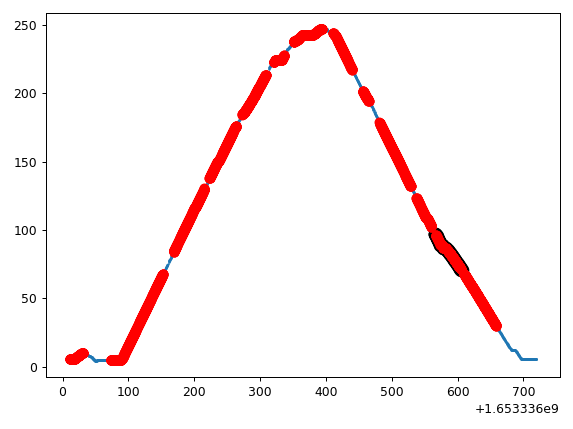

In [5]:
%matplotlib notebook

save_index_1_arr = np.array(save_index_1)
i = save_index_1_arr[20]

plt.figure()

plt.scatter(t1,tp1[0,:],s =1)
#plt.scatter(t2,tp2[0,:],s =1)

plt.scatter(t1[i[0]:i[1]],tp1[0,i[0]:i[1]], linewidth=5, color= 'black')

#plt.plot(trimble_1[i[0,0]:i[1,0],0],trimble_1[i[0,0]:i[1,0],1], linewidth=5, color= 'black')
#plt.plot(trimble_1[i[0,0]:i[1,0],0],trimble_1[i[0,0]:i[1,0],1], linewidth=5, color= 'black')
plt.scatter(trimble_1[:,0],trimble_1[:,1], linewidth=2, color= 'red')


plt.show()